# Suma de matrices.

![Alt text](imagen/cudaMatrix.png)

In [1]:
import numpy as np
from pycuda import gpuarray, autoinit
import pycuda.driver as cuda
from pycuda.tools import DeviceData
from pycuda.tools import OccupancyRecord as occupancy
nDevices = cuda.Device.count()
for i in range(nDevices):
	dev = cuda.Device( i )
	print "  Device {0}: {1}".format( i, dev.name() )
devNumber = 0
if nDevices > 1:
	if ndev == None:
	  devNumber = int(raw_input("Select device number: "))
	else:
	  devNumber = ndev
dev = cuda.Device( devNumber)
cuda.Context.pop()
ctxCUDA = dev.make_context()
devdata = DeviceData(dev)
print "Using device {0}: {1}".format( devNumber, dev.name() )

  Device 0: GeForce GTX 670
Using device 0: GeForce GTX 670


Inicializar los arreglos en CPU (Ram del Host) mediante Numpy, la libreria de Python para manejar arreglos.

In [2]:
#presCPU, presGPU = np.float32, 'float'
presCPU, presGPU = np.float64, 'double'

In [3]:
a_cpu = np.ones((512,512), dtype=presCPU)
a_cpu = np.random.random((512,512)).astype(presCPU)
b_cpu = np.ones((512,512), dtype=presCPU)
b_cpu = np.random.random((512,512)).astype(presCPU)
c_cpu = np.zeros((512,512), dtype=presCPU)

In [4]:
%matplotlib inline

In [5]:
np.random.random?

In [6]:
from matplotlib import pyplot as plt

<matplotlib.colorbar.Colorbar instance at 0x4c64488>

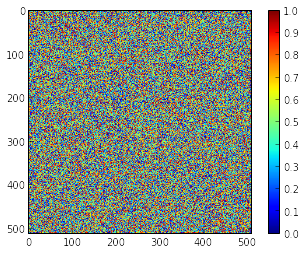

In [7]:
plt.imshow(a_cpu)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x532e3f8>

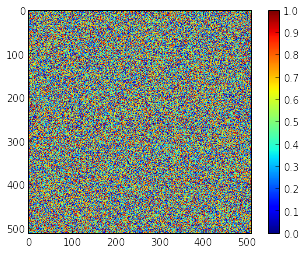

In [8]:
plt.imshow(b_cpu)
plt.colorbar()

Creamos el espacio y copiamos nuestros arreglo de la memoria del host (CPU, RAM) a la memoria del GPU (device). Todas estas tareas se consiguen con la herramientas de GPUArray incluidas en pyCUDA.

In [9]:
a_gpu = gpuarray.to_gpu(a_cpu)
b_gpu = gpuarray.to_gpu(b_cpu)
c_gpu = gpuarray.to_gpu(c_cpu)
c_cpu

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Realizamos la operacion deseada en CPU mediante la operacion directa sobre los arreglos

In [10]:
t_cpu = %timeit -o c_cpu = a_cpu+b_cpu 
# ipython nos incluye funciones para medir el tiempo de ejecucion de nuestro codigos

The slowest run took 6.09 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 813 µs per loop


In [11]:
c_cpu = a_cpu+b_cpu
c_cpu

array([[ 1.44462506,  0.82925996,  1.53172813, ...,  1.6085795 ,
         0.90066985,  0.34459632],
       [ 0.99419215,  1.65935159,  0.51847399, ...,  1.02956854,
         1.71814066,  1.57117132],
       [ 1.52851224,  0.76416952,  0.77022076, ...,  1.59794379,
         0.8786388 ,  1.2405423 ],
       ..., 
       [ 0.84650795,  0.26858354,  1.48170108, ...,  0.94437941,
         1.28367315,  0.22665242],
       [ 1.11877211,  0.88221804,  1.01856891, ...,  0.55492058,
         1.13408687,  0.34604273],
       [ 1.42121743,  1.81977902,  1.06943462, ...,  1.22993962,
         0.78455951,  0.43501943]])

Definamos el Kernel (Funcion de GPU) que operará de manera paralela sobre los elemntos de matriz. Recordemos que los kernels estan escritos en sintaxis de C#

In [12]:
cudaKernel = '''
__global__ void matrixAdd(float *A, float *B, float *C)
{
    int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
    int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
    int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
    C[tid] = A[tid] + B[tid];
}
'''

In [13]:
print cudaKernel


__global__ void matrixAdd(float *A, float *B, float *C)
{
    int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
    int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
    int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
    C[tid] = A[tid] + B[tid];
}



Ahora compilaremos y generaremos una funcion a partir del kernel escrito previamente. Esto lo conseguimos de una manera sencilla mediante pyCUDA

In [14]:
from pycuda.compiler import SourceModule

In [15]:
myCode = SourceModule(cudaKernel)
addMatrix = myCode.get_function("matrixAdd") # El output de get_function es la funacion compilada lista para GPU

In [16]:
type(addMatrix) 

pycuda._driver.Function

Ahora debemos decidir la distribucion de Bloques y Threads apropiada para:
> 1. Conseguir que se completen el numero de tareas necesarias
> 2. Escoger una organizacion apropiada para las dimensiones del problema


Como lidiamos con una matriz lo ideal es generar una distribución de threads en 2D, lo que ganamos es realizar tareas sobre bloques de la matriz y aprendemos a utilizar los indices de bloques y threads. **OJO**: Si quisieramos podriamos sólo reutilizaer el código de suma de vectores ya que en realidad no se requiere una distribucion especial de threads dado que las operaciones solo son sobre elementos, esto cambiaria si necesitaramos realizar operaciones mas complejas como leer sobre los vecinos.

La eleccion para este caso es mas o menos sencilla. Sea $N$ la dimension de la matriz. Dado que solo tenemos disponibles 1024 threads por bloque, solo podemos dividir a la matriz en bloques de $\sqrt{1024}=32$. Siempre trataremos de explotar al maximo la cantidad de thread por bloque cuando realicemos tareas senciallas. El grid corrrespondiente para llegar a la dimension $N$ sera entonces ($N/32$,$N/32$)

In [17]:
cuBlock = (32,32,1) # En pycuda siempre sera necesario indicar la tercera dimencsion de gr
cuGrid = (16,16,1)
nthreads = cuBlock[0]*cuBlock[1]*cuBlock[2]
nthreads

1024

Por motivos de como se ejecutan los threads en el hardware, escojeremos por lo regular dimensiones con multiplos de 32 o potencias de 2. Esto se debe a que los bloques son dividios en warps de 32 threads y estos son ejecutados de manera paralela en los multiprocesadores (MP), por lo que si no escogemos estas dimensiones desperdiciaremos computo en el ultimo warp de cada bloque. Esto no impide que la distribucion de threads sea diferentes de los bloques cuadrados, para este caso en especifico pudimos haber escogido bloques de:
> (16,64),(8,128),(4,256),(2,512)
que requiririan la apropiada redistribucion del grid.

Una vez que tenemos la distribucion para nuestro kernel, descubriemos que existen dos formas de invocar la funcion de GPU o kernel. La primera es mediante la utilizacion directa de la funcion compilada:
```python
kernelFunction(arg1,arg2, ... ,block=(n,m,l),grid=(r,s,t))
```
La segusnda es mediante un paso previo llamado preparacion:
```python
kernelFunction.prepare('ABC..') # Cada letra corresponde a un tipo de dato de entrada de la funcion, i=int, f=float, P = puntero, ...
kernelFunction.prepared_call(grid,block,arg1.gpudata,arg2,...) # Al usar esto los arreglos de GPU deben ser pasados como punteros con el atributo 'gpudata'
```

Utilizacion simple

In [18]:
addMatrix(a_gpu,b_gpu,c_gpu,block=cuBlock,grid=cuGrid)

Utilizacion con prepare, con mas opciones ...

In [19]:
addMatrix.prepare('PPP')

In [20]:
addMatrix.prepared_call(cuGrid,cuBlock,a_gpu.gpudata,b_gpu.gpudata,c_gpu.gpudata)

Una vez preparada la funacion es posible medir el tiempo de ejecucion del kernel

In [21]:
time2 = addMatrix.prepared_timed_call(cuGrid,cuBlock,a_gpu.gpudata,b_gpu.gpudata,c_gpu.gpudata)

In [22]:
time2()

3.241600096225738e-05

In [23]:
c = c_gpu.get()  #Podemos copiar de nuevo el array de GPU a la memoria de CPU y comparae los resultados
c, c_cpu

(array([[ 184.91197963,  106.14531488,  196.06120478, ...,  205.89823963,
           81.53718897,   40.35435428],
        [ 115.007104  ,  212.39700671,   30.87744862, ...,  117.0319925 ,
          219.92194602,  201.10990208],
        [ 195.64951703,   46.93729059,   93.77128   , ...,  204.5367956 ,
           22.74394167,  143.66140512],
        ..., 
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ]]),
 array([[ 1.44462506,  0.82925996,  1.53172813, ...,  1.6085795 ,
          0.90066985,  0.34459632],
        [ 0.99419215,  1.65935159,  0.51847399, ...,  1.02956854,
          1.71814066,  1.57117132],
        [ 1.52851224,  0.76416952,  0.77022076, ...,  1.59794379,
          0.8786388 ,  1.24054

<matplotlib.colorbar.Colorbar instance at 0x5e97758>

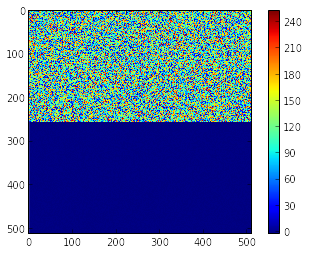

In [24]:
plt.imshow(c-c_cpu,interpolation='none')
plt.colorbar()

In [25]:
np.sum(np.sum(np.abs(c_cpu-c))) 
# En el caso random el error de cada operacion es de 10^-6. Nos da un total de la diferencia de 1x10^-1

14947603.844147405

In [26]:
def getKernelInfo(kernel,nthreads, rt=True):
    ''' This function returns info about kernels theoretical performance, but warning is not trivial to optimize! '''
    shared=kernel.shared_size_bytes
    regs=kernel.num_regs
    local=kernel.local_size_bytes
    const=kernel.const_size_bytes
    mbpt=kernel.max_threads_per_block
    #threads =  #self.block_size_x* self.block_size_y* self.block_size_z
    occupy = occupancy(devdata, nthreads, shared_mem=shared, registers=regs)
    print "==Kernel Memory=="
    print("""Local:        {0}
Shared:       {1}
Registers:    {2}
Const:        {3}
Max Threads/B:{4}""".format(local,shared,regs,const,mbpt))
    print "==Occupancy=="
    print("""Blocks executed by MP: {0}
Limited by:            {1}
Warps executed by MP:  {2}
Occupancy:             {3}""".format(occupy.tb_per_mp,occupy.limited_by,occupy.warps_per_mp,occupy.occupancy))
    if rt:
        return occupy.occupancy
    
def gpuMesureTime(myKernel, ntimes=1000):
    start = cuda.Event()
    end = cuda.Event()
    start.record()
    for i in range(ntimes):
      myKernel()
    end.record()
    end.synchronize()
    timeGPU = start.time_till(end)*1e-3
    print "Call the function {0} times takes in GPU {1} seconds.\n".format(ntimes,timeGPU)
    print "{0} seconds per call".format(timeGPU/ntimes)
    return timeGPU

Podemos tambien evaluar el rendimiento de nuestro kernel asi como la forma en que se distribuye el calculo por bloque.

In [27]:
getKernelInfo(addMatrix,nthreads)

==Kernel Memory==
Local:        0
Shared:       0
Registers:    10
Const:        0
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 1
Limited by:            warps
Warps executed by MP:  32
Occupancy:             0.666666666667


0.6666666666666666

In [28]:
timeGPU=[]

In [29]:
%time for i in range(1000): timeGPU.append(addMatrix.prepared_timed_call(cuGrid,cuBlock,a_gpu.gpudata,b_gpu.gpudata,c_gpu.gpudata)())

CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 59 ms


In [30]:
np.sum(np.array(timeGPU))*1000

37.847679942846298

# Multiplicacion de matrices

![Alt text](imagen/matrixMul.png)

Ahora cada thread calculara una entrada de la matriz resultante de la multiplicacion, lo que implica que cada thread hara un producto punto entre un renglon de a con una columna de b

In [31]:
cudaKernel2 = '''
__global__ void matrixMul(float *A, float *B, float *C)
{
    int tid_x = blockDim.x * blockIdx.x + threadIdx.x; // Renglon
    int tid_y = blockDim.y * blockIdx.y + threadIdx.y; // Columna
    int matrixDim = gridDim.x * blockDim.x;
    int tid   = matrixDim * tid_y + tid_x; // elemento i,j
    
    float  aux=0.0f;
    
    for ( int i=0 ; i<matrixDim ; i++ ){
        //          
        aux += A[matrixDim * tid_y + i]*B[matrixDim * i + tid_x] ;
    
    }
    
    C[tid] = aux;
             
}
'''

In [32]:
myCode = SourceModule(cudaKernel2)
mulMatrix = myCode.get_function("matrixMul")

In [33]:
mulMatrix(a_gpu,b_gpu,c_gpu,block=cuBlock,grid=cuGrid)

In [34]:
dotAB = np.dot(a_cpu,b_cpu)

In [35]:
dotAB

array([[ 125.28639301,  124.44166983,  125.38797583, ...,  128.2157913 ,
         127.27621271,  130.3366136 ],
       [ 133.29639917,  131.47199602,  133.20895847, ...,  132.91440772,
         135.687517  ,  133.83851419],
       [ 128.36221388,  127.95600079,  126.11808223, ...,  131.45188011,
         126.32150247,  125.69001167],
       ..., 
       [ 127.95236738,  125.7023213 ,  128.79992046, ...,  128.91223991,
         131.76059986,  132.50925283],
       [ 130.9064869 ,  128.12241181,  129.57785182, ...,  131.30590148,
         133.51315786,  131.25500653],
       [ 132.18795987,  134.2785064 ,  134.10501877, ...,  136.63181027,
         135.43450706,  136.47768824]])

In [36]:
c_gpu

array([[ -1.03258492e+293,   1.80758094e+294,  -1.49874554e+299, ...,
                      nan,               nan,               nan],
       [              nan,               nan,               nan, ...,
                      nan,               nan,               nan],
       [              nan,               nan,               nan, ...,
                      nan,               nan,               nan],
       ..., 
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000]])

In [37]:
diff = np.abs(c_gpu.get()-dotAB)
np.sum(np.sum(diff))

nan

<matplotlib.colorbar.Colorbar instance at 0x68dda70>

/usr/lib/pymodules/python2.7/matplotlib/colors.py:533: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa<0.0, -1)


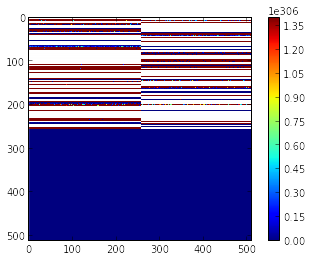

In [38]:
plt.imshow(diff,interpolation='none')
plt.colorbar()

In [39]:
getKernelInfo(mulMatrix,nthreads)

==Kernel Memory==
Local:        0
Shared:       0
Registers:    21
Const:        0
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 1
Limited by:            warps
Warps executed by MP:  32
Occupancy:             0.666666666667


0.6666666666666666

In [40]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy, pycuda, pycula

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:834: FormatterWarning: JSON expects JSONable list/dict containers, not JSON strings
  FormatterWarning)


Software versions
Python 2.7.3 (default, Jun 22 2015, 19:33:41) [GCC 4.6.3]
IPython 4.0.0
OS posix [linux2]
numpy 1.9.2
scipy 0.9.0
matplotlib 1.1.1rc
sympy 0.7.4-git
pycuda 2014.1
pycula 0.95a1
<tr><td colspan='2'>Tue Sep 15 00:50:44 2015 CDT</td></tr>

# Pruebas de rendimiento

Hagamos ahora pruebas de rendimento. pyCUDA vs. Numpy

Tamaños de referencia, si usamos precsicion sencilla utilizamos 4 bytes por numero mientras en precision doble tendremos 8 bytes ($8\, bytes= 8 \times 4 bits = 64bits$). En precision doble los arreglos en distintas configuraciones ocupan:

|Points|size 1D (Mb)|size 2D (Mb)|size 3D (Mb)|
|:----:|:----------:|:----------:|:----------:|
|128|0.001|0.125|16|
|256|0.002|0.5|128|
|512|0.004|2|1024|
|1024|0.008|8|8192|

In [41]:
from time import time
def myColorRand():
    return (np.random.random(),np.random.random(),np.random.random())

In [42]:
dimension = [2**i for i in range(5,25) ]
myPrec = presCPU

In [43]:
dimension 

[32,
 64,
 128,
 256,
 512,
 1024,
 2048,
 4096,
 8192,
 16384,
 32768,
 65536,
 131072,
 262144,
 524288,
 1048576,
 2097152,
 4194304,
 8388608,
 16777216]

### Suma de vectores

In [44]:
nLoops = 100
timeCPU = []
for n in dimension:
    v1_cpu = np.random.random(n).astype(myPrec)
    v2_cpu = np.random.random(n).astype(myPrec)
    tMean = 0
    for i in range(nLoops):
        t = time() 
        v = v1_cpu+v2_cpu
        t = time() - t
        tMean += t/nLoops
    timeCPU.append(tMean)

([<matplotlib.axis.XTick at 0x7fb4890>,
 <a list of 20 Text xticklabel objects>)

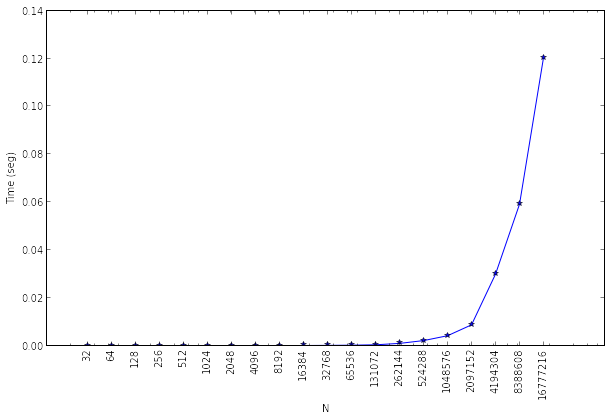

In [45]:
plt.figure(1,figsize=(10,6), dpi=200)
plt.semilogx(dimension,timeCPU,'b-*')
plt.ylabel('Time (seg)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')

**Version GPU**

Suma por defecto de arreglos de la clase GPUArray

In [46]:
timeGPU1 = []
bandWidth1 = []
for n in dimension:
    v1_cpu = np.random.random(n).astype(myPrec)
    v2_cpu = np.random.random(n).astype(myPrec)
    t1Mean = 0
    t2Mean = 0
    for i in range(nLoops):
        t = time()
        vaux = gpuarray.to_gpu(v1_cpu)
        t = time() -t
        t1Mean += t/nLoops
    bandWidth1.append(t1Mean)
    v1_gpu = gpuarray.to_gpu(v1_cpu) 
    v2_gpu = gpuarray.to_gpu(v2_cpu)
    for i in range(nLoops):
        t = time()
        v = v1_gpu+v2_gpu
        t = time() -t
        t2Mean += t/nLoops
    timeGPU1.append(t2Mean)
    v1_gpu.gpudata.free()
    v2_gpu.gpudata.free()
    v.gpudata.free()

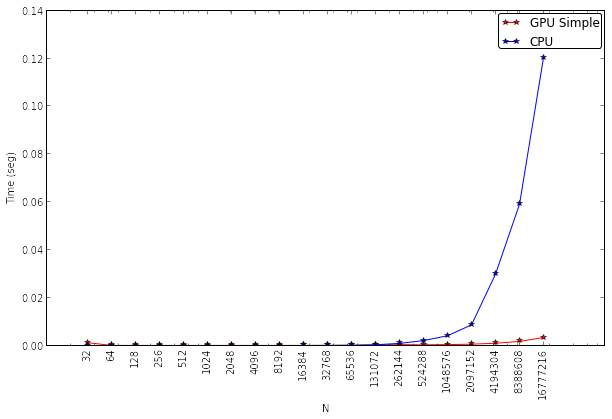

In [47]:
plt.figure(1,figsize=(10,6))
plt.semilogx(dimension,timeGPU1,'r-*',label='GPU Simple')
plt.semilogx(dimension,timeCPU,'b-*',label='CPU')
plt.ylabel('Time (seg)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

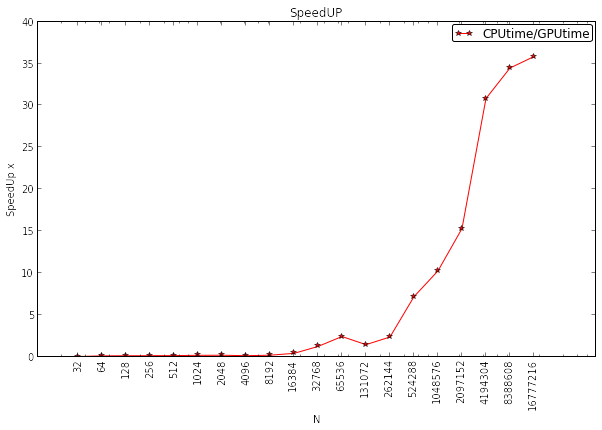

In [48]:
plt.figure(1,figsize=(10,6))

a = np.array(timeGPU1)
b = np.array(timeCPU)
plt.semilogx(dimension,b/a,'r-*',label='CPUtime/GPUtime')
plt.ylabel('SpeedUp x')
plt.xlabel('N')
plt.title('SpeedUP')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

Costo de las transferencias de memoria

[  3.05175781e-05   6.10351562e-05   1.22070312e-04   2.44140625e-04
   4.88281250e-04   9.76562500e-04   1.95312500e-03   3.90625000e-03
   7.81250000e-03   1.56250000e-02   3.12500000e-02   6.25000000e-02
   1.25000000e-01   2.50000000e-01   5.00000000e-01   1.00000000e+00
   2.00000000e+00   4.00000000e+00   8.00000000e+00   1.60000000e+01]


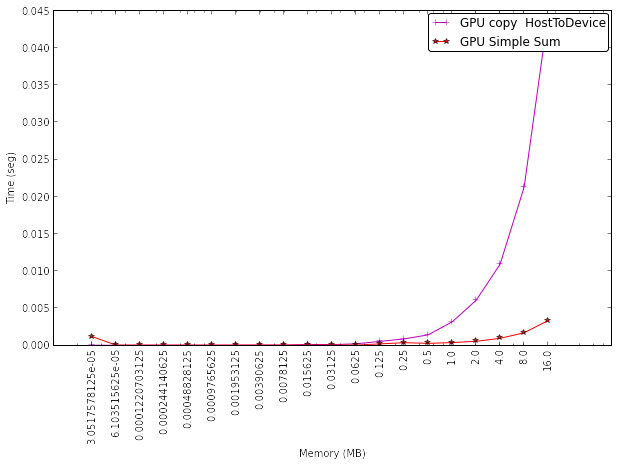

In [49]:
plt.figure(1,figsize=(10,6))
sizeMB = np.array(dimension)/(2.**20)
print sizeMB
plt.semilogx(sizeMB,bandWidth1,'m-+',label='GPU copy  HostToDevice')
plt.semilogx(sizeMB,timeGPU1,'r-*',label='GPU Simple Sum')
plt.ylabel('Time (seg)')
plt.xlabel('Memory (MB)')
plt.xticks(sizeMB, sizeMB, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

Implementacion mediante las funaciones de tipo elementwise

In [50]:
from pycuda.elementwise import ElementwiseKernel
myCudaFunc = ElementwiseKernel(arguments = "float *a, float *b, float *c",
                               operation = "c[i] = a[i]+b[i]",
                               name = "mySumK")

In [51]:
import pycuda.driver as drv
start = drv.Event()
end = drv.Event()

In [52]:
timeGPU2 = []
for n in dimension:
    v1_cpu = np.random.random(n).astype(myPrec)
    v2_cpu = np.random.random(n).astype(myPrec)
    v1_gpu = gpuarray.to_gpu(v1_cpu) 
    v2_gpu = gpuarray.to_gpu(v2_cpu)
    vr_gpu  = gpuarray.to_gpu(v2_cpu)
    t3Mean=0
    for i in range(nLoops):
        start.record()
        myCudaFunc(v1_gpu,v2_gpu,vr_gpu)
        end.record()
        end.synchronize()
        secs = start.time_till(end)*1e-3
        t3Mean+=secs/nLoops
    timeGPU2.append(t3Mean)
    v1_gpu.gpudata.free()
    v2_gpu.gpudata.free()
    vr_gpu.gpudata.free()

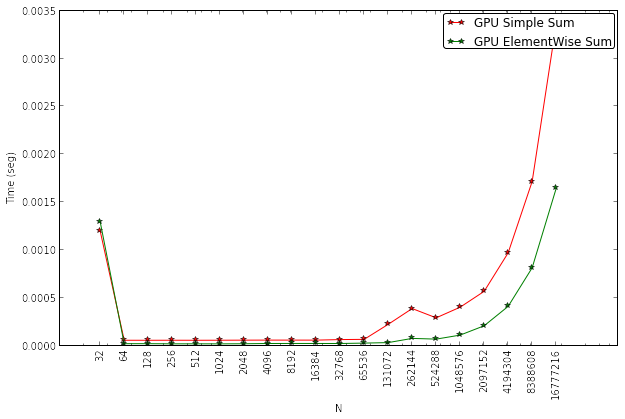

In [53]:
plt.figure(1,figsize=(10,6))
plt.semilogx(dimension,timeGPU1,'r-*',label='GPU Simple Sum')
plt.semilogx(dimension,timeGPU2,'g-*',label='GPU ElementWise Sum')
plt.ylabel('Time (seg)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

#### Ojo:

Tanto en Elemnt-Wise como en Simple Sum no se tiene control sobre la distribucion de los calculos.

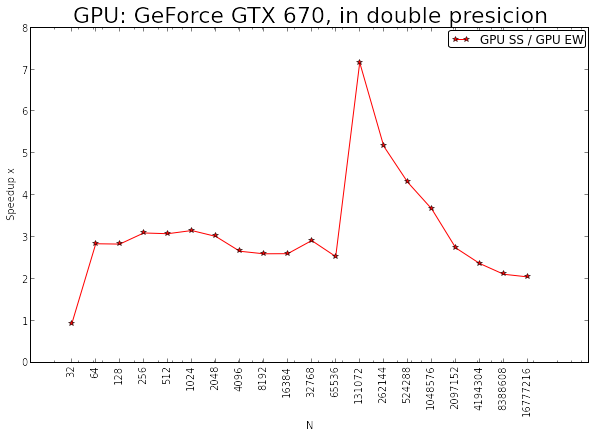

In [54]:
plt.figure(1,figsize=(10,6))
plt.title('GPU: {0}, in {1} presicion'.format(dev.name(),presGPU),size=22)
a=np.array(timeGPU1)
b=np.array(timeGPU2)
plt.semilogx(dimension,a/b,'r-*',label='GPU SS / GPU EW')
plt.ylabel(' Speedup x')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

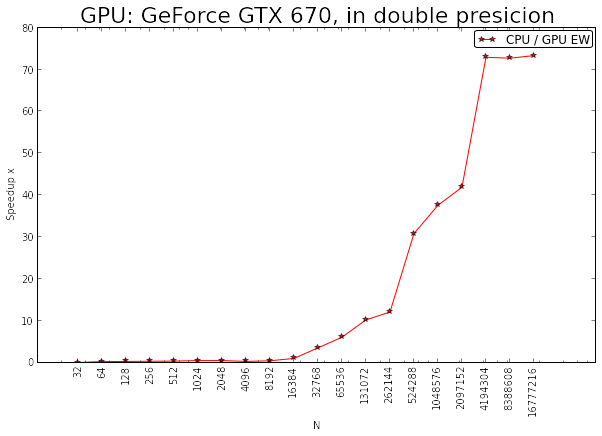

In [55]:
plt.figure(1,figsize=(10,6))
plt.title('GPU: {0}, in {1} presicion'.format(dev.name(),presGPU),size=22)
a=np.array(timeCPU)
b=np.array(timeGPU2)
plt.semilogx(dimension,a/b,'r-*',label='CPU / GPU EW')
plt.ylabel(' Speedup x')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

Finalmente tenemos la implementacion con un kernel con la funcion de pyCUDA SourceModule, en esta implementacion podemos probar la variacion del tamaño del bloque.

In [59]:
cudaCode = open("gpuAdd.cu","r")
cudaCode = cudaCode.read()
cudaCode = cudaCode.replace('float',presGPU )
print cudaCode
myCode = SourceModule(cudaCode)
vectorAddKernel = myCode.get_function("vectorAdd")
vectorAddKernel.prepare('PPP')

#include <stdio.h>
#include <cuda_runtime.h>
// CUDA Kernel
__global__ void
vectorAdd(const double *A, const double *B, double *C, int numElements)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;

    if (i < numElements)
    {
        C[i] = A[i] + B[i];
    }
}

/**
 * Host main routine
 */
int
main(void)
{
    int numElements = 15;
    size_t size = numElements * sizeof(double);
    printf("[Vector addition of %d elements]\n", numElements);

    double a[numElements],b[numElements],c[numElements];
    double *a_gpu,*b_gpu,*c_gpu;

    cudaMalloc((void **)&a_gpu, size);
    cudaMalloc((void **)&b_gpu, size);
    cudaMalloc((void **)&c_gpu, size);

    for (int i=0;i<numElements;++i ){
    
    	a[i] = i*i;
    	b[i] = i;
    
    }
    // Copy the host input vectors A and B in host memory to the device input vectors in
    // device memory
    printf("Copy input data from the host memory to the CUDA device\n");
    cudaMemcpy(a_gpu, a, size, cudaMemcpyHostToDevice);
    cudaMemc

In [60]:
timeGPU3 = []
occupancyMesure=[]
for nt in [32,64,128,256,512,1024]:
    aux = []
    auxOcc = []
    for n in dimension:
        v1_cpu = np.random.random(n).astype(myPrec)
        v2_cpu = np.random.random(n).astype(myPrec)
        v1_gpu = gpuarray.to_gpu(v1_cpu) 
        v2_gpu = gpuarray.to_gpu(v2_cpu)
        vr_gpu  = gpuarray.to_gpu(v2_cpu)
        cudaBlock = (nt,1,1) 
        cudaGrid    = ((n+nt-1)/nt,1,1)
        
        cudaCode = open("gpuAdd.cu","r")
        cudaCode = cudaCode.read()
        cudaCode = cudaCode.replace('float',presGPU )
        downVar = ['blockDim.x','blockDim.y','blockDim.z','gridDim.x','gridDim.y','gridDim.z']
        upVar      = [str(cudaBlock[0]),str(cudaBlock[1]),str(cudaBlock[2]),
                     str(cudaGrid[0]),str(cudaGrid[1]),str(cudaGrid[2])]
        dicVarOptim = dict(zip(downVar,upVar))
        for i in downVar:
            cudaCode = cudaCode.replace(i,dicVarOptim[i])
        #print cudaCode
        myCode = SourceModule(cudaCode)
        vectorAddKernel = myCode.get_function("vectorAdd")
        vectorAddKernel.prepare('PPP')
        
        print '\n Size={0}, threadsPerBlock={1}'.format(n,nt)
        print cudaBlock,cudaGrid
        t5Mean = 0
        for i in range(nLoops):
            timeAux = vectorAddKernel.prepared_timed_call(cudaGrid,cudaBlock,v1_gpu.gpudata,v2_gpu.gpudata,vr_gpu.gpudata)
            t5Mean += timeAux()/nLoops
        auxOcc.append(getKernelInfo(vectorAddKernel,cudaBlock[0]*cudaBlock[1]*cudaBlock[2]))
        aux.append(t5Mean)
        v1_gpu.gpudata.free()
        v2_gpu.gpudata.free()
        vr_gpu.gpudata.free()
    timeGPU3.append(aux)
    occupancyMesure.append(auxOcc)


 Size=32, threadsPerBlock=32
(32, 1, 1) (1, 1, 1)
==Kernel Memory==
Local:        0
Shared:       0
Registers:    12
Const:        0
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 8
Limited by:            device
Warps executed by MP:  8
Occupancy:             0.166666666667

 Size=64, threadsPerBlock=32
(32, 1, 1) (2, 1, 1)
==Kernel Memory==
Local:        0
Shared:       0
Registers:    12
Const:        0
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 8
Limited by:            device
Warps executed by MP:  8
Occupancy:             0.166666666667

 Size=128, threadsPerBlock=32
(32, 1, 1) (4, 1, 1)
==Kernel Memory==
Local:        0
Shared:       0
Registers:    12
Const:        0
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 8
Limited by:            device
Warps executed by MP:  8
Occupancy:             0.166666666667

 Size=256, threadsPerBlock=32
(32, 1, 1) (8, 1, 1)
==Kernel Memory==
Local:        0
Shared:       0
Registers:    12
Const:        0
Max Threa

In [61]:
timeGPU3[0]

[1.1691840039566159e-05,
 1.1955200028605756e-05,
 1.161088006570935e-05,
 1.1736000068485738e-05,
 1.1506240097805855e-05,
 1.1812480008229612e-05,
 1.1891840035095814e-05,
 1.2302399985492224e-05,
 1.28982399776578e-05,
 1.461055999621749e-05,
 1.9510080022737383e-05,
 2.784991996362806e-05,
 4.182207994163033e-05,
 7.208544015884393e-05,
 0.00013372640013694772,
 0.0002527136000990867,
 0.000495632959008217,
 0.0009830348795652388,
 0.0019070166397094728,
 0.003628258554935455]

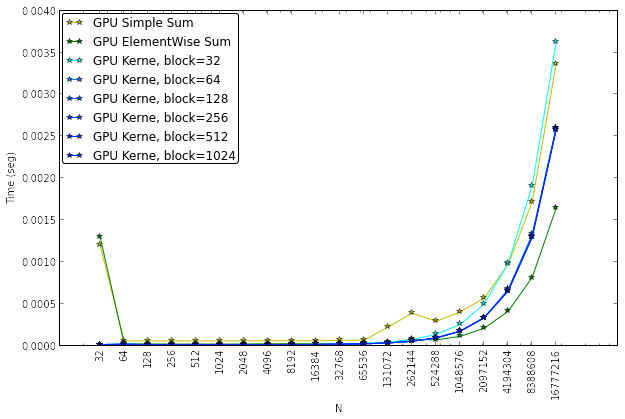

In [62]:
plt.figure(1,figsize=(10,6),dpi=100)
plt.semilogx(dimension,timeGPU1,'y-*',label='GPU Simple Sum')
plt.semilogx(dimension,timeGPU2,'g-*',label='GPU ElementWise Sum')
count = 0
for nt in [32,64,128,256,512,1024]:
    plt.semilogx(dimension,timeGPU3[count],'-*',label='GPU Kerne, block={0}'.format(nt),color=(0,1./(count+1),1))
    count+=1
plt.ylabel('Time (seg)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

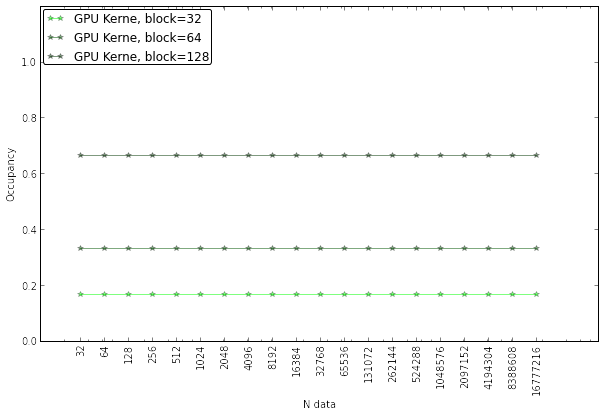

In [63]:
plt.figure(1,figsize=(10,6),dpi=200)
count = 0
for nt in [32,64,128]:
    plt.semilogx(dimension,occupancyMesure[count],'-*',label='GPU Kerne, block={0}'.format(nt),color=(0,1./(2*count+1),0), alpha=0.5)
    count+=1
plt.ylabel('Occupancy')
plt.xlabel('N data')
plt.ylim(0,1.2)
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

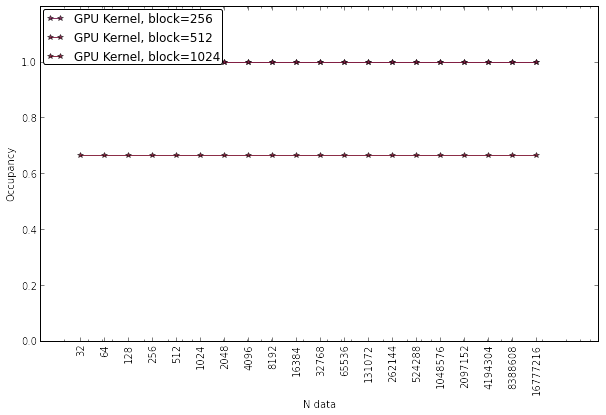

In [64]:
plt.figure(1,figsize=(10,6),dpi=200)
count = 3
for nt in [256,512,1024]:
    plt.semilogx(dimension,occupancyMesure[count],'-*',label='GPU Kernel, block={0}'.format(nt),color=(0.5,1./(2*count+1),1./count), alpha=0.9)
    count+=1
plt.ylabel('Occupancy')
plt.xlabel('N data')
plt.ylim(0,1.2)
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

### Debido a al arquitectura de la GPU obtenemos una maxima ocupacion de la misma cuando no utilizamos el maximo numero de threads por bloque con lo cual estamos explotando todo el poder de calculo de la GPU. Una manera de comprobarlo es usar las funciones como *getKernelInfo*.

Para el caso de la tarjetas:

|Tarjeta| Occup  | precision  | threadsPerBlock  |
|---|---|---|---|
| GTX 670 | 1.0  | float  | 256,512  |
| GTX 670 | 1.0  | double  | 256,512  |
|   |   |   |   |
|   |   |   |   |

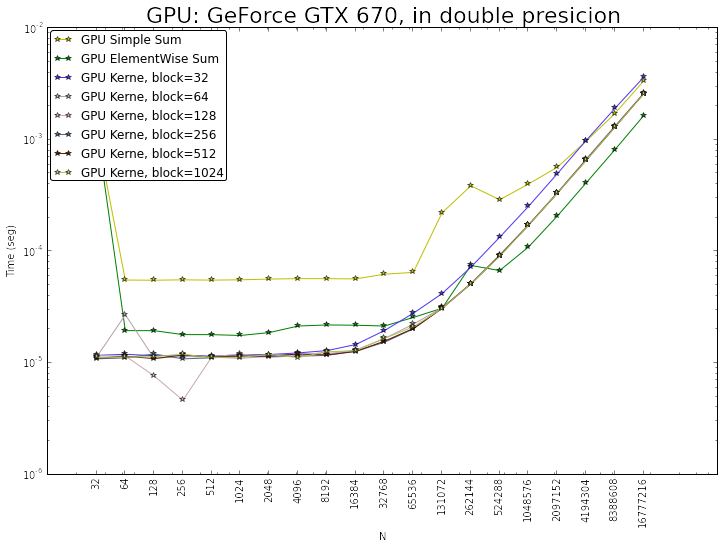

In [65]:
plt.figure(1,figsize=(12,8),dpi=300)
plt.title('GPU: {0}, in {1} presicion'.format(dev.name(),presGPU),size=22)
plt.loglog(dimension,timeGPU1,'y-*',label='GPU Simple Sum')
plt.loglog(dimension,timeGPU2,'g-*',label='GPU ElementWise Sum')
count = 0
for nt in [32,64,128,256,512,1024]:
    plt.loglog(dimension,timeGPU3[count],'-*',label='GPU Kerne, block={0}'.format(nt),color=myColorRand())
    count+=1
plt.ylabel('Time (seg)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

**OJO**:  Lo correcto es promediar el tiempo de varias ejecuciones...

In [66]:
myColorRand()

(0.031099436385800927, 0.5556053072050818, 0.9725009161722764)

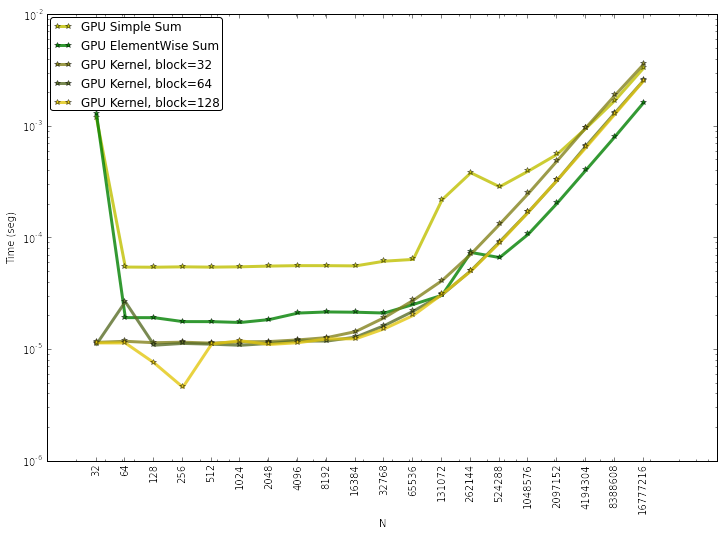

In [67]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.loglog(dimension,timeGPU1,'y-*',label='GPU Simple Sum', alpha=0.8,linewidth=3)
plt.loglog(dimension,timeGPU2,'g-*',label='GPU ElementWise Sum', alpha=0.8,linewidth=3)
count = 0
for nt in [32,64,128]:
    plt.loglog(dimension,timeGPU3[count],'-*',label='GPU Kernel, block={0}'.format(nt),color=myColorRand(), alpha=0.8,linewidth=3)
    count+=1
plt.ylabel('Time (seg)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

In [68]:
np.random.random()

0.6217985244040142

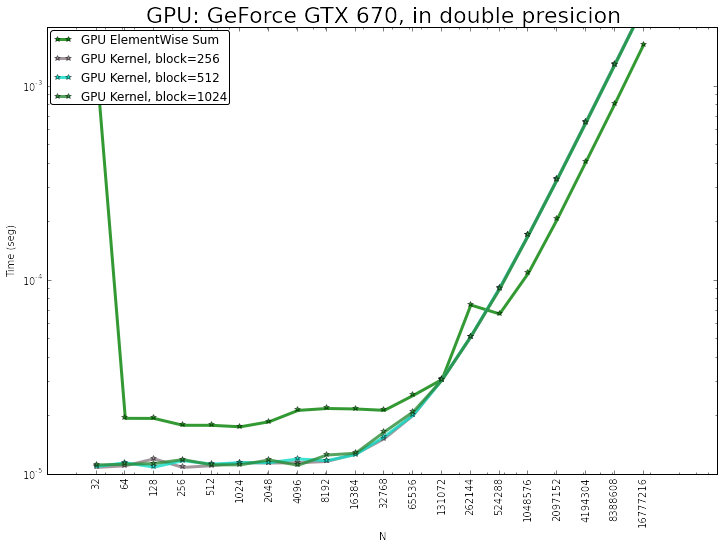

In [69]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.title('GPU: {0}, in {1} presicion'.format(dev.name(),presGPU),size=22)
#plt.loglog(dimension,timeGPU1,'y-*',label='GPU Simple Sum')
plt.loglog(dimension,timeGPU2,'g-*',label='GPU ElementWise Sum',alpha=0.8,linewidth=3)
count = 3
for nt in [256,512,1024]:
    plt.loglog(dimension,timeGPU3[count],'-*',label='GPU Kernel, block={0}'.format(nt),color=myColorRand(), alpha=0.8,linewidth=3)
    count+=1
plt.ylabel('Time (seg)')
plt.xlabel('N')
plt.ylim(1e-5,2e-3)
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

## Results Across plataforms 


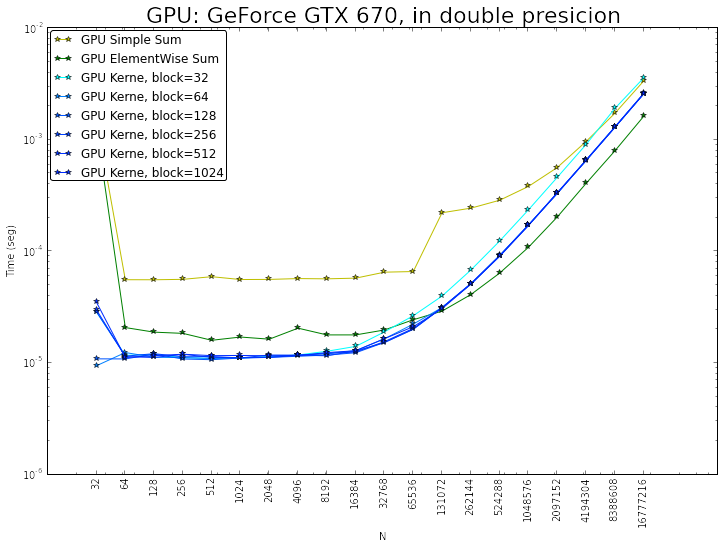
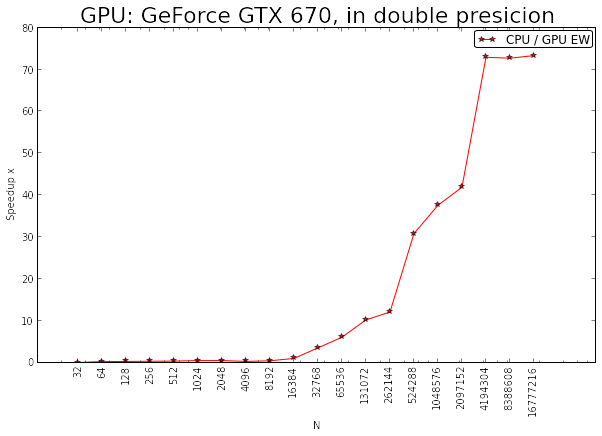

In [57]:
%%HTML
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtQAAAIkCAYAAAA+v7zpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdYFMf/B/D3HL1zgnRQEFTAgh0QFEERCVjABoqCCYk1lohoFEFjLIiJMV+DPxMVFSP2giViQxQbFlSwgQrSRA9B6eXufn/w3ctx3sFRFOU7r+eZ5+F2Z2Zn9/aWz83NzhI+nw+KoiiKoiiKopqG1doNoCiKoiiKoqgvGQ2oKYqiKIqiKKoZaEBNURRFURRFUc1AA2qKoiiKoiiKagYaUFMURVEURVFUM9CAmqIoiqIoiqKagQbU1EcTFxfnGhAQsKNLly5PNDQ03ikoKFTq6Oi8HjhwYOKiRYvCk5KS+okr17FjxwwWi8UTTkpKSuWmpqYvpk6duvPevXs9JZW5dOnS4Pra5OTkFM9isXg7d+6c2lL7yaiqqpLfvn37tDFjxhwxMTF5qaysXKasrFxmbGycNXz48DPh4eGLXr58adJS2/P3948SPU6iaf78+b+21Pa+BDwej3XgwIFxPj4+e83MzJ6rqakVKyoqVujr6+cNGTLkYlhYWNijR48smfzizrWG0pAhQy4CwI8//riaxWLxbG1tr/N4PLHX0vLycqUuXbo8YbFYvIiIiIWN3Z/CwkJ2SEjITz169LivpqZWrK6u/r5r166P/f39o4T3AwCioqL8pWm/jIwMV9Kx27x586y+ffveUlVVLdHU1CwaNGhQQkxMzMTGtrshTFtaut6mYM6BlvxsNhbz3gUEBOxoTLn4+Hgn4XOSkqyl3uewsLAwFovFW7FiRWhLtY1qG2RbuwFU25Ofn687ceLEGCa4NTc3T3d2dr6gqqpaUlBQoHXnzp3e165ds4uIiFg4efLk6F27dk0RV4+bm9s/enp6rwDg7du37W7evNl/9+7dfnv37vXZvXu334QJE/YJ5yeE8AkhUk2sLm0+ad24cWPAhAkT9r18+dJEVla2xsbGJtnW1va6rKxsTV5enn5iYuLAs2fPDlu2bNmq//znP7O//fbbrS21bRsbm2QbG5tkcesGDBhwo6W287lLS0uzGDt27MEHDx50Z7FYPGtr69RevXrdVVJSKn/9+rVOUlJSv0uXLg3+6aefQn788cfVP/30U8i4ceMOFBQUaAnXU1xcrHbo0CFvoPZLi+h2unbt+hio/ccaGxvrefPmzf7r168PCg4OXiea98cff1ydlpZmYWdnd+2HH37Y0Jj9uX37dh93d/dTb968aW9mZvZ8xIgRp3k8HuvZs2edoqOjJ7u6usZZWlo+YvJbWFikiWsv4/z58y5ZWVnGzs7OF0TXcblcGS8vr8OxsbGeGhoa79zc3P6prKxUOHfu3FBfX9+/r1+/brtx48Z5jWl/Q1r6M9gcn0tbmtqOz6X9n7PG/H+Qph56zKkP8Pl8mmhqsVRQUNDOzMzsGSGE5+jomHDv3r0e4vIlJibajxw58li/fv1uiq7r0KFDBiGEd+nSpUHCy8vLyxUnT568mxDC09DQKHr79i27oTKiafDgwfGEEN7OnTuntNQ+X79+fYCCgkIFIYQXGBi49dWrV7qieaqqquT27ds3vmfPnslBQUHhLbHdqVOnRhFCeCtWrFje2u97a6dnz56ZtWvXroAQwhs9evSR58+fm4rm4XK5rNOnT7s5OjomjBs3br+kujIyMjoQQngsFovb0HZv3brVR1ZWtlpRUbE8NTXVSnjd5cuXHVgsFldFRaXk6dOnFo3Zn5ycHIN27doVKCoqlu/evXuy6Prc3Fz9ly9fGktbX0VFhQKbzX5LCOHt3bt3ouj6iIiIHwghvG7duj14/fp1e2Z5WlqauZ6eXh4hhHfs2LGRLfV+PXnypPOTJ086t/Z5w+fXXjtYLBY3MzPTpLXasGPHDn9CCC8gIGB7Y8pdvHjRiRDCGzJkyIXWPo6fe3r+/LnpkydPOldXV8s2px4Oh6P15MmTzgUFBe1ae59o+rxSqzeApraVJkyYEMME09JcuJKSkvqKLqsvOC4uLlZVUVEpEQ0MWiugrqioUDAxMckkhPCCg4PXNpS/urpaNjk5uWdLbJsG1P+mAQMGXCeE8CZOnLhXmvzizjsmvXjxoqO0ATWfz8fSpUtXEUJ4/fr1u8nlcll8Ph+lpaXKnTp1SieE8H799dd5jd2fiRMn7iWE8H755Zf5LXF8/v77bx9CCK9du3YFlZWV8sLrampqZHR0dPJZLBb38uXLDqJld+7cOYUQwuvfv/+N1n6fP0aiATVNNNHUEomOoaZaTFpamsWBAwfGEUL4kZGRM2RlZWsaKtO3b99bjdmGqqpqSefOnZ8CQGuOeWRER0dPzsrKMjYwMMhdtWrVsobyy8rK1vTs2fOeuHVZWVnGc+fO/a1Lly5PlJSUyjU0NN45ODhcacnx3hwORzs4OHhd165dHzPbsLOzuxYZGTmDy+XKiOYXHttZUFCg9f33328yNTV9oaCgUDlmzJgjTD4+n0/2798/fsSIEad1dHReKygoVBoZGWW7uLic/89//jNbXFvOnDkzfOTIkcd1dXXz5eXlqwwMDHJ9fX3/TklJ6daYfTp//rzLzZs3+yspKZVv3rx5ljRlGnve1Sc0NHRFt27dUm7dutV33bp1wQAQHBy87vnz52YODg5X5s2bt7Ex9b169Urv4MGDY1VUVEqnT5++pSXauH379mkAMGnSpD3y8vJVwuuuXbtm9+bNm/ZGRkbZDg4OV0TLjhs37oCsrGzNrVu3+ubm5hq0RHskjaFmxrlmZmZ2OHv27DAXF5fzGhoa75SVlcvs7OyuxcbGejZle5mZmR2mTJmyS1dXN19ZWbnM2to6df369UHiznlhjf28NDS+Vpqx0hwOR3vGjBmRRkZG2YqKihWdOnV6FhIS8lN5eblSY/e7oKBAa9myZau6d+/+QFVVtURVVbWkT58+tzdu3DivpqamUUM+mXs2du7cOTU5Odlm9OjRR7W1tTlKSkrlffv2vRUVFeXfULn79+/3GDdu3AE9Pb1XsrKyNb/99ttcJl9paalKeHj4on79+iWpq6u/V1ZWLuvWrVvKihUrQktLS1VE6+VyuTJbtmyZbm9vf5W5R0dPT+9V79697yxcuDCCw+FoC+evbwx1Y65fDb3HJ0+e/GrEiBGntbW1OQoKCpUmJiYv/f39ox4/ftxVXP6Pdc5TraC1I3qa2k769ddf5xFCeL169brTnHoa6m1mev42btw4V9oyTJLUQ830ShJCeI3pqRo1atRRQghv/vz5vzRnny9cuDBEQ0OjiBDC69y58xMvL69Drq6uZ9TU1N4TQnhTpkzZKVqmsT3UaWlp5sbGxi8JITwDA4OcCRMmxHh6eh5nevyHDRsWJ9p7yfSceXh4xJqamj7X1tZ+M2bMmMPjx4/fN2PGjD/4fD4qKyvlR44ceYwQwpOTk6tydHRMmDRpUvTQoUPP6urqvhLX0/v999//RgjhycvLVw4cOPDKhAkTYnr37n2bEMJTUlIqO3Xq1Ahpj93cuXM3EkJ4Y8aMOdwS53Fje6j5fD5u377dW05OrkpBQaHi999/n00I4amqqhanp6d3auz2md5kR0fHBD6fj/j4+MGLFi1a9+233/7fqlWrlkoaRiUpZWZmmrBYLC6LxeKK+3Vk06ZNcwghPG9v74OS6rCxsblLCOGdPHnSvSWOsaTjy/QWL1u27CcWi8W1tbW95uvru6dPnz63mDIHDx70bsy2UlNTrbS1td8QQngdOnTI8PHx+Xv48OH/KCgoVHh7ex/s2LHjC3Gf+6Z8XkJDQ8Pq+0xK6olmlo8aNeqomZnZM21t7Tdjx449MHr06CPq6urvCCE8Ozu7q2VlZUrC5errob5//353AwODHEIIz8TEJNPT0/P4V199dUJLS4tDCOENHTr0bFVVlZy0x5G53syYMeMPRUXFcgsLi6e+vr57hg4delZWVraaEML7/vvvf5NULjAwcKuiomK5ubl5mo+Pz98eHh6xf/755zd8Ph9ZWVlGVlZWqYQQnq6u7is3N7fTo0ePPsK0v2fPnsmFhYWa4upVUVEpGT58+D+TJk2KHj58+D+dOnVKZ7FY3Bs3bvQXd26Jvs+NvX7V9x4vXrx4DSGEJysrW+3k5HRx0qRJ0d26dXvAXNfEfX4+xjlPU+ukVm8ATW0nMeObAwMDtzannvqC47t379owwUF8fPxgacoIp4YC6sb+9GtkZJRFCOHt2bPHt6n7m5ubq89ms9/KyclV7dq1y094XVZWllGvXr3uEEJ4UVFRU4XXMf9QwsLCQqXZTr9+/W4SQngTJkyIEQ4EsrKyjLp06fKYEMJbsmTJauEyzD96QgjPzc3tdElJiYpovUxA27Vr10ei42K5XC4rNjbWQ3hZZGTkdEIIr3v37vdF8x89enSUnJxcFZvNfiv6D1RScnBwuEwI4f38888/tsR53JSAms/nIyQkZCVzrAghvE2bNs1pyvaXLFmymglwmSFUomn69OmRzPCShlJYWFgoIYTXp0+fW+LWz58//xdCCG/BggUbJNXBBBybN2+e2RLHuL6AmhDCU1BQqDhz5oyr8LpVq1YtJYTwLCwsnjZmW8wXtalTp0YJD0NLTU210tHRyZf0uW/K56W5ATXzRerdu3fqzLr8/HydHj163COE8BYtWrROuJykgLqsrEzJ1NT0OSGEt27dukXC58rbt2/Zw4YNi2vMtYPP//d6QwjhzZs371cej0eYdTdu3OjPBP6iX4aFy4WEhKwUrZfH4xE7O7urTEBeUVGhwKwrLy9X9PPz20UI4fn7++9gljP3OXTo0CFDeMw/k+7du9dDdLmkgLqx1y9J7/HJkyfdCSE8NTW196JDp9avX7+QEMLT1NQsFNeulj7naWqd1OoNoKntJDc3t9OEEN6PP/74s7j1Z86ccZ06dWqUcPL399+RkZHRQTgfc4ERDpjfvn3LPnbs2Ejmn0Tv3r1viyvT1IA6JyfHoGvXro8sLS0f5ubm6ku7z4qKiuUsFosbFxc3TNz633777XvRfZ4+fXqkcJ5FixatI4TwFi9evEZcHbdu3eojLiAS/kclLnXs2PEFkzchIcGRkNqbOcUFqv/8889wQghPXV39nfA/NOYfvYKCQoW4Lxr5+fk68vLylbKystUPHz60bOh41dTUyOjr6+eyWCzuo0ePuorLM3v27N8JIbzff/99tjTvQdeuXR8RQnhbt24NFLd+z549vuLOO3FfDvj8pgfUb9++ZcvJyVUxPWpN/Rx99913W5jeezk5uaq1a9cGZ2dnGxYUFLTbtWuXH3NzYWhoaFhDdfF4PML0wP7xxx8zxOUJDAzcKinYYZKvr+8eQghv7dq1wU3dL+HUUEAt7sbdqqoqOQ0NjSIWi8WV9oZM5rxns9lv379/rya6nvk1QTTQaurnpbkBtYyMTE1KSoq1aDkmcBbdnqSA+o8//phBiOR7CnJzc/Xl5eUr27dv/1ra94y53hgbG78U17PN7PuwYcPixJWzsrJKFQ7CmXTq1KkRhBCevb19orjtlpaWKuvq6r6Sk5OrYt6Lmzdv9iOkcb9KiQuoG3v9qu89dnZ2Pk8I4S1btuwnceWYLw2iX/xb+pynqfUSnTaP+mQePXpkuWvXrinkv9MN8fl8AgBz5sz5vUOHDpmi+SXNrdqnT5/bhw8f9mrJthkYGOSKzuvbEi5evDjk2LFjowghfGZ/VVRUSiMjI2cweU6dOuUOAGPHjj0oro7evXvfUVFRKb13717PqqoqedExsJKmzdPW1uYwfzNTGHp6esZqamoWieYdPnz4GT09vVf5+fm6t2/f7mNvb39VtA0mJiYvRctduHDBubq6Ws7BweGK8BRukiQnJ9u8evVKr1u3binM9HOiBg0alLB58+ZZ169ft509e/Z/GqqzIUlJSf3EnXcbNmz4QUVFpbS59TOWL1++khmX+vDhQ6vk5GQbSdMZ1oeZ07q6ulouJCTkJ+Hp+Pz8/HarqKiUjh079uCGDRt+CAoKWl/fPpw/f94lMzOzg5KSUrmvr+/fTdmv1uDh4XFCdJmcnFy1mZnZ8+TkZJu8vDx9Y2PjrIbqYc57Dw+PE2pqasWi6/38/HZ///33mySVa+rnpal69Ohx39raOlV0uZOTU7yBgUFuXl6evjTba+iaoq+vn2dubp7+6NEjy7S0NAsLC4s0ads4duzYg3JyctWiy/38/HavXLlyeWJi4kAej8cSHSM/atSoY0TMVHNMW728vA6L256ysnJZnz59bp8+fXpEUlJSv2HDhp21tLR8pKamVnzixAmPNWvWLJk0adIecdenhjT2+iVJTU2NbGJi4kBCCF/S1JUBAQE7rl+/bnvp0qXBP/7442rR9S11zlOthwbUVIthArg3b960F7d+7ty5v82dO/c35nXHjh0zsrKyjCXVJzwPtYKCQqWBgUGuo6PjZScnp3jRvKLBkiTMenEX9qbQ1tbm5OTkGEra5yNHjoxh/s7MzOxgamr6QnTbz58/NwOAfv36JdW3LUIIv6CgQEtfXz9PePno0aOPLl++fGV9ZXNycgwBwNTU9IWkPGZmZs9fvXqlJ+7GM3FfeIDafQL+nZu5Icy+pqSkdGvowR6SjqkobW1tzpMnT7pIyv/rr7/O//XXX+czr1ksFq+l3n9GfHy80+bNm2epqqqW+Pj47P3zzz8DAwICdiQlJfWT5uZcYUzgRwjhBwYG/im63svL67CWllYBMzd7fQ/1YG5GHDNmzBENDY134vKoqqqWALU3hUmqp6SkRFW4bR8TIYQvKThSV1d/DwAVFRWK0tSVnZ1tBEg+7zU0NN6pq6u/Ly4uVhNe3tzPS1PVt72OHTtm5ObmGjBtqw/zORs3btyB+vIRQvgcDke7MQG1pDYaGxtnEUL4FRUVigUFBVrt27d/I7xe0jWEaWtQUND6oKCg9fVtm7nRUFVVtWT79u3Tpk2btn3p0qU/L1269GdDQ8McW1vb6x4eHicmTpwYo6CgUNnQvjT2+iVJQUGBVlVVlbyMjAxX0n4yx03c+9eS5zzVemhATbWYPn363N6zZ88kSU9AbKzFixevHTRoUII0eZWVlcuA+oMC4N/AgAkimqtPnz63c3JyDJOSkvo11AMoKdhnZguYOHFijKKiYkV9dYj2TjdWUwNJJSWl8paoj9lXQ0PDnGHDhp2tL6+0/+T69OlzOzExcWBLnXeNVVpaqjJt2rTtALBu3brgwMDAP2/cuDHg3r17PX/++eeloaGhKxpTn5mZ2XOgdkYYIyOjbHF5TE1NXxQUFGjl5+frSqqnqKhI88iRI2MIIfyvv/56m6R8HTt2zAD+DS7EYb74Mnk/ts/lKYot/cVL0hM1WxrzOfPw8Dgh/EuVOFpaWgWfok2SriFMW52cnOIbOr+Eg1Vvb+9DQ4cOPXfs2LFRly9fdrxy5YrDoUOHvA8dOuQdFhYWdvnyZUdJnx9GS7+/zanzcznnqaajATXVYr766quTCxYs+OX+/fs9UlNTrcX9dPmxmJiYvGR+vpSUh8/nk2fPnnUihPBb6qczT0/P2OPHj4/cv3//+PXr1wc1tjcSqO3Zef78uVlISMhPzfnZsT7MP5Znz551kpSH6SkyNDTMkbZe5h+cpCmhRDG9MAYGBrlM72lzeXp6xm7atOn7uLg414KCAq1PFSAwFi1aFJ6RkdFxyJAhF2fMmBEJADt27AgYMGDAjdWrV//o5eV1uHv37g+kra937953gNqfkd+9e6chrmdZuKdOUj1///23b2VlpYKZmdnz+nqx+/TpcxuoHRojbn1ZWZlySkpKN0IIv1evXnel3Y/PAXPev3jxwlTc+qKiIs3379+riwZBTf28MF94mS/uour70gIAGRkZHRtaJ83n09jYOOvp06edZ8yYETlixIjTDeVvDEnH8uXLlyZ8Pp8oKSmVN+YzyFyLx40bd4D5/EhLQ0Pj3ZQpU3ZNmTJlF1D7ngQGBv558eLFIcHBwev27Nkzqb7yjb1+SaKlpVUgLy9fVV1dLffixQtTc3PzdNE8Tbm+Ul8WOg811WIsLCzSxo0bd4DP55Pp06dvqa6ulmuoTENDNKTFPE6ZeWS0OGfPnh32/v17dU1NzaKWCgz8/Px2GxkZZefl5ekvXbr056bU4e7ufor/33lQW6JN4gwePPgSAMTGxnoWFRVpiq4/c+bM8FevXumpqakVMwGWNJydnS/IyclVX7161V6af0r9+/e/qaWlVXDnzp3e9QUrjeHi4nK+X79+SeXl5UqzZs3a3BJ1SuvChQvOkZGRM5ifoJnlvXr1uhscHLyuurpaLiAgYEdD8x0Ls7W1va6vr5/H5/PJ+fPnXUTXp6enm2dmZnYghPDrm09727ZtXwO1Yzfr256dnd219u3bv8nKyjK+fPmyo+j6AwcOjKupqZHt169fkuhwo88dc96fOHHCQ3RYBwBICria+nlhAnFx92Pw+Xzyzz//uNXX3uTkZJuHDx9aiS6/dOnS4NzcXANpP5/u7u6nAOBjXFMOHjw4Vty1nTmWAwcOTGxMb2tLttXMzOw5cx2+f/9+j4byN/b6JYmsrGyNg4PDFT6fT3bt2jVFXB5mnm5xQxapNqK174qkqW0lDoejxczE4ejomCDpqYD379/vzmaz37JYLO7t27d7C69j7sZuaMYO4VRQUNCOmV915cqVIaJTij169Kgr80h0cXfgZ2dnG3bp0uVx165dH+Xk5Bg0Zp+vXr1qJ/zo8by8PD3RPDwej+zZs8eXmVZJeF1WVpaRhoZGkby8fOXmzZtn1tTUyIiWT0lJsT58+PAY4WWNnYe6f//+NwghPF9f3z3C04BlZ2cbMjNliM7QIs0T3Jg5pa2srFJFH7FdU1Mjc/z4cU/hZb/99tv3hNQ+5vrmzZv9ROurrKyUP3bs2MjHjx93kfY9SE9P7yT86HFJ8z9fvnzZgZnVQdKjg6Wd5aO4uFiVmUEjMjJyuuj6qqoqOWYO2lWrVi1tzDnFzD7RqVOndOF9efv2LdvJyekiIYQ3duzYA5LK37t3rwf573y42dnZhg1tj3n0uLW1dYrwtF5Pnz610NPTy2OxWFzR95HP/3fGAycnp4uN2b/6Zvmob+pKZpaexlwbmGknAwICtgtPm/fw4UNLXV3dV5KmzWvK5+Xly5fGMjIyNbKystWJiYn2wp8DZjrEhqbNGzRo0CXhafNev37dvmfPnsmEEN7ChQvXC5eTNMtHSUmJCvME17CwsFDR+av5/NpHcUdHR0+S9jgKzyq0YMGCDcIzdty8ebOfurr6OxaLxT1x4sRX4spJejotj8cjffv2TSL/nQ7y7du3bNE8eXl5esKz+Ny9e9cmJiZmQnl5uaJoXmYavK+++uqENOdWY69f0kybJ/ze8/l8bNiwYQEz24y00/k155ynqXVSqzeApraX8vLy9BwdHROYi6+FhcXTUaNGHZ08efLu0aNHH2HmcCWE8FxcXM5xOBwt4fLSToEnmoQfjmJoaJg9evToI76+vnsGDhx4RUZGpoaQ2rl9xc3f29QHuzDp6tWrdsxDIGRlZav79Olzy9vb++DkyZN3jxgx4pSenl4eIbUPDpg5c+Zm0fIXL150Yr4QGBgY5AwdOvSsr6/vHnd395NMvT4+Pn8Ll2lsQJ2ent5J+EEV48eP3+fh4REr/KAK0emwpAmoKysr5b/66qsTzP45Ojom+Pj4/O3i4nKOeaS1aJkFCxZsYI53jx497o0ZM+bwhAkTYhwcHC4z7RGdk7Wh9Pjx4y5MAMtisbjdu3e/P2bMmMOTJ0/e7enpeZw5r1gsFnfs2LEHRB/KIXouNBRQT58+PZI5hyXluXnzZj9ZWdlqBQWFitTUVCtp94XH4xFmDmoVFZUSFxeXcx4eHrHMOdKtW7cHkr4Q8Pn/Bgnu7u4npdkel8tlMXNNa2hoFI0ZM+awh4dHLDMt5Ny5czeKK8fMve3q6nqmMe9VQ9PmtWRwkZKSYs0ctw4dOmRMmDAhhnmwy9ixYw9IerBLUz4vfP6/0z7Ky8tXOjs7nx89evQRExOTTA0NjSIm2KvvwS6dOnVK19bWfuPt7X1w1KhRR5n5nQcMGHC9MQ92efDgQTfmeGppaXGcnJwu+vr67vH09Dxubm6eRkjtw2KkPY7iHuwyceLEvS4uLudkZWWrWSwWd/bs2b9LKicpoObza7+kMHNtq6urv3NwcLjs4+Pz95gxYw5bW1unEEJ4+vr6uUz+I0eOjGY+G8z1xtvb+yDTaaKhoVEkrqNG3Pvc2OuXNA92kZGRqXFycrro4+PzN3NNUlZWLpX0YJeWPudpap3U6g2oLx09enRUYGDg1gkTJsRImueXps83nT592m3q1KlRnTt3fqKmpvZeQUGhQkdHJ9/e3j7xhx9+iBB9khWTOnbs+KKxPdRMysrKMlq4cOH6Hj163GO2aWBgkOPh4RF74MCBsZLKNfXBLsKpsrJS/q+//vp61KhRR42NjV8qKSmVKSkplRkZGWW5urqeWb169RLRObeF06tXr3SXLl26ysbG5q6amtp7JSWlMlNT0+dDhgy5sG7dukXPnz83Fc7v7++/g8VicaUNqPn82l8QFi1atK5Lly6PFRUVy9XV1d/Z2tpe++OPP2aI6xmPioqa2lBAzefXBoDR0dGTXFxczrVr165AQUGhwtjY+KWrq+sZcb23fH7tXL8+Pj5/m5iYZCoqKpaz2ey3VlZWqT4+Pn/v3bt3YmlpqXJj3wMul8vat2/f+AkTJsSYmpo+V1FRKVFUVCzX09PLc3Jyurhs2bKfGppvVpqA+ty5cy4sFourpqb2vr73lM/nIzg4eC0hhNe/f/8b0j6MhUnbtm2bZmdnd1VdXf2dsrJyaY8ePe6tXLkypL5jU1lZKa+trf2msU9Y4/F45D//+c+sPn363FJRUSnR0NAocnR0TNi7d+9ESWWYQGTfvn3jG7Nfko4v89mX9Bl0cnK62JRrw4sXLzr6+fnt0tXVfaW6HYR5AAAgAElEQVSkpFRmaWn5cM2aNYtrampk6ttmYz8vzHEMDw8P6tq16yNFRcVyHR2d/AkTJsSkpaWZS/o8CS/ncDhagYGBWw0NDbMVFRXLO3XqlL5s2bKfxPUyx8fHD5YUUPP5fLx79059zZo1i21tba9paGgUKSoqlhsbG7+0t7dPDA0NDXvw4EE3aY+hcGB8586dXp6ensfbtWtXoKysXNqnT59b27ZtmyauHHOdqi+g5vP5qKioUNi8efPMwYMHxzPXEAMDg5x+/frdXLRo0bpr167ZMnlfvXqlu3bt2mB3d/eTpqamz5WVlUvZbPbbHj163AsKCgoXN2dzfe9zY65fYWFhofVdd0+cOPGVm5vbaS0tLQ5Tz9SpU6Mkzbv/sc55mj59Inx+i9/k2uKKioo0Fy5cGPHXX39909ptoSiKomrnyW7Xrt1bS0vLRzdv3uzf2u2hPi5/f/+oXbt2TYmKivJnbgKkKOpfX8RNiatWrVrWEg94oCiKolrGtWvX7MrKypTXrl27uLXbQlEU1do+SUA9bdq07bq6uvmiU0f9888/bl27dn1sYWGRtm7dumAA2L17t9/8+fN/zc3NNeDz+SQ4OHjdiBEjTjfliWMURVHUxzFo0KAELpcrw8ywQ1EU9b/skwTUAQEBO0SnC+JyuTKzZ8/+zz///OP28OFDq7179/o8evTI0s/Pb/evv/4638DAIPf333+fc/78eZeDBw+O/b//+7/vPkVbKYqiKIqqixDC/xgPQqGoNuNTDdZ+8eJFx27duj1gXl+9etVu+PDh/zCv16xZs3jNmjWLG1MnAD5NNNFEE0000UQTTTR9iiQpJm21MdQ5OTmGwk+rMzIyyhb3jPuGfOq7OENDQz95fS2xTaYOaetqyf1sjbpaapuNqUdS3sa2pTXeI2m39yVusynH/1PvpzTt/NKvPZ9ymx+jvpa4FnzMdovL/7GuPR/jfZJmW1/aNpt6/D+368/n1p6PffzrS/VptYD6S/3pyMnJ6YvcZmPraI39lManbhc99v+i537rose/ddFrT+uh537rosdfOrLNKt0MhoaGOVlZWcbM66ysLGPmsa1NFRMTg6VLlyIjIwM8ntRPPm11K1asaNPbo9uUTFZWFi4uLjh27BgUFBQAfN4X1fj4+C9um025qH7q/ZQG/afWumhA3Xroud+66PGXTqv1UPft2/dWWlqaRUZGRseqqir5ffv2TRg5cuTxptYXExOD+fPnY/fu3SgvL//kP0/QRFNT0vv376GgoICVK1c2+pz/Ui9ydJufxzb/F/aRbrPtbI9us+1ts635JA928fHx2Xvp0qXBBQUFWjo6Oq9Xrly5PCAgYMfp06dHzJs3byOXy5X5+uuvty1ZsmRNY+olhPBDQ0Ph5OSEr7/+Grt374a9vf3H2g2K+iiePXsGBwcH5OXltXZTKIqiKIoSER8fj/j4eKxYsQJ8Pp+Iy/NFPClREkIIn2m/jIwMysvLIS8v38qtoqjGqampgYKCArhcbms3haIoiqIoCQghEgPqL+JJidLg8Xg0mBayZs0aBAYGfpS6nZycsG3bto9S9/8iWVnZL2rMP0VRFEVRdbWZgPpzEBMTgwEDBkBVVRW6urqwtbVFZGSkYL2/vz8UFBSgpqYGLS0tuLq64smTJ4J1ISEhderLyMgAi8WSGGwdO3YMNjY20NDQQPv27eHi4oKMjAwAwJIlS/Dnn39+lP0khIAQsV/QGrRt2zZYWlpCXV0denp6+Oqrr1BSUtLCLaQoiqIoivp02nxAzefzsXr1EkgztKUxeUVt2LAB8+bNQ3BwMPLz85Gfn48tW7YgMTER1dXVAGoD0eDgYBQXFyM7Oxs6Ojrw9/cXrGtMkJqeno6pU6fi119/xbt37/DixQvMmjULMjIyjW77p3Lp0iUsXboUMTExeP/+PR49eoSJEye2drMoiqIoiqKapc0H1KdOHcL9+5tx+vThFs0r7N27dwgNDUVkZCS8vLygoqICALCxsUF0dDTk5OQ+KKOkpAQfHx+kpKQA+PcBNdJKTk6GqakphgwZAgBQVVWFl5cXjI1rZyIMCwuDn58fgH97uqOiomBiYgItLS1s2bIFSUlJ6NGjB9hsNubMmSOoOyoqCgMHDsScOXOgqakJS0tLXLhwQWJbtm/fDisrK7Rr1w5ubm54+fKl2HxJSUmws7NDz549AQBsNht+fn5QVVUF8OFQkqioKDg6Ogpes1gsREZGwsLCAurq6li+fDmePXsGOzs7aGpqYuLEiYIvLxRFURRFUZ/KFx9Qh4WFiZ0zdufOrRg61BrHjv2I774rxtGjSzB0qDV27tzarLziXLt2DZWVlRg1alSDeZmguaSkBHv27EHv3r0BoNFDKPr06YPHjx9jwYIFiI+P/2DYhLj6bt68ifT0dMTExGDu3LlYvXo1Lly4gNTUVOzfvx8JCQl18pqbm6OgoAArVqyAl5cXioqKPqjz2LFjWLNmDY4cOQIOhwNHR0f4+PiIbbOtrS3OnDmDsLAwJCYmorKy8oM2N3Qc4uLicPfuXVy/fh3r1q1DYGAg9u7di5cvX+LBgwfYu3dvveUpiqIoiqIaIz4+HmFhYfXmaRMBtbj5E6dMCcS8eWGoqakAIUBpaRpcXR/CxOQ7xMeTOsnE5DsMG/YQpaVpIASoqanA/PkrMGWKdDf1cTgcaGtrg8X693Da29uDzWZDWVkZV65cAVAbTEdERIDNZsPCwgJlZWWIiopq0n6bmpoiPj4eOTk5GD9+PNq3b4+AgACUlpYKtiUqJCQE8vLyGDZsGNTU1ODr6wttbW0YGBjA0dERd+/eFeTV0dHB3LlzISMjg/Hjx6NLly44ceLEB3Vu2bIFS5YsQZcuXcBisbBkyRIkJycjKyvrg7wODg44fPgw7ty5Aw8PD2hra+OHH35o1A15ixYtgqqqKqysrNC9e3eMGDECHTt2hLq6OkaMGFFnHyiKoiiKoprLycmp7QfUkjC9nWVlRYiKsgKXq4Zu3Q5iyBA+nJzqpiFD+OjW7QC4XDVERVmhrKyoUWOatbS0wOFw6gSGV69eRWFhIbS0tATLCSEICgpCYWEh8vLycPToUZiamgKonelBdLhCdXU1WCxWnUBd2IABA7Bv3z68fv0aly9fRkJCAn7++WeJ7dTV1RX8raSk9MFrJhgHAENDwzplO3ToIHae5MzMTMydOxdsNhtsNhtaWloAgJycHLFtcHNzw/Hjx1FYWIhjx44hKioKf/31l8Q2N3Yf6A2OFEVRFEV9am02oAaAzMx0TJmyAzt2pGDKlB3IzExrkbyi7OzsoKCggKNHjzaYV9I4aRMTE8EMHYwXL14IxkQ3pG/fvhgzZgxSU1Olyt8Q0YA4MzMTBgYGH+QzMTHB1q1bUVhYKEilpaWwtbVtcBvOzs5wdnYWtFlFRaVOUP/q1atm7gVFURRFUdTH16YD6pkzF8Pd3RuEELi7e2PGjMUtkleUpqYmQkNDMXPmTBw6dAjFxcXg8XhITk6uEyDWd9Oht7c3Tp48ibNnz4LL5SI3NxerVq2SOB45MTERf/31F968eQMAePz4MWJjY6UKZCURbt/r16+xadMmVFdX48CBA3j8+DHc3d0/KDN9+nSsXr0aDx8+BFB7g+aBAwfE1n/8+HHs27cPhYWF4PP5uHnzJi5duiRos42NDQ4fPozy8nKkp6dLNde1cJu/5IcUURRFURT15ZJt7Qa0FUFBQTA0NER4eDimTJkCFRUVmJmZITw8HHZ2dgDqv+nOysoKe/fuxZIlS5Ceng5NTU1MmDABoaGhYvNramri+PHjWLZsGUpLS6GtrY2JEydi0aJFYrclzfAV4TwDBgxAWloa2rdvDz09PRw6dAhsNvuDMqNHj0ZJSQkmTpyIzMxMaGhowNXVFePGjfsgL5vNxqZNmzB79mxUVlZCX18fixYtEnxpmD9/PpKSkqCrq4uePXti8uTJOH/+fL37ILqPTZ0fm6IoiqIoqqm++EePh4aGwsnJCUOGDKE9lC0kKioK27Ztw+XLl1u7Kf8z/vs409ZuBkVRFEVRIuLj4xEfH48VK1ZIfPT4Fx9QM+2nAUnLoQH1p0fPX4qiKIr6vP33f7XYgLpNj6GmmoYOnaAoiqIoipIe7aGmqM8APX8piqIo6vNGe6gpiqIoiqIo6iOhATVFURRFURRFNQMNqCmKoiiKoiiqGWhATVEURVEURVHN8MU/2CUsLAxOTk6t3QyKoiiKoiiqDWLmoa4PneWjjQoLC8OzZ8+we/fu1m5Ki5oxYwYMDQ2xbNmy1m5Ki6LnL0VRFEV93ugsH59ITEwMBgwYAFVVVejq6sLW1haRkZGC9f7+/lBQUICamhq0tLTg6uqKJ0+eCNaFhITUqS8jIwMsFgs8Hk/s9lgsFlRVVaGmpiZIERERH28HWwCLxcLz588Fr7t06YL9+/cLXicmJoLFYn2wTF1dHTweD5GRkS0eTGdnZ8Pb2xvt27eHpqYmunfvjp07d7boNiiKoiiKarvafEDN5/OxZMUSqXr/GpNX1IYNGzBv3jwEBwcjPz8f+fn52LJlCxITE1FdXQ2g9ptNcHAwiouLkZ2dDR0dHfj7+wvWNeVhKvfv30dxcbEgLVy4sNF1fGrCx3fw4MFISEgQvE5ISEDXrl0/WGZvbw8W6+Ocrn5+fujQoQNevnyJt2/fYvfu3dDV1f0o26IoiqIoqu1p8wH1odhD2HxxMw6fONyieYW9e/cOoaGhiIyMhJeXF1RUVAAANjY2iI6Ohpyc3AdllJSU4OPjg5SUFAC1QebH/Mn/+vXrsLe3B5vNho2NDS5duiRY5+TkhJCQEAwcOBBqamoYOXIkOBwOJk2aBA0NDfTv3x+ZmZmC/I8fP8awYcOgpaWFrl274sCBA4J1/v7+mDVrFjw8PKCurg5bW1tBj/SgQYMAAD179oSamhr279+PQYMG1Qmer1y5guDg4DrLLl++LCgr3JPP4XDg4eEBNpsNLS0tDBo0SHAMc3Nz4e3tDR0dHZiZmeH333+XeGxu3boFf39/KCkpgcViwcbGBm5ubgBqx00ZGxvXyd+xY0dcuHABQO3QmnHjxsHPzw/q6uro0aMH0tLSsGbNGujq6qJDhw44e/astG8TRVEURVFfoDYbUG/dsRXWDtb4ccePKHYqxpLtS2DtYI2tO7Y2K684165dQ2VlJUaNGtVgXibgKykpwZ49e9C7d28AaPKjvqUJwnNycuDh4YHly5ejsLAQERER8Pb2RkFBgSDPvn37EB0djZycHDx79gx2dnb4+uuv8fbtW1haWmLFihUAgNLSUgwbNgyTJ0/GmzdvEBMTg5kzZ+LRo0d16goLC0NhYSHMzc2xdOlSABAEyUyv+vjx4+Ho6IjU1FQUFRWBx+Ph1q1bmDBhAoqKigTLrl69KgiohXvyN2zYAGNjY3A4HLx+/Rpr1qwBIQQ8Hg+enp7o1asXcnNzcf78eWzcuBFxcXFij4+trS1mzpyJffv24eXLlw0eT9H36sSJE5gyZQoKCwvRq1cvDBs2DEBtUB8SEoLvvvuuwTopiqIoivpytdmAOtA/EGFBYaiorgAIkMZJw0PTh/gu8zuQFaRO+i7zOzzs+BBpnDSAABXVFVixaAUC/QOl2haHw4G2tnadIQlMb7CysjKuXLkCoDb4jYiIAJvNhoWFBcrKyhAVFdWs/ezduzfYbLYgiesNjY6Ohru7u6DXdejQoejbty9OnjwJoDZADAgIgKmpKdTV1TFixAh07twZzs7OkJGRwbhx43D37l0AtcGjqakppk6dKujN9fLyqtNL7eXlhb59+0JGRgaTJk1CcnKyxPZ36NABJiYmSEhIwL1792BhYQFFRUUMHDhQsKyqqgoDBgz4oKy8vDzy8vKQkZEBGRkZDBw4EACQlJQEDoeDZcuWQVZWFqampvjmm28QExMjtg0HDhyAo6MjfvrpJ5iZmaFXr164deuWlO9Abc/7sGHDICMjg7Fjx6KgoACLFy+GjIwMJkyYgIyMDLx//17q+iiKoiiK+rJ88dPmScL0ZBaVFMHqthWyWFnYMX4HvD29xeY/ePwgpv0yDca3jZFVnNWoMc1aWlrgcDjg8XiCoPrq1asAAGNjY8FNhYQQBAUFYeXKlR/UISsrKxhrzaiurgaLxap37PDdu3dhZmZWb/syMzNx4MABxMbGCpbV1NTA2dlZ8Fp4zLCioiJ0dHTqvC4pKRHUdePGDbDZ7Dp1TZkyRbCPwnUpKSkJykrCDPswMTER9EQ7ODgIlg0YMKDOsBmmVz4oKAhhYWFwdXUFAHz77bcIDg5GZmYmcnNz67SRy+UK6halqamJNWvWYM2aNSgoKMDChQsxevRoZGdn19tuhvCxUlJSgra2tuDcUVJSAlD7i4S6urpU9VEURVEU9WVpswE1AKS/SMeOH3bAy8MLh08cRtqLtBbJK8rOzg4KCgo4evQovLy86s0raYiGiYkJUlNT6yx78eLFB+N3m8LExAR+fn7YulW6ISz1fZEwMTHB4MGDJQ6faIpBgwbh//7v/9ChQwdMmzYNAODo6IidO3eiQ4cOEgNhVVVVREREICIiAqmpqXB2dka/fv1gYmICU1NTPH36tNFt0dLSwg8//ICdO3eisLAQKioqKCsrE6zncrl48+ZN03aUoiiKoqg26Ysf8hEWFiZxsu3FcxfD29MbhBB4e3pj8feLJdbTmLyiNDU1ERoaipkzZ+LQoUMoLi4Gj8dDcnIySktLBfnqG+/s7e2NkydP4uzZs+ByucjNzcWqVavg4+NT77alGUM9efJkxMbGIi4uDlwuFxUVFYiPj0dOTo7Yeuqr86uvvsLTp08RHR2N6upqVFdXIykpCY8fP5aqPbq6unj27FmdZYMGDcKdO3eQkJAgGLbRvXt3PH/+HBcvXqwTUAvXf+LECaSnp4PP50NdXR0yMjKQkZFB//79oaamhvDwcJSXl4PL5SIlJUXiMI7g4GCkpqaipqYGxcXFiIyMhIWFBdhsNjp37oyKigqcOnUK1dXVWLVqFSorK+vdR4qiKIqi2o74+HiEhYXVm6dNBNSfw5MSg4KC8MsvvyA8PBx6enrQ09PD9OnTER4eDjs7OwD1T41nZWWFvXv3YsmSJdDS0oK9vT3s7OwQGhpa73aZGTOYtGDBgg+2ZWRkhGPHjmH16tXQ0dGBiYkJNmzYUCc4FW6XuHYyr9XU1BAXF4eYmBgYGhpCX18fS5YsQVVVVYNlgdr3a+rUqWCz2Th48CAAwMLCAjo6OtDX1xcMiyCEYMCAASguLoa9vb3YtqWnp2PYsGFQU1ODvb09Zs2ahcGDB4PFYuHEiRNITk6GmZkZ2rdvj2+//VbiOOby8nKMGTMGbDYbnTp1QlZWFo4fPw4A0NDQwB9//IFvvvkGRkZGUFVVrfOrQUP7K+41RVEURVFfDicnpwYDavqkRIr6DNDzl6IoiqI+b/RJiRRFURRFURT1kdCAmqIoiqIoiqKagQbUFEVRFEVRFNUMNKCmKIqiKIqiqGagATVFURRFURRFNQMNqCmKoiiKoiiqGWhATVEURVEURVHNQANqiqIoiqIoimqGLz6gru/R41Try8jIAIvFAo/HE7s+LCwMfn5+zdpGVFQUHB0dm1UHRVEURVGUOPTR459YTEwMBgwYAFVVVejq6sLW1haRkZGC9f7+/lBQUICamhq0tLTg6uqKJ0+eCNaFhITUqa+hYJTFYuH58+eC1xERETAwMMCjR48+wt59HJ/LY7kvXryIHj16gM1mo127dnB1dcXDhw8F6xcuXIjOnTtDXV0dlpaW2L17dyu2lqIoiqKoT0WaR49/8QF1Q/h8PpaEh0v1WOfG5BW1YcMGzJs3D8HBwcjPz0d+fj62bNmCxMREVFdXA6gNHoODg1FcXIzs7Gzo6OjA399fsK45weWqVauwadMmJCQkwNLSslFluVxuk7fbXJ/L47atra1x+vRpFBYWIj8/H7169cK0adME61VVVXHixAm8f/8eO3fuxNy5c3Ht2rVWbDFFURRFNV9zYh/qX20+oD505gw25+XhcFxci+YV9u7dO4SGhiIyMhJeXl5QUVEBANjY2CA6OhpycnIflFFSUoKPjw9SUlIA1J7QTTmZ+Xw+li1bhu3btyMhIQHm5uYAgNzcXHh7e0NHRwdmZmb4/fffBWXCwsIwduxY+Pn5QUNDA1FRUXByckJISAgcHBygrq6O4cOHo6CgQFDm+vXrsLe3B5vNho2NDS5dutSodm7btg2GhoYwMDDAhg0bJOY7fvw4rK2twWazMWTIEDx+/FiwLisrC15eXtDR0YG2tjbmzJkjto6goCA4Ojri/fv3UrdPR0cHhoaGAAAejwcWiwV9fX3B+rCwMHTu3BkA0L9/fzg6OtKAmqIoivriNTX2oepqswH11uhoWHt44MfLl1H8yy9YkpAAaw8PbI2OblZeca5du4bKykqMGjWqwbxM0FxSUoI9e/agd+/eAJo+9CE4OBj79+9HQkICOnbsCKA2IPT09ESvXr2Qm5uL8+fPY+PGjYgT+rAcP34c48aNw7t37zBp0iQAtUNWoqKi8Pr1a1RVVSEiIgIAkJOTAw8PDyxfvhyFhYWIiIiAt7c3OByO1O2Mj49Heno64uLisG7dOpw/f/6DPE+fPoWvry82bdoEDocDd3d3eHp6oqamBlwuFx4eHjA1NUVmZiZycnLg4+NTpzyfz0dgYCBSUlJw9uxZqKur48qVK2Cz2RLT1atXBeVfvnwJNpsNZWVlnDx5Etu2bRO7L+Xl5UhKSkK3bt2k3n+KoiiK+pw0N/ah6mqzAXXgpEkImzULFTweQAjSeDw8nD0b302aBALUSd9NmoSHs2Yh7b95K3g8rJg9G4H/DTQbwuFwoK2tDRbr38PJ9OYqKyvjypUrAGoDvoiICLDZbFhYWKCsrAxRUVHN2s9z587Bzc0NRkZGgmVJSUngcDhYtmwZZGVlYWpqim+++QYxMTF12jdy5EgAgKKiIgghCAgIgLm5ORQVFTF+/HgkJycDAKKjo+Hu7g43NzcAwNChQ9G3b1+cOnVK6naGhoZCSUkJ3bp1Q0BAAPbu3ftBnn379sHDwwMuLi6QkZHBwoULUV5ejsTERNy8eRN5eXlYv349lJSUoKCgAHt7e0HZ6upqTJw4EUVFRYiNjYWioiIAwMHBAYWFhRKTcB0mJiYoLCwEh8NBz549ERAQIHZfpk+fDhsbG7i6ukq9/xRFURT1ORGNk8oaGftQdcm2dgM+FmZMclFFBawWLEAWj4cdhMBbXE8wIThICKZVVMD4v3kbM6ZZS0sLHA5HMFQAgKDn09jYWHBTISEEQUFBWLly5Qd1yMrKCsZaM6qrq8FiseoE6qJiYmIwbdo0tGvXTjBgPjMzE7m5uWCz2YJ8XC4XgwYNErwWDsAZenp6gr+VlJRQUlIiqO/AgQOIjY0VrK+pqYGzs7PEdokyNjYW/G1iYoIHDx58kCc3NxcmJiaC14QQGBsbIycnB3JycujQoYPEY5Geno779+/jxo0bkJVt3mnNZrMREREBfX19vH//Hurq6oJ1QUFBePjwIS5evNisbVAURVFUa2LinNyyMsjMmo63RLbZ93P9L2uzPdQAkJ6VhR1ubkjZsAE7RoxAWlZWi+QVZWdnBwUFBRw9erTBvJLGSZuYmCAjI6POshcvXtQJRMXp3Lkzzp07hz/++APr1q0T1GVqalqnJ/b9+/c4ceIEgMbfAGliYgI/P7869RUXF2PRokVS1/Hy5cs6fzPjlYUZGhoiMzNT8JrP5yMrKwtGRkYwNjbGy5cvJd5AaWlpie3bt2PEiBF4+vSpYPnly5ehpqYmMSUmJoqtj/kyo6CgIFgWGhqKM2fOIC4uDqqqqlLvO0VRFEV9bnbu3IrAE4eg3Ncah8f/DfvsMwhePh87d25t7aZ9kdpsDzUALA4MFPztPXx4i+UVpampidDQUMycORN8Ph+urq5QUVHB/fv3UVpaKshX302H3t7eCA8Px9mzZ+Hs7Iz8/HysWrXqg3HC4lhZWeHcuXNwdnaGoqIiZs+eDTU1NYSHh2POnDmQl5fHo0ePUFFRgb59+0psh6TlkydPRr9+/RAXFwcXFxdUV1fj+vXrsLCwgKGhIcLCwnDp0qV6e21XrVqFrVu34vnz54iKisKePXs+yDNu3DisXbsWFy5cgKOjI3777TcoKirC3t4ehBDo6+tj8eLFWLFiBVgsFu7cuVNnyMbEiRNRVVWFoUOHIj4+HmZmZnB0dERxcXGDx/DIkSOwtraGubk5CgoKsGDBAri7uwsC6jVr1mDv3r24fPlynZ5/iqIoivoS5UwJhLrXBAxcOgjqxsUwaaeB+YFr4O7u3dpN+yK16R7qTykoKAi//PILwsPDoaenBz09PUyfPh3h4eGws7MDUH/PsJWVFfbu3YslS5ZAS0sL9vb2sLOzQ2hoqMRtCtfVo0cPnDlzBitWrMC2bdtw4sQJJCcnw8zMDO3bt8e3334rmPVCUjuElwnnMTIywrFjx7B69Wro6OjAxMQEGzZsEATgWVlZcHBwqLedgwcPhrm5OYYOHYqgoCAMHTr0g+106dIF0dHRmDNnDtq3b4+TJ08iNjYWsrKykJGRQWxsLNLT02FiYgJjY2Ps37//gzqmTJmC5cuXw9nZuU6veENycnLg5uYGdXV19O7dG2w2Gzt37hSsX7p0KbKysmBubi7o3V67dq3U9VMURVHU52IzgG2E4Kcbl8HNf4LISHmUlhbRIR/NQL7keQcJIXym/YQQOodiK+nVqxcuXLhAe26bgZ6/FEVR1KewG8ASAAkADq2fBBmZ05gx4zYuXryDzMw0zJixuJVb+Pn67/9qsd84aEBNUZ8Bev5SFEVRH9sRADMAXABgUJSA1FRv9OgRBzW1Xq3csi9DfQE1HfJBUZmPNg8AACAASURBVBRFURTVxp0F8B2AkwA6lKYiNXUcLC3/psF0C6EBNUVRFEVRVBt2FYAvgEMAulVm4/79ETA334B27Ya1csvaji9+lo+wsDA4OTm1djMoiqIoiqI+O3cBjEbt2Gm7miLcvT8Choazoas7uZVb9uWIj49HfHx8vXnoGGqK+gzQ85eiKIpqaY8BDAHwOwAvXiXu3x8OFZWeMDffSGfzaAJ6UyJFfebo+UtRFEW1pEwAjgBWAPDn8/DwoQ8AHqysYkCITOs27gtFb0qkKIqiKIr6H/EKwFAACwH48/l49mwBqqpewdJy9wfBNJ/Px5KQcNqp00w0oKYoiqIoimoj3gIYBmAKgO8BZGf/gsLCc+jW7ShYLMUP8u8/dBJrf/kbBw6f+sQtbVtoQE19VBkZGWCxWODxeGLXh4WFwc/Pr1nbiIqKgqOjY7PqoCiKoqgvXTGAEQCGA1gGID//b2Rn/4bu3U9DTq7uw9e2/hUN6z4emDLjF0DBDn7TN8C6jwe2/hXdCi3/8tGAugXFxMRgwIABUFVVha6uLmxtbREZGSlY7+/vDwUFBaipqUFLSwuurq548uSJYF1ISEid+hoKRlksFp4/fy54HRERAQMDAzx69Ogj7N3H8TndFPHmzRv4+vpCU1MT7dq1w+TJH94B/fbtW7Rv354G8BRFUdRnpRzASAA9AawHUFR4Hunp89CjxykoKhp/kH91+CY8TElHVY0poP8HqmpM8TAlHavDN33ilrcNbT6g5vP5WLJCurFBjckrasOGDZg3bx6Cg4ORn5+P/Px8bNmyBYmJiaiurgZQGzwGBwejuLgY2dnZ0NHRgb+/v2Bdc4LLVatWYdOmTUhISIClpWWjynK53CZvt7k+pzFbXl5eMDAwQFZWFt68eYOgoKAP8gQHB8PKyuqz+iJAURRF/W+rBjAegB6ASAClJcl4+NAH1tYHoKLSTWyZ9IdX0dFMFyCyACEAkYOpmT7SH179hC1vO9p8QH0o9gw2X8zD4RNxLZpX2Lt37xAaGorIyEh4eXlBRUUFAGBjY4Po6GjIycl9UEZJSQk+Pj5ISUkBUBtYNiW45PP5WLZsGbZv346EhASYm5sDAHJzc+Ht7Q0dHR2YmZnh999/F5QJCwvD2LFj4efnBw0NDURFRcHJyQkhISFwcHCAuro6hg8fjoKCAkGZ69evw97eHmw2GzY2Nrh06VKj2rlt2zYYGhrCwMAAGzZskJjv+PHjsLa2BpvNxpAhQ/D48WPBuqysLHh5eUFHRwfa2tqYM2eO2DqCgoLg6OiI9+/fS92+uLg4ZGdnIzw8HGpqapCRkUHPnj3r5Ll69SpSU1MREBDwWX0RoCiKov53cVE7XhoAdgGorsjAgwcesLDYDE3NwRLLycrKoryCDxB5IHcWAKCqqhqysl/8I0paRZsNqLfuiIa1gwd+3HEZxU6/YMn2BFg7eGDrjg/HBjUmrzjXrl1DZWUlRo0a1WBeJhArKSnBnj170Lt3bwBNH/oQHByM/fv3IyEhAR07dgQA8Hg8eHp6olevXsjNzcX58+exceNGxMX9+0Xh+PHjGDduHN69e4dJkyYBqB2yEhUVhdevX6OqqgoREREAgJycHHh4eGD58uUoLCxEREQEvL29weFwpG5nfHw80tPTERcXh3Xr1uH8+fMf5Hn69Cl8fX2xadMmcDgcuLu7w9PTEzU1NeByufDw8ICpqSkyMzORk5MDHx+fOuX5fD4CAwORkpKCs2fPQl1dHVeuXAGbzZaYrl6t/SZ+/fp1dOnSBVOnToW2tjb69++PhIQEQd1cLhdz5szB5s2bpd5niqIoivqY+ABmAMgHsB8Aqgtw/74bjI0XQUdnXL1lq2uA/DJ7QNUFVxJ+Q1+rfFRUiR9iSjWszQbUgf6TEBY0CxXVPIAQpHF4eGg6G99lTgJZgTrpu8xJeNhxFtI4tXkrqnlYsWg2Av0nSbUtDocDbW1tsFj/Hk6mN1dZWRlXrlwBUBvwRUREgM1mw8LCAmVlZYiKimrWfp47dw5ubm4wMjISLEtKSgKHw8GyZcsgKysLU1NTfPPNN4iJianTvpEjRwIAFBUVQQhBQEAAzM3NoaioiPHjxyM5ORkAEB0dDXd3d7i5uQEAhg4dir59++LUKenvCA4NDYWSkhK6deuGgIAA7N2794M8+/btg4eHB1xcXCAjI4OFCxeivLwciYmJuHnzJvLy8rB+/XooKSlBQUEB9vb2grLV1dWYOHEiioqKEBsbC0XF2juZHRwcUFhYKDExdWRnZyMuLg7Ozs7Iz8/HDz/8gFGjRuHt27cAgE2bNsHW1ha9evWSep8piqIo6mPhAwgCcA/AMQDy3HI8eDASWlojYWT0ff1l+YDBSADt1yLyj9EY2E0WSVeOgJNFh3s0VZvt12fGJBeVVMDq9gJksXjYMZ7A21NcTzDBweME036pgPHtBcgq5jVqTLOWlhY4HA54PJ4gqGZ6Po2NjQU3FRJCEBQUhJUrV35Qh6ysrGCsNaO6uvr/2bvzsKqq9YHj340oICggiiiDQk6oqXgtk4tJZo44pJaSYmpa96aWt0SkVNBr3iQts5t11RR/6pUcSsUGcEIUh6wcwAlRBATFMAQUBM457+8PLieRQRDn1ud59vOcvfdaa79ns/W8Z52118bExKREon6rsLAwxo4dS7169QgODgYgKSmJtLQ0bG3/uKNXr9fz7LPPGtdvTsCLOTg4GF9bWFhw7do1Y3vr168nPDzcuF+n09G9e/dy47qVs/MfN0S4uLgQGxtbqkxaWhouLi7GdU3TcHZ2JjU1lZo1a9KkSZNyz0VCQgLHjh3j4MGDd/RzlYWFBa6urowZMwaAYcOG8cEHHxATE8Nf/vIXPvvsM3755Zcqt6soiqIo98IcIALYDViJnuMnfbGwcMXN7cPb1n36DchIhrGj4W/97nGgfxKPbUINkJCYwop3ezPYpyffbI3kTGLKXSl7qy5dumBmZsamTZsYPHhwhWXLG3vr4uLC8ePHS2xLTEwskYiWpUWLFmzfvh1vb28sLCwICAjAxcUFV1dX4uPjy6xT1RsgXVxc8PPzY8mSJZWuc6vk5GRatmxpfO3o6FiqjKOjY4lEW0RISUnBycmJWrVqkZycjF6vp0aN0k94cnd3Z8KECfTp04edO3fSokULAPbs2UPfvn3LjevHH3/kr3/9K+3bt2fr1q0l9hWfo0OHDnHx4kVat24NQF5eHnl5eTRu3JjU1FR1g6KiKIpyX31K0XjpPYCtCGfOTEKvv0br1uvQtIoHH7wWAj/vh06e8NWU+xHtn0TxzXCP4lIUfpGbXz8IISEh0rBhQ9mwYYNkZ2eLXq+Xw4cPi62trezevVtERF599VWZPn16mfWPHz8uVlZWEhkZKTqdTlJTU6Vr164SGBhY7jE1TZOzZ8+KiMjRo0fFzs5OFi5cKDqdTjp27Cjz5s2T3Nxc0el0EhsbK4cOHRIRkaCgIBk5cmSJtry9vWXZsmXG9RUrVoiXl5eIiKSkpIiDg4NERESITqeTvLw82bVrl1y4cMHYnre3d5kxJiYmiqZpMnLkSMnNzZW4uDixt7eXbdu2lYrl1KlTYmlpKTt27JCCggL56KOP5IknnpDCwkLR6XTSvn17mTJlily/fl3y8vIkJiamVKwrV64UZ2dn43mprN9//11sbW1l5cqVotPpZP369WJnZydXrlyR/Px8SU9PNy6ffvqpdO7cWdLT06t0jIo86OtXURRFeTQsFxFnETn/v/Xz5+fIoUMdpLAw67Z1F28Woa1I/T73MsLH1/8+q8vMSR/rHur7yd/fH0dHR0JCQhg1ahSWlpa4ubkREhJCly5dgIp7hlu3bs3atWsJDAwkISEBGxsbhg0bRlBQULnHvLmtdu3aERERwQsvvICFhQVbt27l3Xffxc3Njfz8fFq1asWcOXMqjOPmbTeXcXJyYvPmzUydOhVfX19q1KhB586djXNsp6Sk4OXlVWGc3bp1o1mzZhgMBvz9/enRo0ep47Rs2ZLVq1czadIkUlNT8fDwIDw83DiEIzw8nLfeegsXFxc0TWPEiBF4enqWaGPUqFEUFBTQvXt3oqOjSwwhqYitrS1btmzhzTffZMKECbi7u7N582bq1asHgL29vbGstbU1tWrVKrFNURRFUe61DcB7QBTQBLh0KZSLF5fh4bEPU9O6FdY9eBLenAE1rSB9a4VFlTugySM8/ZemaVIcv6ZpaiqzB8TDw4OdO3eWGLOtVI26fhVFUZSK/EjR9HiRQAfgypUfOH16DB06RFG7dqsK66ZfAYcXQBO4ugfqWt2HgB9D//usLrNnVCXUivIQUNevoiiKUp49wGCKZvPwBLKzDxEb25e2bTdjbe1ZYd38ArB6FnS5cORbaP/EfQj4MVVRQq2GfCiKoiiKojykfgGGAGspSqbz8s4SFzeQli2X3TaZFoFG/UF3HVZ+opLpe+mxnYdaURRFURTlUSIiBIaEGH+xPAH0A5YAPYCCgsscO9abpk2DqF//9g+Taz8GMlNhwhswqse9jFx55Huog4OD8fb2ftBhKIqiKIqiVMvGiAg+v3iRTpGRePTqRS/gI2AQoNdfIza2H/b2vjRu/MZt2/L9J8T+DJ7e8O+J9zjwx1xUVBRRUVEVllFjqBXlIaCuX0VRlD+vJatX82lYGIXt23Nmzhzcpk8n5ehRhg4fzn9HjsRgKCQubiC1ajnQsuVXt33+wcIN8I9Z4OAKF7fcpzfxJ6DGUCuKoiiKojykxo8Yga2dHe9GR4OmkWww8PLEiazu1QsRIT7+bwC0aPGf2ybTu4/AP2aDWV1I3XQ/oldAJdSKoiiKoigPVPHzFK7euIHFO++gNxgY/L9tiYkzuX49lg4ddmFiUrPCdlIvg/cY0EzhynYwUXfK3TcqoVYURVEURXnAElJSeLpXL9KaODIrKZUzKSmkpf2Hy5f/i4fHPmrUsKywfl4+NOkP6OH4d2BpcX/iVoqo7y7KPXX+/HlMTEwwGAxl7g8ODsbPz69axwgNDaVr167VakNRFEVRHiTb8eM589cuuM/rhaXhOuMGNeD8+Vm0axdBrVoVP5nXYICGfUGfC1//G9yd71PQipFKqO+isLAwOnfujJWVFQ0bNuSZZ54xPp4bYPTo0ZiZmVGnTh3s7Ozo2bMnp0+fNu6bMWNGifZul4yamJhw7tw54/r8+fNp3LgxJ0+evAfv7t643Viw++XSpUsMGDAAR0dHTExMSE5OLrF/ypQptGjRgrp16+Lu7s6qVatK7N+7dy9PPfUU1tbWPPHEEyxduvR+hq8oiqI8wqZ/v5lJmVd4Zt5QJr56kY0b/8GAAUOIjR2NhcXtJ49uNRJy0sH/LXj52fsQsFLKY59QiwiBM0MqNYNCVcreasGCBUyePJmAgADS09NJT0/nyy+/JCYmhsLCQqAoeQwICCAnJ4cLFy5gb2/P6NGjjfuqk1zOmTOHRYsWER0djbu7e5Xq6vX6Oz5udT0sM1uYmJjQt29fNm7cWOZ+Kysrtm7dSnZ2NitXruTtt99m//79QNH5e/HFF3n99dfJysri66+/5p133uHYsWP38y0oiqIoj6A0YEWfAQSeOYFl2mk0DW7cSOWttwJ4/fUPblt/0Ptw5hg83xtCxlf9+CJC4KzAh+bz+FH12CfUGzdH8Pnmi3yzJfKulr1ZVlYWQUFBfPHFFwwePBhLy6JxTh06dGD16tXUrFn6JgILCwt8fX2Ji4sDii7oO7mYRYTp06ezfPlyoqOjadasGQBpaWkMGTIEe3t73Nzc+Oyzz4x1goODGTp0KH5+flhbWxMaGoq3tzczZszAy8uLunXr0qtXL65cuWKsc+DAATw9PbG1taVDhw7s3r27SnF+9dVXODo60rhxYxYsWFBuuS1bttCmTRtsbW157rnnOHXqlHFfSkoKgwcPxt7envr16zNp0qQy2/D396dr165kZ2dXOj57e3v+9re/0alTpzL3BwcH06JFCwCefvppunbtakyo09PTuXLlinHoSqdOnXB3d3+kfilQFEVR7r98ip6C+HdN4+nf0rl+/XcWLzalsLAWdet2vG1H2werYPMWcGkJ2+ffWQwbwzfy+a7P+WbrN3fWgAI8xgn1kq9W0+ZpH977bA85LT4mcFE0bZ72YclXq6tVtiz79+8nPz+fgQNv/9Si4qT52rVrrFmzho4dOwJ3PvQhICCAdevWER0dTdOmTQEwGAz0798fDw8P0tLS2LFjBwsXLiQy8o8vClu2bOGll14iKyuLESNGAEVDVkJDQ7l8+TIFBQXMn1/0rzM1NRUfHx9mzpxJZmYm8+fPZ8iQIWRkZFQ6zqioKBISEoiMjGTevHns2LGjVJn4+HheeeUVFi1aREZGBn379qV///7odDr0ej0+Pj64urqSlJREamoqvr6+JeqLCOPHjycuLo5t27ZRt25d9u7di62tbbnLvn37qnrKycvL49ChQ7Rt2xaARo0a0a5dO5YvX45er2ffvn0kJSXh5eVV5bYVRVGUP4+3AAfgPeDMmX0884wZCxd+yejRq0lKOlNh3R9/gukfgYUtJJX942qFlqxYQhuvNry34j1yvHMIXB5IG682LFmx5E7eilLcM/ooLkXhF7n5tYiIwWCQdd98L85e04SXRGg1Tej6gzDUULR+8zLUIHh9X1TmJRFnr2my/tsfxGAwSGWsWrVKHBwcSmzr0qWL2NjYiIWFhezZs0dERF599VUxNzcXGxsbcXBwkIEDB8q5c+dERGT06NEyffr0Em0kJiaKpmmi1+vLPK6maWJtbS2TJk0qsf3AgQPi4uJSYtvcuXNlzJgxIiISFBQk3bp1K7Hf29tbPvjgA+P64sWLpXfv3iIi8uGHH4qfn1+J8r169ZKVK1eWe05ufQ+nT582bps6daq89tprxlhGjhwpIiKzZ8+WYcOGGcsZDAZxdHSUqKgo2bdvnzRo0KDMc7FixQrp3LmzvPzyyzJ06FApLCy8bVzlKSwsFE3TJCkpqdwyo0aNkj59+pTYdvDgQalfv76YmpqKqampLFu2rErHvfX6VRRFUR5v/xERdxHJFpFr12IlJqaRXLz4f5Wqm5gmQgcRraPIjfw7O77BYJB1m9aJcz9nIRhx7ucs6zevr3Tu82f0v8/qMnPSx3baPOOcjtk3aF3zHVJqGVjxrsaQgWX1BGts2KQxNugGzhnvkJJtqNKYZjs7OzIyMjAYDJj8b9LH4p5PZ2dn402Fmqbh7+/P7NmzS7VhampqHGtdrLCwEBMTE2ObZQkLC2Ps2LHUq1eP4OBgAJKSkkhLS8PW1tZYTq/X8+yzf9yp4OTkVKotBwcH42sLCwuuXbtmbG/9+vWEh4cb9+t0Orp3715uXLdydv7jlmMXFxdiY2NLlUlLS8PFxcW4rmkazs7OpKamUrNmTZo0aVLuuUhISODYsWMcPHgQU9N7d1n7+/tz4sQJdu3aZdxW3IP/3//+lxdeeIH4+Hh8fHxo1KgRffv2vWexKIqiKI+m/cB0YC+gXTvK0WO9eeKJj2nY0Pc2NeF6HjwxEDBAwg9gVuvOYijOc37P+Z0akTXIrJFZ7fu5/swe24QaIOFcCitm92bwgJ58syWSM2dT7krZW3Xp0gUzMzM2bdrE4MGDKywr5YyTdnFx4fjx4yW2JSYmlkhEy9KiRQu2b9+Ot7c3FhYWBAQE4OLigqurK/Hx8WXWqeo/GBcXF/z8/Fiy5M5/BkpOTqZly5bG146OjqXKODo6lki0RYSUlBScnJyoVasWycnJ6PV6atSoUaquu7s7EyZMoE+fPuzcudM43nnPnj0VJrU//vgjf/3rXyv1HoKCgoiIiGD37t1YWVkZt+/btw8nJydeeOEFoOhv0q9fP3744QeVUCuKoiglpAEvAcuBRjm/cCy2H82b/5sGDYbetq5eD/Z9wJAHW5aBm8Ntq1ToaPxRLN0t+fxvn2OVYsWZxIqHmSgVKK/r+lFYqGDIx/0WEhIiDRs2lA0bNkh2drbo9Xo5fPiw2Nrayu7du0WkaMjHrcM6ih0/flysrKwkMjJSdDqdpKamSteuXSUwMLDcY2qaJmfPnhURkaNHj4qdnZ0sXLhQdDqddOzYUebNmye5ubmi0+kkNjZWDh06JCIlh1kU8/b2LjFMYcWKFeLl5SUiIikpKeLg4CARERGi0+kkLy9Pdu3aJRcuXDC25+3tXWaMxUM+Ro4cKbm5uRIXFyf29vaybdu2UrGcOnVKLC0tZceOHVJQUCAfffSRPPHEE1JYWCg6nU7at28vU6ZMkevXr0teXp7ExMSUinXlypXi7OxsPC9VkZeXJzk5OcYhKnl5ecZ9c+fOlebNm8ulS5dK1Ttx4oTUrl1bdu7cKQaDQRISEqRZs2aydOnSSh/7QV+/iqIoyr13Q0S6iMhsEcnKOiB799rLb799W+n6TYeI0EZkxu1HXN5Wvi5fnl3xrARsC6h+Y38S/BmHfNxv/v7+ODo6EhISwqhRo7C0tMTNzY2QkBC6dOkCVNwz3Lp1a9auXUtgYCAJCQnY2NgwbNgwgoKCyj3mzW21a9eOiIgIXnjhBSwsLNi6dSvvvvsubm5u5Ofn06pVK+bMmVNhHDdvu7mMk5MTmzdvZurUqfj6+lKjRg06d+5snGM7JSWlwhvwNE2jW7duNGvWDIPBgL+/Pz169Ch1nJYtW7J69WomTZpEamoqHh4ehIeHG4dwhIeH89Zbb+Hi4oKmaYwYMQJPT88SbYwaNYqCggK6d+9OdHR0iSEkt1O7dm1jTK1atULTNOOUgu+//z5mZmbGWVSKt02bNg13d3e++OILJkyYwIULF7C2tmbkyJGMGzeu0sdWFEVRHn9vAw2BiVkxxMa9SKtWK7Cz61epur2mwPlT0HcAzB5VvThEhDe/exNbc1vmPj+3eo0pAGjyCM87qGmaFMevaZqaQ/EB8fDwYOfOnSXGbCtVo65fRVGUx9tS4GMg4moMKcdfxN19FfXq9apU3feXwtxF4NYGzoZVP5ZP9n9C6NFQYsbGYFXL6vYVFMD4WV1mz6hKqBXlIaCuX0VRlMfXfmAgsDXrAIVxA2jdei22ts9Xqu6mvfDim2BpB9d23b787Xx/5nvGbRnH/tf208SmSfUb/BNRCbWiPOTU9asoivJ4ugg8BYTkHKbJsV60abMeG5tulap7OhlaDQATU8jdd+czehQ7fvk4z618js3DN9PFuUv1GvsTqiihfmwf7KIoiqIoivIgFQBDgZG58TQ51ou2bb+tMJkuLCykplVzCgsLyboG7oMBgfPVmB6v2G/Xf6P/2v4s6LlAJdP3gEqoFUVRFEVR7oG3Aev8i/Q7/CxPPhmOtXXF07S2bNcTXa0etGzfC4c+IPkQGQrODaoXR4G+gCHrhjCs7TD82vtVrzGlTGrIh6I8BNT1qyiK8nhZBoTosvn8l4480/pr6tT5S7ll6zu04UqmHmr/FRovg0sToCARC4tCci9vr1YcIsJrW14j80YmG1/eiImm+lLvlBryoSiKoiiKcp8cAKYZbjDrWF+6tNlQYTINcDHlCE3dGoJmCpoGWl1q13MjK/WHasfy8f6P+fXir6x6cZVKpu8hNQ+1oiiKoijKXXIJGKK/jn/8BAa0/BJLy7a3rVOzZk00TIAacPEtEB0OlqeoWbNmtWLZGr+VBfsXcGDcATU93j2mEmpFURRFUZS7oAAYUJBOn/TVTHQJwNLSvdJ1L1zSQ53nqdN8EA0uvsDF9KvViiXuchxjN49l8/DNuFhX/iFnyp1Rff/KPXX+/HlMTEwwGAxl7g8ODsbPr3o3SISGhtK1a9dqtaEoiqIo1TX++nHMrx1hoV3/KiXTP5+EQpdoTBsNIXNbDc6e2EnulV/vOI7frv/GgLUD+KTXJ2pGj/tEJdR3UVhYGJ07d8bKyoqGDRvyzDPPGB/PDTB69GjMzMyoU6cOdnZ29OzZk9OnTxv3zZgxo0R7t0tGTUxMOHfunHF9/vz5NG7cmJMnT96Dd3dvlPco9vvtu+++w8vLC1tbWxo1asT48eO5du2acf/Nf7s6depQt27dEjcR6vV6pk+fjqOjI3Xr1qVjx45kZWU9iLeiKIqiPADzM3ey28Sc9RbNsardotL1Lv8OT40ATODSNqhRzcwsX5fP4HWD8X3SlxHtRlSvMaXSHvuEWkQInBFSqRkUqlL2VgsWLGDy5MkEBASQnp5Oeno6X375JTExMRQWFgJFyWNAQAA5OTlcuHABe3t7Ro8ebdxXneRyzpw5LFq0iOjoaNzdK/+tGIqSwQflYZnZIjs7m5kzZ3Lx4kVOnjxJamoq/v7+xv03/+1ycnLIzs4u8fcKCgriwIEDHDhwgOzsbFavXo25ufmDeCuKoijKfbYlfS1zrdqx2cSchhZula53owAc+wE6OLQO7OpWLw4R4e/f/Z0GtRvwz+f+Wb3GlCp57BPqjZsi+HzdRb7ZHHlXy94sKyuLoKAgvvjiCwYPHoylpSUAHTp0YPXq1WXeVGBhYYGvry9xcXFA0T+CO0kuRYTp06ezfPlyoqOjadasGQBpaWkMGTIEe3t73Nzc+Oyzz4x1goODGTp0KH5+flhbWxMaGoq3tzczZszAy8uLunXr0qtXL65cuWKsc+DAATw9PbG1taVDhw7s3r27SnF+9dVXODo60rhxYxYsWFBuuS1bttCmTRtsbW157rnnOHXqlHFfSkoKgwcPxt7envr16zNp0qQy2/D396dr165kZ2dXOj5fX1969uyJubk5NjY2jB8/npiYmBJlyvv7ZGZm8umnn7J06VKcnZ0BaN26NWZmZpU+vqIoivJo+vnC54y38WaJCO3NHCtdz2AAh76guwbL50On5tWPZcH+BRy+dJj/e/H/1Iwe99lDe7ZPnTrV6u9///sXL7/88rqvvvrqtarWX7JsNW3+4sN7HLiqpgAAIABJREFUC/aQ0+hjAudH0+YvPixZtrpaZcuyf/9+8vPzGThw4G3LFidl165dY82aNXTs2BG486EPAQEBrFu3jujoaJo2bQqAwWCgf//+eHh4kJaWxo4dO1i4cCGRkX98UdiyZQsvvfQSWVlZjBhR9JNQWFgYoaGhXL58mYKCAubPnw9AamoqPj4+zJw5k8zMTObPn8+QIUPIyMiodJxRUVEkJCQQGRnJvHnz2LFjR6ky8fHxvPLKKyxatIiMjAz69u1L//790el06PV6fHx8cHV1JSkpidTUVHx9fUvUFxHGjx9PXFwc27Zto27duuzduxdbW9tyl3379pUZ7+7du2nbtuSd2YsXL8bOzo5OnTrxzTffGLfHxsZiamrK+vXradSoES1btmTx4sWVPjeKoijKo+lM0lzGWXfm9RqWDK1VtaevuI+ErEsw6e8wpmf1Y9kav5VPDnzCluFb1IweD0Jxz+jDuuj1epOXXnppXVn7isIvcvNrERGDwSDrNn4vzp2mCd4iuEwT2v0gdDMUrd+8dDMIT35fVMZbxLnTNFn/zQ9iMBikMlatWiUODg4ltnXp0kVsbGzEwsJC9uzZIyIir776qpibm4uNjY04ODjIwIED5dy5cyIiMnr0aJk+fXqJNhITE0XTNNHr9WUeV9M0sba2lkmTJpXYfuDAAXFxcSmxbe7cuTJmzBgREQkKCpJu3bqV2O/t7S0ffPCBcX3x4sXSu3dvERH58MMPxc/Pr0T5Xr16ycqVK8s9J7e+h9OnTxu3TZ06VV577TVjLCNHjhQRkdmzZ8uwYcOM5QwGgzg6OkpUVJTs27dPGjRoUOa5WLFihXTu3FlefvllGTp0qBQWFt42ropERkaKra2tnDlzxrjt119/ld9//130er18//33UqdOHYmJiRERkTVr1oimaTJu3Di5ceOGHDt2TBo0aCDbtm2r9DFvvX4VRVGUh5fBYJBz52bK0EtrpJ8+T8r+lC5f/0AR2oh0m3x34jl26ZjUD6kv+1P2350GlTL977O6zHz1oZ42Lzw8vP/ixYvfHD9+/NKq1i0ek3w1+watzd8hxdzAilkaQwaV1ROsseFbjbHTbuCse4eUbEOVxjTb2dmRkZGBwWDAxKSo07+459PZ2dl4U6Gmafj7+zN79uxSbZiamhrHWhcrLCzExMTE2GZZwsLCGDt2LPXq1SM4OBiApKQk0tLSsLW1NZbT6/U8++yzxnUnJ6dSbTk4OBhfW1hYGG/KS0pKYv369YSHhxv363Q6unfvXm5ctyoeCgHg4uJCbGxsqTJpaWm4uPwxtY+maTg7O5OamkrNmjVp0qRJueciISGBY8eOcfDgQUxN7/yyPnDgACNGjGDjxo3G4TMAHh4extd9+vRhxIgRfPPNN3h6emJhYQHAzJkzMTMz48knn2T48OF8//339OjR445jURRFUR4+IkJi4vus0Ew5Zv8yP2mmVfq5PygUwsPBuSVEfVL9eC5fv8yAsAF82vtTnnF6pvoNKnfkng/5GDt27PKGDRumP/nkkyUyqB9//LF3q1atTjVv3vzMvHnzAgBWrVrl949//OOTtLS0xgD9+/cP/+GHH/qsXLny1Ts5dsLZFFbM601c9AJWzOvDmbMpd6Xsrbp06YKZmRmbNm26bVkpZxyui4sL58+fL7EtMTGxRCJalhYtWrB9+3YWL17MvHnzjG25urqSmZlpXLKzs9m6dStQ9RsgXVxc8PPzK9FeTk4OU6dOrXQbycnJJV47OpYeZ+bo6EhSUpJxXURISUnByckJZ2dnkpOTy72B0t3dneXLl9OnTx/i4+ON2/fs2WOcmaOs5eZx0ocPH2bgwIGEhoby3HPPVfq9tWvXrsztD8sMJoqiKMrdISKcO+fPnhvJ/KdpMJs1U6yrUP+bvTD7Y7CwheSN1Y8nX5fP4K8HM+LJEbzy5CvVb1C5c+V1Xd+tJTo6uuuvv/7q0bZt29jibTqdrsYTTzyRkJiY2LSgoKBm+/btj5w4ccL95npRUVHd3nrrrU9ff/31/3zyySeTy2qbCoZ83G8hISHSsGFD2bBhg2RnZ4ter5fDhw+Lra2t7N69W0SKhnzcOqyj2PHjx8XKykoiIyNFp9NJamqqdO3aVQIDA8s9pqZpcvbsWREROXr0qNjZ2cnChQtFp9NJx44dZd68eZKbmys6nU5iY2Pl0KFDIlJymEUxb29vWbZsmXF9xYoV4uXlJSIiKSkp4uDgIBEREaLT6SQvL0927dolFy5cMLbn7e1dZozFQz5Gjhwpubm5EhcXJ/b29sbhEDfHcurUKbG0tJQdO3ZIQUGBfPTRR/LEE09IYWGh6HQ6ad++vUyZMkWuX78ueXl5xiEXN8e6cuVKcXZ2Np6XyoqNjRV7e3tZt25dmfvXr18vOTk5otfrJSIiQurUqWP8u4qIPPvss/LGG29Ifn6+nDhxQuzt7WXnzp2VPv6Dvn4VRVGUihkMBomPnyQ/HuklTgadbKpi/RPnRWgvYvIXkbwbdyee0ZtGy4thL4reUNVBJ8qd4EEO+ejateue8+fPN715208//fR0s2bNEpo2bXoeYPjw4WGbN28e6O7ubpxAuVu3bru7detWtakkHiB/f38cHR0JCQlh1KhRWFpa4ubmRkhICF26FE2qXlHPcOvWrVm7di2BgYEkJCRgY2PDsGHDCAoKKveYN7fVrl07IiIieOGFF7CwsGDr1q28++67uLm5kZ+fT6tWrZgzZ06Fcdy87eYyTk5ObN68malTp+Lr60uNGjXo3LmzcY7tlJQUvLy8KoyzW7duNGvWDIPBgL+/v3EoxM3HadmyJatXr2bSpEmkpqbi4eFBeHi4cQhHeHg4b731Fi4uLmiaxogRI/D09CzRxqhRoygoKKB79+5ER0eXGEJSkY8//pgrV64wduxYxo4dC0DTpk2NQ1MWLVrEuHHjEBHc3NxYtmxZiSE0a9eu5bXXXsPOzg57e3vmzJlTpV5uRVEU5eEiIvzrX+8RGDgXEM6cmUDm9Tj+2WEXY7Ua3H4agj9czYE2QwCBxB/A/C5MAjV/33yOXDrC3jF71YweDwFN7sM8wOfPn2/av3//8NjY2CcBNmzYMDQiIqLX0qVLxwOsXr165MGDBzt/9tlnZc+DVg5N06Q44Zw1a9ZDM6fxn42Hhwc7d+4sMWZbqRpN09T1qyiK8hD57rsNrFo1Fj+/5TRr9iO5uadZ2n4HKSa12Ezlx8wWFELd7pB/Fbavguc7VD+2Lae38Pfv/s6B1w7gbF3x0FDlzkVFRREVFWVc/1+uWWbP6AO5KVHTtLuWORTfiDdr1qy71aRSRYcPH37QISiKoijKXbFy5RJWrfoUN7dC3ngjh5Urx5KQoKflvzax16QWP1H5ZFoEnF6E/EyYH3x3kulj6cd4bctrbPXdqpLpe8zb2xtvb2/jekW55gNJqB0dHVNTUlKMV0FKSoqzk5PThQcRi6IoiqIoSrFRo8ZjZ2fLxo3vsGyjDZouj8Fzv+VfXj3YDVW6CbHT6/DbeRg5At4dWv3YLl+/zIC1A1jUexGdnTpXv0Hlrnkgg246der085kzZ5qfP3++aUFBQa2vv/562IABA7Y8iFgURVEURVGKaZqGwZDHqQtXWacbzOlrjfnwqW4s1TRaV6Gdkf+CXw+AxzOwKrD6ceXr8nnx6xfxa++H75O+t6+g3Ff3PKH29fVd6+npuS8+Pr6Fs7NzyooVK8aYmprq/v3vf0/s1atXROvWrU8MGzbs65tvSFQURVEURXkQPl/xb16bM4fEloPRfbGMY61eJs/Hh8urK/f0ZICPN8CatVDfCX5dVv2YRITXt75OI6tGzPJWQ1wfRvflpsR7pfimRG9vb5577jl1U5fyyFI3JSqKojx4ubnxHD3aiyPxPfjXqfqk/OtfmAcG8n/dujG0V69KPV9gx2HoMRpq1Ya8GKjg2WyVFhITQlhcGHvG7MGylmX1G1SqpPjmxIpuSnzkE+ri+FVCojzK1PWrKIryYGVnHyIubgCurnOIOerIyIgINE2jpsHAij59GNKr123bOH8RXPuBJpC5B6ytqh/XltNbePO7Nzkw7gBOdUs/5Vi5f/73Wf3wzPKhKIqiKIrysPj99whOnvSjZcuvqF+/P+u3LqVO794c6dmTA5GRnEm5/dOTc3LhiUGADmLD704yXTyjx3evfKeS6Yec6qFWlIeAun4VRVEejPT01SQkvEvbtt9ibe3JLmAYsAtoU8k2dHqw7gG5GbDuc3jp2dvXKYuI8N7s95g7cy6Xr1+m87LOfNjjQ4a3HX5nDSp3VUU91OrROso9df78eUxMTDAYDGXuDw4Oxs/Pr1rHCA0NpWvXrtVqQ1EURfnzSUlZwLlz79Ohwy6srT2JoyiZ/prKJ9Mi4DoMcn+D9ybfeTINsDF8I5/v+pywzWEMXjeYVzu8qpLpR4RKqO+isLAwOnfujJWVFQ0bNuSZZ54xPp4bYPTo0ZiZmVGnTh3s7Ozo2bMnp0+fNu6bMWNGifZul4yamJhw7tw54/r8+fNp3LgxJ08+OhOmVOYGj/shKioKExMT6tSpY1xWrVpl3L9u3To8PT2xtLQs9Ujx+Ph4Bg4ciL29PXZ2dvTu3Zv4+Pj7/RYURVGUShIxcPbsFC5eXE7HjjFYWrYmDegHfAI8d5v6N/OeDBdOQV8f+OC1O4tnyYoltPFqw3sr3iPHO4c3Pn+D2E9iaXSu0Z01qNx3j3xCHRwcXOKxkLcSEQKnh1Tq5/SqlL3VggULmDx5MgEBAaSnp5Oens6XX35JTEwMhYWFQFHyGBAQQE5ODhcuXMDe3p7Ro0cb91UnuZwzZw6LFi0iOjoad3f3KtXV6/V3fNzqepiGOTg6OpKTk2Ncbu45t7Oz45133mHatGml6mVlZTFo0CDi4+NJT0/n6aefZuDAgfczdEVRFKWSDIYCTp0aRXb2ATw89mBm5kQORcn034ARVWjrrc8geic0bwPffXjnMY0fPZ5g/2BuFN4ADW4U3uCLWV/wxpg37rxR5a6JiooyPpm7PI9FQn3zYyFvtfHbCD7/70W+2RR527aqUvZmWVlZBAUF8cUXXzB48GAsLYumtOnQoQOrV6+mZs2apepYWFjg6+tLXFwcUJRY3klyKSJMnz6d5cuXEx0dTbNmzQBIS0tjyJAh2Nvb4+bmxmeffWasExwczNChQ/Hz88Pa2prQ0FC8vb2ZMWMGXl5e1K1bl169enHlyhVjnQMHDuDp6YmtrS0dOnRg9+7dVYrzq6++wtHRkcaNG7NgwYJyy23ZsoU2bdpga2vLc889x6lTp4z7UlJSGDx4MPb29tSvX59JkyaV2Ya/vz9du3YlOzu7SjFW5Pnnn2fo0KE0alS6t+Cpp55izJgx2NjYYGpqyuTJkzl9+jSZmZl37fiKoihK9en114iN7Y9Ol0O7dtuoWbMehcBQoDNQusukfMsj4LOlUKc+nA6rXlzFnWq/Zf2G6TZTzMQM85rmD82vuH923t7ej39CXZ4ly1bTxsOH9+btIcf2YwI/jKaNhw9LlpWemL0qZcuyf/9+8vPzK9UrWZw0X7t2jTVr1tCxY0fgzoc+BAQEsG7dOqKjo2natCkABoOB/v374+HhQVpaGjt27GDhwoVERv7xRWHLli289NJLZGVlMWJE0ffxsLAwQkNDuXz5MgUFBcyfPx+A1NRUfHx8mDlzJpmZmcyfP58hQ4aQkZFR6TijoqJISEggMjKSefPmsWPHjlJl4uPjeeWVV1i0aBEZGRn07duX/v37o9Pp0Ov1+Pj44OrqSlJSEqmpqfj6lnxSlIgwfvx44uLi2LZtG3Xr1mXv3r3Y2tqWu+zbt89Y//Llyzg4OODm5sY777xDbm5upd/fzaKjo2nUqBG2trZ3VF9RFEW5+woKLnPkyHOYm7vQtu1GatSwQCjqla4J/Buo7CfxwVPwWgDUMIOMCLgbee+Pv/xIrZa1OLzxMKFTQjmTeKb6jSr3zWObUI9/bQTB0ydwo8AAmsaZZAMnrk3kjS9GoHWixPLGFyM4cW0CZ5KLyt4oMDBrxkTGv1a5H34yMjKoX78+JjfN3l7cm1u7dm327t0LFCV88+fPx9bWlubNm5Obm0toaGi13uf27dvp3bs3Tk5/TKdz6NAhMjIymD59Oqampri6ujJu3DjCwv74Cu3p6cmAAQMAMDcv+hY8ZswYmjVrhrm5OS+//DJHjhwBYPXq1fTt25fevXsD0KNHDzp16sT3339f6TiDgoKwsLCgbdu2jBkzhrVr15Yq8/XXX+Pj48Pzzz9PjRo1mDJlCnl5ecTExPDTTz9x8eJFPvroIywsLDAzM8PT09NYt7CwkOHDh3P16lXCw8MxNzcHwMvLi8zMzHKX4jbc3d05evQoly5dYufOnfzyyy+88847lX5/xS5cuMDEiRP5+OOPq1xXURRFuTfy8hI5fNiLevX60KLFEjStaNbgfwJHgTAqP49wWgY8MxIQSPkRatWqfnzH0o+xxWoLW6ZvoW3DtgzpP4Rpb1Wlv1x50B7beaiLfz65mnWD1g3fIcXCwIoQjSEvlvU1UmPDNxpjp9zAueY7pPxuqNKYZjs7OzIyMjAYDMakurjn09nZ2XhToaZp+Pv7M3v27FJtmJqaGsdaFyssLMTExKREon6rsLAwxo4dS7169Yw/RyQlJZGWllaih1Sv1/Pss3/cenxzAl7MwcHB+NrCwoJr164Z21u/fj3h4eHG/Tqdju7du5cb162cnZ2Nr11cXIiNjS1VJi0tDRcXF+O6pmk4OzuTmppKzZo1adKkSbnnIiEhgWPHjnHw4EFMTat+WTds2JCGDRsC0LRpU0JCQvDx8eHLL7+sdBu//fYbPXv2ZMKECQwbNqzKMSiKoih337VrR4iN9cHF5T0cHd80bl8JrAD2A5WdMjr3BrgMBPJh71poZFf9+FKyUuj333581uczujXtVv0GlQfise2hBkg4m8KKBb2J27eAFQv6cOZs+ROzV6Xsrbp06YKZmRmbNm26bdnyxkm7uLhw/vz5EtsSExNLJKJladGiBdu3b2fx4sXMmzfP2Jarq2uJntjs7Gy2bt0KVP0GSBcXF/z8/Eq0l5OTw9SpUyvdRnJyconXjo6Opco4OjqSlJRkXBcRUlJScHJywtnZmeTk5HJvoHR3d2f58uX06dOnxAwbe/bsKTFzx61LTExMuTGXNbtKeectMzOTnj17MmjQIAIDA8ttU1EURbl/MjN3cvRoT5o1W1gimd4GTAV+ABzKq3wLgwEaDQR9FnwxF/7atvrxXb1xlT5r+jC582SGtVUdMY+yR76HuqKbEqf5jze+HvJixY8MrUrZW9nY2BAUFMSbb76JiNCzZ08sLS05duwY169fN5ar6KbDIUOGEBISwrZt2+jevTvp6enMmTOn1DjhsrRu3Zrt27fTvXt3zM3NmThxInXq1CEkJIRJkyZRq1YtTp48yY0bN+jUqVO5cZS3feTIkTz11FNERkby/PPPU1hYyIEDB2jevDmOjo4EBweze/dudu3aVW6Mc+bMYcmSJZw7d47Q0FDWrFlTqsxLL73Ehx9+yM6dO+natSuffvop5ubmeHp6omkajRo1Ytq0acyaNQsTExN+/fXXEsM+hg8fTkFBAT169CAqKgo3Nze6du1KTk7Obc9hVFQUrq6uuLi4cOHCBQICAhg0aJBxv8FgoKCggMLCQgwGA/n5+ZiYmFCzZk2ys7Pp1asXXl5ezJ0797bHUhRFUe69y5fXcebMRNq0WYeNjbdx+1GKZvLYCLSqoL5Op8PGoT1XLx3F1NSUVqMgOxVeHwN/61/9+PJ1+QwKG0QPtx6806XqQwyV+ycqKqrCGeWAP2aXeBSXovCL3Pz6QVmzZo08/fTTUrt2bWnQoIF07txZli5dKgUFBSIiMnr0aJkxY0a59cPDw+Uvf/mLWFtbS5MmTWTq1Kly48aNcsubmJjI2bNnjes///yz2Nrayn/+8x9JS0sTX19fcXBwEFtbW+nSpYvs2LFDRESCg4PFz8+vRFve3t7y1VdfGddDQ0Ola9euxvWDBw9Kt27dpF69etKgQQPx8fGRlJQUEREZO3asTJ8+vcwYExMTxcTERJYuXSqNGzcWBwcH+eijj4z7b43l22+/ldatW4u1tbV4e3vLiRMnjPuSk5Nl0KBBYmdnJ/Xr15e33367zFiXLl0qTZo0kaSkpHLP3a0+/vhjcXR0lNq1a4uzs7O8/fbbcu3aNeP+FStWiKZpJZYxY8YYj69pmlhaWoqVlZVYWVlJnTp1jOenMh6G61dRFOVxceHCZ7Jvn6Pk5BwpsT1FRJxEJKwSbXTsMkCwfE7+4jlQ+gWK0FbE8293Jz69QS8vr39Zhq4bKnqD/u40qtxz//usLjMnVY8eV6rNw8ODnTt3qlktqkFdv4qiKNUnIiQmTue33zbQvn0E5uZNjfuyAC/gVWBKBW24tujM+ZQsMGsONZqBPgUazMaEJPRn+tyVON+NfJefUn9im982zE3N70qbyr2nHj2u3FOHDx9WybSiKIryQInoOH16HJmZ2/Hw2FsimS4AhgDewLu3aWfqu29iXqsWaA3B4WMwbQqX3uazdy/flTgXHljID2d+YPPwzSqZfoyoHmpFeQio61dRFOXO6fW5nDgxDBEdbdpsoEYNS+M+AUZT1EO9Eahxm7ZEhCdadycxvQU0/g9c8qdpg8OcO7Gt2g9a2XBiA5N/nEzM2Bia2DSpVlvK/ad6qBVFURRFeSwVFl7h6NEemJrWo23bLSWSaYAg4BTwX26fTENR0pSekQOaGVx6BxOyycj4vdrJ9J6kPbz53ZtsfWWrSqYfQ4/8LB+KoiiKovw53biRwrFjvbCz64+b24elkt5lFCXS+4DalWyzoBBu1H0D9C5EbuxJdnIkZxKeqlacJ347wdD1Q1kzeA0dHDpUqy3l4aSGfCjKQ0Bdv4qiKFVz/fpxjh3rg5PTP3B2/kep/T8AY4FooHkl2xSB+n3h9xRYNAcmDbp9ndtJy0nD8ytPZj83m1HtR1W/QeWBeayHfAQHB99+bkBFURRFUR5ZIsLcuYHGjoesrL0cOdIdN7cPy0ymf6VoNo9vqHwyDdB2TFEy/frYu5NMZ+dn03dNX17/y+sqmX6ERUVFGZ9GXR7VQ60oDwF1/SqKopTvu+82sGrVWEaNWsHTT5ty+vR43N3XUK/eC6XKJgF/BRYBg6twjBdnwqZv4NnusHtR9WMu0BfQ77/9aFavGYv7Lq72GGzlwXuse6gVRVEURXk8rVy5hB492rB583u88UYOGzZMYMCAocTFjS8zmc4E+gD+VC2ZDl4Jm76FJi3vTjItIozbMo7aNWvz7z7/Vsn0n4BKqJV76vz585iYmGAwGMrcHxwcjJ+fX7WOERoaSteuXavVhqIoivLwGTVqPJMnB6PT5aFpUFCQwZQpH/P663NKlc0HXgR6A29X4RibYmDWArC0g/Mb707c7+98n/gr8awdspYaJpWZW0R51KmE+i4KCwujc+fOWFlZ0bBhQ5555hm++OIL4/7Ro0djZmZGnTp1sLOzo2fPnpw+fdq4b8aMGSXau10yamJiwrlz54zr8+fPp3Hjxpw8efIevLt742H51n7p0iUGDBiAo6MjJiYmJCcnl9ifn5/P2LFjsba2plGjRnzyySfGffHx8QwcOBB7e3vs7Ozo3bs38fHxZR7n+eefr/BvqiiKovxB0zSuXTtCTk4qS5bYUFhYG3PzxqU+OwzAGKA+ML8K7Z9KhhffhBpmkLn97sT8xaEv2HBiA+G+4dSuWdm5RZRH3WOfUIsIge+HVGp8alXK3mrBggVMnjyZgIAA0tPTSU9P58svvyQmJobCwkKg6D+GgIAAcnJyuHDhAvb29owePdq4rzrJ5Zw5c1i0aBHR0dG4u7tXqa5er7/j41bXwzJu2MTEhL59+7JxY9ndE8HBwZw9e5bk5GR27dpFSEgIERERAGRlZTFo0CDi4+NJT0/n6aefZuDAgaXaWLNmDTqd7qH5EqEoivIwKyz8nZMnX+XIkcW89NJM1qz5nVdfXUFS0plSZd+naOz0Kiqf2OTkQutBgAaXtkPNuzCR8OZTm/ln9D/5YcQPNLBsUP0GlUeHiDyyS1H4RW5+fbP1G3+QOi6TZcM3P5a5/07L3uzq1atiaWkp33zzTYXlRo8eLTNmzDCub926VaysrERE5NVXX5Xp06eXKJ+YmCiapolery+zPU3TJCEhQd5//31xdXWVxMRE477U1FQZPHiwNGjQQFxdXWXRokXGfUFBQTJkyBAZOXKk1K1bV5YtWybdunWT6dOny1//+lepU6eO9OzZUzIyMox19u/fL126dBEbGxtp3769REVFVercFL+HJUuWSOPGjaVRo0Yyf/78ErGMHDnSuL5582Zp3bq12NjYiLe3t5w8edK4Lzk5WV588UVp0KCB2NnZycSJE0VEZMWKFeLl5WUsN2XKFPHy8pKsrKxKxXizwsJC0TRNkpKSSmxv3LixbNu2zbg+c+ZMGT58eJltXLlyRTRNk99//9247erVq9KiRQs5cOBAmX/T8q5fRVGUP6PffvtWYmIaS3z8JNHpcios+4WItBCR36rQvl4vUvMZEZ4U+TWhOpH+YX/KfqkfUl9+uvDT3WlQeej877O6zJz0se2hXrJ0NW08fHjvX3vIsfqYwLnRtPHwYcnS1dUqW5b9+/eTn59fZq/kreR/PbLXrl1jzZo1dOzYEbjzoQ8BAQGsW7eO6OhomjZtCoDBYKB///54eHiQlpbGjh07WLhwIZGRkcZ6W7Zs4aWXXiIrK4sRI0YARUNWQkNDuXz5MgUFBcyfX/TDWWpqKj4+PsycOZPMzEzmz5/PkCFDyMjIqHScUVFRJCQkEBkZybx589ixY0epMvHx8bzyyissWrSIjIwM+vbtS/+soUiqAAAgAElEQVT+/dHpdOj1enx8fHB1dSUpKYnU1FR8fX1L1BcRxo8fT1xcHNu2baNu3brs3bsXW1vbcpd9+/bdNvbMzEwuXrxI+/btjdvatWvH8ePHyywfHR1No0aNsLW1NW577733ePPNN2nYsGFlT5miKMqfTkHBb5w4MZyzZ6fSunUYzZsvokYNq3LLbwVmA99TNNyjsux6QeE1WL0IPJ6oZtBA/JV4BoUNInRgKE85Vu8hMMqj6ZFPqMubh3r8uBEET5/AjXwDaBpnzhs48ftE3lg4Aq0tJZY3Fo7gxO8TOHO+qOyNfAOzZkxk/LgRlYohIyOD+vXrY2Lyx+n09PTE1taW2rVrs3fvXqAo4Zs/fz62trY0b96c3NxcQkNDq/X+t2/fTu/evXFycjJuO3ToEBkZGUyfPh1TU1NcXV0ZN24cYWFhJeIbMGAAAObm5miaxpgxY2jWrBnm5ua8/PLLHDlyBIDVq1fTt29fevfuDUCPHj3o1KkT33//faXjDAoKwsLCgrZt2zJmzBjWrl1bqszXX3+Nj48Pzz//PDVq1GDKlCnk5eURExPDTz/9xMWLF/noo4+wsLDAzMwMT09PY93CwkKGDx/O1atXCQ8Px9zcHAAvLy8yMzPLXW5uozzXrl0DwNra2ritbt265OTklCp74cIFJk6cyMcff2zc9vPPP7N//34mTZpU6fOlKIryZyIiXL4cxs8/P4mZmTOdOh3Fxqbim80PUfTglk1AVXLiVq/A1UvgPxlGeN95zMXSr6XTZ00f5nSfQ78W/arfoPLQqcw81I/8o8fLe4PFY5KvZt2gtcM7pNQ2sGKhxpAXy+oJ1tjwjcbYf9zA2fIdUi4ZqjSm2c7OjoyMDAwGgzGpLu75dHZ2Nt6Apmka/v7+zJ49u1QbpqamxrHWxQoLCzExMSmRqN8qLCyMsWPHUq9ePeO5SEpKIi0trUQPqV6v59lnnzWu35yAF3NwcDC+trCwMCaSSUlJrF+/nvDwcON+nU5H9+7dy43rVs7OzsbXLi4uxMbGliqTlpaGi4uLcV3TNJydnUlNTaVmzZo0adKk3HORkJDAsWPHOHjwIKamd/eytrIq6h3Jzs6mfv2iPpCsrCzq1KlTotxvv/1Gz549mTBhAsOGDQOKfi148803WbhwYYnYi3+pUBRF+bPLz7/ImTNvkpsbT9u2m6lbt3OpMiLCex99xFx/fzRNIxEYSNGjxZ+uwrF8psLpY9B3IIS8Vv3YrxVcw2etDyPbjWRcx3HVb1B5KHl7e+Pt7c2sWbPKLfPI91BXJOFsCisW9ibuwAJWLOzDmYSUu1L2Vl26dMHMzIxNmzbdtmx5iZSLiwvnz58vsS0xMbFEIlqWFi1asH37dhYvXsy8efOMbbm6upboic3Ozmbr1q1A1W+AdHFxwc/Pr0R7OTk5TJ06tdJt3DxrRnJyMo6OjqXKODo6kpSUZFwXEVJSUnBycsLZ2Znk5ORyb6B0d3dn+fLl9OnTp8QMG3v27KFOnTrlLjExMbeN3dbWlkaNGhl77AGOHj1K27ZtjeuZmZn07NmTQYMGERgYaNyenZ3NL7/8wrBhw2jUqBFPP130X7+Tk1Oljq0oivK4EhEuXVrJzz+3x9KyLZ06/VpmMg2wMSKCzy9e5JvISK5QNNf0dGBAFY437T/w3ffQ0gO++6D68esMOoZtGMaT9k8S3C24+g0qj7byBlc/CguVuCnxfgkJCZGGDRvKhg0bJDs7W/R6vRw+fFhsbW1l9+7dIlL2jYfFjh8/LlZWVhIZGSk6nU5SU1Ola9euEhgYWO4xNU2Ts2fPiojI0aNHxc7OThYuXCg6nU46duwo8+bNk9zcXNHpdBIbGyuHDh0SkdI3AoqIeHt7y7Jly4zrN9/ol5KSIg4ODhIRESE6nU7y8vJk165dcuHCBWN73t7eZcZYfFPiyJEjJTc3V+Li4sTe3t54g9/NsZw6dUosLS1lx44dUlBQIB999JE88cQTUlhYKDqdTtq3by9TpkyR69evS15ensTExJSKdeXKleLs7Gw8L1WRl5cnOTk5ommanD59WvLy8oz7pk2bJt26dZPMzEw5ceKE8XyIiGRlZclTTz1lvEnyVunp6cbl0KFDommapKWlSUFBgbHMg75+FUVR7qe8vGQ5erSPHDrUQbKzfy233H9WrZLW/fpJ8/feEwwGafbee2LRr5/0XLWqSsf77zYR2orY9Kpu5EUMBoO8tvk16b26txToCm5fQXksUMFNiY/8kI+Hhb+/P46OjoSEhDBq1CgsLS1xc3MjJCSELl26ABX3DLdu3Zq1a9cSGBhIQkICNjY2DBs2jKCgoHKPeXNb7dq1IyIighdeeAELCwu2bt3Ku+++i5ubG/n5+bRq1Yo5c+ZUGMfN224u4+TkxObNm5k6dSq+vr7UqFGDzp07G+fYTklJwcvLq8I4u3XrRrNmzTAYDPj7+9OjR49Sx2nZsiWrV69m0qRJpKam4uHhQXh4uHEIR3h4OG+99RYuLi5omsaIESPw9PQs0caoUaMoKCige/fuREdHlxhCcju1a9c2xtSqVSs0TTP2iM+aNYu///3vNGnSBAsLC6ZNm0bPnj0B+Pbbb/n55585ceKEcUy8pmmcOHECJycn7O3tjcfIzc1F0zQaNmxY4VAeRVGUx5GIcPHiUhIT38fJ6W2cnQMwMalZbvnxI0Zga2fHu9HRoGmkGgx4TJzI9716VfqYR87AK/8A0zqQUflbfyr0z+h/cvjSYXaP3k3NGuXHr/w/e3ceF1X1PnD8c4FhRwTcV1xQBPclzSxtEdzTrNxyTfKb2qZZaVZkZWU/LculMFNzKxVNzQ1LcSt3TXPFFAQFFxDZYZb7+2NERVFmYGBYnvfrxYuZO/ec8ww6w8OZc59TdihqCV7LqSiKmh3/rf3VrRxR2dSiRQu2bduWY822MI/8/xVClHbp6ec5cyYIvT4ZX98FuLj4m9Ru1ebNjNiyBY2icNNgYEnXrvQ3MaG+fgMqPgnYws1dUM4C+6z8dOQnPt35KX+9/BdVXKvk3UCUGrd+V+c6M1pqZqjt7OxIT0/HycnJ2qGUOUeOHLF2CCVaVlaWzFYLIUotVTVw6dJsoqKmUKvWu9So8SaKYnr6cS46mr5durAvIICvw8KIjDbtGqesLKjS2Xj75FrLJNObIjYx6c9J7Bi2Q5JpkUOpmaHu0qULDg4OzJgxg9q1a1u80oMQhSG73veaNWs4cOCAtcMRQgiLSks7y5kzIwCFhg3n4+zcwOw+VgLjgD2AqYv4VBXKdYSURFgdAn3amT2ssbLIlElM/XAqiqJw8PJBui7tytr+a2lfM++Sq6L0KRMz1GvXrmXKlCl06NCBq1ev3i5VJ0RxZmNjQ8uWLVmzZo21QxFCCItRVR3R0V8THf0ltWt/RPXqY1AU8z+J2wmMAbZiejIN4N0HUm7Ah+/lL5kGCF0fyuzts2ndsjUtOrSg1/JehPQIkWRa5KrUzFCXRn9F/8Wbm99kf9B+APbta0DjxmtMXncmhBBCFLXU1H85fXoEtrZuNGw4Dyenuvnq5wTwFLAMeNqMdk+8Crt2w3MvQugH5o8bsiCEmfNnoq2oJaJZBPWO1CP6bDTPvfAcy6fcvymZKDseNkMtCzeLMR9PHyISIm5frObq2pSUlGNWjkoIIURZpqoqU6dOvO9CaoNBS2TkJxw9+iRVq46kWbM/8p1MXwK6AV9jXjI96kvYtQv82uYvmQYIGhZE8IRgMrQZoED0zWi6DurKso+X5a9DUSaU+IT6QVuPlwYVnCugqirx6fEAuLg0IzVVEmohhBDWs3FjKMeOzWbTptW3jyUnH+Hw4TYkJf1Nq1aHqVbtFbM2ELvbTYwbt4wBBprR7tsVELIYPLzhxI/5Ghq4a6fllETctrth0Bp4qelL+X4+ouQzZetxWfJRzLWZ14Zvu3zLozUf5fr1tVy+HELTphusHZYQQogyZtGiEBYvnknduloGDIhg+XIf/vvPjm7dvGnX7iD16v0flSsPLlDimYUxmfYDvgVM7emPfdB5JGjKQ1o42NnmOwQAvpj5BX8n/01CtQTGeI4h8mIk773+XsE6FSVembgosbTKXvbxaM1HcXFpKjPUQgghrGLIkCC8vDxYvXo8igJZWUn07Knh6aftadDgHxwcqhaofwMwHHAHvsH0ZPpsFHQOAsUJrm4qeDIN4PGYB6f+PsXf/f/Gy9mr4B2KUk8S6mLOx8uYUAM4OtZGp7uJVpuARuNp5ciEEEKUJdlLIVJTE/jhBze02itUrvwWjRtPt8hyiIlAFMaKHqbmxNdvQKNnATs4vgrKuxY4DLac28JH4R+xa/guSaaFySShLubqe9Rn4znjXqmKYoOLSxNSU49TvnxHK0cmhBCiLLl5cw97975Pu3YO9O37PseOVSY6OtoiyfQsYC3GWtOmbs+Wlg41uhhntkNng785dfUe4N+r/zJ4zWBCXwzFx8un4B2KMkMS6mLOx8uHiH0Rt+9nV/qQhFoIIURhU1WVGze2EhX1GZmZ0bz66ntUqTIUGxsHalkggQVYDXyOMZk2dT5Yp4Pa3SEzAz56D557tOBxxKXE0WNZD74O/JrHaz9e8A5FmSIJdTF3d+k8RVFwcWlKSspha4clhBCiFFNVA/Hx64iKmopen0Lt2pOoVKm/WVuGm2IP8D9gC+D9kPO0Wi3OHn6k3TiJnZ2GZgPh+nVjrengAQWPI02bRs/lPRnRYgSDmg4qeIeizJGEupjzcvbCVrHlWto1KrlUwtW1KXFxC60dlhBCiFJIVXVcvbqCixenoigO1K79PhUq9M7XLod5OQ30BZYALfI4t2HTAHT2z+DbLJBGgds4eQr8H4XQyQWPQ2/Q89Lql2hUoREfPJHP4tWizJOEugTw8fIhIj6CSi6VcHFpTFraCVRVj6JY4FJmIYQQZZ7BkElc3M9ER3+JvX1V6tX7Pzw8Agut9nIsxvJ4XwIBDzmvQhV/4m/owfkxqDaH83Gvc35eIDh48G/ILxaJ5d0/3iU+PZ7lfZdLrWmRbyV+Y5eyIHvZB4CdnTsaTUXS089bOSohhBAlnV6fRkzMTPbtq8/166E0bLiAFi124enZpdCSyySMuyCOBIbmcW5s9FG861YGxQ4UBRRnKNeatJjFFonl+4Pfs/7setb0W4ODnYNF+hRlk8xQlwB3J9TA7XrUzs5yBbIQQgjz6XQ3uXRpDpcuzaRcufY0brwGN7fWhT5uFvA80BaYZML5Go0GBRvAFmLfBDWL2u5ncXLSFDiWLee2EBwezO4Ru/F0klK0omBkhroE8PHy4VzCudv3syt9CCGEEObQaq9z4cIH7NtXj7S0EzRr9ieNG68ukmRaBYIwlsWbhekbt1y+agC3LlB7OjUqnuPq1YQCx3L8ynEGrxnMqhdXUd+zfoH7E0JmqEuA+p71iYjPOUN99eoyK0YkhBCiJMnMvEx09P8RF7eQihVfoGXLfTg51SvSGCYDZ4E/MT35uBoPulo7QIHN8yGwRViB44hNjqXH8h7M7DKTDrU6FLg/IUBmqEuEu0vngcxQCyGEuENVVaZOnXj7d8Td0tMvcPbs/zhwoDGg0qbNcRo2/KHIk+nvgZXAesDZxDbpGcZa03oVvp8KgXmVAjFBalYqvX7pxcgWIxnQxAL19oS4pcQn1MHBwYSHh1s7jELl4eSBg60DV1KvAODkVJ+srDh0umQrRyaEEMLaNm4M5dix2WzatPr2sdTUU5w6NYTDh9tgZ+fFI4+coX79r3FwqF7k8a0FpgCbgQomttHroVYPyEiHCa/DqC4Fj0Nv0DNo9SD8Kvox+QkL1NsTZUZ4eDjBwcEPPUfJ7S/akkJRFLUkx2+OR+c/yrRnpt3evenQoTbUr/8t7u4W2B5KCCFEibNoUQiLF8+kbl0tAwZEsHy5D+fO6enc2Z0nnrhEjRpvUL36GOzs3K0W416gF7ARMGeVtn8/OHkK+r4IqyyU+44PG8+hy4cIGxyGva29ZToVZYqiKKiqmuvyf1lDXUJkL/vITqizK31IQi2EEGXTkCFBeHl5sHr1eBQF0tOj6dHDiRdeGEu1aq9ga+ti1fjOAn2ARZiXTHd9C06ehDYdLZdMzz0wl9/P/s7fL/8tybQoFJJQlxD3ls6TddRCCFF2paef58aNMKKjfyI5OZq5cx1RVWjQYA41a/a3dnhcwbhxy2e3vpvqjW9g8x9Qyw/2z7JMLJvPbWbKzinsHi7l8UThkYS6hPDx8iH0VOjt+y4uTbl2bZUVIxJCCFFUdLokEhO3k5AQxo0bYej1yXh4BJCU5M3gwaPo2XMEmzatJioqIu/OClkK0B0YAowwo92cNfDtj+BWDSItswkix64cY/CawfzW7zfqeRbthZiibJGEuoS4t3Seq2sTUlKOoaqqbJUqhBCljKrqSU4+zI0bW0hICCMl5QjlyrXDwyMAf/9VuLg0RVEUGjW606Zbt77WC/gWLfAC0AL40Ix2fxyEMR+CpjwkbDRuilhQl5Mv03N5T77t8i2P1Xqs4B0K8RCSUJcQPp7GzV2yE2iNpgK2tq5kZl7E0bG2tcMTQghRQBkZ0dy4sZWEhC0kJv6JvX0VPDwCqF17Eu7uT2Bra2rBOetQgVEYy4fNxfSNW85FQ+cRoDhB/Baws0BmkpqVSs/lPQlqGSTl8USRkIS6hHB3dMdZ40xsSizV3KoBd9ZRS0IthBDFg6qqfP75JCZOnJrnp4d6fSqJiTu5cSOMhIQtaLVX8fDojKdnF+rXn46DQ40iitoygoHjwHZMTy4Sk6FBL2ODyN/BzQLXUWaXx2tSqQnvP/5+wTsUwgSSUJcgPl4+RMRH3E6osyt9VKjQ08qRCSGEgLtrQre+bwmGqhpITT1GQoIxgU5O3o+bWys8PAJo1OhnXF1boiglc3uIecBS4C/A1cQ2Oh1UfBpUFf5eDrUqWSaWCVsncDPzJiteWCFLIkWRkYS6BMmu9NHRuyNgnKG+fn2dlaMSQghxd03oUaOSWb58IjNmfMiAAcPo3r0KN26EcePGVmxt3fH0DKBGjTcpX74TdnZu1g7dbKqqMumrr5g6YQKKorAB43rpnYCpObGqgmdn0GXAspnQztcysc05MIeNERulPJ4ocpJQlyD3ls5zcWlKVNSnVoxICCEEGGtCe3q6s3r1WygKZGTE0auXJw0aTCU+/mk8PALw9p6Ck1Mda4daYKFbtjA7NpbWYWHUCgxkOMYtxX3M6KPWc5B8HYLfhQFPWiaujREb+WTnJ+wevhsPJw/LdCqEiSShLkF8vHz49cSvt+87OzckIyMSvT4dW1snK0YmhBBlh8GQQVraWdLSTpGWdpq0tFOkpp7i9OlTpKTo+P57FwyGLKpWfYUOHd5BUUrHr9qQJUuY+csvaJs1I3nGDN6ePJmY777jlf79afvSSyb30/Z/EHMOBg2Aj0xv9lD/xP3D0N+Gsrb/WimPJ6yidLzKy4h7S+fZ2Njj5NSAtLSTuLm1smJkQghR/JhzgWBudLpEUlNP5Uic09JOkZl5CUfHOjg7N8LFpRFeXj2pWfMd9u1bz/Dhjena9bnbNaFLSzINEDRoEB5eXozfuRMUhRiDgRFjxzIrMNDkPvp9Avt3w2MdYckky8SVXR7vu67f0b5me8t0KoSZSs8rvQzw8fThvxv/YVAN2Ny6cCW70ock1EIIkdPDLhDMpqoqWVmXb88y35086/UpODv74uzcCGfnRlSt+jLOzo1wdKyLjY3mvr7Gjm15+3ZxqAltaYqioCgKiRkZOI4bh8FgIODWMVN8sAhW/ArevrB7tmViyi6P97/W/6N/Y+vvECnKLkmoSxA3Bzfc7N24nHyZGuWM5ZSyK30IIYQwyv0CwQ/o128Affo0vS95trV1zpE4V6jQBxeXRtjbV5cqEfc4FR1NjS5deCoggE5hYURER5vUbsmf8On/gXtluGChTX71Bj0DVw+kaeWmTOww0TKdCpFPklCXMNml87ITalfXply8uNnKUQkhRPExZEgQXl4erF49HkWBtLQLBAYqNG68gNhYP5ydfSlf/gmqVRuFs7MvGo2ntUMuEXTAgaAgmgPfAjYmLvXYdxYGvwUaV7jxh+XieXvr2yRnJrPyhZXyh4+wOkmoS5jsSh9P1jFeFm2cof5HtiAXQohbspcmpKUlMneuPapqS6NG83n0UdkxL78MwEiMSfVCjLshmiLmOrR7ERQ7uLk9/1uKq6rKpCmTmPqhcT387P2z2XxuM3+N+EvK44liQRLqEube0nn29lUAhaysOBwcqlovMCGEKEaios7Rq9fL+PruJzb2LS5ePGftkEosFXgbiAC2Aqamr+mZUKursYPozeDkmP8YQteHMnv7bFq3bI2TrxOf7vqUPSP2SHk8UWxIQl3C+Hj5sPT40tv3FUW5vY5aEmohhDB69dV3OHCgCd7eX9OyZYC1wynRvsCYSO8EnE1sYzCA+9OgZsLe5VA9n7sghiwIYeb8mWgraknulMz4kPHERMQwPmg8dT3q5q9TIQpBydzjtAy7t3Qe3Kn0IYQQwuj69dXY2rri4dHZ2qGUaCHAj0AYYM5csEdX0N6Exf8Hbf3zP37QsCCCJwSToc0ABWJuxvD6a6/zxbgv8t+pEIWgxCfUwcHBhIeHWzuMIlPfs/7t0nnZpNKHEELcoaoGIiM/wdv7A7m2pABWAh9jTKbN+fyz9gBIugSTX4eXCvjhQPZ6+BvJN7D/wx47gx2P1XpM/l1FkQoPDyc4OPih55T4JR95PcHSxtXeFQ9HD2KSYqjlXst4zLUpMTHfWDkyIYQoHuLj16Motnh6drd2KCXWVmAsxmTanH0H274OF4/Di33gkyDLxHLs7DG8mngx+LnBNE9tTsSFiLwbCWFBnTp1olOnTnz88ccPPKfEJ9RlUXbpvOyE2tnZj/T0sxgMWdjYyNXOQoiyS1VVoqI+oXZtmZ3Or33AIGA10MyMdv2+hP3boc0j8OsnloklOTOZsPJhPNfzOaY8OUX+TUWxVeKXfJRF91b6sLV1wtHRm7S0M1aMSgghrC8hYRMGQxYVKjxr7VBKpJPAs8ACoIMZ7SYtgRVLoEZt2P+TZWJJ16bT65deNK3clOkB0yWZFsWaJNQl0L0JNcg6aiGEuDM7PRlFkV9v5ooCugD/BzxssYxWq0Xj6oNWqwVgQTh8/hW4ukPUOsvEkqXPou+KvlRzq8bc7nMlmRbFnrzjlEA+Xj6cS8hZU1UqfQghyrrExD/R6RKpWLGvtUMpca4CnTHWm34pj3MbNg1AZ/8Mvs0CCT8JI94COw1c/xNsLJBV6Aw6Bq0ehL2tPQufXYitjW3BOxWikElCXQL5ePrcVzpPZqiFEGVdZOSUW7PTkoCZIwnjzPQA4PWHnFehij+Kgy8X4upC1Tmcj63Dk60fgytzuBwGDg4Fj8WgGhi5biRJmUn8+vyvaGw1Be9UiCIgCXUJVM+zHhcSL6A36G8fkxlqIURZlpi4g6ysWCpV6mftUEqUDKAX8CgQnMe5sdFH8a5b2biPuKKAjQtUnMDRbUFU9Cx4LKqq8tqm1/jvxn+s6bcGBzsLZOhCFBGTEurU1FSX06dP+545c6ZhamqqS2EHJR7OWeOMl5MX0UnRt485ONRCr09Bq71uxciEEMI6oqI+oVatSSiKFK8ylQ7oj7HG9HdAXquUNRoNCjaADVwaCihUdlhJM9+CzyKrqsp7f77Hvph9/D7gd5w1pu7JKETx8MB3nuTkZLd58+YF/fLLL/2vX79eoXLlyldUVVWuXLlS2cvLK37QoEFLg4KC5rm6uqYUZcDCKLt0nnd5b8BY/D57ltrD4ynrBieEEEXo5s2/SE//j8qV81r9K7KpQBDGGeoVmP5xddyVRHD0Ao/ZVMgcRVL8KYvE89muz9gYsZHwoeG4O7pbpE8hitIDX0O9e/f+zc3NLXn9+vU9z58/X/fvv/9+dO/eve0uXLhQ5/fff+/h4uKS+uyzz64tymDFHVLpQwghjIyz0xOxsZH1tqZQgQnAGSAUMHX3AoMKSrsj4Pkpn46z4dq5eaTFHy5wPN/s/YZF/yxi6+CteDl7Fbg/IaxBUVXV2jHkm6IoakmOvyC+2vMVl1Mu83Xg17ePXb78A0lJ+/D1tVARUCGEKOaSkvZz4sTztG0bgY2NrLk1xRfAUmAHYOrSZ1WFCn0h4Sy8Ngy+fdsysfx4+Ec+3fkpO4fvvL1ZmRDFlaIoqKqa6+qoPBebHTp0qJWiKDmyVnd395u1a9eOsrOz01kqSGEeHy8fdl7cmeOYi0tTYmPnWSkiIYQoelFRn1Kr1ruSTJtoHhAC7Mb0ZBqg1hBIiIB+vSyXTC8/vpyPwj8ifGi4JNOixMszoR4zZszsQ4cOtWratOkxgOPHjzfx9/c/cfPmTfe5c+e+GhgYuKXwwxT3yr10XmNSU0+iqjq5MEcIUeolJx8hOfkQ/v4rrB1KibAK+AjYCVQzo53f/yDmKDzdAX6ZaplY1p1Zx1tb3uKPIX/g4+VjmU6FsKI8r0OoVq3a5aNHjzY/dOhQq0OHDrU6evRo87p1657funVr53feeWdaUQQp7lfXoy6RiZHoDHc+JLCzc8Pevirp6ece0lIIIUoH4+z0BGxsHK0dSrH3BzAa2AjUN6Pdo+/AqT3Qogn8MddCsZz/g5HrRvL7wN9pXKmxZToVwsryTKjPnDnT0N/f/0T2fT8/v5OnT5/2rVev3n/3LgURRcdJ40Qll0pcvHkxx3FX12ZSj1oIUeqlpv5LUtIeqlZ9xdqhFHv7gYEYZ6ibm9Gu+2ewdzPUrQOHllomlt0XdzMgdAChL4bSulpry3QqRDGQ57oAf3//E6+++urc/v37/6KqqrJixYoX/fz8TmZmZjpoNBptUQQpcpddOq+uR93bx1xdsyt9vGi9wIQQopBFRX1KjZSBrAkAACAASURBVBrjsLWVesUPcwrjxi3zgSfMaDd0FmxcAZUrwdk1xn1cCurQ5UM89+tzLH1uKY/XfrzgHQpRjOQ5Q71w4cJh9erV+++bb755c+bMmW/UrVv3/KJFi4ZqNBrttm3bpOCxFT2odJ7MUAshSrO0tNPcuLGN6tVHWzuUYi0KCAS+Anqa0e7txfDzPCjnBhc3ga0FdnI/cfUE3Zd1Z17PeQTUCyh4h0IUM3nOUDs7O6eNHj16To8ePX739fU9ffdjbm5uyYUXmshLbgn1nRlqIYQonaKiplKjxhvY2rpaO5Ri6xoQAIwHBpvR7ov1MH06ODrC5TCwt0Bp73MJ5whcEsiMwBk86/tswTsUohjKc4Z63bp1vVq0aHGkS5cumwGOHDnSolevXusKPzSRl+wlH3dzdKyLVnsdne6mlaISQojCk55+joSETVSvPtbaoRRbSUBXjAv/3jCj3Y/hMPFD0Ngak2kXC6ymuXjzIp0Xd+ajjh8xsMnAgncoRDGVZ0IdHBwcvG/fvrYeHh43AFq0aHHk/PnzdfNqJwqfj6cP5xJyVvRQFJtb5fOOWykqIYQoPFFRn1O9+hjs7GR76myqqjJx2jRUVSUD6A20AaaY0ceawxA0DmxUiNoMHhb48calxPHMz8/wRts3CGoVVPAOhSjG8kyoNRqNtnz58ok5GtnYGAovJGGqOh51uHjzYo7SeSDrqIUQpVNGRiTXr/9G9ermzLuWfqFbtjA7NpaVYWEMACoCswBTryPceRqeewUUHZxeC1UrFjymhPQEAhYHMLjpYN5s92bBOxSimMszofb39z+xdOnSQTqdzi4iIsLntdde+659+/Z/FUVw4uEc7Ryp4lqFyMTIHMdlHbUQojS6ePELqlX7HxqNh7VDKRZClizBv0cPJu3aRfKMGQTt3MnWHj3ouGQJpl5HeOwSdBwCZMLBX8CndsHjSspMosuSLnSp34XJT0wueIdClAB5JtTffffdaydOnPB3cHDIHDBgwPJy5colffPNN/LnZjGR2zpqmaEWQpQ2GRnRXL26kpo137J2KMVG0KBBBI8ZQ4bBAIpChsHA92PH8uqgQSa1P38dmj0PpMO2+dDSr+AxpWnT6LGsB62rtebLZ75EsUS9PSFKgDyrfLi4uKROnTp10tSpUyfp9XrblJQUV0dHx4yiCE7kLbvSR1e63j7m4tKE1NTjqKoBRcnzbyYhhCj2oqOnUbXqy2g0FawdSrGhKAqKonAlIwOHcePQGAw43TqWlyvJUL83kAIrZsCTjxQ8nkxdJs/9+hx1POowq9ssSaZFmZJntjVgwIDlSUlJ5VJTU12aNGly3M/P7+S0adPeKYrgRN5yK52n0XhgZ+dBRkakdYISQggLysyM5cqVpdSsOd7aoRQrKjA7OpoqXboQPX06C7t2JSI6Os92N9Ohek9Qb8KcyfBC54LHojPoGBA6AFd7V+b3mo+NTOaIMibP//EnT570K1euXNJvv/3Wu2vXrpsiIyO9Fy9ebE5ZS1GIclvyAbKOWghRekRHf0WVKkOwt69s7VCKlWDgelAQBwMDqago9A0M5L2RIx/aJi0LKj0L+ngIHgOv9jN/XFVVmfjxRFRVBcCgGhi+djgZugyW9V2GnU2eH34LUerkmVDrdDo7rVar+e2333r37NlzvUaj0SqKohZFcCJvuZXOA1lHLYQoHbKyrhIXt5CaNeWD0bt9DIQCf2Ks6mGKLD1U6gtZsfDqAPjof/kbO3R9KLO3z2b176tRVZXRG0YTkxRD6Iuh2Nva569TIUq4PBPqUaNG/eDt7R2ZkpLi+sQTT+yMjIz0dnd3L5JdQ1JTU13atGlzYMOGDd2LYrySqI5HHaKTotHqtTmOywy1EKI0iImZQaVKA3BwqGbtUIqNKcAKYBtQycQ2OgNUHQipkdA3EOZMMn/ckAUh+HfwZ9KCSSR3SmbiTxOp2KIiW9ZsYV3/dThpnMzvVIhSQsn+yMZUqqoqOp3OTqPRaPM+u2A++uijj93c3JIbNWp0qnv37hvufVxRFNXc+EujujPrsvmlzTTwanD7WGrqSf79tzdt2561YmRCCJF/Wm08+/Y1oHXrIzg61rJ2OMXCp8AyYDtg6gIYgwq1hsOlw9DxEdg+D/JzvaCqqqxat4rx88YT3SYa913uuPu6c2TaETydPc3vUIgSRlEUVFXN9dXzwBnqhQsXDtPpdPcthFIURdVoNNqsrCz7BQsWDLdkoHfbunVrZz8/v5MVK1a8VlhjlBa5raN2dm5AZmYMen2qlaISQoiCiYn5hooV+0oyfctnwFKMM9OmJtOqCn6vGZPppr6wLSR/yTTcqSqSmJKI104vklOT+fCJDyWZFoKHlM1LSUlxbdOmzQFfX9/TrVu3Pli1atVYVVWVuLi4KgcPHmx9+vRp36CgoHl5DTBixIifNmzY0L1SpUpXjx8/3iT7+ObNm7u8+eab3+j1etuRI0f++O677365ePHiwYcPH245YcKEr3bs2NExNTXV5eTJk35OTk7p3bp12yhrt3OXW6UPRbHD2dmX1NQTlCtngXpIQghRhHS6RC5dmkOrVgesHUqx8DmwGOPMdBUz2rWbCGd2QZ2acHAp2BSw+Mbp/07T/LHm6OrqGOU+itjLsQXrUIhS4qFLPlRVVfbs2fPY7t27O1y8eLEWQO3ataM6dOiwu3379n+ZkuDu2rXrcVdX15QhQ4b8nJ1Q6/V624YNG575448/nqlevfqlNm3aHFi+fPmARo0anbq3/aJFi4ZWrFjxWrdu3TbeF7ws+QBg5t6ZnE04y+xus3McP316GO7uHaha9eFXfQshRHETGTmFjIwL+PousHYoVvclMB8IB8xZSR7wGWxdAZW8IGoTODoULI7kzGT6ruiLs8aZ5X2Xy5ppUeY8bMnHQ2vbKIqidujQYXeHDh1253fwxx9/fFdkZKT33cf279//SP369c95e3tHAvTv3/+XtWvXPptbQj106NBFD+s/ODj49u1OnTrRqVOn/IZaYvl4+bAh4r4l5lLpQwhRIul0SVy69B0tWvxl7VCs7ivgR8xPpgfMgq0roZwrRKwreDJ9JeUK3ZZ1o021NszqNktK44kyITw8nPDwcJPOtcor4tKlS9Vr1qx5u/p8jRo1Yvbt29c2P33dnVCXVQ8qnefq2pT4+HVWiEgIIfLv0qXZeHgE4OzsY+1QrGo68APGZLr6Q85TVZVJU75i6ocTUBSF1xbBLz+Cowb++92YVBdERHwEXZZ2YVizYUx+YrLsgCjKjHsnaj/++OMHnmuVhFrWQluWd3lvLiVfIkuflaMGaPYMtaqq8gYohCgR9PoUYmK+oXnz7dYOxaq+BuZiXDNdI49zf12zgS++CKF5U39OKt2ZNRPsbCBiPVTwKFgcBy4doNcvvfjkyU8Y2VKWDwrxIFZJqKtXr34pOjq6Zvb96OjomjVq1IixRiylgcZWQ81yNTl/4zy+FXxvH7e3r4SNjT1ZWZdwcMjrLVkIIazv8uXvKV++Iy4uftYOxWpmArMwJtM1H3JeyIIlzJz/C+fOXAGnzgx8ZRqGml1RdHBinQ01zLl6MRebIjYx9LehzO81n54NexasMyFKuTyv942Li6vy8ssvz+/SpctmMG5FPn/+/JcLMmjr1q0PRkRE+ERGRnpnZWXZ//rrr/169eolaxMK4EFbkMs6aiFESaHXpxMdPZ3atSdbOxSr+Q5jQr0dyKtY4NSp33LywDmydE2h6hwMhiYQ0Z0qqT1p4F2wOBYeXcjwtcNZN2CdJNNCmCDPhHrYsGELAwICwi5fvlwNwMfHJ+Lrr79+y9QBBgwYsLx9+/Z/nT17tkHNmjWjFyxYMNzOzk43a9assYGBgVv8/PxO9uvX79fcLkg0RXBwsMkLxkuz3ErngeyYKIQoOWJj51GuXDtcXZtaOxSrmA3MwLRkGuDcqb/wrlsZFDtjcWnFhSrVKnDxzNp8x6CqKp/v+pyPd3xM+LBw2tVol+++hCgtwsPD87xmL8+dElu3bn3w4MGDrVu0aHHkyJEjLQCaN29+9OjRo80tFmk+Sdm8O77b9x0nr59kbve5OY7Hxf1MQsJm/PyWWSkyIYTIm8GQwb599WnceC1ubq2sHU6RmwNMw3gBorcZ7crXepKbKY1A0YCqpbrHMWL+y19hLr1Bzxub32D3xd1sHLSRam6y3bsQd8vXTonZXF1dU+Lj472y7+/du7edu7v7TUsGKAruQUs+ZIZaCFESxMYuwNW1eZlMpudirDW9HfOS6QV74GZaY3Drwqrl02ndKJaMDEO+YsjQZdBvVT9OXjvJjmE7JJkWwkx5XpQ4ffr08T179lx//vz5uu3bt//r2rVrFVetWvV8UQQnTPeg0nnOzo1IT/8PgyETG5sCFiIVQohCYDBkcfHiF/j7r7B2KEXuB+ALjMl0HTPaheyAUeNAqfYdm+ZAYAfoG7AmXzEkZiTy7C/PUtW1KpsGbcLBTn5XCGGuPBPqVq1aHdqxY0fHs2fPNlBVVWnYsOEZjUajLYrghOlql69NXEocGboMHO0cbx+3sXHAyakeaWmncHW1+iodIYS4z5UrP+Ps3JBy5fK1HUGJNQ/4DGMyXdeMdt/9Aa+/C4oWwn+CJ1rnP4aYpBi6Lu3KM3WfYXrAdGyUAu5NLkQZlWdCrdPp7DZu3NgtMjLSW6fT2W3ZsiVQURR13LhxM4oiQGEaOxs7arnX4vyN8/hVzFluKrvShyTUQojixmDQEhU1lUaNfrZ2KEVqPjAFYzJdz4x20zfD25NA0cHfS6BtAa7fPHntJF2XduW1R15j/KPjZb8CIQogz4S6Z8+e652cnNKbNGly3MbGJn+LswpRcHBwmd1y/F7Z66jvTahlHbUQori6enUZjo61cXfvYO1QisxPwEcYk+n6ZrT7Yh1MDAYbPRxeCc0a5j+G3Rd303dFX6YHTOelpi/lvyMhygBTtiDPs8pH06ZNjx07dqxY1jCSKh85vbn5TWqUq8Hb7d/OcTw+fiMxMd/QrFmYlSITQoj7qaqe/fv9aNBgLh4eT1k7nCKxEJgMbAMamNHu49UQ/AnYqPBvKDQyZ1r7Hr+d/o1X1r/CkueWEFAvIP8dCVHGFKjKR0BAQNiWLVsCLR+WsDSpRS2EKEmuXl2BvX1Fypd/0tqhFImfMSbTf2JeMj1pOQRPAVuM24kXJJn+/uD3jN4wmk2DNkkyLYQF5bnko3379n/16dNnjcFgsMm+GFFRFDUpKalc4YcnzOHj5UPoqdD7jtvbV8dgyCIr6wr29pWtEJkQQuSkqgaioj6lfv0ZZWLt7hJgIsZk2pyVGuN+hq9ngJ0NnN8ANavmb3xVVfkw/EN++fcXdg3fRT3PAmTlQoj75JlQjxs3bsbevXvbNW7c+N/iuIZa3PGg0nmKotyapT4uCbUQoli4fn01traueHiU/lnSpcA7GJNpXzPavTYfZn0HGjuI2gRVK+ZvfJ1Bx6jfR3H8ynH2jNhDJZdK+etICPFAeS75qFWr1kV/f/8TkkwXf7Xca3E19Srp2vT7Hsuu9CGEENamqgYiIz/B2/uDUjc7raoqE6dNI/v6nmXABOAPoJEZ/bwyF2Z9Cw72EPtH/pPp1KxUev/Sm8vJl9k2dJsk00IUkjxnqOvUqXPhySef3N61a9dN9vb2WWBc8iFl84ofWxtbvMt789+N/2hcqXGOx1xdm3LzZv62oxVCCEuKj1+Potji6dnd2qFYXOiWLcyOjaV1WBjawEDGA1sBv7wa3mXIN7B4ATg5Q2wYuLvlL5bradfpsawHvhV8mddzHhpbTf46EkLkKc8Z6jp16lx46qmntmVlZdmnpKS4JicnuyUnJ+fz5W15wcHBeZYyKUsetAW5zFALIbKpqsrUqRMpyipJ2WMaDAaioj6hdu3SNTsdsmQJ/j16MGnXLpJnzGDszp281KMHQUuW0Djv5rf1m2ZMpl1d4dqf+U+mIxMjeeynx3iqzlMseHaBJNNCFEB4eDjBwcEPPSfPsnnFmZTNu9+4LeOo4lqFdx57J8dxvT6VPXsq8vjjSShKnh9MCCFKsQ0bVrF48QiGDFlAt259i3TMPn1eo27ddbRu/Q9KKdqVT1VVVm3ezPidO4n+/HNsJk5kWseOjAsMNPkPhz6fwW+/gnt5iNsKjibuAK6qKpOmTGLqh1NRFIWjcUfpvqw7EztMZOwjYwvwrIQQd3tY2bwHZlZjx46dNWvWrLE9e/Zcn0uH6rp163pZMkhhGT6ePhyOO3zfcVtbFxwcapCWdhYXF3M+fBRClBaLFoWwePFM6tbVMmpUMsuXT2TGjA8ZPPgNhg59pUjGXLBgBhcvejF8+I+FNqY1KIqCoihczcjAbtw4HAwGvG8dM0W3D2HTb+BZAWK3gL0ZE8qh60OZvX02rVu2prx/eQaEDmBO9zk87/d8Pp+NEMJcD0yoFy1aNHTWrFljx48fP/3exxRFkWnhYsrHy4dfT/ya62PZ9agloRaibBoyJAgvLw9Wrx6PokBW1g2GDx/IU09puHw5BFXVYjBkoapZd9029VgWBoP2vmM+Pll07ZrE4cNJKAoYDHrefnsG3bu/YO0fh0WpwJzoaMp36cKegACOhoURER1tUtun34Vtm6BiZbi8CexM/BAxZEEIM+fPRFtRS3KnZMbOHcu189d4c+SbkkwLUcQe+LKtX7/+OYBOnTqFF1k0osAeVDoP7qyjrlSpfxFHJYSwpszMSyQnHyAp6QBRUb+TnBzNnDl2qOoNUlIOc/PmTRTFHhsbexRFc+u28butrfN9x3I772HHrl4N48CBcSxYUAOt9hI2Nralav20DhgNJAUFcQyoBNQLNG0/tA7jYM9WqFYTon8HGzNWwQQNC8LD04Px88aDAtdSrvHlpC8ZN3hcPp6FEKIgHphQX7t2reKMGTPG5bZWRKp8FF813WsSnx5PmjYNZ41zjsdcXZty+fI8K0VWuqmqyuefT2LixKmlKlEQJY9Wm0By8sFbCfR+kpMPoKpZuLk9gptbG9LTmzN48Ov07DmCTZtWExUVga/ve4Ua0+XL8QwZspCuXZ+7PWZpkQ4MANKA7YA51xA+MgYO7ITadeHCb2DuW4eiKKRr04m9EYvjn47YKXZ4e3jLe5AQVvDAhFqv19sWp2oewjQ2ig11ytfhXMI5mlZumuMxFxfZgrywbNwYyrFjs9m0qXWRXeQlSo/8/kGm16eSnHyY5OQDt7+ysq7i5tYSN7c2VK48iPr1v8HR8U6S9fbbd9oX1f/V0aPvJOyl6fVxA+gF1AJWAPYmtlNVaP4KHNsL9X3h7Arzk2mAA5cO8MaKN3im8zOsfn81GzdvJOJC6fljRYgSRVXVXL+aN29+5EGPFZcvQP3oo4/U7du3q+KOXst7qatOrLrvuMGgV3fudFWzsuKtEFXRMRgM6mefvacaDIZCH2vhwh/Up5/2U4OCfNRt21CDgnzUp5/2Uxcu/KHQxy5qRflzLWtj/v77SrVfPzd1w4b7X7fZ9PpMNSnpoHrp0lz11KkR6v79TdQdO5zVgwfbqGfOjFZjYxeoKSknVINBV2Rxl2XRqqr6q6r6lqqqejPaGQyq6jtYVWmsqn4D8je2wWBQv/77a7XitIrqyhMr89eJEMJk27dvVz/66CPVmDbnnpOW+JpFwcHBdOrUydphFCs+nj5EJOQ2S6GwcmW5Iq1HrVqh3u2d2eLVFutTVVV0ukTS0k6TmBjO1au/EhMzkw4dzvPCC5VIT49GUSA9/SLPP+/BY4+dITp6OleuLCMxMZy0tDPodMkWjac0/FzL+piLFoXwzDP+rF07iVGjkvntt4k884w/ixZ9T2rqKeLifiYi4jUOH27H7t0enD49lKSkfbi5tcbX9yc6dEigVav9NGgwmypVhuHi4oei2BZ63GXdKeAxYCgwHRM2dLhFVcFnIJw+As1bwYll5o+dkJ5An1/7sPT4UvaO3CsXHwpRBDp16pT/OtTx8fFeXl5e8YUQl8VIHerc/XDwB/Zf3s/8XvNzHN+wYRWLFg2kR4/BDBky/wGtLaso693eXZ5rwIAIli/34fx5zUNLgun1KWRlXSErK+7W192379zXaq+gKA7Y21fB3r7yre/G27t2xbB+/SIcHKqQkXGF3r1fpkOHGmRlxZKZeZmsrNjbtxVFwd6+Kvb21XBwqPrA27a27g/96L+4/1zL6pjGmQrdrYoXWXl+Nxgy2LJlO2FhPzFsWDw//eRG27a1aNLkIvb2FSlXrg1ubtlfLbG1dS2U5y5M9zfQB5gGDDGjncEAdV6Ei2egbXvY+4P5Y++N2Uv/Vf3p7dubL5/5Egc7EwtVCyEs4mF1qGVjl1Jo24VtBIcHs3P4TuD+RGHRonLExNQo9slJblTVgKrqUVUdoL+VvBi/DAYdGzeuZ/36Txg6NJaFCysTGDiUJ56oi1Z7NUeirNUaE2VVNeRIjnO/XQWNpjK2tk65xjRnzhd4e/vkuODq1Vfvv8hLVVX0+uRcE+17b6uqNtdEe+3aM6xevY169RQGDYpi2TIfLlx48M/V+Pq482W8b7jr9r2P3X9fVQ1s3LiOtWs/ZOjQSyxaVI1evSYTEPAkqpqJwZCJwZBx+7vxWMZ9x815XK9PZ8+eeA4evE5QkJ558xRatnShbVunWxUibAGbWxuD2N76boOi5Lydfc6Dz7/zGCjs2nWVvXtP8PLL6cyf70S7dr489pjnrVJwpiXJxhiyK1zk9t0hx7Hdu68THv4PtrbO6PWZPP/82/Tp8yYaTYV8v05E4fgdGA78DHQ1o51eDzWfg9jz8EQn2PGdeeMaVAMz/p7BtD3TCOkZQm/f3uZ1IISwiHxt7CJKrntL591be1arTaZXr0z8/X/k0KH5d82E3vv9zu37z8n9/OzzmjaF3r1h376Lt5dC9O5dh8aNF3Do0I93JcJ3kuKcCXLut0FFUexuJS12t3Z9vHM7MjKTlJQE5s7VYDBcIzHxD1JSWmBvXwUXl0aUL98pR9Jsa+tW4CviTb3gSlEU7OzKYWdXDmfnhg/tU69PITMz9laiffn27aefzkJR3Ni79wyKAmlpEQQE2FC79mh27Bh9T1KcY3RAuZVIZt9Wbt/O6/65c1mkpKQyZ44tBsNlIiM/5N9/PW8lh473fVeU3I9rNB4Pffzu9jEx4ezbN4kFC6qh013Gx+dbHnmkG6qqBwy3/7jKvm38/2O4dT/n7TvnPPgxVdXj6bmbrKwTzJ9fg8zMeCpU6EKtWk/elwQ/7Lu5u//t3v0Fw4ZNzPEHmSTTxc8CYCLGpLqtGe20Oqj+LFy7CM90hq1m1se6nnadYb8N43radQ4EHaB2+drmdSCEKBKSUJdC1ctVJzEjkZSsFFztXW/v4JWWlsjChX7odJFUqzaSBg063W5zZ6b/3u93buf8NODB52efd/bsDrKyvmL+/NpkZl6jcuWB1K//9H0J8cMS5JznZc8yPjgBPnr0C4YPzzlb3LBh4ZYEKwy2tq44O/vg7Oxz32MXLqxi9+4RLFxYE50uGj+/EJ544jkenBQX3LFj9/9c27Yt3J9rXNyG+0qt2dtXLtQxb9w4wdChi3OM6enZuVDHLK0VMEoLFfgC+AHYATz8T2HQarU4e/iRduMkBlVDtZ6QcBl69ID1n5s39u6LuxkYOpB+jfsx9ampaGzN2D5RCFGkZMlHKdVkbhMW91lM8yrNAdOXJViSNcYsC+TnKkTRMABvYawvvRmoZkKbuo2e5MIVX+pUiSCh6h/cvALPPw8rg80YVzXw5e4vmblvJvN7zad7g+75CV8IYWGyhroM6vNrHwY2HsgL/qVre18hhCgKmRgvOowD1gLl8zi/QhV/4m/owfkxqPYjxL0GWf+hcdSQdW2dyeNeTb3KkDVDSMlKYXnf5dR0r5n/JyGEsKiHJdQlvmyeyN2DS+cJIYR4mCSgG8YtxbeQdzINEBt9FO+6lUGxM+7Sorjg4lmV1MuhJo+7I3IHLX9oScuqLdk+dLsk00KUICV+DXV2HWqpRZ2Tj6cPf8X8Ze0whBCiRInDmEy3BWYBplb11mg0ZGjLgWIPsa+DqqWySyQaTd7rnvUGPZ/t+oy5B+ey8NmFBNYPzP8TEEJYXHh4OOHh4Q89R5Z8lFLhkeFM3jaZ3SN2WzsUIYQoEc4BgRg3bPmAnDWN8jJjJYwf+xk4+PDjD32YOj6Q2CuJpMUffmi7uJQ4Xlr9ElqDlmXPLaN6uer5fwJCiEIla6jLoEtJl2gV0oq4t+OsHYoQQhR7h4CewEfAKDPaqSr0/RDWrAVbBzi2Evy8TWv75/k/GbxmMCNbjuTDjh9iZ1PiPzQWolSTOtRlUDW3aiRnJZOUmUQ5h3LWDkcIIYqtrcAgjKXx+pjRLksLDQdB5CkoXwUurQdnx7zb6Q16Pt7xMT8e/pGf+/zMM3WfyV/gQohiQxLqUkpRFOp71udcwjlaVm1p7XCEEKJYWg68CawCnjCjXVwC1OkNGTegdVvYP894LWJeLidfZmDoQGxtbDk86jBVXKvkL3AhRLEiVT5Ksfqe9YmIl0ofQgiRm2+Ad4A/MC+Z3nUcqgUYk+nXRsKBH01Lprec20KrkFY8Xedpwl4Kk2RaiFJEZqhLMSmdJ4QQ91MxbiO+FtgNmLOZ97QV8O7ngB5WzIQXnsq7jc6g44PtH7D4n8Us77ucTt6d8hG1EKI4kxnqUkwSaiGEyEkLDAPCgV2Yl0x3fx/e/QxsbeDM+tyTaVVVmfjxRLIvmI9JiuHJRU9yOPYwh0cdlmRaiFJKEupSzMfLR5Z8CCHKLFVVmTht2u3kNhV4FrgO/AlUMLEfrRZqvgAb14OnFyTuhAYPyMRD14cye/tsVv++mg1nN9A6pDXd6ndj06BNVHKpVPAnJYQoliShLsVkhloIUZaFbtnC7NhYVoeFcR14GqgE/Aa4mNhHehiJXQAAIABJREFUbAK4Pg0xp6FNK7i6FVxzaRyyIAT/Dv5MWjCJ5E7JBM0KovezvRnMYCY+PhEbRX7dClGaySu8FKviWoUMXQaJGYnWDkUIIYpMyJIl+PfowaRdu0ieMYMJO3dSvUcPyi9ZwgIg770LjcIOQ7VAyLoBY4fA/gVg+4CtE4OGBRE8IZib6TdBgfSsdEKmhDBt/DRLPS0hRDFW4hPq4ODgPLeDLKvuLp0nhBBlRdCgQQSPGUOGwQCKwkWDgYFjx7Jp0CCTdz/8YDEEvgxkwrKv4LsJDz//4s2LfL33a67dvEb1v6qjMWgo51gOxZTyH0KIYi08PJzg4OCHnlMqEupOnTpZO4xiS0rnCSHKGkVRMCgKVzMysB03Dvv0dHooisnJbccJ8Ol0sFXgyAoY0OXB56ZmpfLB9g9oGdIS53RnlryzhOjN0Sx4ewERF+S9V4jSoFOnTnkm1FI2r5STddRCiLLmNDA+OpqGXbqwPiCAA2FhRERH59lOq4PqL8K1/8DDHU6EQtWKuZ9rUA0sPbaUiX9OpKN3R46OOkpN95q3H+/bs6+Fno0QoiSQhNqKVFVl0uSvmPrphEL7WNDH04dtkdsKpW8hhChODMC3wKfAlKAgXgUUoFZgYJ5tI69C/edBfxOa+cKeBeDinPu5e2P28ubmNzGoBla+sJJHaz5quSchhCiRSvySj5IsdM0WZi+JZfVvYYU2hpTOE0KUBZEYq3isBP4GRoPJ66VX/gV1eoA+EYb2gsPLc0+mLyVdYvCawfRd0ZfRbUazd+ReSaaFEIAk1FYRMm8J/i16MOnzXSS7zmDi1J34t+hByLwlFh9LlnwIIUozFZgPtAG6ADsBHzPaj/4eXhwLSgbMfBcWfgI29/xmTNem88mOT2j6fVNqudfizNgzDGk2RErhCSFukyUfVhA0chAenl6M/3gnKAoZmQamBo+lb5+8P5Y0VyWXSmj1WhLSE/B08rR4/0IIYS2xQBBwCdgGNDGzfYuxcHSP8Rfh+jnQpUPOx1VVZeXJlbyz9R3aVG/DwaCD1PGoY4nQhRCljCTUVqDcuto88WYGthnjSLA33D5WGGP5ePlwLuEcj1R/xOL9CyGENfwKvA68AqwG7M1om5YJVfpCcgy4OcGeRdCkQc5zDsce5s3Nb5KUmcSi3ovo6N3RYrELIUofSait5Nx/0Sz4pgtRSQH8sjKMiHN5X4GeX9ml8yShFkKUdPHAGOAosB4w913taCS0HAxqMtSrDrsXQZW79iC/knKF97e9z4aIDUzpNIURLUZga/OA3VyEEOIWWQBmJe9NCKJvn0BG91eIzQjkycCRhTaWrKMWQpQGG4GmQFXgCHkn0zqdDtcK/uh0OgBmbYYW/YBkCGwHx1bdSaYzdZlM2zMN/zn+lHcsz+kxpwlqFSTJtBDCJDJDbWWODvDBKJj8HWydVzhj+Hj6EHa+8CqJCCFEYUoGxgF/AEuBTia2a/tEX1IzKtOu4/N49/qN0BVga4A3BsFX440XH6qqytoza3k77G38Kvrx98t/4+NlzmWNQgghM9RWpaoqEydPY9izKhdiYPv+whlHSucJIUqqcIyz0irwD6Yl03UatEVx8uXwSQM4NOPQCTtC/+9tSL/JnEkwfYIxmT5+5TidF3fm/W3vM7f7XNYNWCfJtBAiXyShtqLQNVuYvSyW9RvC+HgMvP8tqKrlx8le8qEWRudCCFEI0oG3gEHAd8CPQDkT274zfjSO9vagVIYqM8C2GmScZGyPtbzyAlxPu87oDaN5+uen6ePbh3/+9w+d63UurKcihCgDJKG2gpAfb9Wh/nIXyR4zmPjFTj6b3Iuo6Bts2Gn58So4V0BVVRLSEyzfuRBCWNgBoCVwGTgG9DCzff8hQ1DdvEGxA0UBxYka1V2ZPrU/M/fOpNHsRtjZ2HF67GnGPDIGOxtZ/SiEKJgS/y4SHBxMp06d6NSpk7VDMVnQy4Pw8PBixNu/g5dC3NVEfpo+Gjv38kz+Fro9fv/GAgWRXTovIiECL2cvy3UshBAWlAV8AoRg3EK8n5nt9QYIOQSvfaFHr2sLyjW4PgIMtsRE/0OtEbVoFtCMHcN24FfRz+LxCyFKp/DwcMLDwx96jlKSlwEoiqKWxPhfGjmWX1ZtQ2//BNg4gyET26zt9Ov7FOfSZjFuCPTratkxB4YOpGv9rgxuNtiyHQshhAX8CwzBWMHjx1vfzbHtArwaCufWgeGmiv3N73FwX0Nyn61oQsvj4ObOsgXf0aNBj0Kp+S+EKP0URUFV1VzfQEr8DHVJ9HPIt0RefIk9J65CvVC4vJaWtTJYPO9btu2DMZ9B385gZ8F/nfqe9aV0nhCi2NED04GvgM+BlwFz0t3zN+DtMAjfDTf2AFqVzgHnSNOEsmfHnzhuc0R1T+fHCd/Ts2HPQngGQggha6itwsbGhnbtmoBdZYgaA7YK1x0noig2PN0OqlWEn9dZdkypRS2EsCZVVZk4bVqOi6PPAR0x1pc+AIzE9GQ6ORMm/gmtf4Bdy7XcCFextU3FuVtbNK3epILele/f/J60HWksfXcpF6IuWPw5CSFENpmhtpJ/T5/n7eH16D3mHTp03URsgitrtsNzT8Fnr8OAd2BQD3AwZz/dh/Dx8iFinyTUQgjrCN2yhdmxsbQOC+O5wEC+Bz4AJmPcQtzU2R2DCj8d0fPeHzrKpZ/jxroGkGlH3db7mf5uHJ3rbcfF3gUG3mnTt2dfiz8fIYS4m6yhLgYGbYLVP4PXTTi1EtxcoOcYCGgPrw2yzBjxafHU/bYuie8myvpBIUSRCVmyhJm//IK2WTMiPv2UOpMnc/Wff6jQvz+bX3oJXxP7ScxIZObeg3y7vy5JmddxPKYl5XR7bB1Udi+Edo3lA1chROF62BpqeQcqBn7uAo41QKkAwSHGY5+8BlPnQWqaZcbwcvbCVrHletp1y3QohBAmCBo0iOAxY8gwGEBRiDIY6D52LBGDBuWZTEfERzDj7xm0n9+fil9t5Ys9TXnSKxbHza1JOf0YzVsoZO6zkWRaCGF18i5UDNgqsHo8xCTA/PVw9Aw094WOreHbpZYbJ7t0nhBCFBlF4aCiEJORgWbsWJzS03lRUdDk8kmZzqBjR+QOJmydgO8sXx5f0IWlx3z49+qi/2fvvuNruv84jr9ukpu9ByKJWSOxRxU1oqhV1KiiZoq2qrRG7aIUNUtbbVFRtGoWpWKU2HvvGZIIMmTv3Ht+f5xcjdH+tDc3kfg8H4+vO53v99yV9/me7/kehtd7kwCzIqz76lWSUs2YNxFOLQNz87xfJSGEeJwE6udEk2LQMQDS3eG9aaDXw6QPYc4yiEvInTrKucopyIUQeecU0BQIDAujQ+kSWJ77iQ/cnbkWFvbwObGpsaw8t5Lu67pTdFZRhm4fiq2FHT2r/oGl+XXKu7dlVTMrlkzRsmAlOBSDm1tgsAyLFkI8R+SgxOfIqjfBdRdcD4NFv8F7naCdP8xaClMGG798mTpPCJEX7qAebLgVaHpwH/dWfM051zSSmySx8cQvKHcVjt8KIvqlaE7ePUnjUo1pW74tM5vPJCLRiyFBkKGDH1vDb6vhjc9Bbw4tWsGWqdIrLYR4/shBic+ZoFBo9T44p8OVNZCaBjXfgkuboIiRJzn8+ezPbLq6iVWdV+VOY4UQIock1PmkvwEGAKMBB0Vh7aa1DPl+CHfr3sVilwUO5R3o3K4z7Sq047XSr2GrtSUiEcb8CdtvwBevqQdp9/sMohNAsYUfP4OAlvm6ekKIF5wclFiAtCwBrd+BVEcY9hWULK5OnzdtsfHLLucmQz6EELlPBywBKgDXgJOoJ2lJTLjD7EOz+XTHp9yNvYv1Sk+0ei0L2y5kYduFvFH+Dcw0tkzdB1W/A08HCH4bNv8E74yEqGRwLQEh6yVMCyGebzLk4zm07m1w2wW/HYDdx2FMf6jUHob2Ap9/ez7eHAwnd1EURabOE0Lkij+BYYAdsB6okBbHuovr+Pncz5y+d5oOvh1o6t4Up+bFWbQvkfcaOXH91nUUBdZdghE7oEYxOBQA23dA3fGQrkAK0K41rJ8oQzyEEM8/GfLxnPrtGnQcBCVt4MpqmLgAYuJg4UTjlus+w50LAy9Q1L5orrRTCPFiugyMAC4AU3QZWF3dzC/nfmbnzZ00K9OM7pW706Z8G5YtX8u8H38l06Ma16pNodyZcegizmBetSvWNXvwVUtwy4ABEyE6Dm7FANYQOB56Nc/XVRRCiEf805APCdTPsaaLYP9vMK4TfNgZyreBQz9DuZL/fZn1fqzHzOYzaVCiQe41VAjxwogCJgGrFIXOD66TemgWmy6soXqx6rxT5R06+XXC2dr54fMVRWHtpiCGLtxDeLIrtmYPsCjjz/T3WtDdV8OU72HpRnBxhWv3oIgXHP0OSso2vxDiOSNjqAuoTb1B4wRfLIPYRPikl9pT/V8pikLirkSuRl/NvUYKYUKKojB60mgK84ZzQZEGzFAUyusyOXh7H+bfVeHI2rep4lqesx+cZVfvXbxb891HwjSof4AS0jVE3AyBc9dJu3eTr1tqKJmqoVpHOHMVUjVwLQo6tIaINRKmhRAFjwTq55idJQSOhXQt9PoCBr8Dfx6Gs1f+2/LW/b6O66HX2bx1c+42VAgTWff7Or7d/S3rN6/P76a8sBRgftJ9PNPimByyC7sVLWl9Yxu731rDyfdOMqz+MLwdvZ/6f6NToMWwFfQfOBmLBBco9gP2ye4MeG82vT9cwSs1YPdZSDODZZ/D+gkyXloIUTBJoH7OdasM9dvCkSvwxyEY1Q/Gf/PvlrEwcCGVGlRiTOAY0pums2P3Dio1qMTCwIWmabQQRsr5mU30T2T0ktHymc1Fz9LzH5UcxfCLa3G8f45hyfdpfPontmltCOu1kymvTcHXw/dv/++DVBi3Cyp8A6kZCkUdzMlM14BGQ0KyA+b2dTCzMmPtPnD3geuroGczU6ypEELkDQnUBcAfA8DMEd6dDt1bw8lLcOTss////n36M3HERNIy00ADyenJ6F/Wc8ztGHMPzSXoehC3426jV/SmWwkh/oXHP7PxqfGMHTqW/n3653fTCoW/6/lPzkjm57M/47+hL16397KgdBP6K3qS3H3ZUHcI9X3q/+MMQfFpMCkYyn8N95PhWD8wD0/gXmo7FMUK7g0FfQIp6RZEppWlYyu4swpKyRAPIUQBV+APSpwwYQL+/v74+/vnd3NM6sfj0G8EvNMCGr8Eq4Jg57+Ym3rtprUEzAnAx9GH0PhQhvcajkdVDy5FX+JS1CUuRV8iLi2OCm4V8PXwxdddLRXdK1LOrRyW5pb/qd2KojDm8zFM/WyqTNUnnllSRhKjvh/F979+Dxr1c2RR3oKaDWvSoEQDGvg0oL5PfTzsPPK7qQXKwsCFzPtxHhnuGVzXR/OSmTvaKC1N2zblQfkHbL69D7fXZxNVoR1DgNEWVtg9w3IT02H+EfjqCLQpB4OqQXAwfLcKnB0UIs6+z737cWBVHNLvgNaapT8vpffr0qcjhHj+BQcHExwczKRJk2SWj8Kg+mQ4tw0Ofg89PoUfJsBrrzzb/50+bzrlypSj4xsdWb95PddCrjFq8KhHnpOQnsDl6MsPA/al6Etcjr7M7bjblHQuqYZsj7+CdkX3ijhaOf5jvYYgHzgskE5tO/3XVf9XJMQXTIqicDDsIIGnA1l3aR3FrhSjXZ12fN7vczZv3czF6xdp2KEh+0P3sz90P4fDD1PMvpgasLNLWZey8p7/A0VRWLF+BR/NHUV81ZZYndyIZaUM/OpXpWTTL9hVsiHtNGZMBoo/w/KSM+DbYzD7EDQrAx2KwOatsHE3tPOHdzvClTD4aMQ80vVuoMmAhCBe9rPm6J5lJl5bIYTIXTJtXiERlQieb4GHA8zsBd/+CgdXgKnzQ3pWOtcfXH+kN/ty9GWuxFzBxdrlkZBtCN0bV29k/pL5ZHpkcq3aNcqdKYc2SsuQd4cwoO8Ak7Y3P0K8+O/uJt5l2ZllLDm9BDONGX2r96Vn1Z54OvzzWYx0eh3nI8+rATtsP/tu7yNLn0WDEg141edVGpRoQPVi1dGaa/NoTZ4v6VnpXIm5wvnI8w/Lwe2niTltAZVrwbLV0OttXO7cxzKgP5V79GAWUP0Zlp2aCd8dhxkH4FUvqJkJG7ZATDx88DZ0aApr/oSZyyFDgeT7G3F1SuHXb95m+/oZnLtwk6ANMh5eCFGwSKAuRObthY/HwmcD4bc18MVgaOufP23RK3pC40MfCdmG0J2lz6LI3SJEnI8guVEybgfd6N+hP81fb469lT12WjvsLO0eXtpY2Bjds2jYnZ0fIV78Oxm6DDZf3Uzg6UD2h+6ns19nAqoHUNe77n/+HCiKQmh8KPtD93Mg7AD7Q/cTEhdCHa86D4eJ1PWui4OVw/9dTl7v4TCmzix9Fjce3HgYmi9EXeB85HlC4kIo41KGykUqU8mj0sPLiRNnsdPCluiv5qH99FOs69Tml05v0Uaj4f/VnJYFi07A9ANQyRqKRcIfO6FuVRjYFSqWgfmrYNEG0FuoZzxsWAsWDIZKRsyfL4QQzwMJ1IVM+WFw4wj8OBzmLoNTa8HsORuKGJUcxXe/fse0pdOwtbQlIS2BKq9WwdHPkeTMZJIzkh+5zNBlYGNhg52lHbZa2ycCd87Lv3vcVmvL0eCjLFi3gHt17+F91Ju5782lU9tOMgzgOXHu/jkCTwey4uwK/Dz8CKgRQCffTthZPstI3X8vNjWWQ+GHHg4TOXn3JOXdyj8yTKS4w6ODG/JjD8ez1GnYYHjY4xylXl6JvoKngyeVi1RWi4d6Wd6tPFYWVk8sZ3pQEOO2bUOj0WCh1/NTq1Z0adHiH9uXngVLTsEXe6F4EpjfhBsh0PdNeL8LxCfDl8tg4x7IsgC9ObzpD998CMVcc+MVEkKI/CeBupC58wB8OoNvJbCPVk/40rVVfrfqSc8ybttAp9eRmpX6RNDOeZmSmfLofU95XuiJUK4fvY65mTmZukwq1q1Ihzc60KhkI+r71P+/Y74LioI0TjwuLY6V51ay5PQS7iXdo3e13vSp3oeXXF/K87akZ6Vz4u4JDoQeYH+YGrKdrJxoUKIButM6jmw7gpmnWZ7t4XjqXpVILX169KFGixqPDNe4EHUBJyunv4Jzdo+zn4ffM22QnAAmAnsXLaJLiRJ8/frrbNm+nWthYYzq1++p/ydTBz+dgUnbwCYcEi9BKU8Y+DZ0fh32nYZpgXD0IqSbgdYa+rWD6QFgZ5OrL5UQQuQ7CdSF0OdbYMIU+LQf/LYeLm4EC4v8blX+yxnif9nwC7tO78LL34u9t/dyPOI4Fdwr0LBEQ7WUbEgRuyL53eT/5HkfJ65X9OwO2c2S00vYcnULLV5qQUD1AJqVaYa52fNz5g69oudK9BX2h+5nX+g+tgVtI+pSFEpTBbu9dtR7tR6lXy79rzZa/s1vkqIohBwL4fDBwyQ3SsZqtxXaMlosK1hSpWiVJ8Kzi43Lv17HU6hB+jgwGugHWP+f/5Olh+VnYOxq0F+HlDB4u4U6PrpKeVi9A75YAmFRkKyAkwuM7AbDO4PF8/P2CiFErpJAXQgpCnj3g6jbUN8berZTj6gXfy89K53jEcfZF7qPfaH7OBB6gGL2xWhUshENSzSkUclGlHR+vgd65uc48WfpFb8Vd4ulp5ey9PRSXG1cCagRQLfK3XCzdTNp23LL2k1r6Tu7L87WzkQnR9Orcy9qNqj5r5fzbwL4iX0nWLZuGS42LsSnxjP/o/kEvBVg9J6Hs6hB+jAwEhgAGDqN9Xo9r77WmQO71mKWY7yYTg9Lj8PoQEi5BC6WMKwn9G6nbrAv3gAzlquzeyTqwMcLpr0L3V8z/cHRQgiR3yRQF1IhkVC2I9SoB1Gn4NofYPXfpot+Ien0Os5FnmPf7X3sDd3Lvtv7sDS3pGHJhjQq0YiGJRvi6+77TMEmr4ZgpGWmsXj1YiYvn0xkvUic9zvTpXUXmr3eDHdbd9xs3dRLG7enjp81xt/1iqdmprL+0nqWnF7C2ftn6Va5G32r96WGZ41crT8v/JthSs9rnedRg/QB4FPgPcD2secMHz2N2YtCGf5eSWZ+MQq9AnO3wRdLIfE61K0Bn/WFpnXh/gP4+lf4Zo16oGFyFlStAF8NhCbPMiWIEEIUEhKoC7Ehy2H+t1DXF7o1hcE98rtFBZeiKFx7cI19t9Ue7L2395KYkUiDEg0e9mBXL1YdC7Mnx9bkxhCMTF0mEYkRhCWEERYfpl4mhBGeEP7wdlxaHE5hTjw49wA7KzvSMtNo+FpDHCs5EpMaQ0xKzMNLS3NL3GzdcLNxe/LyaffZuuFk5fTEBsHfjfNt36k9sRViWX1hNXW86hBQPYB2FdrlepAXz+YiMAnYAwwHPoAnTsrSo+8g1vy2F8W2Hpku36ONfR9d0hk0Hj0xc/uQzm1g+gAo4QmXb8HMZbByOyiW6owd/rXh24/At0Qer5wQQjwHJFAXYno9uHeB1DRwToLrf4Dd491R4j8LTwh/GLD3he7jdtxt6nrXfThM5NzOc3y39Lv/OwRDp9dxL+neE2E5LD47MCeEEZUcRVH7ovg4+uDj5KNeOvrg7ej98HZR+6LMmD/j//ZoKopCUkbSEyH7kcun3JeSmYKLtcsjIdvV2pWYczHs3buX+AbxOO93xr6cPZYVLAmoEUCvar3wcfLJ67dGZLsMfA78CQwFPgTs/+a5er2e4WOmMW/pHfTuC+D+SLTuL/Px8I5M7mmGpRb2n4bpP0HwCci0AMUcOr8GX30ARf/9EG4hhCg0JFAXcmduQfWuUKIkvN8MRvfP7xYVXjEpMRwIO8De23vZF7qP8/fP4xPpw90Ld0lomID7QXfavt4W1yquD4NyeEI4dxPv4mbr9khY9nb0fuS2p4PnU3u/81KmLpMHqQ+eCNu7d+xmze9rsLW0JTk9mfHvjmdc33HP/QwjhdlV1CC9HfgEGAT80wzbigIrg+HD4SuJu3UElFQAhr1fmi8nj2LjHpgaqJ7ZMAWwsoH328Pk3jJjhxBCgATqF0K3OfDrKnDRws0/wLlwzA733EvKSGLGTzP48qcv0ZprSctMo9nrzfBv5v9IWPZy9MLSvOAOcM+PscXi6a4Dk4E/gCHAYOCfvu7xSTBqCaz4DZKjI1HCPgGzdCi1GkLaQ3o4tiUGYuHVn0QduDjD2B4wuIPM2CGEEDlJoH4BZOnAqQ3osmB4O5gyOL9b9OKQsCnywk3UIP07aogeAjj9w/MPXIIR38GRA+DkBQO6gGfiMiZN+YbYzNpQYgGEjwTL4uBYgZLVWvJlf+jSWGbsEEKIp5FA/YIIPgtNAsDaHG5tgaLu+d0iIcSzUBSFMTNnMnXEiCeG0dwCpgAbUMdHfwI4/81ysrJgxjqYvxIiw6BaXZjaH1pVh5vhsGKrwvS560iN2Q8aM9Cn4eDuyuZfJ9OoqqRoIYT4J/8UqJ+zE1YLY/hXBf+mkKaHMYvyuzVCiGe1bts2vr17l/Xbtz+8LxR1yrtagCfqmOlJPD1Mh9yHNyeBbUOY/D283hju7oKdX8Cta1C1G/h2gSnLNaQmnAT9XVzdFLTmkZR1uihhWgghjCQ91IVMegbYNwV9MtzcAiU987tFQoi/s3DFCub9+iuZ1apxbcoUyo0bB2fO4Nm1K+d79OA9YBjwd6fF+XkvfL4Erp2Bkn4wqjf0bAhrd8HXq+H0ZdCbg6KFUqWhR1MwC1tEFb8SdGz/Ous3bufajTBGDXv6qceFEEL8RYZ8vGB+2QnvDIdaTeD43PxujRDi7yiKwtqgIIbt3UvYtGnYjx6N0rgxH7ZowQiNhqeN2opPgZFL4effIDUBXmsGs/rDqQuwYC2cuAh6DZjZQnEfeLcVDGwNHnKgshBCGOWfAnX+ztElTKJ7M5hcFU78CftvQ4Pn+2zaQrxQYoEL2eW8RsNujYawtDTMhg4lQ6/nO42GgKccFbj/Moz4AY7sA9di8EE3KOEIgZuhZldQAEsHcCkL/dpAwGtQTvZQCSFEnpAe6kIqOg6KvAb2ZSB+LcgISSGezT8dIPhvJKCevfAC6unADSE6EfADKgGVgXOLFvGylxdTPpzE3G8ncDMiglH91CEYmTqYsQHm/wJRIeBXHepUgMNn4MpN9Xtt5wx6e+jRAno1hrrlZJYOIYQwBRny8YIavximzIORP8L0OvndGiEKhrVBQQRs20Zgy5Z0atHi/z4/GbhEjl7n7MtowBc1OBvCcyWgBE9u4Lbt1J/NuzW0fQ02rV3I9fswdBFsDQJzPZQtA7EJEB0Dig6c3SDZElq/Cj0bQ6saYCn7G4UQwqQkUL/AnPwhIQsi9kMxRWHM5zOZ+plxPW9CFEaGAwTTq1Thxv7LlG1QEatz5xjStSsDevQgDfU0348H57tAeZ4MzqWA/3delFcatOHoiZtgUxc8l8Dd/pB+BVz6YlsmAB1gbQkpyeDmDklaqOYHfZpA57rgbGea10IIIcSTZAz1Cyz4B6jZGRp/D1OLb+Pb3XepXXM7ndr+/5633KDT6SjhW5/QSwcxN8+b067p9XpebdyZA3vWYmYmM0OKZ9P/nXdwcXOjz+fz4UopwnWnafvZEIJatGA26jR2ZfgrMPfJvizL039IFQVS0iAuUe1djomHW5FwKwpCo+HeA7jrMAOc1kNWnDpOw8wNbBvg6O6IDnB1hEwbKFUR+jaF7g2gpEcevSBCCCGemfRQvwBeanOfG2EeeJT+nKgaEyh3ZhzaqDMMebcrA/r2MGndbbsOYPM+c9o10rNx5Q8mrctg+KfTmP1jKMP7l2Tm9MJ5xkJFURgzbiZTp+Td3gZFURjz2Uymfp53dWZmZmLr6kfKg4totdpcWWYGcBsIQT37YEh22dl7ELHrgsHqFSi2GO71Q5N+hDrROFkxAAAgAElEQVTtmzLpy3m4JEJSghqO4xIhNv6v6zHxcD8WouLU+xKT1F5lRQPmlqBYQJYGzM3UolFAnwWZGTqImA3pt8HMCnSpYOmCU4W3sChZg55N1WnwapSWcdFCCJHfZMjHCy4lRcG+Lig2t8F2NWTGUL52Exq+1oJKHhr8PMDPA7wdc++P9iuNs3dlO9UHy/KQcRXiD1KnVhmO7NmSO5U8pkfvQaz5bS+KTT0y3b9HG/0+mtRDvNWhESt++sYkdRrkda/42vVBBHyyjcCvWtKpQ97sbViz7g+69p/Nr4uH81bHVnlSZ5lK/oTc9aVM8SvcOL/rmf6PHojgr6D8eHCOBIonQ7FIcI0Cu0jQRsGVXRc4tXsT+rQYKDYL7o0Cu0ZoXZrh6GCJhRbMLEAxA50GMvWQoUCGDrL0YKEBrQY0OtDr1LMW6rLUnmo0YG6uDt+wtgJbG7CxASsrhQtBvdBnpIGNN6TexsIimk079tC8qgaLvNmpI4QQ4hlIoH6BKQoMXbST+Stc0MdWh/A2UMQWdy9bXu/0Ea5lXuFSFFyMgsQM8HXnYcA2XC/lrPaqPY1eDw8SITIWIuPUHrrIOLgXo2fpT98Rfmkv6N3ALBa3l5rzVpc+lPc2w8sdvD3Ayx083cDSiM7HzExISoH4JD0TPp/LivUh6It+g+b+R3RpW5bPxg7G0c4MBzuwt1WDTW4b9ulU5iy+xbABZZhlwl7xhYtWMG/Br2RaVONayhTK2Y5Dm3WGIQO7MqC/afY2LFy8gnnf/cqdWBvi4z1wcorGyyWFIR90ZUA/09Tp7lmJmAc6sH0Vii+GiH6QcgA3V3Oi7l7gAY8GZkO5ngyhUWAfCc5hYBUKyh3IiIS0B5AcBylJ6vfC0koNyGjUKecy0tPIursI0i6DPgE09mDpDGWGYuPmgZ0NONqBkx042YK5AhkZkJoKcUlqL3VCMlhZg60taK1AbwGpekjKAhd7cHdQi4cjuDuql0GBIzh/NZRinsWJuhdBpyYlWbFkhkleVyGEEP+djKF+AWXpYc0FmHUIIvbcRXt1HOnOm0Bxg/gE0pKu4GV1lZatXqElkAZEp8LNKLgZCqtD4f5hiLkP6YlgrVU/LBoF9BnqnunMRMhMAHM70NgBVuoJJRQdKJd+gcu/gEV5KP4tRAQQc2Ex3y+zxKxED7Tm6uwF+jTISAE7G3CzB2dbsLcGGy1YacFco86IoOghNXs8alwixCdBcgqkpYNObwjJZmTFlgF9KER8iKIxZ9WfJVhzwgwzjRqi9NnPtbFSw7WjHbg4qsXBHuxtwMGOh+HbwQ4cbHNcf+z+Dwd9xLqNe9BZvQyei/nqx358vaBqrvaKK8pfpU/vd7B3dGPk5D2g0ZCSqmPG+EF06tACnQ7MzHJ3aIBOB9v2nODKtXB0FjXA81vi7waQGB3Cd2tCibVT3x9DnRpNdsl5XfPXrBaP36fXQLoG0oFURT2ANiELvDr+QMwvY0Fjkf1kLTjW5kH1zzDvBkoymKUAaaBkgJIJZKEmYzN1rudYDWABZlqwsAJLW7DxBFcHsLUDOzuwsQY7a7W3OPxkEMcuL0Exd4FqO+BMMzSJMVQq6oe5T08iH8DdBxASrn7GLSzUZbg4gacXvFwLynlDcdcnQ7OLHX/b2+x4tzxjP2xGx3avs36TeuZCIYQQBYv0UOcjRVEYM2EmUyfl3pjUpAz48STMPQwlnWFEfQgPXs64z78lJr2Oeh5ifRga7T3sm7+HrW9PsuLUY6Iy4iA9Xg0fts5g7wwOzmDnCBaW6q70hCSIjYP4WEhLAvNMNRTbWqlh2MMOPGzgwoljRFzbDbrI7N3nI8GmDji1x0JrgYUVYAE6MzUQ67PU22jB3EKdHUGjU4OSLkPddU72W21trYZfD2fwLgZlvaFiKbh1cTPff/05OjN7Mnx3YHmpORb6eD6fOIrXmr/FnSgIuwe378GtCAi/D3ejITIG0jPBxQGcskO1rZUa6C3MswO9AplZak94UgokpkBiMiQk6lASt0DyASj2Jdz7FI1tDVyKv4GdvQN65a8g/8h1vbo6D68r6uNPu274iJuZqUWfEIQ+fpvhU4SFcytwUAO1oqjPMTdTNxzMzdTgl/O24VKjyVGXor4PWdnDF7Ky1KEMmVlA+h2I+w0ybmW/l8PAwgcL99a4e5dHp4DOsAxd9vtpaH+O9VOyb6PPfi8fLw+/GNn/JG6FpB3ZDdWDvT8al/ZozDVozMHMHDSGYgZKdmBVNGoVj79+QHbSBzON+n/Ms19TC3MwM1NIvvUrutgTUHYW3PgUXBrhXqYNZb00VCwB1cqq80DXeAlsrXPlKyuEEKKAKJA91MHBwf7jx4+fXLly5fNdu3b9tXHjxnvyu025bd3GbXy78S61a22nU3vjxsHeS4Kvj8LCE+BfClZ1hle81cd+CIaUlDQgBTwXwb0hKClRcBqsYsFeC9rsUGHunD07QTyk3Id76WovcEbmX6FWowFLS3DJ3rVtbavm9IwsuBUH5+LAqUItHBK2kHgnBe4PBX0qlcrsp8egDiQkQtQDiIyGqBi4HwP3o9Qg5mgD5taQYQapWZCaCTbuoC0BSglIcgeNDWizICsGwqLVWRO2XIWIm43JKj4O4veDuTkZNjXIsCnJjD+qsOmGGvYMwVGnU3fH2xcBW3c1OKanQ3KGuvs+M1YdSqLLUsOlPksNaBqzv4piBooDEL0H9KkP11PJPEqWQzss3dSedwdrtVfbzkbt1XbM7uF2ssu+nt1TbrjuYKsGe0dbdSiMoUcXwN2rEjExOrAuD2U2wM03ybrzMW5uZkTfuYBer57U5040hEeplxHREBED4dEQ8QDuP4D7cerQBDsHsHYEKzswtwfFFhRryLKCDC1kmkFKejGSpxwGxRHuDVW3oLiEvt5HRKWBkp5dMgANaPTqxhCGQKsDdGrwNbdUN5g0OcIwmuwxyQpgrm4w2VpriNkyE8jCwrMmWXePoYk/SueP38TWUu1VtrNSN3zsrP7hujXYWqp7WCwtwAx1gyEzS/1MZzxyqWHchOvsPZ5B0YShRJpn0r7GflYtfcOo76YQQojC77kN1GZmZnoHB4fE9PR0K29v7/D8bk9uWvjjCub98CuZDtVILD+H0fPH8dkXXzPkva4MePffjUm9Eq0O61h7EbpXgcPvQlnXx55kBgo6wDw7ndmC21CwbY4mC3RkH1ylh5RMNVRaW4KzA3gVBTcHdTe5i73au6nTQVoGpGc8dpmphu/0DEi8a0Z8dALoY8DcE5QHXLxenOm/mKG1A60dmNuAmQeYl4SiNupMCHpFDTxaBcz0YKVTh4SkpUDWaVDS1KEfqTrACjTWasDGA/QxG+DcArCsATeHgi4Nkg4R7VCRY0UqYmaR3fttAVqt2nOrzQ5aWi04W6i90lba7IPHLP4KY7ZasDUHfQpkJao9+alxcG7fZU5dvQtKFmiKquurK0ZWqjlRkXDP0GOrz9Fja+g1NfSc5hgSAY921j58PLtnVfE+BzbrIemo2rVqXRHcexHj1hHNK4/956dtQ+d4PCsJkqP+qWLDcsxBVxT04aAtBlnRoPfC8ro5WsvsAGwDDu7ZGwf26gaBswO4OoGbozr9m4OtGnRtLbMvn3Jdm+MXafqc7pQrW+KRoRCjPvmbNuaSpq8U4/136tCx/eus3yjDL4QQQjyb53bIh6IoGo1Go0RGRhYZOnTonBUrVjyRNAvqkA9FUVi7IYhhc/YS5jkNmyujqVGnMSUqtUCj0TzSI/nE+NTsZUSlwLlIiErOPniwiBoAc45fNfwfFIUNX3Xn/n0nsLKFtGTsnJNQ6q/AxV5DZR+o5MPDSz9vdRyzsVq+2Z8qlcry5eRPGTl+Bucu3SRo/ULjFwzEJcP5MDgXqpYL4XA+VCF231CUtHtQ9xc43BVHJxveGB2I3kyDTqNOXZbdYUqWBgxDb7P0kJk9c0OWopYMvTqUISt7KERmds+2YfYGXSZkHlkOu+aDjRfUWw+HOkJqBDT6CGr2RKNkvx/Zwxw0CqBXbytZ6nVDI5Ssvy4fjgsGMFc3ZAw945kHhqvjTnQJYO4A9g54dpyBnT04Oqi9/A6W4GgFjpbgagnu1uBspfaW21n9tdFgaZHde6sFG8tH79eaq5kdoHz1VviWL8H6lQvo2G0gl66FcfXUH7nyXgohhBAFQb4O+QgICFiyZcuWNkWKFIk8d+5cFcP9QUFBLT/++OOvdDqdeb9+/RaPHDnyy+XLl/c8efJkzREjRswsXrx4BICzs3Ncenq6lanbmZfU0KwhLiEN76yhRGfpebmshjq1NY+M+VTIcT17nOqpu7D1OiSkQwtfqO+jDtcwPOfx/6Ne1XDCx5uY5FDcitjwIDKOV6uXZNUPGpOeaS1ow6KH12d+kbszXzjbQYOKavmLhsr+EVy554Hb7WFE2xbBys2LIlkadZd+ltqLbrhOdigme0iHLit7KECOkvP5GVnqsBhLC3XjxdICtO49iK5iSfr9E2r6dCiPRdneaGzehEtqO51sn16c7cDJ5u8fd7JVw+3jbD3+xNPThcsntlGxVgvu3osjYlauvrxPuHp668PrG1fnzXziQgghREFh8h7qffv2NbS3t0/q1avXMkOg1ul05hUqVLiyc+fOZl5eXndefvnlYytXruzm6+t7yfD/fvvttw7btm1rERcX5zxw4MAFjRo12vtE4wtoDzXA9DmLntydPbTfU5+bmgnLzsDsQ+Bqox5o+GbFv5/Kztj6CjJTrqeiQKbuycA9aPh4dhyLp7ibBRExmbSp68iK77/AWisn4xBCCCEKi3yfh/rWrVul2rZt+7shUB86dKjepEmTJgQFBbUEmD5dnbh31KhR0//NcgtyoH4WMSmw4Bh8ewzqeKlBukEJCWnPmxdlY0UIIYR4kT13s3zcuXPHy8fH5+HRPt7e3uFHjhx55b8sa+LEiQ+v+/v74+/vb3T78oqiKIz5fCZTP3t02ryQWJhzGH4+Cx19YXdv8PXIx4aKfzRqaP+H142drUUIIYQQz4fg4GCCg4Of6bn5Eqg1Gk2udSvnDNQFzbrft/Ht7rvUrrmdTm1bcDwCZh6EP2/CgFpwYSB4OuR3K4UQQgghXjyPd9ROmjTpb5/7L0bh5h4vL687YWFhPobbYWFhPoVtarx/sjBwBZUavMGYwH0k+s9h8Pd7sav8Bq+PWEE9bwgZAlObSpgWQgghhCgI8qWHunbt2sevXbtW7tatW6WKFy8esWrVqrdXrlzZLT/akh/693kHF1c3hi3cCxoNUcl6PnhvEDM/aIHlczszuBBCCCGEeBqT91B369ZtZf369Q9evXq1vI+PT1hgYGBfCwuLrG+++WZQixYttvn5+V18++23V+Wc4aOwezhtXnIaZY4OxVpJpVEpDZYWcrShEEIIIURB89ye2OVZaDQaZcKECQXuYESA6fMWUa5MCTq+8TrrN2/nWkgYowbLzBBCCCGEEM8Tw8GJkyZNyt9p80ylsE+bJ4QQQgghng//NG1evhyUKIQQQgghRGEhgVoIIYQQQggjSKAWQgghhBDCCBKohRBCCCGEMEKBD9QTJ0585tNCCiGEEEII8W8EBwf/3zNzyywfQgghhBBC/B8yy4cQQgghhBAmIoFaCCGEEEIII0igFkIIIYQQwggSqIUQQgghhDBCgQ/UMsuHEEIIIYQwFZnlQwghhBBCiFwgs3wIIYQQQghhIhKohRBCCCGEMIIEaiGEEEIIIYwggVoIIYQQQggjSKAWQgghhBDCCBKohRBCCCGEMEKBD9QyD7UQQgghhDAVmYdaCCGEEEKIXCDzUAshhBBCCGEiEqiFEEIIIYQwggRqIYQQQgghjCCBWgghhBBCCCNIoBZCCCGEEMIIEqiFEEIIIYQwggRqIYQQQgghjFDgA7Wc2EUIIYQQQpiKnNhFCCGEEEKIXCAndhFCCCGEEMJEJFALIYQQQghhBAnUQgghhBBCGEECtRBCCCGEEEaQQC2EEEIIIYQRJFALIYQQQghhBAnUQgghhBBCGEECtRBCCCGEEEYo8IFazpQohBBCCCFMRc6UKIQQQgghRC6QMyUKIYQQQghhIhKohRBCCCGEMIIEaiGEEEIIIYwggVoIIYQQQggjSKAWQgghhBDCCBKohRBCCCGEMIIEaiGEEEIIIYwggVoIIYQQQggjSKAWQgghhBDCCBKohRBCCCGEMIIEaiGEEEIIIYwggVoIIYQQQggjFPhAPXHiRIKDg/O7GUIIIYQQohAKDg5m4sSJ//gcjaIoedMaE9BoNEpBbr8QQgghhCgYNBoNiqJonvZYge+hFkIIIYQQIj9JoBZCCCGEEMIIEqiFEEIIIYQwggRqIYQQQgghjCCBWgghhBBCCCNIoBZCCCGEEMIIEqiFEEIIIYQwggRqIYQQQgghjCCBWgghhBBCCCNIoBZCCCGEEMIIEqiFEEIIIYQwggRqIYQQQgghjCCBWgghhBBCCCNIoBZCCCGEEMIIEqiFEEIIIYQwggRqIYQQQgghjCCBWgghhBBCCCNIoBZCCCGEEMIIBT5QT5w4keDg4PxuhhBCCCGEKISCg4OZOHHiPz5HoyhK3rTGBDQajVKQ2y+EEEIIIQoGjUaDoiiapz1W4HuohRBCCCGEyE8SqIUQQgghhDCCBGohhBBCCCGMIIFaCCGEEEIII0igFkIIIYQQwggSqIUQQgghhDCCBGohhBBCCCGMIIFaCCGEEEIII0igFkIIIYQQwggSqIUQQgghhDCCBGohhBBCCCGMIIFaCCGEEEIII0igFkIIIYQQwggSqIUQQgghhDCCBGohhBBCCCGMIIFaCCGEEEIII0igFkIIIYQQwggSqIUQQgghhDCCBGohhBBCCCGMIIFaCCGEEEIII0igFkIIIYQQwggSqIUQQgghhDCCBGohhBBCCCGMIIFaCCGEEEIII0igFkIIIYQQwggSqIUQQgghhDCCRX434O8oiqIZN27clMTERIfatWsf79Wr17L8bpMQQgghhBCPe257qDds2PDmnTt3vCwtLTO8vb3D87s9QgghhBBCPM1zG6ivXr1a/tVXXz0wa9as4d99990H+d0eUwkODi7U9Umdhac+qbNw1fkirKPUWXjqkzoLX52FjckDdUBAwJKiRYver1Klyrmc9wcFBbWsWLHi5XLlyl378ssvRwIsX7685yeffDI3IiKiuLe3d7izs3McgJmZmd7U7cwv8iModRaU+qTOwlXni7COUmfhqU/qLHx1FjYmD9R9+/YNDAoKapnzPp1OZz5o0KBvgoKCWl68eNFv5cqV3S5duuTbs2fP5XPnzv2kePHiER07dly/bdu2FoMHD57v7+8fbOp2PquC+kH/t8t4Xr9cBfGPhrz2+VunvP75W6e8/vlXn7z2+VunvP75W2dev/4mD9QNGzbc5+LiEpvzvqNHj9Z56aWXrpcqVeqWVqvN7Nq1668bN25sn/M5NjY2qYsXL+43f/78wR988MF3pm7ns5IPVv6SP2r5Rz77+Ute//wlvz35Rz77+Ute/2ekKIrJS0hISKnKlSufM9xes2ZN5379+i0y3F6+fHmPQYMGff1vlwsoUqRIkSJFihQpUqTkRfm7TJov0+ZpNBolN5ajKIomN5YjhBBCCCHEf5Uvs3x4eXndCQsL8zHcDgsL85Gp8YQQQgghREGUL4G6du3ax69du1bu1q1bpTIyMixXrVr1drt27TblR1uEEEIIIYQwhskDdbdu3VbWr1//4NWrV8v7+PiEBQYG9rWwsMj65ptvBrVo0WKbn5/fxbfffnuVr6/vJVO3RagiIyOL5HcbCovMzEzt4/dFR0e750dbhPi35LMqhBC5JC8OSpSilri4OKeRI0dOf+edd1b8/PPP3XM+9sEHHywwRZ0xMTGuOUt0dLRbyZIlbxlum2pdb9++XSI2NtZZURRu3rxZevXq1W+dO3eusinqSktLs9LpdGaG23/++edrM2fOHP7HH3+0MtX67dq1q4mXl1e4q6trTPPmzbffvHmztOGx6tWrn8rvz1pulejoaLeJEydOWLRoUT+dTmc2ZcqUsa1bt94yfPjwmQ8ePHDJ7/blVtm6dWvLxYsXvxsSElIq5/0//vhjQF614cSJEzVNufw//vijValSpUJeffXV/SdPnqzh5+d3oUyZMjeKFy9+Z8eOHc3yYh3j4uKcjh8/XsvUn534+HjH69evl338/jNnzlTNi/UcPXr0VFPXERwc3Pjy5csVFEVh3759DWbMmDFi8+bNbfJi/fKqZGZmWnz33Xfvjx07dsr+/ftfzfnY5MmTx+V3+3KjXL9+vWyfPn0Cx44dOyUhIcGhX79+i/z8/C507tx5zeO/R6YqV69eLbdmzZrOFy5c8Mvv16Mgl3xvwItUOnTosH7kyJHT169f3+GNN974vWPHjutSU1OtFcV0IUyj0ehLlSoVkrNYWFhklipVKqR06dI3TVHntGnTRpUqVSqkfPnyVxYtWtSvQoUKlwMCAn708/O7MGvWrGG5XV+VKlXOGv5Az5gxY0S9evUOTp48eVyzZs12jBw5crop1rFWrVrHz58/X0mv12vWrFnTuWzZstcPHjxYz5Tv5dNKkyZNdply+S1bttz66aeffvn+++9/17hx4+BBgwZ9vWfPnkbjxo2b3K5du42mqHPdunUdo6Oj3RRF4f79+0V69uy5rFKlSue7dOmyKiwszDu36xs1atS0hg0b7h0yZMhXZcqUuTFv3rzBhsdM9V6eOHGi5okTJ2oeP368luGyePHidwz3m6LOqlWrnrl48aLvwYMH67m4uDw4dOhQXUVRuHjxoq+p1rN79+4/R0VFuSuKQlBQUAsfH5/Qpk2b7vTx8QldtWpVF1PUuWrVqi6enp4R1apVO+3n53fhyJEjdUz5fg4aNOjrx4ujo2P8oEGDvv7oo4/mm2IdBw8ePK9evXoHa9eufWzcuHGT69Wrd/Dzzz8f37Rp053Dhg2bZYo658+f/1FkZKSHoihcu3btpYYNG+51cnKKq1OnzpGzZ89WMUWdAQEBP3br1u2XOXPmfFKzZs0Tn3zyyRxTvpd/V8qVK3fVVMtu0KDBvgULFnwwderU0X5+fhdmzpw5/Pbt2yUWL178rql+3xs3bhxs+F4uW7asZ7ly5a6+++67iytXrnwu5++flH9X8r0BL1KpWrXqmZy3p0yZMrZ+/foHoqKi3E314zBr1qxhLVq0CMrZM1OqVKkQU66nr6/vxZSUFJuoqCh3Ozu7JMOPcFJSkp2fn9+F3K6vUqVK5w3Xa9aseSIlJcVGUdTejZzTNeZmqVKlytmct8+fP1+pfPnyV3777bc3TfVeVq5c+VyVKlXOVq5c+ZyhWFpaphvuN0Wdhs+sXq/XeHp6RjztsdwuFStWvGS4/tZbb62eM2fOJ6GhoT6BgYF9mjVrtsMUn5+MjAytoijExsY6t2zZcuuQIUO+0uv1GlNu6NarV++gv7//bkOxtrZONVw3RZ0518Xb2zss52PVqlU7bYo6c34369ate8jQ4xYVFeVuys9sRESEp6IoHDlypE6FChUur1u3ruPjr0FuFS8vr/Du3bv/vHTp0t5Lly7tHRgY2Mfd3T3KcNsU6+jr63tRp9OZJSUl2Tk5OcUlJSXZKYpCRkaG1hS/sYY6DddbtWr1x/r16zvo9XrN7t27/evXr3/AFHXm/P3OyMjQ9uvXb1GHDh3Wp6amWpvqu2lvb5/o4OCQYG9vn2goZmZmOsP9uV1ffn8va9WqddzQgZGcnGxrqr+ZL0LJl2nzXlQZGRmWer3ezHAq9bFjx37h5eV1p3HjxnuSkpLsTVHnsGHDZnfp0mX10KFD53h7e4dPmjRpginqycnCwiLLxsYm1dLSMsPW1jbF1dX1AYCdnV2yKU4j7+DgkHju3LkqVapUOefh4RGVmppqY2Njk5qZmalVTDS1oqWlZca9e/eKFStW7B5ApUqVLvz5559N27Rps+XGjRtlTVFn6dKlQxwcHBLHjRs3xdbWNkVRFE3Dhg33bd68+Q1Traderzd78OCBa1JSkn1SUpJ9SEhI6dKlS4dER0e76/V6kxyDkXO5N27cKLt69eouAH369Fk6d+7cT3K7Pp1OZ67VajMBnJ2d437//fe2AwYMWPjWW2+tycjIsMzt+gDWrFnz1rx584aMGDFiZuvWrf8A9f3dvXt3E1PUB2Bvb5/0ww8/vBcfH+/k6OiYMHfu3E+6dOmyeufOnc2cnZ3jTFGnoiia+Ph4Jycnp3hzc3Odj49PGIC7u3u0TqczN0WdOp3O3NPT8y5AnTp1ju7evbvJG2+8sTnnzFK56eLFi37jx4+fHBQU1HL27NnDihcvHjFp0qQJvXv3/skU9YE69axGo1HMzc11husAZmZm+tyalvZxOd+vqKgojw4dOvwG4O/vH5yYmOhgijpzHqOi1WozFy1a1H/SpEkTmjZt+qep/mb27ds3MC4uznnGjBmfFitW7J6iKJoyZcrcDAkJKW2K+hRF0Vy5cqVCfHy8U0pKiu2xY8defvnll49du3atnKneS61WmxkeHu7t7e0d7uDgkGhra5sCYGVllW6q3/UXQn4n+hepDB8+fOb27dubP37/1q1bW7700kvXTF3/hg0b2r/yyiuHixYtes+U9XTt2nVl165dV7Zt23bTO++8s6Jjx47rli9f3qNv375L3nnnnRW5Xd+ZM2eqVq1a9UyPHj2W9+zZc1np0qVv9u7de2nNmjVPrFix4h1TrOP27dubnzp1qvrj98fGxjqbcmzfunXrOjZo0GDfhg0b2iuK6fc2LFmypK+rq2tM2bJlr2/evLlNmTJlbjRt2nSnl5dX+E8//dTLFHX2799/4fjx4z9PSUmxGTp06GxD7+KuXbuaNGrUaE9u19e6destwcHBjR+/f+zYsVM0GtCD+lcAACAASURBVI3eVK9tQkKCw5AhQ77q3Lnzmlu3bpU09Xt57dq1l3r37r101KhR0+Lj4x3ffffdxb6+vhc7dOiw/mnjjXOjrFq1qkuNGjVO/vjjjwGffvrplx07dlwXGBjYp3fv3kuHDh062xR11qtX7+Dj6xMfH+/42muv/anVajNM9foeP368lr+//+4ZM2aMKFGixG1TvpcfffTR/FdffXX/yy+/fHTs2LFT6tevf8AwzO3jjz+ea4o6x4wZ80Xv3r2X3rhxo8wXX3wxZs6cOZ/cunWr5JIlS/q2adNmsynq7N69+89POxZm0aJF/SwsLDJN9foeO3asdpMmTXZ99dVXQ7KyssxN+d3csmVL65IlS96qW7fuoePHj9fy9fW9WLZs2euenp4RW7dubWmKOnfv3u3v5+d3Yfz48Z9/+OGH39SrV+/ghAkTJjZt2nTnzJkzh5tqXQt70SiKSTaAxN/Yv39/A1dX1wd+fn4Xg4OD/Y8fP167Ro0ap5o2bfqnKeo7fPhwXV9f30tOTk7xKSkpthMmTJh06tSpGrVq1ToxZsyYqU5OTvG5XWdaWpr1r7/+2tXT0/NuixYttq1YsaLHwYMH61esWPHye++994OVlVV6bteZlZVlsX379tevXbtWLjMzU+vj4xP2+uuvb3/8tPeFQVJSkv348eMn37x5s8zx48dr37lzx8uU9WVkZFhaWFhkmZmZ6RMSEhwvX75csXTp0iEeHh5Rpqrviy++GBsYGNgXIDw83NvW1jalbdu2v3/55ZcjS5QoEZqb9aWmptoA2NjYpD7+mKEXJzfre9zJkydrDh06dM6FCxcqRUVFeZiyrvxw7dq1cosWLeqf87v55ptvbmjRosU2U9R3+vTp6nZ2dsnlypW7lvP+jIwMy9WrV3fp0aPHClPUC+relQULFgw8fPhw3RUrVvQwVT2Komj27NnTuEiRIpF+fn4X9+7d2+jw4cN1K1aseNmUU9AGBgb2/f7779+/ceNG2fT0dCtvb+/wN998c8OoUaOmm+JvSX7S6XTm33zzzaC1a9d2vn79+kt37971zIt6FUXRREZGFvHw8IgyxR5dg7i4OOdffvmle87vZfv27TdWrFjxsqnqLOwkUOeh0aNHT9u9e3cTnU5n3qRJk9179+5t1KZNmy07duxo3rZt299HjBgxM7fr9PPzu3j27NmqFhYWWf37919kZ2eX3Llz57U7d+5sdvbs2arr16/vmNt1vuhatWq1devWra1MXc/p06erHz58uO7777//vanrymnBggUDBw4cuCAv6oqLi3POysqycHNzizHV7k9Q/4gdP368dnh4uLe5ubmufPnyV/PyD4uiKJrExEQHR0fHBFPVsX79+o6NGzfe4+bmFhMZGVlk+PDhs06ePFmzUqVKF2bPnj1MTq6Ve06cOFGrVq1aJ/KqPkVRNNHR0e6m2sh9Xty8ebPMqVOnalSqVOlCXn0/IyIiip8+fbq6YWiWKcTHxztt3bq11Z07d7w0Go3i5eV1p0WLFttMNRRLmIYE6jxkCLcZGRmWRYsWvR8eHu7t5OQUn5qaavPKK68cOXv2bNXcrtPX1/fSpUuXfAFq1qx58uTJkzUNj1WrVu3MmTNnquV2nfHx8U7Tpk0bHR4e7t26des/unfv/ovhsYEDBy5YsGDBwNysLygoqGXLli2DQA1gw4YNm3306NE6VapUOTd37txPihYtej836wP1D+bTAp6iKJo2bdpsuXfvXrHcrtMgMzNTaxjzaxAdHe3u7u4endt1zZ49e9jj902dOnXM2LFjvwAYOnTonNyu0+D48eO1w8LCfEwdcPfs2dN42LBhs52dneNOnDhRq379+gfj4uKctVpt5vLly3saxv3mppiYGLdvvvlmkJeX152AgIAl06ZNG33w4MH6fn5+F8eMGTPVFHtWcv4WdOnSZXW9evUOde7cee2ff/7Z9Oeff35nx44dzXO7zszMTO2qVavednd3j27ZsmXQTz/91PvYsWMv16hR41RAQMASU2wkubi4xHbq1Gldt27dVr722mu7TLkhBuoeBlC/+xqNRlEURdO+ffuNmzZtagfq725u17l169ZWAwcOXODl5XVn/vz5g3v27Lk8LS3NOj093Wrp0qV9mjVrtjO369y0aVO7119/fbu1tXVabi/777z55psbNmzY8CbAxo0b23/88cdf+fv7Bx84cODV0aNHT+vbt2+gKeqNi4tzDgoKamnY++ft7R1uqoC7bNmyXpMmTZrQvHnzHYaN2rCwMJ8dO3Y0nzBhwiRTjsV/mgEDBixcuHDhgLyss9DI7zEnL1LJecTu40fvmupo3k6dOq01zKXbp0+fwKNHj76sKApXrlwpX7t27WOmqDOvpwfMucyAgIAfx44dOyUkJKTUnDlzPmnfvv0GU6yjmZmZLucMDY/P1mCKOvNj7ms7O7ukLl26rJo4ceKEiRMnTpgwYcJEZ2fnWMNtU9QZHBzcuFatWsebNm2609nZObZ169Zb6tevf6Bx48bBoaGhPrldX7Vq1U4bZqK5efNmacNnZvv27c2bN2++3RTrmB/TEZYvX/6K4XrNmjVP5HzMVDO2BAQE/NipU6e1bdu23dSlS5dV7du337Bs2bKeXbp0WTV8+PCZplrPr7/+elC9evUOenp6RgwePHieYYpAU5T8mLElP6ZAtLa2TnV1dY3p0aPH8i1btrTOysoyN9Vraig516Vu3bqHDL95ppwl5qeffupVpkyZG++99973kydPHjd58uRxAwYM+KF06dI3TTFrS7ly5a4aztmQszx48MDFVMdWPX5+ipznqShevPgdU7+vhbXkewNepFKnTp0jycnJtoqikPNEJLGxsc41atQ4aYo6Y2NjnXv16vVT6dKlb9apU+eIYQ7qhg0b7j19+nQ1U9SZ19MD5lxm1apVz+j1es3ftSW3ip+f34UrV66Uf9pjj099lFslP+a+vn37dolOnTqtHTFixAzDZ9fUB8/ldcDN+Yc5KyvLPOdrmXOqsNws+TEdYV4f7Kko6vdEUdQpz1xcXB6kpaVZKYo6paWpAlHO9+/WrVslp0+fPrJGjRonS5UqFWKKE66sXbu2U8OGDfdu2bKlteE+U39H8mOqterVq5968OCByw8//DCgSZMmuzw8PCLfe++97592QK8p1vPxjUBTrWdeB9y/qy82NtbZVIH6aeenMBRTHrhb2Eu+N+BFKoZe2sdLVFSUu6kmxjeUuLg4p1OnTlU/duxY7bt37xYzZV0VK1a8lHODQVEUAgMD+/j5+V0wxdHvXl5e4bNnzx46a9asYSVLlryVM1Cb6o/26tWr37p06VLFpz22fv36DqaoMz/mvjaU33777c169eod/F975x5NVf7//33cKk51kEocl0wuBweJZJRrJuniMpmIiGYqTVEI1UTfKVSa0m26koRqRqQahVynPuLIrSJNuUaq43rcOfv3R7+9fmedn/p9ftN+nzPD67HWc6X9Xms/33uf22vv/X4/3zdu3FiDulgQdIHr5eUV5+3tfSkhIcF9zZo1N4jFIzgcjpSGhkYNimPU0dGpYrPZMg0NDUpTp07t5r3zhioHdnBwUGLfvn376XR6I51Ob6RQKFwpKSnO2rVrkxsaGpRQePIWPba2tvd521BdOHzqs1BdXa2J6qmKoBNbzMzMCs+ePbvp0KFDuxgMxrNffvllR3Nzs8Lly5c9zc3N8wRxXltaWuSPHz/ut3DhwiJUNxGI/GcqldojJiY2TOSLDwwMTEL13S7oAvfy5cuec+fOfbV58+ZfDxw4sOfAgQN7Nm3adFZVVfV1bGzsBhTHqKam9ld9fb3yWG2oXsuJIKF3ADT+JOh4wLCwsHBiCEJ4eHhYW1vbTBz/+IXv4eFxRRDHXFBQsDg6Ojrg/v37tqg8DA0NWfwXQ01NTYpMJrNCSkqKg/oYe3p6qAEBAdGLFy8uQOkj6AJ3cHBQ4tSpU1u3bt166vz5898Tj7L7+vqmoFr6VxhxhLzq6OigvX//fgbvxScKffPNN/d6enqo/NtbWlrkjYyMilF48q6mJ2iVlpbONzc3z5sxY8Z7lD7CiED83EW7oJbIJtTR0UF7+PChKYp9C6PAZbPZMklJSa7R0dEB0dHRAcnJyWvZbLYMqvN38uTJH8eKfcVxHIOVEv++YFIiIFBiY2O9vb29Y8neb3V1tdabN28UTExMiqhUKofYnpGRYWdnZ5dBtp+xsXFxcXGxMYZh2IULF74/ffr0VkdHx9TMzEzbFStW3AkNDY0k2zMrK2upnJzce319/XLe7Z2dnbRTp079uHfv3gNkewqDoaEhiQsXLnxfXV2tpaenV+Ht7R0rKio62t/fP6WtrW2WiopKvbD7SAb8cYTV1dVac+fOfY0qqaGyspLJZDIrUez7/5fe3l4pDodDRTFhWNhwuVyRnp6eqeMtRi43N9fS0tIyV9j9EATt7e0y9+/f/6alpWUOhmGYgoLCG1tb20xikTKUdHV1TX/58uU8NTW1V+Mx9nVcI+yKHjSxhOJxUkxMzHZ1dfUXq1evTlNSUmpITU11INpQDYXg3a+hoSGLd3l13mVd/+3q6OigBQcHR2loaNTQaLQOaWnpdg0NjZrg4OCosR6LjjctW7YsA9W+eSd1dXV1TWOxWIZdXV3TUPmJiIiMfvXVVy/37t3787NnzxjCOJ/d3d1TS0tL56N+72RkZCzbtGnT2RUrVtxesWLF7U2bNp1FtUjG57R///59KI/x4sWLPvx3h4lJ6ONd42WJbDc3t0Ti9+PevXvf0On0Rmtr62w6nd54/fp1F1S+XV1d08Z6mlFRUcEU9jn5t0roHQCNP+no6FR9SigmPGhraz8lHivX1dWpGBoaso4dO+aP4+gKal1d3UpiVjS/B6rJMsIobpcuXZoZFRUV3NraOpsYHtDS0iIfGRkZgioBQ9DHWVpaOn8ssVgsQ1Sril67du07WVnZD3Pnzn2Vlpa2WllZud7KyuoBnU5vRFX46evrl1VVVemEhoZGqKmp/aWrq1sZGRkZgvJx/ZYtW84QfxcWFprR6fRGCwuLXAUFheY7d+7Yo/Dcvn17jJ2d3R/JyclrCwoKFhcUFCxOSkpytbOz+2Pbtm0nUB3rWEI1HjUkJCRy8eLFBX5+fsfnzp37ivcxParvPN5CvampSdHKyurB9OnTOxctWvToUxO0v1S///67M79SUlKcfv/9d2dZWdkPKDzLy8v1rK2ts7/77rtrr1+/VrWwsMidNm1al5mZWeHLly+/ItuP9waMiYnJf4jPI8okk+vXr7vIy8u36OnplTMYjGePHz82Rv3+mQgSegdA408zZ85se/LkiUFdXZ0Kv/gTDcgQkSRAqKenh2pra3vf39//GKriVllZuZ6YFa2qqvqamCzT3d09FZWnMIrbefPm1f6dtn/TcQojAlFXV7eytbV19uvXr1WnTJnSR0xwra+vV0Y1tpj/h7KoqGihv7//MQUFheZFixY9Qu1pbm6eV1paOh/HcezVq1dz+VMbyNKn5mlwuVyKmpraX2T7EZPmxpKoqOgIimPU1tZ+OjQ0JI7jHy9Aly1bluHn53ecy+VSBPFU7ttvv/3t3LlzP4yMjIjevHnT0crK6gEKTzExseH169fHe3l5xfHK09PzMqp5IyYmJv9JT09fmZSU5Dp79uzWpKQk19HRUZH09PSVKL5/GAzGs87Ozuk4jmNff/31n7xPrvh/28gSk8msIH6zHj9+bKyhoVFDpP5AQf33JfQOgMafNmzYEFtQULB4rLa1a9cmk+1nYWGRyz/BYmhoSNzDw+MKhULhCvLYe3t7JXnzocmUMIpbGxubrEOHDu16+/btLGJba2vr7KioqGBra+vs8XCcwohA5P3R4v/RFERBxKvR0VGR3NxcC9Se/P6ojlNHR6eK944boaKiooUohgnQ6fTGTyUnoXr/aGpqVvP+f3h4WGzDhg2xzs7Ov6MqwnhfL/47p6huIhgYGDz5VAKWID6b/BdgKN6z169fdzEwMHhy6dIl7127dh1ycnJKiYuL8/L09Ly8c+fOoyiOkX9YYktLi/z8+fNLjx8/7gcF9d+X0DsAAn2pGhsb6WP9oHG5XEphYaGZsPtHloRR3LLZbJmgoKDDxPALGo3WoaGhURMUFHQY1Sx0QR+nMCIQ9fX1y4hoSd7ib3h4WAzVGPyrV6+uQ7Hfz2ny5Mn9xHAvKSkpTnt7uzSOfxw/juo4WSyWoZGRUbGmpma1jY1Nlo2NTZampma1sbHxYxaLZUi23+7duw+OVcDjOI4FBQUdRnGMy5cvvztW/vOePXsOoLqJMGPGjPfbtm078eOPP56Ul5dvIe6Q4/j/XaCRpfz8/CWfincjFikjW7wXC6dPn/blbUN1nLW1tfOCgoIOOzg4pNrb29/ZvHnzr/fu3fsGhReO49iiRYse8Y+f7urqmmZlZfUAcqj/voTeARAI9N9JGMUtjn9cfS0rK8umu7t7Ku92VGN9BX2cAwMDky5fvuyZlZVlg+MfC09fX9/Tp06d2jo4OCiB4hgfP35s3NfXN4V/e11dnUpCQoK7sN9rZIl/yBdxPt+/fz+DeMSMSi0tLfIlJSULSkpKFhCPt8eLent7Jcd6/+D4x/HNKDzj4uK8Ll++7En8S3wWW1pa5FEsmCMs/frrr5v5v+tw/GNUoZ+f33Fh948MlZWV6dfW1s7j3z44OCgxnr5/BC2IzQOAcUBcXNyGDRs2xJG93xMnTmw/ffr0Vi0treqysjKDmJgYPwcHhzQMwzADA4OysrIyA7I9x8LDwyMhISHBA8W+3dzckkZHR0X7+vokaTRaJ4fDoTo5Od3Mzs62wTAMi4+P90Thyw+bzZaVlZVlo9p/V1fX9MjIyNDm5mbF5cuX/+Hm5pZEtPn6+p45c+aMLyrvfwo1NTWampqaNSj2PTw8LC4uLj7Mu+3Dhw8zZsyY8QGFHz9nzpzx9fX1PSMIL0GxY8eOY87OzilmZmZ/CrsvqGCz2bKnTp36UUFB4Y2Pj8+liIiI3Y8ePTJlMBjPd+/eHQHRef8eoKAGgHEAnU5vampqopO9Xx0dnadFRUUmVCqVU19fr+Ls7Jzi4eGR4O/vfxxVQb1y5crbFAoFx3GcQmzLycmxsrKyyqFQKHh6evoqMv10dXWrqqqqdEdGRsTmzJnT0tLSMkdMTGwEx3EKk8msrKqq0iXTD8MwLDg4+FBgYGC0nJzcexaLtcDFxeWGiIgId3h4WDw+Pt7TwsIij2xPJyenm+rq6rULFy58HBsb6y0hITGUmJi4bvLkyQOoXst79+4tW7Zs2T0M+5iXHhAQcLS4uNhYV1e36tixYzsEnUON4nOSm5tr6eHhkdDf3z/F0NCw9Ny5c5tUVVXrMAzdRefRo0cD+LdFRETs3rNnz0EMw7CdO3f+QrYnb+Hn7e0dGxkZGYq68JOTk3uvrKzc8O7du5lr16695urqmmxgYFBGts//Cysrq5ycnBwrFPu2s7PLYDKZlV1dXdOrq6u1mExm5Zo1a37LyspaWllZybx169Zqsj2lpaU7nJ2dU1xdXZOJ71WyPSYiYsLuAAAA/x26urpVn2pra2ubhcITx3EKsVCOiopKfX5+vrmzs3NKQ0ODMm/BSybNzc2KDAbj+caNGy+KiIhwcRynsFisBYGBgdEo/Lhcrsjg4OCkvr4+yf7+/ildXV3TZWVl2QMDA5O5XK4ICs+7d+/aHzp0KBjDMCwwMDD6+vXr3xkZGZXU1taqu7q6JpeWlhqS7fnq1Su1mzdvOmEYhjk6OqYePHhwj7W19QMUP9gEoaGhkURBHRAQcFReXr719u3bK1NTUx03bdp0Li0tzYFsz23btp38VFtnZyeNbL+goKAj9+/f/4bBYDxPSUlxXrp0aVZCQoLHokWL/kO2F0FYWNh+e3v7uwwG4zmGffycEgvKoPJ0d3e/ymQyK1ks1oKrV6+66+rqVgUHBx/Kyspa6uXldRnF+0hRUbGZxWItqK2tVb927dpad3f3qyMjI2Jubm5Jrq6uyerq6rVke+rq6lbxX9DX1taqE9srKyuZZPq1tLTMycjIsMNxnKKgoPAmPz/fHMMwbMmSJQV6enoVZHoRzJw5852+vn75Tz/99LOHh0fCmjVrfnN1dU02MTEpQuE3YRD2mBMQCPTfSdBxhDgunASVkZER0aNHj+60trbOfvLkiQGO45iKikodqvMaERERqqqq+lpdXf3FuXPnftDS0nru4+NzUVtb++mhQ4d2ofDU1NSsJiZ1LVy4sIi3DdWCFZqamtXEREhCcXFxXgwG45mSklIDCk/exAAmk1nBu9Q5k8msQOFJpVJ7zp49u4kY60soLi7OS0ZGhk22H3/ixdOnT7XV1dVfpKamOqBKTGhoaFBydnb+PSgo6HBvb68kjqP9jPC+Xlwul8L/fYPqtRzr/JWXl+sFBwdHzZ079xUKz5UrV6a7ubklPn/+XKu+vl65rq5ORVFRsYn4m2w/HR2dKjabLdPQ0KA0derUbiIl6v379zNQfRfwntf6+nrlqKioYAMDgycqKip142k8vKAl9A6AQKD/ToKOI8Rx4SaoNDU1KX777be/+fr6nkYVkUWorq5OhZhk9ddff6ldu3btu/Lycj1UfidOnNhmY2OT9eDBA6uwsLDw7du3x+Tl5Znv27dvv7u7ewIKz8DAwCOZmZlL+bdnZGQs+1R285dKQUGh+ejRozujo6MDlJWV63kLalSLVlhYWOT++eefX4/VpqysXE+2n6GhIYv/M9LU1KTIZDIrUGUlE0pNTXVYtGjRoxs3bqxBXVALu/ATpFJSUpzMzMwK09LSVuM42ouV2NjYDTIyMmw1NbW/7ty5Yz937txX1tbW2QoKCs3x8fHrBXleq6urNcPDw8OEcc7Hg4TeARAIBPqcbt++vWI83jXJycmxXLNmzQ19ff0yHR2dqmXLlmWcPXt2E28cGdkqLCw0I5Ydz83NtThy5Ehgdna2NSq/sLCw8PDw8DBCxBLLra2tsz08PK6g8GSz2TLEXVtBKDMzcyn/Uxwc/7jgys8//7wXtX9PTw81ICAgevHixQUofYRR+I2VtiEo9fT0UP39/Y+tWrXq1pw5c96g9BocHJQgnh51dXVNe/z4sTHxWUEhf3//Y8I6r+NZMCkRAADgHwSqxJbQ0NDI3Nxcy9HRUVFLS8vcgoKCJfb29nezsrKWrly58nZQUNARsj2LiopMtLS0qqdPn97V19cnGRUVFfLkyZP52traz0JDQyNpNFon2Z7/BFAntgiLoaEhCTExsRERERFud3f3tJqaGk1VVdU6OTm596g88f89h6K5uVlRVFR0VF1dvRZVUstYlJeX6xcVFZls3rz5LCqPxsZGpWnTpnXTaLTO+vp6lZKSEiMtLa1qHR2dp6g8AQQIu6IHgUAg0P8RquEtWlpaz4eHh8V6e3slqVRqD7HccV9f3xRUwy8ITxzHsY0bN17w8/M7XlhYaBYWFhbu6Oh4E4VnY2Mj3cfH52JwcHBUR0cHzcvLK05bW/upu7t7Qltb20yy/Xbt2nWIuJtYUlKyQFVV9bWamtpfdDq9EdUKlJ2dndODg4Oj1q1bdzUxMdGNt23Lli1nUHiOJf6FT8hWXl6euaGhIcva2jqbRqN1LF++/K6pqelDc3PzvMbGRjoqXy6XSykuLja6efOm461bt1Z9auEnMhQZGRmioqJSp66u/uLChQsbNTQ0ary9vS8xGIxn0dHRASg8d+zY8ct4WvTsnyK4Qw0AACBgPpfYUltbqz44ODiJbE99ff3y8vJyff6/x/o/WWhpaVVXV1drYRiGzZ8//8mTJ0/mE216enoVFRUVemR7WltbP3BwcEjjcDjU+Ph4Ty8vr8tubm5Jt27dWp2Xl2eRkpLiTKafjo7O06dPn+pgGIZZWFjkHTlyJAh1YoswIhCFEdWnr69fnpWVtVROTu59XV2d6o4dO46lpaU5ZGVlLT1y5EhQZmamLdme+fn55gEBAUdpNFpnaWmpoamp6aPOzk6auLj4cEJCggedTm8i04/BYDwvLS017O3tlVJRUamvq6tTlZOTe9/b2ytlbGxc/OzZM20y/TDsnxNHON5AEgkFAAAAfJp3797NvHLlyvrbt2+v5BeqoQKTJk0a7Ovrk8QwDOMtbDs7O2kiIiJcFJ7a2trPYmNjvTHsYwFdUlJihGEfLxokJCSGUHiy2WzZbdu2nQwNDY3s6+uTDAkJiVJSUmrctm3byVevXqmR7Tc6Oio6PDwsjmEYNjAwMNnIyKgEwzBMXV29dmhoSIJsPwz7GIEYFRUV4ujomHr79u2V8+fPf2Jtbf3gw4cPM1D4YdjHqL7i4mJjDodD5XA41J6enqlEVB+quD4ulytCDCdRUlJqbGhoUMYwDFu6dGlWc3OzIgpPPz+/mIyMDLvs7GybJ0+ezBcXFx9++PDh13v27Dno4+NziWw/MTGxkSlTpvRLS0t3SEpK9snIyLRjGIZJSUn1ovpcEnGE2dnZNlQqlePu7n5VQ0Pjxf79+8Nqa2vVUXhOBCCHGgAAQMDY29vf5XA41LHuCpmbm+ej8MzPzzefPHnyAIZhGO8P9cjIiBiq1SAvXry40c/PL+bAgQN75eTk3puamj5SVFRsptPpTRcvXtyIwhPnyQ/28PBI4G0bHR0VJdvP19f3zPLly/8gMrf9/PxinJycbubk5Fjp6+uXk+2HYR/HMnO5XBHiddyzZ89BBQWFN+bm5vkcDoeKwvP58+eMnTt3/tLb2ysVHh4eLikp2RcfH+8ZFha2H4UfhmGYoaFhqY+PzyVLS8vc9PT0VZaWlrkYhmG9vb1SqDLiP1fE+/n5xZDtp62t/czV1TW5t7dXytbWNtPFxeWGo6Njak5OjhWqHGoCdXX12n379v3Pvn37/qeiokIvOTnZ1c7O+6SjtgAACcpJREFULgPFheeEQNhjTkAgEAg0vtXZ2Tm9rKxMv6SkZMFYMYxkau/evT+PlQ5RW1s7z9nZ+XcUnjk5OZYuLi7XBZXYIowIREKCjOobHByUOHXq1NatW7eeOn/+/PcjIyOiOP5x3D+KTGgcxzEvL684b2/vSwkJCe5r1qy5sWPHjl9wHMc4HI6UhoZGDdl+/f39k+Pi4rzu3bv3DY7jWEJCgvuWLVvOxMTEbB8YGJiE4hiFFUc43gVjqAEAAIAJQWxsrLe3t3cs2futrq7WevPmjcLChQsfT506tYfYzrv0OkoKCwsXE0u629raZqL243A41PDw8PDi4mLjgoKCJaj9BMnQ0JDEhQsXvq+urtbS09Or8Pb2jhUVFR3t7++f0tbWNktFRaVe2H38Unp6eqbyvk8BkhB2RQ8CgUAgkCCEIkElJiZmu7q6+ovVq1enKSkpNaSmpjoQbajuBBoZGRUTf58/f/57PT298vDw8DBTU9OHERERocI+z2Spo6ODFhwcHKWhoVFDo9E6pKWl2zU0NGqIBBdh948MCTqVBsdxrKKigins4x6PgkmJAAAAwLhBV1e36lNqa2ubRbbf+fPnfygtLTVMS0tzyM/PNz9w4MDe48eP+5PtwwsxCRLDMOzcuXObsrKyloaFhe3PzMy0TUxMXIfCs7OzkxYSEhKlqalZIy0t3SEjI9OuqalZExISEtXZ2UlD4eni4nJDWlq6Iy8vz6K9vV2mvb1dJjc315JGo3W6uLjcQOH5Oezs7DLI3qeXl9dlPT29iunTp3eZmJgUaWhovPjjjz+WGxsbF2/ZsuVXsv0wDMMMDAzK5s2b9/Knn376+fnz5wwUHhMRGPIBAAAAjBtmzZrVdu/evWXS0tId/G2mpqaPWlpa5pDpp62t/Yw32ozD4VCdnZ1TGAzG89zcXEsUcYRMJrMyLy/PAsdxio2NTTZvTB6qCERbW9tMa2vrB56envGzZs1qo1AoeGtrq3x8fLxnTk6OFYoIO3V19dpPpU58ru1L4E3A4QXHcYq9vf3dt2/fzibTj/f1UlJSamxsbFQaq41MDAwMyhISEjySkpLcbty44SIpKdnn5uaWtHbt2mvjYUiLsICUDwAAAGDcIOgElZkzZ74rLy/XJxI9qFQq586dOyt8fHwuVVZWMsn2wzAM6+7unmZoaFiKYRhGFLby8vKtqOLrMAzD6uvrVYKDgw/xbpOXl28NCQmJIqIRyUZZWbnh8OHDu4giHsMw7O3bt7Pj4+M9lZSUGlF4GhkZlSxZsqRgrLaurq7pZPvhAk6lIdDR0XkaERGxOyIiYvfjx48XXrt2ba2ZmdmfSkpKjY8ePTJF5TuuEfaYExAIBAKB/q1qbGykj5VcwuVyKYJeja63t1fy9evXqij2bWNjk3Xo0KFdb9++nUVsa21tnR0VFRVsbW2djcKTzWbLBAUFHSbGUNNotA4NDY2aoKCgw2w2WwaFJ4PBePbixQv1sdpQjMHfu3fvzz09PVT+7S9fvvwKVSrNp8b2j46OiqBa3XMiCIZ8AAAAAADwWdrb22WioqJC0tPTVxFj0WfNmtW2atWq9JCQkChiQRKyEXSCym+//bZGV1e3SlNTs4a/LTU11dHR0TGVTL/BwcFJ165dW6ugoPDGxsYmOzExcd2jR49MGQzG8++///4CigWQEhMT161bty6R7P1OdKCgBgAAAADgbxMXF7dhw4YNcWTv98SJE9tPnz69VUtLq7qsrMwgJibGz8HBIQ3DPo4DRrHE+lisX7/+ypUrV9aj2Lebm1vS6OioaF9fnySNRuvkcDhUJyenm9nZ2TYYhmGoFl3ih81my6JapXWiAAU1AAAAAAB/Gzqd3tTU1EQne786OjpPi4qKTKhUKqe+vl7F2dk5xcPDI8Hf3/84qoJ65cqVtykUCo7zjG3OycmxsrKyyqFQKHh6evoqMv10dXWrqqqqdEdGRsTmzJnT0tLSMkdMTGwEx3EKk8msrKqq0iXTD8MwLCQkJCogIOConJzcexaLtcDFxeWGiIgId2hoSOLKlSvrLSws8sj2nAjApEQAAAAAAD6Lrq5u1afaUMQRYtjHCXtUKpWDYRimoqJSn5+fb+7s7JzS0NCgzFvwkklzc7Mig8F4vnHjxosiIiJcHMcpLBZrQWBgYDQKPy6XKzI4ODipr69Psr+/f0pXV9d0WVlZ9sDAwGRUy6vfuXNnRVRUVAiGYVhgYGD09evXvzMyMiqpra1Vd3V1TS4tLTVE4TvegYIaAAAAAIDP8u7du5mfiyNE4SmMBBUWi7UgJibG7+DBg3uOHDkSZGBgUDZ58uQBFAkxGIZh7u7uV7W0tKrFxcWHjx49GrB48eJCU1PTR0VFRSaenp7xKDxHR0dFh4eHxcXFxYcHBgYmGxkZlWDYxyjCoaEhCRSeEwEY8gEAAAAAwGfx9vaO3bBhQ9zixYsL+dtcXV2Tk5OTXcn2bGpqoouLiw/Pnj37Le92HMcpDx8+/NrMzOxPsj0JmpubFXfs2HFs5syZ79LT01ehGNJCUF9frzJt2rRuGRmZ9levXqmxWKwFmpqaNXp6ehUo/E6ePLktPT19VWhoaGRBQcGSjo4OaScnp5s5OTlWr1+/npuQkOCBwne8AwU1AAAAAADAGNy5c2fFo0ePTCMiInYLuy9kkpuba/nrr79uefny5byRkRExRUXFZgcHhzRvb+9YcXHxYWH3798IFNQAAAAAAAAAssSWiQAU1AAAAAAAAACyxJaJAExKBAAAAAAAmCB8LrHl3bt3MwXZl/EEFNQAAAAAAAATBGEktkwEoKAGAAAAAACYINjb29/lcDhUAwODMv42VPGAEwEYQw0AAAAAAAAAXwCSVXgAAAAAAAAAYKIABTUAAAAAAAAAfAFQUAMAAAAAAADAFwAFNQAAwARBRESEGxgYGE38Pzo6OnD//v1hwuwTAADAeAAKagAAgAmChITEUGpqqiObzZbFMAyjUCgwKx0AAIAEoKAGAACYIIiLiw//8MMP548dO7ZD2H0BAAAYT0BBDQAAMIHw9fU9k5iYuK67u3uasPsCAAAwXoCCGgAAYAIxderUnvXr1185ceLEdmH3BQAAYLwABTUAAMAEw9/f//ilS5d8ent7pYTdFwAAgPEAFNQAAAATDGlp6Q4XF5cbly5d8oGJiQAAAF8OFNQAAAATBN7iOSAg4OiHDx9mCLM/AAAA4wUKjsPNCQAAAAAAAAD4u8AdagAAAAAAAAD4AqCgBgAAAAAAAIAvAApqAAAAAAAAAPgCoKAGAAAAAAAAgC8ACmoAAAAAAAAA+AKgoAYAAAAAAACALwAKagAAAAAAAAD4Av4XPAu1dStHfnwAAAAASUVORK5CYII="/>
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAloAAAG0CAYAAADq/YmFAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdcU9f7B/DnhLD3kAAC4qIobkRFUaOIExC3uNC2tNparbZurdgl1q9WbdFfba3iqnuA1SoO3IoTt6AyZQmIomxyf3/wvTbmm0CAhKB83q/XfQG59577JLm5eTjn3HMYx3EEAAAAAKon0HQAAAAAAO8rJFoAAAAAaoJECwAAAEBNkGgBAAAAqAkSLQAAAAA1QaIFAAAAoCZItNTg2LFjfSdNmrTxgw8+eGhqavpCV1e3yNraOrNbt27nZ8+e/dOVK1fc5e3n5OSUIBAIJNKLvr5+QePGjeMDAwPDYmJi2ira5/Tp0z0rikksFkcJBAJJWFhYoKqeJ6+4uFjnzz///HDIkCH7HR0dkwwMDPINDAzyHRwckvv163f0p59+mp2UlOSoquNNnDhxk+zrJLvMmDHjZ1Ud710gkUgEu3fvHhEQEPBXkyZNnhgbG+fp6ekV2trapvXq1etUcHBw8P3791vw28s71ypbevXqdYqIaP78+T8KBAJJly5dLkkkErnXkIKCAv0PPvjgoUAgkPznP//5uqrP5/nz5+aLFi36rk2bNreMjY3zTExMXrq4uDyYOHHiJunnQUS0adOmicrEr6WlVabotQsNDf28Y8eOV42MjF6ZmZnl9ujR48yOHTtGVzXuyvCxqLrc6uDPAVV+NquKf+8mTZq0sSr7RUVFiaXPSVBMVe9zcHBwsEAgkCxZsmSxqmKrL4SaDuB9kpGRIRo9evQOPulp1qzZo969e580MjJ6lZ2dbXn9+vUOFy9e9PjPf/7z9bhx47Zu3rx5grxy+vfv/4+NjU06EVFOTo5FdHR0py1btoz/66+/ArZs2TJ+1KhRO6W3Z4xxjDGlBkRTdjtlXb58ufOoUaN2JiUlOQqFwtJ27drd7NKlyyWhUFialpZme/78+W6RkZHeCxcu/P7XX3+d+sknn6xX1bHbtWt3s127djflrevcufNlVR2nrouLi2s+fPjwPbdv324tEAgkrq6ud9u3b39DX1+/IDMz0/rKlSvup0+f7vndd98tmj9//o/ffffdohEjRuzOzs62lC4nLy/PeO/evcOIypNZ2eO4uLg8ICq/4EZERPhGR0d3Wr58+aw5c+Ysk912/vz5P8bFxTX38PC4+NVXX62oyvO5du2a28CBAw8/e/asQZMmTZ4MGDDgiEQiETx+/Ljp1q1bx/Xt2/dYixYt7vPbN2/ePE5evLwTJ054JScnO/Tu3fuk7LqysjKtoUOH7ouIiPA1NTV90b9//3+Kiop0jx8/3mfMmDHbL1261GXVqlVfViX+yqj6M1gTdSWW6sZRV+Kvy6ry/aBMOXjNq4HjOCwqWLKzsy2aNGnymDEm6d69+5mYmJg28rY7f/58Vz8/v4Pu7u7RsusaNWqUwBiTnD59uof04wUFBXrjxo3bwhiTmJqa5ubk5JhXto/s0rNnzyjGmCQsLGyCqp7zpUuXOuvq6hYyxiRBQUHr09PTRbLbFBcXa+/cuXNk27Ztb86aNesnVRw3MDBwE2NMsmTJkm80/b5renn8+HETCwuLbMaYxN/ff/+TJ08ay25TVlYmOHLkSP/u3bufGTFixC5FZSUkJDRijEkEAkFZZce9evWqm1AoLNHT0yu4e/duS+l1Z8+e9RQIBGWGhoavYmNjm1fl+Tx9+tTOwsIiW09Pr2DLli3jZNenpqbaJiUlOShbXmFhoa65uXkOY0zy119/jZZd/5///OcrxpikVatWtzMzMxvwj8fFxTWzsbFJY4xJDh486Keq9+vhw4fODx8+dNb0ecNx5dcOgUBQlpiY6KipGDZu3DiRMSaZNGnSn1XZ79SpU2LGmKRXr14nNf061vXlyZMnjR8+fOhcUlIirEk5WVlZlg8fPnTOzs620PRzetcWjQfwviyjRo3awSdZypzQV65c6Sj7WEVJU15enpGhoeEr2S8MTSVahYWFuo6OjomMMcmcOXNCKtu+pKREePPmzbaqODYSrX+Xzp07X2KMSUaPHv2XMtvLO+/4JT4+3knZRIvjOFqwYMH3jDGJu7t7dFlZmYDjOHr9+rVB06ZNHzHGJD///POXVX0+o0eP/osxJlm5cuUMVbw+27dvD2CMSSwsLLKLiop0pNeVlpZqWVtbZwgEgrKzZ896yu4bFhY2gTEm6dSp02VNv8/qWJBoYcFSOwv6aKlAXFxc8927d49gjHHr1q2bIhQKSyvbp2PHjlercgwjI6NXzs7OsUREmuxTwdu6deu45ORkBzs7u9Tvv/9+YWXbC4XC0rZt28bIW5ecnOwwffr01R988MFDfX39AlNT0xeenp7nVNmfLCsry2rOnDnLXFxcHvDH8PDwuLhu3bopZWVlWrLbS/cdyc7Otpw2bdqaxo0bx+vq6hYNGTJkP78dx3Fs165dIwcMGHDE2to6U1dXt8je3j7Fy8vrxK+//jpVXixHjx7t5+fnFy4SiTJ0dHSK7ezsUseMGbP9zp07rarynE6cOOEVHR3dSV9fvyA0NPRzZfap6nlXkcWLFy9p1arVnatXr3ZctmzZHCKiOXPmLHvy5EkTT0/Pc19++eWqqpSXnp5us2fPnuGGhoavJ0+e/H+qiPHPP//8kIho7Nix23R0dIql1128eNHj2bNnDezt7VM8PT3Pye47YsSI3UKhsPTq1asdU1NT7VQRj6I+Wnw/msTExEaRkZHeXl5eJ0xNTV8YGBjke3h4XIyIiPCtzvESExMbTZgwYbNIJMowMDDId3V1vbt8+fJZ8s55aVX9vFTWf0eZvlhZWVlWU6ZMWWdvb5+ip6dX2LRp08eLFi36rqCgQL+qzzs7O9ty4cKF37du3fq2kZHRKyMjo1dubm7XVq1a9WVpaWmVuszwfULDwsICb9682c7f3/+AlZVVlr6+fkHHjh2vbtq0aWJl+926davNiBEjdtvY2KQLhcLS1atXT+e3e/36teFPP/00293d/YqJiclLAwOD/FatWt1ZsmTJ4tevXxvKlltWVqb1f//3f5O7du16ge8DbGNjk96hQ4frX3/99X+ysrKspLevqI9WVa5flb3Hf//996ABAwYcsbKyytLV1S1ydHRMmjhx4qYHDx64yNteXed8naTpTO99WH7++ecvGWOS9u3bX69JOZXVTvE1BatWrZqu7D78oqhGi6/FYIxJqvKf7eDBgw8wxiQzZsxYWZPnfPLkyV6mpqa5jDGJs7Pzw6FDh+7t27fvUWNj45eMMcmECRPCZPepao1WXFxcMwcHhyTGmMTOzu7pqFGjdvj6+obzNYTe3t7HZGs7+P+0fXx8Iho3bvzEysrq2ZAhQ/aNHDly55QpU9ZyHEdFRUU6fn5+BxljEm1t7eLu3bufGTt27NY+ffpEikSidHk1Q9OmTVvNGJPo6OgUdevW7dyoUaN2dOjQ4RpjTKKvr59/+PDhAcq+dtOnT1/FGJMMGTJknyrO46rWaHEcR9euXeugra1drKurW/jLL79MZYxJjIyM8h49etS0qsfna5+6d+9+huM4ioqK6jl79uxln3zyyW/ff//9AkXN8YqWxMRER4FAUCYQCMrk1aauWbPmC8aYZNiwYXsUldGuXbsbjDHJ33//PVAVr7Gi15evXVq4cOF3AoGgrEuXLhfHjBmzzc3N7Sq/z549e4ZV5Vh3795taWVl9YwxJmnUqFFCQEDA9n79+v2jq6tbOGzYsD1OTk7x8j731fm8LF68OLiiz6Simiv+8cGDBx9o0qTJYysrq2fDhw/f7e/vv9/ExOQFY0zi4eFxIT8/X196v4pqtG7dutXazs7uKWNM4ujomOjr6xs+aNCgQ5aWllmMMUmfPn0ii4uLtZV9HfnrzZQpU9bq6ekVNG/ePHbMmDHb+vTpEykUCksYY5Jp06atVrRfUFDQej09vYJmzZrFBQQEbPfx8Yn4/fffP+Y4jpKTk+1btmx5lzEmEYlE6f379z/i7++/n4+/bdu2N58/f24mr1xDQ8NX/fr1+2fs2LFb+/Xr90/Tpk0fCQSCssuXL3eSd27Jvs9VvX5V9B7PnTt3KWNMIhQKS8Ri8amxY8dubdWq1W3+uibv86OOc76uLhoP4H1Y+P5TQUFB62tSTkVJ040bN9rxXxpRUVE9ldlHeqks0apqE4K9vX0yY0yybdu2MdV9vqmpqbbm5uY52traxZs3bx4vvS45Odm+ffv21xljkk2bNgVKr+MvNMHBwYuVOY67u3s0Y0wyatSoHdJfEMnJyfYffPDBA8aYZN68eT9K78N/ATDGJP379z/y6tUrQ9ly+UTHxcXlvmy/m7KyMkFERISP9GPr1q2bzBiTtG7d+pbs9gcOHBisra1dbG5uniN7YVW0eHp6nmWMSX744Yf5qjiPq5NocRxHixYt+pZ/rRhjkjVr1nxRnePPmzfvRz7x4ZviZZfJkyev45spK1uCg4MXM8Ykbm5uV+WtnzFjxkrGmGTmzJkrFJXBfxGFhoZ+porXuKJEizEm0dXVLTx69Ghf6XXff//9AsaYpHnz5rFVORafwAcGBm6S7s5w9+7dltbW1hmKPvfV+bzUNNHiE+wXL16Y8OsyMjKs27RpE8MYk8yePXuZ9H6KEq38/Hz9xo0bP2GMSZYtWzZb+lzJyckx9/b2PlaVawfH/Xu9YYxJvvzyy58lEgnj112+fLkTnxDK/pMkvd+iRYu+lS1XIpEwDw+PC3yiVlhYqMuvKygo0Bs/fvxmxphk4sSJG/nH+X6UjRo1SpDuU8gvMTExbWQfV5RoVfX6peg9/vvvvwcyxiTGxsYvZZvgly9f/jVjTGJmZvZcXlyqPufr6qLxAN6HpX///kcYY5L58+f/IG/90aNH+wYGBm6SXiZOnLgxISGhkfR2/IknnUjl5OSYHzx40I+/eHTo0OGavH2qm2g9ffrUzsXF5X6LFi3upaam2ir7nPX09AoEAkHZsWPHvOWtX7169TTZ5zx58uR10tvMnj17GWNMMnfu3KXyyrh69aqbvC9K6QuYvMXJySme3/bMmTPdGSu/iUBeAvPPP//0Y4xJTExMXkhf6PgvAF1d3UJ5CWhGRoa1jo5OkVAoLLl3716Lyl6v0tJSLVtb21SBQFB2//59F3nbTJ069RfGmOSXX36Zqsx74OLicp8xJlm/fn2QvPXbtm0bI++8k5c0clz1E62cnBxzbW3tYv4/8Op+jj799NP/42v7tLW1i0NCQuakpKQ0zM7Otti8efN4vlP74sWLgysrSyKRML7GZu3atVPkbRMUFLRe0Zcgv4wZM2YbY0wSEhIyp7rPS3qpLNGSd8NIcXGxtqmpaa5AIChT9kYA/rw3NzfPefnypbHser72UfYLuLqfl5omWlpaWqV37txxld2PT6hkj6co0Vq7du0UxhT3WUxNTbXV0dEpatCgQaay7xl/vXFwcEiSVxPGP3dvb+9j8vZr2bLlXenkjF8OHz48gDEm6dq163l5x339+rWBSCRK19bWLubfi+joaHfGqlaLLS/Rqur1q6L3uHfv3icYY5KFCxd+J28/PpmU/YdQ1ed8XV4wvEMtuH//fovNmzdPYP+9LZbjOEZE9MUXX/zSqFGjRNntFY0N4+bmdm3fvn1DVRmbnZ1dquy4RKpw6tSpXgcPHhzMGOP452toaPh63bp1U/htDh8+PJCIaPjw4XvkldGhQ4frhoaGr2NiYtoWFxfryPaxUTS8g5WVVRb/Oz/Uhq+vb4SZmVmu7Lb9+vU7amNjk56RkSG6du2aW9euXS/IxuDo6Jgku9/Jkyd7l5SUaHt6ep6THmpAkZs3b7ZLT0+3adWq1R1+mARZPXr0OBMaGvr5pUuXukydOvXXysqszJUrV9zlnXcrVqz4ytDQ8HVNy+d988033/L9Xu7du9fy5s2b7RQNu1ERfkyukpIS7UWLFn0nPWzE+PHjtxgaGr4ePnz4nhUrVnw1a9as5RU9hxMnTnglJiY20tfXLxgzZsz26jwvTfDx8Tkk+5i2tnZJkyZNnty8ebNdWlqarYODQ3Jl5fDnvY+PzyFjY+M82fXjx4/fMm3atDWK9qvu56W62rRpc8vV1fWu7ONisTjKzs4uNS0tzVaZ41V2TbG1tU1r1qzZo/v377eIi4tr3rx58zhlYxw+fPgebW3tEtnHx48fv+Xbb7/95vz5890kEolAtg/e4MGDDzI5QyLwsQ4dOnSfvOMZGBjku7m5XTty5MiAK1euuHt7e0e2aNHivrGxcd6hQ4d8li5dOm/s2LHb5F2fKlPV65cipaWlwvPnz3djjHGKhliZNGnSxkuXLnU5ffp0z/nz5/8ou15V53xdhkRLBfgv9mfPnjWQt3769Omrp0+fvpr/28nJKSE5OdlBUXnS42jp6uoW2dnZpXbv3v2sWCyOkt1W9ktUEX69vA98dVhZWWU9ffq0oaLnvH///iH874mJiY0aN24cL3vsJ0+eNCEicnd3v1LRsRhjXHZ2tqWtrW2a9OP+/v4Hvvnmm28r2vfp06cNiYgaN24cr2ibJk2aPElPT7eR1+FZXiJMVP6ciP4dW6oy/HO9c+dOq8oGrFT0msqysrLKevjw4QeKtv/5559n/PzzzzP4vwUCgURV7z8vKipKHBoa+rmRkdGrgICAv37//fegSZMmbbxy5Yq7MjeFSOMTAsYYFxQU9Lvs+qFDh+6ztLTM5seWq2iwSr4T/JAhQ/abmpq+kLeNkZHRK6LyzsiKynn16pWRdGzqxBjjFH1pmpiYvCQiKiws1FOmrJSUFHsixee9qanpCxMTk5d5eXnG0o/X9PNSXRUdz8nJKSE1NdWOj60i/OdsxIgRuyvajjHGZWVlWVUl0VIUo4ODQzJjjCssLNTLzs62bNCgwTPp9YquIXyss2bNWj5r1qzlFR2b7+BuZGT06s8///zwww8//HPBggU/LFiw4IeGDRs+7dKlyyUfH59Do0eP3qGrq1tU2XOp6vVLkezsbMvi4mIdLS2tMkXPk3/d5L1/qjzn6zIkWirg5uZ2bdu2bWMVjfheVXPnzg3p0aPHGWW2NTAwyCeq+MuC6N8vDP7Lpabc3NyuPX36tOGVK1fcK6sxUJQE8ncvjR49eoeenl5hRWXI1mZVVXUTDH19/QJVlMc/14YNGz719vaOrGhbZS9+bm5u186fP99NVeddVb1+/drwww8//JOIaNmyZXOCgoJ+v3z5cueYmJi2P/zww4LFixcvqUp5TZo0eUJUfoeqvb19irxtGjduHJ+dnW2ZkZEhUlRObm6u2f79+4cwxriPPvpog6LtnJycEoj+/dKRh/+HiN9W3erKqPGqTsgVzSCgavznzMfH55B0zbY8lpaW2bURk6JrCB+rWCyOquz8kk5ihg0btrdPnz7HDx48OPjs2bPdz50757l3795he/fuHRYcHBx89uzZ7oo+PzxVv781KbOunPPqhERLBQYNGvT3zJkzV966davN3bt3XeVVgauLo6NjEl8NrmgbjuPY48ePmzLGOFVVwfr6+kaEh4f77dq1a+Ty5ctnVbX2gqj8P8EnT540WbRo0Xc1qb6uCH/Befz4cVNF2/D/WTZs2PCpsuXyFz5Fty7L4v9rs7OzS+VrW2rK19c3Ys2aNdOOHTvWNzs727K2vjh4s2fP/ikhIcGpV69ep6ZMmbKOiGjjxo2TOnfufPnHH3+cP3To0H2tW7e+rWx5HTp0uE5U3hzx4sULU3k1UdL/2SsqZ/v27WOKiop0mzRp8qSiWi83N7drROVNrPLW5+fnG9y5c6cVY4xr3779DWWfR13An/fx8fGN5a3Pzc01e/nypYnsl2N1Py/8P0L8P3SyKkpmiYgSEhKcKlunzOfTwcEhOTY21nnKlCnrBgwYcKSy7atC0WuZlJTkyHEc09fXL6jKZ5C/Fo8YMWI3//lRlqmp6YsJEyZsnjBhwmai8vckKCjo91OnTvWaM2fOsm3bto2taP+qXr8UsbS0zNbR0SkuKSnRjo+Pb9ysWbNHsttU5/r6vsE4WirQvHnzuBEjRuzmOI5Nnjz5/0pKSrQr26eypj5l8dOK8FOnyBMZGen98uVLEzMzs1xVfWGMHz9+i729fUpaWprtggULfqhOGQMHDjzM/XccF1XEJE/Pnj1PExFFRET45ubmmsmuP3r0aL/09HQbY2PjPP6LVxm9e/c+qa2tXXLhwoWuylysOnXqFG1paZl9/fr1DhV9iVWFl5fXCXd39ysFBQX6n3/+eagqylTWyZMne69bt24K35TBP96+ffsbc+bMWVZSUqI9adKkjZWN1yStS5cul2xtbdM4jmMnTpzwkl3/6NGjZomJiY0YY1xF44Ft2LDhI6LyviEVHc/Dw+NigwYNniUnJzucPXu2u+z63bt3jygtLRW6u7tfkW22ruv48/7QoUM+ss2DRESKvoir+3nhEzR5/T05jmP//PNP/4rivXnzZrt79+61lH389OnTPVNTU+2U/XwOHDjwMBGROq4pe/bsGS7v2s6/lt26dTtfldoZVcbapEmTJ/x1+NatW20q276q1y9FhEJhqaen5zmO45iiKeX4ccbkdX2pNzTdG/99WbKysiz5OwO7d+9+RtEo6Ldu3Wptbm6eIxAIyq5du9ZBeh1/d0hldxBKL9nZ2Rb8+DDffvvtItlb3+/fv+/CTw0k746glJSUhh988MEDFxeX+0+fPrWrynO+cOGCh/QUPGlpaTay20gkErZt27Yx/O2/0uuSk5PtTU1Nc3V0dIpCQ0M/Ky0t1ZLd/86dO6779u0bIv1YVcfR6tSp02XGmGTMmDHbpG9XT0lJacjfuSd7x6gyI1bzY2K1bNnyruxUM6WlpVrh4eG+0o+tXr16GmPl071ER0e7y5ZXVFSkc/DgQb8HDx58oOx78OjRo6bSU/AoGr/q7NmznvxdZoqm0FD2rsO8vDwj/o6+devWTZZdX1xcrM2PofP9998vqMo5xd8N17Rp00fSzyUnJ8dcLBafYoxJhg8fvlvR/jExMW3Yf8fzSUlJaVjZ8fgpeFxdXe9I334eGxvb3MbGJk0gEJTJvo8c9+8dWGKx+FRVnl9Fdx1WNMQKf9dwVa4N/PAokyZN+lN6eId79+61EIlE6YqGd6jO5yUpKclBS0urVCgUlpw/f76r9OeAH7ajsuEdevTocVp6eIfMzMwGbdu2vckYk3z99dfLpfdTdNfhq1evDPkZK4KDgxfLjr/FceVT0mzdunWssq+j9F3OM2fOXCF9B2F0dLS7iYnJC4FAUHbo0KFB8vZTNBuHRCJhHTt2vML+O2yJ9NRq/JKWlmYjfVfxjRs32u3YsWNUQUGBnuy2/HANgwYNOqTMuVXV65cywztIv/ccx9GKFStm8ne/KjvsRE3O+bq6aDyA92lJS0uz6d69+xn+Q9m8efPYwYMHHxg3btwWf3///fwYNIwxiZeX1/GsrCxL6f2VHapBdpEe9LNhw4Yp/v7++8eMGbOtW7du57S0tEoZKx+bSN74Q9UdsJRfLly44MEPbigUCkvc3NyuDhs2bM+4ceO2DBgw4DA/X5y2tnbxZ599Fiq7/6lTp8R8omhnZ/e0T58+kWPGjNk2cODAv/lyAwICtkvvU9VE69GjR02lB2AcOXLkTh8fnwjpARhlb9tWJtEqKirSGTRo0CH++XXv3v1MQEDAdi8vr+P81C6y+8ycOXMF/3q3adMmZsiQIftGjRq1w9PT8ywfj+yYMpUtDx48+IBPbAQCQVnr1q1vDRkyZN+4ceO2+Pr6hvPnlUAgKBs+fPhu2cEmZc+FyhKtyZMnr+PPYUXbREdHuwuFwhJdXd1C2bkQK1okEgnjx9AyNDR85eXlddzHxyeCP0datWp1u6K51vgvj4EDB/6tzPHKysoE/FhZpqamuUOGDNnn4+MTwQ9fMn369FXy9uPHDuvbt+/RqrxXlQ3voMovnTt37rjyr1ujRo0SRo0atYMfsHT48OG7FQ1YWp3PC8f9OzyJjo5OUe/evU/4+/vvd3R0TDQ1Nc3lk4CKBixt2rTpIysrq2fDhg3bM3jw4AP8+FSdO3e+VJUBS2/fvt2Kfz0tLS2zxGLxqTFjxmzz9fUNb9asWRxj5YOgKvs6yhuwdPTo0X95eXkdFwqFJQKBoGzq1Km/KNqvomnPUlJSGvJjhZmYmLzw9PQ8GxAQsH3IkCH7XF1d7zDGJLa2tqn89vv37/fnPxv89WbYsGF7+H+mTU1Nc+X9Ay/vfa7q9UuZAUu1tLRKxWLxqYCAgO38NcnAwOC1ogFLVX3O19VF4wG8j8uRI0f6BwYGbnJ2dn5obGz8UldXt9Da2jqja9eu57/66qv/yI7cyy9OTk7xVa3R4pfk5GT7r7/+enmbNm1i+GPa2dk99fHxidi9e/dwRftVd8BS6aWoqEjnjz/++Gjw4MEHHBwckvT19fP19fXz7e3tk/v27Xv0xx9/nCc7Zpj0kp6eLlqwYMH37dq1u2FsbPxSX18/v3Hjxk969ep1ctmyZbNlJ0qeOHHiRoFAUFaVuQ6zsrIsZ8+eveyDDz54oKenV2BiYvKiS5cuF9euXTtFXk3apk2bAitLtDiuPDHYunXrWC8vr+MWFhbZurq6hQ4ODkl9+/Y9Kq+2h+PKxyoKCAjY7ujomKinp1dgbm6e07Jly7sBAQHb//rrr9GvX782qOp7UFZWJti5c+fIUaNG7WjcuPETQ0PDV3p6egU2NjZpYrH41MKFC7+rbLwcZRKt48ePewkEgjJjY+OXFb2nHMfRnDlzQhgrnytQ2UFG+WXDhg0fenh4XDAxMXlhYGDwuk2bNjHffvvtoopem6KiIh0rK6tnVR1RWiKRsF9//fVzNze3q4aGhq9MTU1zu3fvfkbeJNT8wn9B7dy5c2RVnpei15f/7Cv6DIrF4lPVuTbEx8c7jR8/frNIJErX19fPb9Gixb2lS5fOLS0t1aromFX9vPCv408//TTLxcUOlYfxAAAgAElEQVTlvp6eXoG1tXXGqFGjdsTFxTVT9HmSfjwrK8syKChofcOGDVP09PQKmjZt+mjhwoXfyauVioqK6qko0eI4jl68eGGydOnSuV26dLloamqaq6enV+Dg4JDUtWvX84sXLw6+fft2K2VfQ+mE6fr16+19fX3DLSwssg0MDF67ubld3bBhw4fy9uOvU5XNL1tYWKgbGhr6Wc+ePaP4a4idnd1Td3f36NmzZy+7ePFiF37b9PR0UUhIyJyBAwf+3bhx4ycGBgavzc3Nc9q0aRMza9asn+SNOVXR+1yV61dwcPDiiq67hw4dGtS/f/8jlpaWWXw5gYGBmxSNG6iuc74uLozjVH7zAQDAe6ukpETbwsIip0WLFvejo6M7aToeUK+JEydu2rx584RNmzZN5DufA1SFWjvDL126dJ6rq+vd1q1b3x4zZsz2oqIi3ZycHAtvb+9IZ2fn2L59+x6T1+ESAKCuunjxokd+fr5BSEjIXE3HAgB1n9oSrYSEBKfff/896Pr16x1u377duqysTGvHjh2jQ0JC5np7e0fGxsY6e3l5ncDFCgDeJT169DhTVlamxd/xCwBQEbUlWiYmJi+1tbVL8vPzDUpLS4X5+fkGdnZ2qeHh4X6BgYFhRESBgYFhBw4c8FdXDAAAADXBGOPUMcAn1CPq7AD222+/fWJkZJTXoEGDzHHjxm3hOI7MzMyeS3fEk/6bX4iIw4IFCxYsWLBgeVcWRbmQ2mq0Hj9+3HTVqlVfJiQkOKWmptq9evXKaOvWreOkt6noPwV1JoCLFy9W6/7VLZ/fT13lq2J/ZfbVVPmqiq2mr29lZdfF8pXdR93xVxaLKo6tjvKl99Nk/KrYVxPlV+X8U2f8ypRb18qv6munqc+vJq8bqnz9FC0VUVuidfXq1Y5du3a9YGlpmS0UCkuHDh267+LFix42Njbp6enpNkREaWlpttbW1pnqikERsVhcJ8tXdj91x6/JY9ekfGX21eRrVxvHf5/Pvdo4Pl4/zZT/Lrx+eO1qpj6/fmpLtFxcXB5cunSpS0FBgT7Hcez48eN9WrZsec/X1zciLCwskIgoLCws0N/f/4C6YlCkPr/hNVVXXztl98XFpmb74fWr2X54/Wq237t67SsqKqIFCxaQjY0NCQQCYoz9z9KrVy9ijNGSJUvkrle08Pspu11Vy6/qoqh8ZeOs7lLd8qv6+gkEArKxsaEFCxZQUVGRUu+/2iaVbtu2bcyECRM2d+zY8apAIJB06NDh+ieffLI+Ly/PeOTIkbs2bNjwkZOTU4I657lTl7p6sUL5KB/lo3yUX/fKHzx4MOnp6dGFCxfI0dGRhEK1ffWCmpWWllJSUhLNnDmTBg8eTP/880+l+9TJAUsZY1xdjAsAAKCqtLW16eXLl6Svr6/pUEBFCgoKyMTEhEpKSoiIiDFGHMcxedsi0QIAAFCj/34JazoMUDHp97WiREutI8MDAAAA1GdItAAAAOqB7du3U8eOHcnY2Jjs7Oxo4MCBdP78eSIiCg4OJm1tbTI2NiZzc3Pq1q0bXbp06c268ePH/095AoGAnjx5ovB4qamp5ODgoHD9r7/+Sm3btiVDQ0OytbWlXr160c6dO9+sF4vFpK+vT8bGxtSgQQMaNmwYpaenv1m3YcOGt8qLiopSeLyEhAQSCARkbGz81rJ79266ePEimZiYvFXrGBQUJPexKVOmKHw+iiDRAgAA0ACO4+inefOUalasyrbyrFy5kmbMmEELFy6kzMxMSk5Ops8//5wiIiLebBMQEEB5eXn07Nkz8vT0pKFDh1brWLzDhw/TgAED5K774osvaPXq1bRy5UrKycmh1NRU+v7779/qXM4Yo9DQUMrLy6PY2FjKzc2lGTNmvFnHmNyWugq9ePGC8vLy3iwjRoygjh07kkQioWvXrr3Z7uzZs+Tg4PA/j/Xs2bPKx0SiBQAAoAFH9+6ltNBQOrZvn0q3lfXixQtavHgxrV27lvz9/UlfX5+0tLRo0KBBFBIS8mY7PokTCoU0YcIESk9Pp+zs7Cofj3f48GEaOHDg/zweGxtL69ato507d5KXlxfp6uoSY4y6detGGzdulFuWubk5DR06lO7cuVPteBTR1tamLl260JkzZ4iIKDMzk0pKSmjkyJFvPRYbG0s9evSocvlItAAAAGrR1vXrycfVlc7On08r8/LozLx55OPqSlvXr6/RtopcvHiRCgsLaciQIUptX1RURJs2bSJHR0eytLRU+jjSSkpK6OzZs+Tt7f0/606ePEmOjo7UoUOHSsvhk7+srCzau3evUvsoU56sHj16vEmqzpw5Q56entStW7e3HmvcuDHZ2dlV+ZhItAAAAGrR2KAg+jw4mCSFhcSISBIXR1Pv3aOxn35KxNhby9hPP6XP790jSVxc+baFhTR1yRIaGxSk9PGys7PJysqKBIKKv/J37dpF5ubm5OjoSDdu3KD9+/dX+zmeOXPmTf8rWVlZWSQSid56zN7enszNzUlfX5+Sk5OJqDwpmjZtGpmbm1O7du2oYcOGtHLlymrHRERkZWVF5ubmb5aHDx8SUXmide7cOSIqbyLs0aMHeXh4vOmndvbs2WqP0YZR0wAAAGoR37+oMDeXZrZsSZLkZGIbNxIbNux/tyUitmcPFX74Ic10cCjftor9kywtLSkrK4skEkmFydaoUaNo8+bN//O4trb2m/GiePzf2tracss6fPgwDRo0SGE8aWlpbz2WkpJCZWVlpK2t/daQCb/88gt9+OGH/1OGUCiUG5OieHjZ2dlyX4MuXbrQq1ev6M6dO3T27Fn6/PPPydDQkBwcHN48Nn369ArLVgQ1WgAAALUs+dEj6r9xI624c4cGbNxIyXFxKtlWHg8PD9LV1a2whqqisb4cHR0pISHhrcfi4+NJKBRSw4YN5e5z5MgRuf2ziIh69+5NKSkpb3U0J1LcrKcopvj4+P+JycnJSekypOnp6ZG7uzuFh4dTWloaOTs7ExFR9+7dKTw8nG7dulWt/llERGqdTbu6S3lYAAAA77668J22YsUKTiQScQcOHOBev37NFRcXc4cPH+Zmz57NcRzHLV68mBs3bpzcfTMzMzlTU1Nuy5YtXHFxMZednc0NGzaMCwgIkLv9kydPuCZNmlQYz2effcY1a9aMi4yM5PLz87nS0lLu9OnTHGOMS0xM5DiO48RiMffHH3/I3f/o0aOctbU1Fx0dzUkkEu7hw4dcixYtuN9++03u9vHx8RxjjCstLVUY0/z58zlra2tu2LBhbx7bu3cvZ21tzTk4OPzP9tLv639/l5vToEYLAADgPTdz5kxauXIlff/992RtbU2Ojo60du3aNx3kK2qObNCgAR05coR+++03EolE1Lp1a7KwsKB169bJ3f7vv/9W2GzICw0NpWnTptHMmTPJ0tKSHBwc6JtvvqFdu3a9NRaWopj69u1LISEhNGnSJDIzM6NBgwbRxIkTKaiSvmtmZmZvjaO1atWqN+t69uxJWVlZ5Onp+eaxbt260bNnz6h79+4VllsRTMEDAACgRvVtCp5BgwbRF198Qf3799d0KGqFKXgAAADqAKFQSAUFBZoOo9aIxeJq36H3rigoKCChULn7CVGjBQAAoEb9+/cnXV1dWrlyJTVq1EjpL2ioe0pLSykxMZFmzpxJRUVFb0ayR40WAACAhhw8eJBatWpFnp6eb0ZBx/JuLrq6uuTp6UmtWrWigwcPKvX+o0YLAAAAoAZQowUAAACgAUi0AAAAANQEiRYAAACAmiDRAgAAgBrjOI5+mjevXo0ZpgwkWgAAAHXAu56oHN27l9JCQ+nYvn2aDqVOQaIFAABQB6g7UVFXIrd1/XrycXWls/Pn08q8PDozbx75uLrS1vXrVXqcdxUSLQAAAA2qrURFJYlcaSlRSgrR5ctEe/cSrVlDY+Pi6HNzc5IkJREjIklWFk1dsoTGVjLvYH2B4WkBAAA0aGxQEFmam9OZr74qT1RevqSpc+ZQvz59iNLTiQwMiPT1ibS1q1X+1vXracfq1dS2pIRW5uXRwnnz6JdvvqHR06fTuE8++XfDwkKip0/LEyn+p/TvT58SZWYSWVkR2dsTNWxIZG9PrGFDYh06UOGNGzSzWTOSZGRUOEl1fYNECwAAQIP4pKQwN5dmmpuTJDOT2MqVxNasIcrPJyooIHr9mkgg+DfpMjBQ7nd9fRqrr0+WHh50Zv/+8kQuO5um9ulD/a5eJTp48N9EKi+PyM7urSSKmjQh6t69/Hd7eyIbG7kJX3JICPXfvJn6Dh1Kx/bto+S4uNp/IesojAwPAACgYb+HhJBj8+bUd8UKOta/PyXr6NDHc+f+uwHHEZWUlCdd+fn/JmDSPxX9XlBA/9y+TUdPniSmr0+SggIa4OdXXmMmnVRZWZUnc1BlFY0Mj0QLAACgLpBIiMzMiBITiczNVVr0m0ROqsbprUQOagSJFgAAQF336BFR795ESUmajgSqCHMdAgAA1HUxMURt22o6ClAxJFoAAAB1QUwMUbt2mo4CVAyJFgAAQF2AGq33EhItAACAuuDmTSRa7yEkWgAAAJr2/DlRTg5R06aajgRUTG2J1sOHDz9o3779DX4xNTV9sWbNmmk5OTkW3t7ekc7OzrF9+/Y9lpuba6auGAAAAN4Jt24RtW6NcazeQ7UyvINEIhE0bNjwaXR0dKdffvnlCysrq6zZs2f/tGzZsjnPnz83DwkJeWswDwzvAAAA9cqaNUT37xOtW6fpSKAaND68w/Hjx/s0a9bskYODQ3J4eLhfYGBgGBFRYGBg2IEDB/xrIwYAAIA6C/2z3lu1Mtfhjh07RgcEBPxFRJSRkSESiUQZREQikSgjIyNDJG+f4ODgN7+LxWISi8W1ECkAAIAGxMQQBQVpOgpQUlRUFEVFRSm1rdqbDouLi3UaNmz49N69ey0bNGjwzNzc/Pnz58/fzC1gYWGRk5OTY/FWUGg6BACA+qK0lMjEhCgzk8jISNPRQDVotOnwyJEjA9zc3K41aNDgGVF5LVZ6eroNEVFaWpqttbV1prpjAAAAqLMePiyf1BlJ1ntJ7YnWX3/9FcA3GxIR+fn5hYeFhQUSEYWFhQX6+/sfUHcMAAAAdRb6Z73X1Np0+Pr1a8NGjRolxsfHNzY2Ns4jIsrJybEYOXLkrqSkJEcnJ6eEXbt2jTQzM8t9Kyg0HQIAQH0xe3Z50+HChZqOBKqpoqbDWhneoaqQaAEAQL3Rrx/RF18Q+fhoOhKoJo0P7wAAAAAKoOnwvYZECwAAQFPS04lKSso7w8N7CYkWAACApsTElNdmMbmtTvAeQKIFAACgKTExRO3aaToKUCMkWgAAAJqC/lnvPSRaAAAAmsI3HcJ7C8M7AAAAaEJhIZG5OVFuLpGurqajgRrA8A4AAAB1zd27RM2bI8l6zyHRAgAA0AT0z6oXkGgBAABoAvpn1QtItAAAADQBQzvUC+gMDwAAUNs4rrwjfFwcUYMGmo4Gagid4QEAAOqSxEQiAwMkWfUAEi0AAIDahv5Z9QYSLQAAgNqG/ln1BhItAACA2oYarXoDiRYAAEBtwxha9QbuOgQAAKhNL18S2doSvXhBJBRqOhpQAdx1CAAAUFfcvk3k6ookq55AogUAAFCb0D+rXkGiBQAAUJvQP6teQaIFAABQm1CjVa+gMzwAAEBtKSsjMjUlevq0/Ce8F9AZHgAAoC549IjI2hpJVj2CRAsAAKC2oH9WvYNECwAAoLagf1a9g0QLAACgtmCOw3oHiRYAAEBtQdNhvYNECwAAoDZkZRG9ekXk5KTpSKAWIdECAACoDXz/LCZ3FAB4TyHRAgAAqA3oCF8vIdECAACoDeifVS+pNdHKzc01Gz58+J4WLVrcb9my5b3Lly93zsnJsfD29o50dnaO7du377Hc3FwzdcYAAABQJ6BGq15Sa6I1ffr01QMHDjx8//79Frdu3Wrj4uLyICQkZK63t3dkbGyss5eX14mQkJC56owBAABA44qLiWJjiVq10nQkUMvUNtfhixcvTNu3b3/jyZMnTaQfd3FxeXD69OmeIpEoIz093UYsFkc9ePDA5a2gMNchAAC8T2JiiAICiO7d03QkoAYVzXUoVNdB4+PjGzdo0ODZpEmTNsbExLR1c3O7tmrVqi8zMjJEIpEog4hIJBJlZGRkiOTtHxwc/OZ3sVhMYrFYXaECAACoF/pnvVeioqIoKipKqW3VVqN19erVjh4eHhcvXLjQ1d3d/cqXX365ytjYOO/XX3+d+vz5c3N+OwsLi5ycnByLt4JCjRYAALxPZs4sn0x6LnrLvI8qqtFSWx8te3v7FHt7+xR3d/crRETDhw/fc/369Q42Njbp6enpNkREaWlpttbW1pnqigEAAKBOwNQ79ZbaEi0bG5t0BweH5NjYWGciouPHj/dxdXW96+vrGxEWFhZIRBQWFhbo7+9/QF0xAAAAaBzH4Y7DekxtTYdERDExMW0//vjjP4qLi3WaNm36eOPGjZPKysq0Ro4cuSspKcnRyckpYdeuXSPNzMxy3woKTYcAAPC+SEkh6tCBKCMDo8K/pypqOlRrolVdSLQAAOC98fffRKtWEUVGajoSUBON9NECAAAAQv+seg6JFgAAgDqhf1a9hkQLAABAnTCGVr2GPloAAADq8vo1kZUV0cuXRNramo4G1AR9tAAAADThzh2iFi2QZNVjSLQAAADUBf2z6j0kWgAAAOqC/ln1HhItAAAAdUGNVr2HzvAAAADqIJEQmZkRJSQQWVhoOhpQI3SGBwAAqG3x8eWJFpKseg2JFgAAgDqgfxYQEi0AAAD1wNQ7QEi0AAAA1AMd4YGQaAEAAKgHmg6BkGgBAACo3vPnRDk5RE2bajoS0DAkWgAAAKp26xZR69ZEAnzN1nc4AwAAAFQN/bPgv5BoAQAAqBr6Z8F/IdECAABQNdRowX9hCh4AAABVKi0lMjEhyswkMjLSdDRQCzAFDwAAQG15+JDI3h5JFhAREi0AAADVQv8skIJECwAAQJXQPwukINECAABQJcxxCFKQaAEAAKgSarRAChItAAAAVUlPJyouLu8MD0BItAAAAFSHr81icu/0h3oIiRYAAICqoH8WyECiBQAAoCronwUykGgBAACoCsbQAhmYggcAAEAVCguJzM2JcnOJdHU1HQ3UIkzBAwAAoG537xI1b44kC96CRAsAAEAV0D8L5BCqs3AnJ6cEExOTl1paWmXa2tol0dHRnXJycixGjRq1MzExsZGTk1PCrl27RpqZmeWqMw4AAAC1Q/8skEOtNVqMMS4qKkp848aN9tHR0Z2IiEJCQuZ6e3tHxsbGOnt5eZ0ICQmZq84YAAAAagWGdgA51N50KNs5LDw83C8wMDCMiCgwMDDswIED/uqOAQAAQK04Dk2HIJdamw4ZY1yfPn2Oa2lplX366ae/BQUF/Z6RkSESiUQZREQikSgjIyNDJG/f4ODgN7+LxWISi8XqDBUAAKD6EhOJDAyIGjTQdCRQC6KioigqKkqpbdU6vENaWpqtra1t2rNnzxp4e3tH/vLLL1/4+fmFP3/+3JzfxsLCIicnJ8firaAwvAMAALxLDh4k+r//IzpyRNORgAZobHgHW1vbNCKiBg0aPBsyZMj+6OjoTiKRKCM9Pd2GqDwRs7a2zlRnDAAAAGqH/lmggNoSrfz8fIO8vDxjIqLXr18bHjt2rG/r1q1v+/n5hYeFhQUSEYWFhQX6+/sfUFcMAAAAtQL9s0ABtTUdxsfHNx4yZMh+IqLS0lLh2LFjt82bN29pTk6OxciRI3clJSU5KhreAU2HAADwTmnalOjQIaIWLTQdCWhARU2HmIIHAACgJl6+JLK1JXrxgkio1nvMoI7CFDwAAADqcvs2kasrkiyQC4kWAABATaB/FlQAiRYAAEBNYOodqAASLQAAgJpAjRZUAJ3hAQAAqqusjMjUlOjp0/KfUC+hMzwAAIA6PHpEZG2NJAsUQqIFAABQXeifBZVAogUAAFBd6J8FlUCiBQAAUF2Y4xAqgUQLAACgulCjBZWoNNG6d+9eS9nHoqKixGqJBgAA4F2RlUWUl0fk5KTpSKAOqzTRGjly5K5ly5bN4TiO5efnG3zxxRe/zJ07N6Q2ggMAAKizYmKI2rQhYnLv6gcgIiUSrcuXL3dOTk528PDwuNipU6doW1vbtAsXLnStjeAAAADqLPTPAiVUmmgJhcJSfX39goKCAv3CwkK9Jk2aPBEIBJLaCA4AAKDOQv8sUEKliVanTp2i9fT0Cq9evdrx7Nmz3bdv3z5mxIgRu2sjOAAAgDoLY2iBEiqdgufKlSvu7u7uV6Qf27x584QJEyZsVltQmIIHAADqsuLi8tHgc3KI9PU1HQ1oWEVT8GCuQwAAgKqKiSEKCCC6d0/TkUAdgLkOAQAAVAn9s0BJSLQAAACqCv2zQElCZTZKS0uzjY6O7iQQCCTu7u5XbGxs0tUdGAAAQJ0VE0M0a5amo4B3QKU1Wn/88cfHnTt3vrxv376he/bsGd65c+fLGzZs+Kg2ggMAAKhzOA5Nh6C0SjvDOzs7x168eNHD0tIym4goOzvb0sPD42JsbKyz2oJCZ3gAAKirUlKIOnQgysjAqPBARDXsDG9lZZVlZGT0iv/byMjolZWVVZYqAwQAAHhn8LVZSLJACZX20WratOnjLl26XBo8ePBBIqKDBw8ObtOmza0VK1Z8xRjjZs6cuVL9YQIAANQRmHoHqkCpRKtp06aPGWMcEdHgwYMPMsa4V69eGak/PAAAgDomJobI11fTUcA7AgOWAgAAKIHjOFo+fz7N2ruX2N69RK1bazokqCMq6qNVaY1Wr169TskpkDt58mRvVQQHAADwLji6dy+lhYbSscJC6ufioulw4B1RaaK1fPnyNwOFFBYW6u3du3eYUCgsVW9YAAAAdcPW9etpx+rV1LakhFbm5dFCXV36pV07Gj19Oo375BNNhwd1XLWaDt3d3a9cuXLFXQ3xEBGaDgEAoO7gOI7+2bOHznz1FS1NTqZ5hobUc9Mm6jdsGDHceQhUw6bDnJwcC/53iUQiuHr1aseXL1+aqDJAAACAuooxRowxKszOpplCIUkkkjePAVSm0kSrQ4cO1/k7DoVCYamTk1MCRoYHAIB6o7SUkkNDqb+uLvWNiKBjz59TclycpqOCdwTuOgQAAFAkNZUoIIBIR4do61YikUjTEUEdVK2mw7179w7ja7LkGTp06D5VBAcAAFAnHTtGFBhI9NlnRPPnE2lpaToieAcpTLQiIiJ8GWNcZmam9YULF7r27t37JBHRqVOnenXt2vWCsolWWVmZVseOHa/a29unRERE+Obk5FiMGjVqZ2JiYiMnJ6eEXbt2jTQzM8tV1RMCAACokdJSouBgoo0bibZvJ+rVS9MRwTtM4VyHmzZtmrhx48ZJxcXFOvfu3Wu5d+/eYXv37h129+5d1+LiYh1lD7B69erpLVu2vMfXjoWEhMz19vaOjI2Ndfby8joREhIyVxVPBAAAoMZSU4m8vIguXya6fh1JFtRYpZNKJycnO9jY2KTzf4tEooykpCRHZQpPSUmxP3z48MCPP/74D77tMjw83C8wMDCMiCgwMDDswIED/tUNHgAAQGWOHSNycyPq04fon3/QHwtUotK7Dvv06XO8X79+R8eMGbOd4zi2c+fOUd7e3pHKFD5jxoyfly9fPkt6OIiMjAyRSCTKICpP2jIyMuSeycHBwW9+F4vFJBaLlTkkAABA1ZSWEi1ZQvTnn2gqBKVERUVRVFSUUttWetchx3Fs//79Q86ePdudiKhHjx5nhgwZsr+ygg8dOuRz5MiRAaGhoZ9HRUWJV6xY8VVERISvubn58+fPn5vz21lYWORIj9VFhLsOAQCglqSmEo0ZQ6StjbsKodpqNGApY4zr0KHDdWNj4zxvb+/I/Px8g7y8PGNjY+O8iva7cOFC1/DwcL/Dhw8PLCws1Hv58qXJ+PHjt4hEooz09HQbGxub9LS0NFtra+vM6j4xAACAasNdhVALKu2jtX79+k9GjBixe/Lkyf9HVN7vyt/f/0Bl+/3444/zk5OTHeLj4xvv2LFjdO/evU9u2bJlvJ+fX3hYWFggEVFYWFigMmUBAACoTGkp0aJFRJMmlTcVLlqEJAvUptJEKzQ09PNz5855mpiYvCQicnZ2js3MzLSu6oH4uw7nzp0bEhkZ6e3s7Bx78uTJ3nPnzg2petgAAADVkJpa3tn94kXcVQi1otKmQ11d3SJdXd0i/u/S0lJhRQOZytOzZ8/TPXv2PE1U3ifr+PHjfaoeKgAAQA1ERhJNmICmQqhVlSZaPXv2PP3DDz8syM/PN4iMjPReu3btZ76+vhG1ERwAAECNlZWV31W4YQPuKoRaV+ldh2VlZVobNmz46NixY32JiPr163f0448//qOqtVpVCgp3HQIAQBVxHEfL58+nWT/+SIz99wYw/q5CoZBo2zbcVQhqUdFdh0pNKp2fn2+QlJTk6OLi8kDl0cmBRAsAAKrqnz176OiHH1L/jRup37Bh/zYVTplCtGABmgpBbSpKtCrtDB8eHu7Xvn37G/379/+HiOjGjRvt/fz8wlUdJAAAQHVsXb+efFxd6ez8+bQyL4/OzJtHPg0a0NYRI8qbCr/5BkkWaEyliVZwcHDw5cuXO5ubmz8nImrfvv2NJ0+eNFF/aAAAAJUbGxREnwcHk6SwkBgRSZKSaKqNDY198AD9sUDjKu0Mr62tXWJmZpYr/ZhAIJCoLyQAAADlMcaIMUaFubk0U0eHJBxH7JtviNnYaDo0gMoTLVdX17vbtm0bW1paKoyLi2u+Zs2aaV27dr1QG8EBAAAoI/nhQ+rfuDH17daNjvXuTcmPHmk6JAAiUqIz/OvXrw1/+OGHBdJ3HS5atOg7PT29QrUFhc7wAACgLI4jmjqV6PFjouqFBe0AACAASURBVEOHyu8wBKhFNb7rkIjoxYsXpowxjh8hXp2QaAEAgNLWrCH67TeiCxeITE01HQ3UQzW66/DKlSvurVu3vt2mTZtbrVu3vt22bduYq1evdlR9mAAAAFX0999ES5eW12QhyYI6qNIardatW99eu3btZ927dz9LRHTu3DnPzz77bO2tW7faqC0o1GgBAEBlbt0i8vIiCg8n8vDQdDRQj9WoRksoFJbySRYRkaen5zmhUFiqygABAACqJD2dyM+vvNkQSRbUYZXWaH355ZerCgoK9AMCAv4iItq5c+coPT29wvHjx28hIurQocN1lQeFGi0AAFCkoKB8fKwBA4gWL9Z0NAA16wwvFoujpOc15DiOSf996tQplY8Gh0QLAADkkkiIAgLK7yzcupWIyf1uA6hVKrnrsDYh0QIAALkWLSI6eZLoxAkiPT1NRwNARNXsoxUeHu6XkJDgxP+9ZMmSxW3atLnl5+cXHh8f31gNcQIAACi2ZQvRtm1E+/cjyYJ3hsIardatW9++fPlyZwMDg/xDhw75zJgx4+cdO3aMvnHjRvvdu3ePOHr0aD+1BYUaLQAAkHbuHNHQoUSnThG5umo6GoC3VKtGSyAQSAwMDPKJiPbt2zf0o48+2uDm5nbt448//iMzM9NaXcECAAC85fFjouHDy2u0kGTBO0ZhosVxHMvLyzOWSCSCEydOeHl5eZ3g1xUWFqLOFgAA1C83l8jHh+ibb4j6qa0hBUBtFE4I9eWXX65q3779DWNj47wWLVrcd3d3v0JEdP369Q52dnaptRciAADUSyUl5TVZffsSffaZpqMBqJYK7zpMSUmxz8zMtG7Xrt1NgUAgISJKS0uzLSkp0XZ0dExSW1DoowUAUL9xHNHkyUQpKeUjv2tpaToiAIUwvAMAALxbVq4k2rSJ6Px5ImNjTUcDUKGKEi2FTYcAAAAaERFBtGIF0cWLSLLgnYdECwAA6o6bN4k++ojo0CEiR0dNRwNQY5VOKg0AAFAr0tLKJ4oODSXq1EnT0QCoBBItAADQvPz88iTr00+JRozQdDQAKoPO8AAAoFkSSXlyZWRU3gEeE0XDOwad4QEAoO5asIDo2TOi7duRZMF7B4kWAABozsaNRLt3E126RKSrq+loAFQOTYcAAKAZp08TjRxZ/tPFRdPRAFRbtSaVBgAAUCWO4+inefOI4ziiuDiiUaPKmwuRZMF7DIkWAADUiqN791JaaCgd27y5fKLo774j8vLSdFgAaoVECwAA1Grr+vXk4+pKZ+fPp5V5eXRmyhTyyc6mregiAvWA2hKtwsJCvc6dO19u167dzZYtW96bN2/eUiKinJwcC29v70hnZ+fYvn37HsvNzTVTVwwAAKB5Y4OC6PPgYJIUFhIjIgnH0dS1a2lsUJCmQwNQO7UlWnp6eoWnTp3qdfPmzXa3bt1qc+rUqV7nzp3zDAkJmevt7R0ZGxvr7OXldSIkJGSuumIAAADNY4wRY4wKc3Nppq4uFQgExLS0iGEoB6gH1Np0aGBgkE9EVFxcrFNWVqZlbm7+PDw83C8wMDCMiCgwMDDswIED/uqMAQAANC/50SPqv3QprTA1pQFhYZQcF6fpkABqhVrH0ZJIJIIOHTpcf/z4cdMpU6asc3V1vZuRkSESiUQZREQikSgjIyNDJG/f4ODgN7+LxWISi8XqDBUAANQoaO5cop9/JvLzo37Dh2s6HIAaiYqKoqioKKW2rZVxtF68eGHar1+/o0uXLp03dOjQfc+fPzfn11lYWOTk5ORYvBUUxtECAHj/9OpFNHMmka+vpiMBUCmNj6Nlamr6YtCgQX9fu3bNTSQSZaSnp9sQEaWlpdlaW1tn1kYMAACgQTk5RNeuYTgHqHfUlmhlZWVZ8XcUFhQU6EdGRnq3b9/+hp+fX3hYWFggEVFYWFigv7//AXXFAAAAdcSRI0S9exMZGGg6EoBapbY+WmlpabaBgYFhEolEIJFIBOPHj9/i5eV1on379jdGjhy5a8OGDR85OTkl7Nq1a6S6YgAAgDri4EEiPz9NRwFQ6zDXIQAAqFdREZFIRPTwYflPgPeMxvtoAQBAPXb6NFHLlkiyoF5CogUAAOp18CDR4MGajgJAI9Q6jhYAANRzHEcUHk507JimIwHQCNRoAQCA+ty8SaSnR+TioulIADQCiRYAAKhPeHh5syHmNYR6CokWAACoD4Z1gHoOwzsAAIB6JCcTtW9PlJ5OJESXYHh/YXgHAACofRERRAMHIsmCeg2JFgAAqAffPwugHkPTIQAAqN7Ll0T29kRPnxIZG2s6GgC1QtMhAADUrqNHibp1Q5IF9R4SLQAAUD00GwIQEZoOAQBA1UpKiGxsiGJiypsPAd5zaDoEAIDac/48UePGSLIACIkWAACoWng4BikF+C8kWgAAoDr8JNLonwVAREi0AABAle7dK++j1aaNpiMBqBOQaAEAgOrwzYaYRBqAiJBoAQCAKqF/FsBbMLwDAACoRno6UYsWRBkZRDo6mo4GoNZgeAcAAFC/Q4eI+vVDkgUgBYkWAACoBpoNAf4Hmg4BAKDm8vPLR4NPTCQyN9d0NAC1Ck2HAACgXpGRRO7uSLIAZCDRAgCAmkOzIYBcaDoEAICaKSsjsrMjunSpfI5DgHoGTYcAAKA+0dFEIhGSLAA5kGgBAEDNHDyIZkMABZBoAQBAzaB/FoBCSLQAAKD64uKIcnOJOnbUdCQAdRISLQAAqL6ICCJfXyIBvk4A5MEnAwAAqg/9swAqhOEdAACgerKziZo0KZ9MWl9f09EAaIxGhndITk526NWr1ylXV9e7rVq1urNmzZppREQ5OTkW3t7ekc7OzrF9+/Y9lpuba6auGAAAQI0OHyby8kKSBVABtSVa2traJT///POMu3fvul66dKlLaGjo5/fv328REhIy19vbOzI2NtbZy8vrREhIyFx1xQAAAGqEZkOAStVa06G/v/+BqVOn/jp16tRfT58+3VMkEmWkp6fbiMXiqAcPHri8FRSaDgEA6rbCwvJBSh89ImrQQNPRAGhURU2HwtoIICEhwenGjRvtO3fufDkjI0MkEokyiIhEIlFGRkaGSN4+wcHBb34Xi8UkFotrI1QAAFBGVBRR69ZIsqBeioqKoqioKKW2VXuN1qtXr4x69ux5etGiRd/5+/sfMDc3f/78+fM307tbWFjk5OTkWLwVFGq0AOD/27vzeKj29wHgz1hKISOVhNBiGSQUJUIqWqQoVyGl9bZakrRc+taNFu3d221RljY32i+Vm6HlItJKpRBCWYYIGeb8/pjfuXeu1K3OGYOe9+v1vJo5R898HOPM45zPgtq3JUv4S+74+Ym6JQiJnMjWOuRyuZJOTk4x7u7ukVOnTj0PwL+KVVpa2hcAoKSkRKlPnz5vhdkGhBBCNCMInA0eoS8ktEKLIAjGvHnzjrJYrCwvL6/d5PYpU6ZcDA8P9wAACA8P9yALMIQQQh3EvXsA0tIAWlqibglC7Z7Qbh3eunXLfPTo0clDhgx5yGAwCACA4ODgABMTkzRnZ+fogoKC/urq6vnR0dHOTCaz6l+NwluHCCHUfgUGAtTXA2zbJuqWINQufO7WIU5YihBC6OsYGgLs2wdgbi7qliDULoisjxZCCKFO5tUrgKIigJEjRd0ShDoELLQQQgh9uUuXACZNAhAXF3VLEOoQsNBCCCH05S5eBHBwEHUrEOowsI8WQgihL1NdDaCqClBcDCAjI+rWINRuYB8thBBC1MXHA1hYYJGF0FfAQgshhNCXwduGCH01vHWIEELov3G5/EWkHz8G6NdP1K1BqF3BW4cIIYSouXkTYNAgLLIQ+kpYaCGEEPpvuLYhQt8ECy2EEEKfRy4ijf2zEPpqWGghhBD6vCdP+MWWnp6oW4JQh4OFFkIIoc+7cIF/25DRal9fhNBnYKGFEELo87B/FkLfDKd3QAgh9GklJQC6ugBv3gBISoq6NQi1Szi9A0IIoW9z6RKAnR0WWQh9Iyy0EEIIfRreNkSIErx1iBBCqHXv3wMoKQEUFgLIyYm6NQi1W3jrECGE0Ne7fh3A1BSLLIQowEILIYRQ68hpHRBC3wxvHSKEEPpYczP/tuHduwBqaqJuDULtGt46RAgh9HVSUvgLSGORhRAlWGghhBD6GI42RIgWWGghhBD6GPbPQogWWGghhBD6t2fPAGpqAIyNRd0ShDo8CVE3ACGEUPtAEARsX7sW/Hr2BAYuIo0QLfCKFkIIIQAAuBoTAyUHDsC1sDC8bYgQTbDQQgih71zUoUMwWVcXbq5dCztraiD52TOY7OMDUYcOibppCHV4eOsQIYS+c64LFoCCvDwk+/gAAwB4UlKwbNMmsHVyEnXTEOrwsNBCCKHvWU0NMP74Axi7d0NDURH4dO8OPOBPwMjAPloIUYa3DhFC6HvD4QBERAA4OAAoKwMcPw6F/fqBXVgYhNbWwoSICCjMyRF1KxHqFHAJHoQQ+h6UlfHnxoqJAbh9G2DMGAAnJwB7ewAmU9StQ6hD+9wSPFhoIYRQZ1VSAnDuHMDZswAZGQC2tvziauJEAFlZUbcOoU4D1zpECKFOgCAI2BYQAJ/9Q7SgAGDXLgBzcwAWC+DOHYDly/lFV3Q0wA8/YJGFUBsSWqHl6ekZpqio+EZfX/8Rua2ysrLnuHHjrmtqaj4fP378taqqKrxejRBCX+jvea5iY/+948ULgK1bAUxMAIyMAB49AggIACgtBYiKApg2DaB7d9E0GqHvnNBuHd68edNCRkamdvbs2RGPHj3SBwBYvXr1tl69epWvXr1629atW/05HI58SEjImo8ahbcOEULob1GHDsHpPXvAgMuFzTk5sH7wYHjA44ELiwVuBQX8q1WOjvzbgpaWAJKSom4yQt8VkfXRys/PV7e3t79EFlra2tpPk5KSLBUVFd+Ulpb2tbKyYj99+lS7lQZjoYUQQv+PIAiIP3sWkn19IbiwEAIkJMBSVhZs3dyAMX06wKhRAOLiom4mQt+tzxVabTqP1ps3bxQVFRXfAAAoKiq+efPmjeKnvjYoKOjvx1ZWVmBlZSX09iGEUHvEYDCAUVsLDSUl4CMlBTwxMWAcOsQvshBCbY7NZgObzf6irxXZhKUMBoNgMBifvGwlWGghhNB3LTERCr28wM7ODsb//jtcu3IF57lCSIRaXgDauHHjJ7+2TQst8pZh3759S0tKSpT69Onzti1fHyGEOhQuFyAoCODYMVhw5gyAnR0AAC6Ng1AH0qbTO0yZMuVieHi4BwBAeHi4x9SpU8+35esjhFCHkZsLYGEBcO8eQGbm30UWQqhjEVpn+JkzZ55KSkqyLC8v76WoqPjmf//7308ODg4XnJ2dowsKCvqrq6vnR0dHOzOZzKqPGoWd4RFC37MTJwC8vADWrgVYuRJADKc8RKg9w5nhEUKoI6ipAVi2DCA1FeDUKQBDQ1G3CCH0BXBmeIQQau/u3uUXVpKS/OVysMhCqFMQ2ahDhBBCAMDjAWzfDhAaCnDgAMCMGaJuEUKIRlhoIYSQqBQXA8yeDdDQwL+ipaYm6hYhhGiGtw4RQkgULl3ir0tobg7AZmORhVAnhVe0EEKoLTU0APj5AVy8CPD77/wpHBBCnRZe0UIIobaSlQVgYgJQWgpw/z4WWQh9B7DQQgghYSMIgIMHAUaPBlixAiA6GkBeXtStQgi1ASy0EEKIJgRBwLaAAPjXPIAVFQCOjgC//QZw6xbA/PkAjFan20EIdUJYaCGEEE2uxsRAyYEDcC02lr+BzQYYOhRAXR0gJQVAW1uUzUMIiQDODI8QQhRFHToEp/fsAQMuFzbn5MD6wYPhAYcDLo2N4Hb6NMCECaJuIkJIiD43MzyOOkQIIYpcFywABXl5SPb1BQYA8F69gmXa2mAbHw+gpCTq5iGERAgLLYQQoogBAIzsbGgoLgYfcXHgMRjA2LABGFhkIfTdwz5aCCH0rRobAaKiAIYNg8K9e8HO0xNCq6thwokTUPjihahbhxBqB7CPFkIIfa3KSoBDhwD27wfQ0gLw9gaYOBFADP92Reh79Lk+WnhWQAihL5WTA7B0KcDAgQDZ2QCXLwP8+SfA5MlYZCGEWoVnBoQQ+hyCAEhKAnBwADAzA2AyAZ48AQgP50/dgBBCn4Gd4RFCqDWNjfwZ3HftAqit5d8ePHUKoHt3UbcMIdSBYB8thBAShP2vEEJfCftoIYQQfGKJHNLz5/z+V4MGYf8rhBBt8OyBEPpufLREDkHwl8lxcAAYNYq/0DP2v0II0QhvHSKEOr2PlsgZNAge1NeDC4MBbtLSAF5eALNnY/8rhNA3wSV4EELftb+XyPH25i+Rk5sLy3R0wDYkBPtfIYSECgsthFCnx3j6FBiHD0PD69fgIycHPC4XGBs3AmPyZFE3DSHUyeGfcQihzokgAK5eBZgwAcDaGgp5PLA7cgRCORyYEBEBhTk5om4hQug7gH20EEKdS10df/3B3bsBJCT40zPMnAkgJSXqliGEOinso4UQ6vxevwb45Rf+HFgjRvDnwbK2BmC0eu5DCKE2gbcOEUIdW3o6gJsbgJ4eQHU1wO3bAJcuAYwZg0UWQkjksNBCCHU8zc0AMTEAFhYAjo4ABgYAubn8q1iamqJuHUII/Q0LLYRQu/HZmdsB+Fesdu7kz94eGgqwYgW/wPLz4082ihBC7QwWWgihduOjmdtJL18CrFwJoKEBcPcuwOnTAHfuAMyYwe/wjhBC7RSOOkQIidxHM7cPHgwPJCXBxc4O3F6+5Pe7mj+fvxahioqom4sQQv+Ci0qjv/3nrRnMj/lFkN91wQJYGhQEvIYG/sztFRWwrK4OXC9fBrCzA8jPBwgOxiILIdThiKTQio+Pt9PW1n46ePDgnK1bt/qLog1UsNlsoeUmCAIWuboK7YPyakwM3N2z5+NbM5gf8wszP0EAvHsH8OwZQGIiwIkTADt2APj4ALi4AMPKChjLl0NDYSHMAID66mpgzJoFjOxsgMWLAaSlafsehPn7i/kxP+YXbv6OqM0LrebmZvFly5btj4+Pt8vKymKdOnVqZnZ2tk5bt+NbEQQBP2/YINRC6OHZs7R/UEYdOgSTdXXh5tq1oFtfD8kBATBZVxeiDh3C/JifWv6amn8KqJMn/ymgZs4EsLQEGDwYQFYWoF8/AHt7gKAggMuXAUpK+NumTAEICoJCV1ewi4wE3cBAmHDmDBTKygplDcKO/kGD+TH/95y/I2rzXqRpaWkmgwYNeqGurp4PAODi4nL6woULDjo6Otlt1QY2mw1WVlbf9H+vxsRAbVoaXIuNBVsnJ9ryRx06BAe2bIExXbqAbWMjJAcEwL6ffgKXlSvBbeHCL89PEAA8Hv9fgXB1cwOF7t0hOSAAAAB49fWwbP16sJ00CaC8nD9cnsf7Jz7xnJ2aClbGxh/td2WxQOGHHyD5wAF+/upqWLZoEdj27w8QF/dPu8i2CeYWeM7OygIrLa2P9rkSBCiMGgXJZ8/y85eXw7LJk8G2vBzgf/8D4HKB/fIlWCkpAXC5rUdjI7BLS8GqR4+P9rk2NoIChwPJb9/y8798CctkZcH2p58Afvrpn2NLFtit/fuZba48Hig0NUFUQwMMBgDeixewTE6Ov6jx3r0A3brxo3v3fx4Lxn9sd9XXB4W5cyEqOJif//17WLZuHdhaWAA8fAjw4QNAY+Mn/2U/egRW6uqf/BrXDx9AQUEBolJT+fkLCmCZvDzYenvzi6p+/QCUlPj/kjFs2L+3ycp+9ndggbU1AAD8FRRE6+/W1/jW/F/6/4TdflG/fmc+fnjsqPmej1+bF1qvX79WVlVVLSSfq6ioFKWmppq2ZRu+tRAiO+v+XQht2AAuCxaA24wZ/GU/6uoA3r8HdlgYWFVXA7x//6/tn3vs+v49xFdWAq+uDgD+/4O4a1ew9fHhf5AJFFDspiawEhP7uKgSJCbGn6zx/4MhJgYMHg8auFxgA4BpUREwfvwRGF278r9WTAxAXPyfx594zi4vB6u+fT/azxATAwaHAw0VFcCWlATTigpgnD8PjNRUfhvIHIKPWz5nMID95AlYGRh8tI/BYAAjPx8aamuBLSUFprW1wOBwgPHuHYCkJICkJLDfvgUrI6O/n38UXboA+/ffwcrD46N9DElJYNy4AQ3r1gG7a1cwbWwExvbt/yw6TE58SR7Tlts+t4/BAAYAMC5cgNwFCyC3Rw8wbWgAxtatwBgzBqC+/t9RV/fxtvp6AA4HoLi41a9n1NcDo7QUcisrIVdMDExLSoARFASMPXsAunYF6NLls/+yHz4EKx7v39ulpf9+zujSBRjdu0PuX3/x29/UBIyAAGDMnfufBRSdvueTNR3w+H07PHbUfM/Hr81HHcbExDjFx8fbHT58eAEAQFRUlFtqaqrpvn37lv/dKAYDhxwihBBCqMNoN2sdKisrvy4sLFQlnxcWFqqqqKgUCX7NpxqLEEIIIdSRtHln+GHDhqXn5OQMzs/PV29sbOxy5syZH6ZMmXKxrduBEEIIISRsbX5FS0JComn//v3LbG1trzY3N4vPmzfvaFt2hEcIIYQQaivtcmZ4hBBCCKHOAGeG/wLV1dVya9asCXFzc4s6efLkLMF9S5Ys+UUYr/n27ds+wsgrDB8+fOjK4/H+fi/duHFjzI4dO1bFxcVNoPN1uFyuZMtt5eXlveh8DWGoqKhQ2LhxY+CRI0fm83g8sZ9//nndpEmTrvj5+W3ncDgdYiXk+Ph4u6NHj87Lz89XF9weFhbmKaImfTNhvmeqq6vlMjIyjDvKz7U1a9eu3UJnvqSkJMtnz55pAQDcunXLfPv27X5XrlyZROdrCEtTU5PEwYMHF69fv37z7du3Rwnu27x583pRtQt1LFhofYG5c+ceAwBwcnKKOXXq1EwnJ6eYhoYGKQCAv/76ayTV/JWVlT0Fo6KiQsHExCSNfE41PwBAQUFB/6qqKiYAQF5ensbvv/8+4/Hjx3p05B4+fPjd6upqOQCA7du3+61fv35zQ0OD1M6dO33WrFkTQjV/YmKitYqKSlHfvn1Lx48ffy0vL0+D3Ddu3LjrVPO3ZsyYMTfoyuXm5hZVV1fXPSMjw3jMmDE3SktL+/r7+2+VkpJqmDNnznGq+WNjYx0rKioUAPgF+uzZsyP09PQe//DDD2eKiooor1kTEBAQvGXLlrWPHj3St7Gx+XPv3r0ryH2Co4Xpcu/ePSO6csXFxU3Q0NDIMzc3v5WZmWmoq6v7xNTUNFVZWfl1QkLCWKr5XV1dT5CF29WrV2319fUf+fv7bzUwMHgQHR3tTP07AHj37l2Ply9fDmy5/eHDh0Oo5l6+fPm+lnHgwIGly5cv37dixYq9VPOvXLlyT0BAQLCbm1vUhg0bNq1evXpbQ0OD1K5du7xXrVq1g2r+ffv2LS8rK+sNAPDixYtBo0ePTmYymVWmpqapjx490qeaf9GiRb8lJyePVlBQqFixYsVeHx+fneS+mJiY1id7o0hTU/M5Xblevnw5cO7cucfWr1+/uaamRnbBggWHdXV1n8yYMeP3ln800SEnJ2fw2bNnp2dlZbHozt2hEQSB8R8xZMiQB4LPN2/evM7MzOx2WVlZr6FDh2ZSzc9gMHjq6up5giEhIcFVV1fP09DQyKWaPzg4eI26unqepqbms8OHD8/X0tJ66unpeZTFYj3ZsWOHL9X8urq6j8nHRkZGGXV1dd0IggAulyuhp6f3iGp+Y2Pj9MePH+vyeDzG77//Pn3gwIEv7ty5M5IgCKDj+Ovp6T3S19d/qKen94iMLl26fCC30/X+4fF4DCUlpeLPvbe+JbS1tbPJxzNmzIjeuXOnd0FBgeqxY8fmjB079jodP9/GxkZJgiCAw+Ew7ezs4lauXLmbx+MxqB7/jIwMo4yMDKP09HRj8t9+/fq9JrfTceyzsrJ07ty5M1JeXr7yr7/+GkEQBGRlZenQ8d4RfO+PGDHir7y8PHWCIKCsrKwXHe+dM2fOOCspKRUbGBjcZ7FYT1JTU03IfXS0X1lZuWjWrFknjh8/7nH8+HGPY8eOzenVq1cZ+Zxqfh0dnazm5max2tpaaTk5uara2lppgiCgsbFRksViPaEjP/l4woQJf8TGxk7j8XiMxMREKzMzs9tU8wuevxobGyXnz59/eNq0abH19fVSdBx/GRmZGllZ2XcyMjI1ZIiJiTWT26nmNzc3v/nLL7/8uGXLlgAWi/Vk+/btq169etX/yJEj86ytrW9QzW9packuKyvrRRAEREREuA8ePPj5vHnzjujp6T3as2fPCqr5O0uIvAEdIbS1tbObm5vFBLcdO3ZsDovFetK/f/9XVPPv2LHD19bWNv7BgwdDyG3q6up5dLVfR0cnq66urltZWVkvaWnp2rdv3/YmCAJqa2ul6TjZjRgx4q+HDx/qEwQBtra28RUVFT0JgoC6urpugh9E3xotP7AeP36sq6mp+ezcuXNT6TjZ2dvbX5w1a9aJrKwsnfz8fLW8vDx1FRWVQvIx1fx6enqPKioqer569aq/rKzsu9zcXA2C4H8Y01GIampqPiMfGxkZZQjuo7uQIwh+AT137twwJyens1TfPwwGgzdy5Mg7VlZWiWRISUnVk4+ptl3w/aGiolIouM/AwOA+1fwsFutJVVWVHEEQMGrUqFtNTU3igvuo5h8yZMiD4uJiJYIgIDU11URLS+tpTEyMY8vv7Vujurq6x4oVK/a4uLicev36dT+CoPfcw2KxnvB4PEZ9fb0Uk8nkvH//vjtBENDU1CROx7lB8L0/bNiwu4L76Ch0tbS0nrbcFhQUFGhmZnZ70KBBOVTzL1++fK+7u3tESUlJX4Lg/zFG5/EX9vtf8GdobGycXl5erkAQBLx//747Hee2zhIib0BHiFWrVm2/du3auJbb4+Li7Oj4ZSMIAgoKClSnT5/+u5eX9Rtm4gAAIABJREFU167q6uoedP6ykSecpqYm8d69e78V/DCg45fhwYMHQ4YMGfLAzc0t0t3dPUJDQyPXw8PjuJGRUUZUVJQr1fzGxsbp5ImIjMLCQpUhQ4Y8kJaWrqXjGMXExDiam5vfPH/+vANB0PthExYWNrdnz54VAwcOfHH58uVJAwYMeGljY5OgrKxcFB4ePptq/gULFhzasGHD/+rq6rr5+PiEkh/EN27csB49enQS1fwTJ068wmazLVtuX7du3WYGg8Gjkvvs2bNOFhYWyVeuXJlIbqPz2Jubm988ePDgoq1bt65msVhPdu7c6V1UVKR8/PhxD0tLSzbV/GfOnHE2NDS8d/ToUc/Vq1dvdXR0jDl27NgcDw+P4z4+PqFU87csRoqLi5WMjIwydu/evZKOQouM9PR0Yysrq8Rt27b50fHHIxnLly/fO2rUqFvDhw9PW7du3WYzM7PbmzZtWj927NjrXl5eu6jmX7t27c8eHh7HX758OeDnn39eu3PnTu/8/Hy1sLCwuZMmTbpMNf+sWbNO/PHHHxNabj98+PB8CQkJLh3H6O7du8Osra1v7N69e2VTU5M4ne9/AwOD+0+fPtVKTU016dmzZ0VaWtpwgiDg+fPng+l4/wwdOjSzsLBQhSAIsLKySiTvZjQ1NYnT8YdGZwmRN6CjxM2bN82fPHnCIggCEhMTrbZv374qISHBhu7XOX/+vIOpqWmKoqJiKV05XVxcTrm4uJyyt7e/6OrqGuXo6BgTGRnpNnfu3DBXV9coOl6Dy+VKXLlyZeLu3btXbt++fdXp06d/qKyslKcj97Vr18ZlZmYObbmdw+EwN23atJ6u41RTUyPj5eW1a8qUKRf69ev3ms6f64cPH7qQV0Wrq6t7pKammpBXFunI/dNPP21UVVUtUFVVLWAwGDxpaelaFxeXU69evepPNX9dXV038gTaMsiTLJV49+6d7MqVK3dPnz799/z8fDU6P2hycnIGeXh4HF+zZk1wdXV1j3nz5h3R0dHJmjZtWuyLFy8G0vEaz58/H+zn57dt6tSp5yZNmnR58eLFv8bHx9vSkXvkyJF3Wrazurq6x5gxY/6UlJRspOs4EQQBzc3NYvv27VtG1zmBIPhXaBITE63Ic2dSUtLorVu3rr5w4cIUul4jLCxsromJSaqCgkK5jIxMjba2dvaaNWuCySuNHSGamprEd+/evdLc3Pxm3759S+jKe+XKlYlqamr5I0aM+Cs9Pd1YR0cna+DAgS+UlJSK4+Li7KjmT0xMtGKxWE82bNjwv6VLl+4fOXLkncDAwCAbG5uE7du3rxL1cW0vgdM7fIGAgIDgxMRE6+bmZnFra+vE5OTk0ZMmTbpy/fr1cfb29pf8/Py2U8mfkpIyQkdHJ1tOTq66rq6ue2Bg4MbMzExDY2PjjLVr126Rk5OrppK/oaFB6vTp0y5KSkoltra2V6Oiotzu3Lljpq2t/XTRokW/de3a9QOV/J3N/fv3h6akpIxYvHjxQWG9xi+//LJEGCNWq6qqmE1NTRIKCgoVdC5lRRAEIz09fVhRUZGKuLh4s6am5nNtbe2ndOUH4HeC9/Hx2fnkyRNdsoPz9+7+/ftDpaWl3w8ePDhHcHtjY2OX6OhoZzc3tyi6XzMjI8PY2Ng4g+68APz3UXl5ea/evXuXCSO/sOXm5g4gB1XQ/f4HACguLu53//79oRMnTvyD7twA/OP/9u3bPr179y4TExPj0ZGzqqqKefLkyVk5OTmDuVyupKqqaqGDg8MFYRyfjgoLrS/AYrGyHj58OKSxsbGLoqLim6KiIhU5Obnq+vr6bqampqlUR/+Q+SUkJJoWLFhwWFpa+v306dPPJiQkjH348OGQ2NhYR7q+F2GIj4+3s7Oziwfg/9L5+vqGpqWlmejr6z/atWuXt6Ki4hthvfaECRPi6JpGgsvlSkpKSnIFt5WXl/fq1atXOZW8oaGhvi23bdmyZe26det+BgAQHMlERXp6+rDCwkJVuguhpKQkS19f31Amk1mVkZFhbGZmdqeqqoopKSnJjYyMdBdcJJ4qgiAYNTU1sj169HhHR77Y2FhHS0vLJAUFhYq3b9/2WbVq1Y579+4Z6erqPgkNDfVtufzX1+JyuZJnzpz5oVevXuV2dnbx4eHhHnfv3h1uaGiY6enpGdbe120lR3gSBMFgMBgEQRAMBweHCxcvXpwCAGBkZHSPSv64uLgJS5Ys+UVZWfn13r17V7i7u0c2NDRIffjwoevx48fnjB07NoFK/osXL04ZP378NSkpqQYqeT5l6tSp58+fPz8VAODChQsOXl5eu62srNi3b98eFRAQEEyOSKeiqqqKGR8fb/f69WtlAAAVFZUiW1vbq0wms4pqbgD+lCNxcXETXr9+rcxgMAhlZeXXdOZHX0DUl9Q6Qgh2GmzZgZCODoWCnY0NDQ3vCe6jozNzVVWVnL+/f4irq2vUiRMnZgnu+/HHH3+hml/wXr+np+fRdevWbc7Ly1PfuXOnt4ODw3mq+ckRaS0jPT3dmI5brDdu3LBWVlYu6tmzZ8W4ceOukZ3VW35v3xrS0tK1zs7OZ4KCggKDgoICAwMDg5hMJod8TjU/m822NDY2TrexsUlgMpmciRMnXjEzM7ttaWnJLigoUKWa38DA4D55mzM3N1eD/Jleu3Zt3Lhx465RyV1eXq4QFBQUePjw4fnNzc1imzdvXjdx4sQrq1at2k7HrWdhj8j09PQ86uTkdNbe3v6is7PzGQcHh/MRERHuzs7OZ1atWrWdan4mk8mZN2/ekYSEBBsej8egmq9lCHswgrBHfUpJSdX37Nmzws3NLfLKlSsTBfuf0hGCbRwxYsRfggNZ6OhsHx4ePnvAgAEvFy1adHDTpk3rN23atH7hwoW/aWho5NIx6lPY+T8XCxYsOCTM/B0pRN6AjhAmJiap5GgZwdGHHA6H2bIw+pZwcnI6e/ToUU+CIGDOnDnHyA6Lz54902w5kuZbYtq0abH+/v4hsbGx0yZPnnzJ0dExpr6+Xoog6CkkBHMMGTLkgeAHAh2FopiYWLPgB0HLDwWq+YU9fcSrV6/6Ozk5nfXz89tGvo/o7vAqrEKIIP49equpqUlc8JgIDq//lrCzs4tbvXr11sWLF/9qaWnJXrZs2b6kpKTR69ev3zRlypQLVNsu7BGZZIffxsZGSXl5+cqGhoauBMHvs0jHB7Gmpuazffv2LRs5cuQdJSWl4hUrVuwhixU6QtiDEYQ96m3o0KGZlZWV8r/99ttCa2vrG7179367aNGig60N3qDa/pbvHzraP3jw4OccDofZcntlZaU8HQOthJ2/oqKiZ2tRXl6uQHc/144cIm9ARwiyKGkZZWVlvchpDagEh8Nhzp49O1xDQyPXxMQklZxDy8LCIvn+/fsGVPMLex4wZWXlotDQUJ8dO3b4qqmp5QsWWnR82LBYrCfPnj3TbG1fy5P3t4Swp48g49y5c1NHjhx5Jzo6eoYwRpUSBP2FEEHwi39PT8+jkZGRbjNmzIj29vbeSRD86UFaG/7+NSHsOcaEPSJT8MN2/PjxV+luv+DPMj8/Xy0kJMTf0NDwnrq6el5AQMAWOt4/whyMIOxRny1/P4uLi5V279690tTUNIWOcwM5p5WMjEyNhIQEl5xqo6GhoSsd57ZPFUIcDocpzEKLrvytzQFJBt2DNTpyiLwBGP9EVVWVXGZm5tC7d+8OazmdAZUQ9jxggYGBQeRtsKCgoMA3b970IQj+Sc/d3T2Cav7o6OgZ2dnZ2q3ti42NnUY1f1tMH0FGTU2NjK+v7w4LC4tkunIKsxAiCP6oxv379y9dunTp/kOHDi0gb8/U1dV1ozrPmLDnGBP2iExbW9v4mpoamZbbi4uLlYYPH55GNf+nCv3s7GxtOm47C0ZGRoaRpaUlu1evXmV05RT2qM/P/SFExxx4nwoOh8O8ffu2GdU8x48f9xgwYMDLxYsX/7p58+Z1mzdvXrdo0aKDGhoauWFhYXPbe/6BAwe+yM/PV2ttHx2FbmcJkTcAQ/jRFvOAZWVl6Vy/fn1syw+d1uagoRrJyckWO3bs8L169ep4OvK11fQRwgphFkLCDmHPMdby51lWVtZLGH2dWkZtba10aWmpItU8ZNHcVtHc3CzWkaZFuHHjhrWo20A1Kioqep48eXLmjh07fHfs2OF76tQpF3LS5/aef9++fctaO3cSBAE4M/w/IfIGYIg2yL5hVGLPnj0rNDU1nzk4OJzv37//q3Pnzk0l99Fx603wysChQ4cWGBgY3CdnZ96yZUuAqI/hfwWHw2H6+/uHaGlpPWUymRx5eflKLS2tp/7+/iGtXdbvSGFnZxdHNUfLOcZSUlJM6ZpjTHC1hbaId+/eyWZkZBh19J8rQRCwcePGn+jIExcXZ3fkyJF5LYt+Os49ooyOOPN5VVWV3N27d4fRNcchxpeFyBuAIdqg4/Kurq7uY/JKVl5enrqxsXH6rl27vAiC/s72xsbG6YJLCNGxjIewC6Fx48ZdCwkJ8S8pKelLXk0pLi5WCg4OXkNHZ3Vht7+1EZ90jvoUHClWXV3dIz093bi6uroH1bwEwe9jM2jQoJz169dvIifNpDMER+3evHnTXFVVtcDKyipRWVm56PLly5PoeI24uDi7RYsWHZw8efKlyZMnX1q0aNFBOiab/K+g49ywZs2aYAsLi+SVK1fuHjBgwEvBqxx0nBsEi7XCwkKVMWPG/CknJ1c1cuTIO5/q1/k1cfbsWaeWERMT43j27FknBQWFcqr579+/b2BjY5Pwww8/nM7NzdWwsrJK7NGjR7W5ufnNnJycQVTzz5o16wR5voyPj7dVVVUtsLGxSVBVVS04c+aMMx3vk+rq6h6t3QZu6z9y2nOIvAEYwg/BxZJbBh0dFlsutVBTUyMzfvz4q15eXrvoGJmjr6//kBzJ0vLkTEd+YRdCgwcPfv4t+9pL+4U56vP06dM/KCgolA8YMODl+fPnHdTU1PLHjBnzp6qqagEdxcTQoUMzHz16pBcQELBl4MCBL/T19R8GBwevoeuWquD70dLSkk0uhP3y5csBLUepfUusWLFiz4QJE/44deqUS3JyskVycrLFyZMnZ06YMOGP5cuX76WaX3Ax45YhLi7eRDW/MBckb3n8p0+f/vtvv/22sKmpSTw2NnbamDFj/qSaX0JCgjt79uzwOXPmHBMMDw+P43T03xwxYsRfFy9etD958uTMvn37lpw8eXJmc3Oz2MWLF+3p+N3t6Iued5YQeQMwhB99+vR5c+/ePcO8vDz1ltFypNe3hJWVVWLL+/SNjY2S7u7uEVTXwiMIAtTU1PLJkSwaGhq55Mifd+/eydI1xPpb9n1pjB079vrWrVtXC/bZKSkp6RsSEuJvY2OT0N7bL8xRn/r6+g9LSkr65ubmanTr1q2OHPSQn5+vJozO5CkpKaZeXl67lJWVi0aOHHmHzvwtX4uOD5pP9aHk8XiMgQMHvqCaX1VVteBTA2/ouKIlzAXJWx7jloUDHecGQ0PDe58aWU7H8RFsf8ufJx3vn46+6HlnCQlRT5iKhG/SpElXamtrZQwNDTNb7rO0tEyimj8iImJ2yxnVJSUlueHh4R4LFy48RDV/fn6+emvbxcXFm8+dOzeNan41NbVX27ZtW+3h4RFOzmJfWlraNzw83KN///4FVPOfOXPmh5CQkDWWlpZJb968UQQAUFRUfDNlypSL0dHRzu29/UFBQUE8Hk+stX179+5dQSW3uLh4c9++fUsBADQ0NPLI2ezV1NRecblcSSq5W2NqappqamqaGhoa6pucnDyaar6nT59q6+vrPwIAyMvL0+BwOPLy8vKc5uZmcTraLyUl1ZCWlmZiYmKSJrg9LS3NpFu3bvVU87u7u0cWFBT0J38GgmbOnHmKav4BAwbkJiUlWZLnGQkJiaawsDDP9evXb6ZjxYuioiKVFStW7CX+f2kfwdUdmpqaKH++7d692+tTqxTQ0f7m5mZx8nHLFSLoeP8EBgZutLa2Tly2bNn+UaNG3XZ2do62t7e/xGazrcjVPKhobm4WV1JSKgEAMDExSUtMTLSePHny5cLCQlWquTsVUVd6GBiijoqKip5+fn7byD5OTCaTo6Wl9dTPz28bXaNzyFGZ7969kxXcTsftMWG3v6Ghoevx48c9rl+/PpYgCIiKinJdsmTJgf379y/98OFDFyq5hw4dmkl2hBe87cDlciXo6H8XFRXlKsz3TssrxOTxKCsr60X+ZU8l0tPTjYcPH56mra2dPXbs2Otjx469rq2tnW1iYpKanp5uLMzvjY54//59d2EuSH7s2LE5x48f9yD/Jd/vxcXFSnTNMybM+PXXXxe3PCcQBH9ajJUrV+6m4zU6y6LnHTlwrUOEPuPYsWNzqa5ntnfv3hUHDhxYqqOjk52ZmWm4Z8+elVOnTj0PAGBoaJiZmZlpSE9r/+Hu7h4ZGRnpTkeuWbNmnWxubhavq6vrzmQyq2pra2UcHR1jExISxgIAhIeHe3xrbnJNzJZXZ/Lz89Vv3bplLoxFkzuikpISJXItPGVl5dfkVQS6CGudz9YIa0F1YfD29t7l5OQUY25ufkvUbWmPRLHoeYck6koPA6M9hzBGZRoZGWXQOSpz8uTJl+zt7S+So9ImT558qXv37u/J7VTzk8PYuVyuRO/evd9yuVwJguD3ExLGEPfy8nIFunIJe51PwSuSHA6H6enpeVRPT+/RzJkzT9Ixj9bn4lOT+H5NCHudT3LuJsHo2bNnRWhoqE9oaKgPHe8VYa6V2atXrzJjY+N0VVXVAj8/v2337t0zFObPlCAIsLa2vkFXLsHjw+PxGHQfH4wvi1b7XSD0PdHX13/0qSD7VFFBEARDRkamFgBAXV09PykpyTIuLm6Ct7f3LoIgGFTzFxUVqcjKytb4+PjsXLVq1Q5fX9/QHj16vCMfU83P4/HEPnz40LWmpka2vr6+W3V1tRwAQENDg9Sn+m59KX9//61lZWW9AQDS09OHDRgwINfU1DRVTU3tFZvNtqLadvJqpJOTU8ypU6dmOjk5xTQ0NEgBAPz1118jqeYPCAgIJh/7+vqGKikplVy6dMl++PDhdxctWvQb1fyfM27cuOtUc/j5+W2/evWqbXl5ea+FCxceGjdu3HU6jgspMDBwY1pamkltba1MbW2tTE1NjSyPxxOrqamRrampkaWa383NLaqurq57enr6sDFjxtwoLS3t6+/vv1VKSqphzpw5x6nmV1FRKUpPTx+WkJAwVkZGptbNzS1KS0vr2caNGwOfP3+uSTW/vr7+oyFDhjwUPOfcvn17FLmdan7B42NlZcWm+/jIy8tz5s+ff+TPP/+0oeNc1mmJutLDwBB1dPRRmU1NTeKhoaE+NjY2CeRf3HSuV7dly5YADQ2NXE1NzWe//fbbQh0dnax58+Yd0dXVfbx169bVVHIL9sOytLRkCy6oTsf0CMJe51PYC6ovW7Zs36dCRkamhmp+Ya/zKewF1YW9VmZrx+D+/fsG/v7+IQMGDHhJNb+9vf3FWbNmncjKytLJz89Xy8vLU1dRUSkkH7f34yPsRc87S4i8ARgYoo65c+eGJScnW7S2z8XF5RTV/AUFBaqtDaHn8XiMmzdvmtP1fRQWFqpMnz799yVLlhyge52xvLw8dbKj8YsXLwaePn36BzoWPNfW1s4m51kyNTVNEdxHx21JYa/zKewF1WVkZGoOHjy4iOzsTcaxY8fm9OzZs4Jq/rZa51NYC6oLe63MtpiiICYmxtHc3Pzm+fPnHQiC3kK0LY+PsBY97wwh8gZgYGDQG5cuXZrcUU5ye/fuXT527Njrf/7555jAwMCgFStW7GGz2ZY//fTTRjc3t0iq+YW9zmfLBdXJWbhLSkr60rGgupWVVeKtW7dGtbZPTU0tn2r+tlznUxgLqgt7rczWRgQKI2pqamS8vLx2TZky5UK/fv1ed5Tj05aLnnfkwFGHCCGRSkxMtP71119/zMnJGdzU1CShoqJSNHXq1POenp5hLUfCfYtbt26Z9+zZs5LFYmWx2Wyr9PT0YYaGhpk2NjZ/Us2dkpIyQkdHJ1tOTq66rq6ue0hIyJp79+4Z6erqPgkICAhmMplVVPJXVlb2lJKSaujevXsd1bZ+qYqKCgUFBYWKtno9qhobG7tISEg0iYmJ8d69e9fj6dOn2hoaGnm9e/cuoyM/QRCM9PT0YUVFRSri4uLNmpqaz8n53uh2//79oSkpKSMWL158kK6cwjw+3t7eu3bt2uVNRzs7Myy0EELtEh1TawQEBAQnJiZaNzc3i1tbWycmJyePnjRp0pXr16+Ps7e3v+Tn57edSn4Wi5X18OHDIRISEk0LFiw4LC0t/X769OlnExISxj58+HAIHZNaCpO/v//WVatW7ejdu3dZenr6MGdn52gxMTFeY2Njl4iIiNlWVlZsKvmrq6vlgoODA4qKilQmTpz4x6xZs06S+5YsWfLLL7/8soTyN9ECndNHJCUlWfr6+oYymcyqjIwMYzMzsztVVVVMSUlJbmRkpLuqqmoh1dcQdiFXUFDQv0ePHu+YTGZVfn6++t27d4fr6Ohk6+npPabrNdB/EPUlNQwMDIzWgo5+Zjo6OllcLlfi/fv33WVkZGrI5Ujq6uq60dGHSnCJGUNDw3uC++jobFxQUKA6b968I+QC4XPmzDmmq6v72M3NLfLNmzd9qOYX9mCEadOmxfr7+4fExsZOmzx58iVHR8eY+vp6KYLoGNNHGBgY3CdvB+fm5mo4ODicJwj+LVc61iJks9mWxsbG6TY2NglMJpMzceLEK2ZmZrctLS3ZBQUFqlTzBwcHr1FXV8/T1NR8dvjw4flaWlpPPT09j7JYrCc7duzwpZrf29t7J539TDtr4PQOCCGR+dzUGm/fvu1DNX+XLl0aJSQkmrp37143cODAl3JyctUAAN26dasXExPjUc2vq6v7JCwszBMAwMDA4MHdu3eHAwA8f/5cs0uXLo1U88+ZM+e4gYHBAzk5ueoRI0akaGlpPfvjjz8mmpiYpP3444+/Us0vuFRQQ0OD1PDhw+8CAGhqaj5vbGzsQjX/y5cvB4aEhKyZNm3auUuXLtkbGRnds7Gx+bO8vLwX1dwAwp8+gsfjiZG32Pr371/w6tUrNQD+1BpFRUUqVPOvXLlyT1xc3ISEhISx9+7dM5KUlOTevn171Lp1636eN2/eUar5IyIiZmdlZbFu3749ysvLa/fNmzctjh49Oi8tLc2EfN9SERkZ6e7l5bW7f//+BatXr94mjMmXOwVRV3oYGBjfbwh7ag0TE5NUcloBwdGHHA6H2fIK1LcEh8Nhzp49O1xDQyPXxMQkVUJCgquurp5nYWGRTMeoTMGFkVVVVQs+te9bQ9iDEYQ96lPY00fMmTPnmKen59HIyEi3GTNmRHt7e+8kCAJqa2ultbS0nlLNL3hVtampSVzwKp+Ojk4WXfmbmprEe/fu/VZwUWk6Rx0+e/ZMc+PGjT+xWKwnmpqaz4KCggI/tRD99xgibwAGBsb3G8KeWoO8TdUyysrKej18+FCfru+jqqpKLjMzc+jdu3eHtTaVx7eG4O3HtWvX/iy4j65Z+W/cuGHt7Ox8ZujQoZl6enqP7Ozs4g4ePLiInHaDSgh71CcZwpo+4sOHD13279+/dOnSpfsPHTq0gCxU6urqutExz5WwCzkXF5dTLi4up+zt7S+6urpGOTo6xkRGRrrNnTs3zNXVNYpqfmHPM9ZZAjvDI4RQO7Vhw4ZNq1ev3iYrK1sjuD0nJ2dwQEBA8NmzZ6dTfY3s7Gyd169fK5uamqYKvk58fLydnZ1dPNX8gm7evGlBrm85fvz4a3Tmrq2tlQkKCgpKS0szSU5OHk1nbmFpbGzscvjw4QXZ2dk6BgYGDzw9PcPExcWb6+vru71580ZRXV09n0r+hoYGqdOnT7soKSmV2NraXo2KinK7c+eOmba29tNFixb91rVr1w9U8gtrrdZOR9SVHgYGBgbG18fRo0c9qebYs2fPCk1NzWcODg7n+/fv/+rcuXNTyX10dFYfPnx4Gvn40KFDCwwMDO4HBQUFmpmZ3d6yZUuAqI/hfwWHw2H6+/uHaGlpPWUymRx5eflKLS2tp+TgBFG3T9TRVvOMdfQQeQMwMDAwML4+hLHgubGxcTqdC54L5jA2Nk4nR/DV1tZKC454/NYQdiE0bty4ayEhIf4lJSV9yVn/i4uLlYKDg9fQMerwc2FnZxdHNYewR60+ePBgiDCPQWcJCVFfUUMIIdQ6fX39R5/aJ4wFz9lstpWTk1PMq1ev1AgaFglubm4Wr6ys7EkQBKO5uVmcHMEnLS39XkJCoolqfmdn52gbG5s/2Wy2laKi4hsGg0GUlJQohYeHezg7O0dfu3ZtPJX8+fn56v7+/lsFtykpKZWsWbMmhI5Re/fu3TNqbTtBEAw6bsnNmTPn+NSpU8/X1tbKjBgxImXOnDnHN27cGHjhwgWHH3/88deYmBgnKvkNDQ0zBwwYkOvi4nJ65syZp1gsVhbVNndG2EcLIYTaKUVFxTfx8fF28vLynJb7zMzM7hQXF/ejkt/a2jpx165d3kOHDr1PbuNyuZLz5s07GhUV5cbj8ShNAaSurp7PYDAIAAAGg0Hcvn17lJKSUklNTY2shYXFzfv37w+lkl9TU/P58+fPNb9235caN27c9XHjxl338PAIV1RUfAMAUFpa2jc8PNzj+vXr4xISEsZSyS8uLt48evTo5Nb2paSkjKivr+9GJf/QoUPvk8e4f//+BQUFBf1b2/etDA0NMyMjI91Pnjw5Kzo62rl79+51s2bNOuni4nKaav+yTkXUl9QwMDAwMFqPzrLgect4//59d3KBYyoxduzY61u3bl1dWlqqSG4rKSnpGxIS4m9jY5NANX9FRUVPPz+/beStSSaTydHS0npceTLSAAAE/ElEQVTq5+e3jVxknUqwWKwnn5oGgY5bw8Ietdry9nJKSoqpl5fXLmVl5aKRI0feEdb7p6OFyBuAgYGBgYHxLSHsQoggCMjKytK5fv362JYdv+Pi4uyo5o6Ojp6RnZ2t3dq+2NjYaVTzr1+/fhPZB08wcnJyBjk5OZ2lmv9T/fiam5vFEhMTrUT9/mgvIfIGYGBgYGBg0B1hYWFzqeYQ9qjM1sLd3T2CrlwNDQ1djx8/7nH9+vWxBEFAVFSU65IlSw7s379/6YcPH7pQzR8VFeUq6p9zRwjso4UQQqjTUVVVLSwsLFSlkkNPT+9xSkrKCBkZmdr8/Hx1JyenGHd390gvL6/ddMwhZW9vf4nBYBCEwMCDGzdujBkzZswNBoNBXLx4cQqV/LNmzTrZ3NwsXldX153JZFbV1tbKODo6xpJ9y8LDwz2o5G9NRUWFgoKCQgXdeTsyHHWIEEKoQ2rrUZlJSUmWdI7KLCoqUmGxWFnz588/IiYmxiMIgpGenj5s1apVO6jmBgB49OiR/qNHj/Sbmpok+vXrV1xcXNxPQkKiyc3NLWrIkCEPqeZfs2ZNiK+vb2jv3r3L0tPThzk7O0eLiYnxGhsbu0RERMy2srJi0/BtdHyivqSGgYGBgYHxLSHstTKtrKwSMzMzhwpua2xslHR3d49gMBg8qvmbmprEQ0NDfWxsbBLu3btnSBD0rtXIYrGeNDQ0dK2srJSXkZGpKS8vVyAI/hJCLBbrCdX8gnOhWVpastPS0oYTBH/tQyMjowxRvz/aS+AVLYQQQh3SpEmTrtTW1soYGhpmttxnaWmZRDV/RETEbElJSa7gNklJSW54eLjHwoULD1HNLy4u3uzj47PT2dk52tvbe1efPn3eNjU10fa57ObmFqWjo5MtKSnJDQ0N9bWwsLhpZmZ2JyUlZYSHh0c41fzNzc3iXC5XUlJSktvQ0CA1fPjwuwD8qTUaGxu7UP8OOgfso4UQQgi1A5cvX558584dsy1btqylK2d+fr56jx493vXs2bPy5cuXA9PT04dpa2s/NTAweEA19759+5ZfvHhxSkBAQHBycvJoDocj7+joGHvjxo0xubm5AyIjI93p+B46Oiy0EEIIIfRNEhMTrX/99dcfc3JyBjc1NUmoqKgUTZ069bynp2dYy6uB3ysstBBCCCFEq2PHjs2dO3fuMVG3oz3AQgshhBBCtKJjeo3OAjvDI4QQQuirfW56jbdv3/Zpy7a0Z1hoIYQQQuirvX37ts/nFj0XRZvaIyy0EEIIIfTVhD29RmeBfbQQQgghhIRETNQNQAghhBDqrLDQQgghhBASEiy0EEIIIYSEBAsthFCnJyYmxlu1atUO8vmOHTtWbdy4MVCUbUIIfR+w0EIIdXpdunRpPHfu3LSKigoFAAAGg4GjgBBCbQILLYRQpycpKclduHDhoV27dnmLui0Ioe8LFloIoe/CkiVLfjlx4oTru3fveoi6LQih7wcWWgih74KsrGzN7NmzI/bu3btC1G1BCH0/sNBCCH03vLy8dh89enTe+/fvpUXdFoTQ9wELLYTQd0NeXp7j7OwcffTo0XnYIR4h1Baw0EIIdXqCRZWvr29oeXl5L1G2ByH0/cC1DhFCCCGEhASvaCGEEEIICQkWWgghhBBCQoKFFkIIIYSQkGChhRBCCCEkJFhoIYQQQggJCRZaCCGEEEJC8n/U/MA+VFW6BQAAAABJRU5ErkJggg==" />


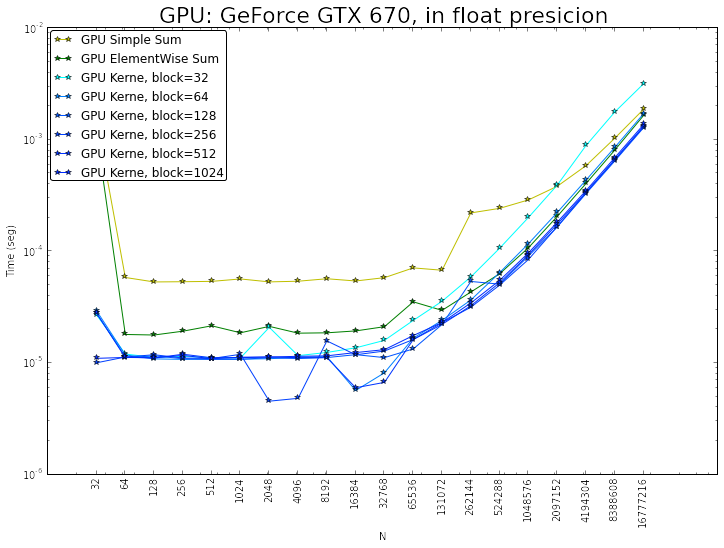
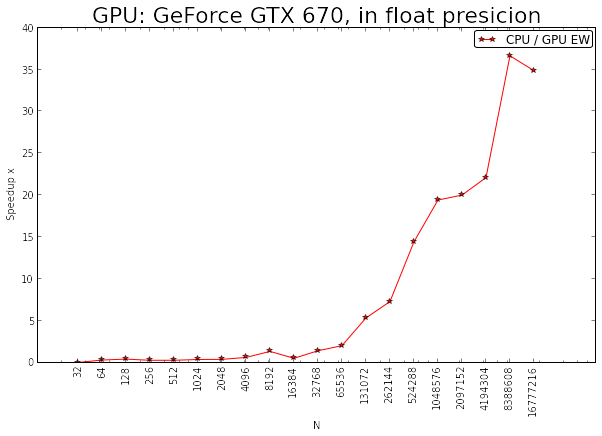

In [58]:
%%HTML
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtQAAAIkCAYAAAA+v7zpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3Xlczdn/B/DXua1X61WKlttCKIaytSgqJE1ZChWimIx1jCVpSDHGNpmFMRnfQcZS1kEMsiWyxciQrdCiEiW0L/d+fn/4fe7crnvbieY8H4/zeHTv53zO53y22/tz7rnnEIZhQFEURVEURVFU43BaugIURVEURVEU9SmjATVFURRFURRFNQENqCmKoiiKoiiqCWhATVEURVEURVFNQANqiqIoiqIoimoCGlBTFEVRFEVRVBPQgJr6qMTFxbkEBARs69KlywMNDY3XSkpKFTo6Os/79++fuHDhwrVJSUl9pa1nbGyczuFwhOKJy+WWmZiYPJk0adL2W7du9ZS1zvnz5wfWVidHR8d4Docj3L59+6Tm2k9WZWWl4tatWyePGjXqTz6fn9mmTZvSNm3alBoaGmYNHTr05Nq1axdmZmbym2t7/v7+UZLHSTLNnTv3x+ba3qdAKBRy9u3bN8bX1zfa1NT0sZqaWpGysnJ5hw4dcp2cnM6Fh4eH37t3z5zNL+1aqys5OTmdA4BvvvlmJYfDEdrY2FwRCoVSP3/Lysq4Xbp0ecDhcIQRERELGro/hYWFvNDQ0G979Ojxj5qaWpG6uvqbrl273vf3948S3w8AiIqK8q9P/eXk5ASyjt3GjRtn9unT57qqqmqxpqbmqwEDBiTExMT4NLTedWHr0tzlynLhwgWHIUOGnOLxeIXsto8cOTK8JepC1RQeHh7O4XCEy5YtC2tKOenp6cYcDkdoYmLypLnqRv13ybd0BSgKAPLy8nR9fHxi2OC2U6dOac7OzmdVVVWLCwoKtP7+++9ely9fto2IiFgwYcKEnX/88cdEaeW4urqeaN++/TMAePnyZdtr167127Fjh190dLTvjh07/Ly9vfeI5yeEMISQeg3GXt989XX16lVrb2/vPZmZmXx5eflqS0vLZBsbmyvy8vLVubm5HRITE/ufOnVqyJIlS1b88ssvs6ZOnbq5ubZtaWmZbGlpmSxtmbW19dXm2s7HLjU11Wz06NH7b9++/RmHwxF269YtxcrK6iaXyy17/vy5TlJSUt/z588P/Pbbb0O/+eabld9++23omDFj9hUUFGiJl1NUVKR24MABL+DtQ4vkdrp27XofeBsIxMbGely7dq3f999/HxQcHLxGMu8333yzMjU11czW1vby/Pnz1zVkf27cuNHbzc3trxcvXrQzNTV9PGzYsONCoZDz6NGjjjt37pzg4uISZ25ufo/Nb2ZmliqtvqwzZ84MysrKMnR2dj4ruUwgEMh5enoejI2N9dDQ0Hjt6up6oqKiQun06dODx40bt/vKlSs2P/3009cNqX9dmvselCU7O1vfw8MjtqioSG3AgAEJRkZGGRwOR8jn8zM/dF1kcXR0jE9ISBhw7tw5p4EDB55vybp8aOzndnOdg5Y+l1QrwTAMTTS1aCooKGhramr6iBAidHBwSLh161YPafkSExPthg8ffrhv377XJJcZGRmlE0KE58+fHyD+fllZmfKECRN2EEKEGhoar16+fMmrax3JNHDgwHhCiHD79u0Tm2ufr1y5Yq2kpFROCBEGBgZufvbsma5knsrKSoU9e/aM7dmzZ3JQUNDa5tjupEmTogghwmXLli1t6fPe0unRo0embdu2LSCECEeOHPnn48ePTSTzCAQCzvHjx10dHBwSxowZs1dWWenp6UaEECGHwxHUtd3r16/3lpeXr1JWVi5LSUmxEF924cIFew6HI1BRUSl++PChWUP2Jzs7W69t27YFysrKZTt27JgguTwnJ6dDZmamYX3LKy8vV+LxeC8JIcLo6GgfyeURERHzCSHC7t27337+/Hk79v3U1NRO7du3zyWECA8fPjy8uc7XgwcPOj948KDzh7g2tm7dGkAIEU6YMGGHtOX1PdfvMw0cODCew+EI6vr8ao0pPz9f68GDB50LCgraNqWcqqoq+QcPHnSWdu/TRFNDU4tXgCaavL29Y9hguqqqSr6u/ElJSX0k36stOC4qKlJVUVEplgwMWiqgLi8vV+Lz+RmEEGFwcPDquvJXVVXJJycn92yObdOA+t9kbW19hRAi9PHxia5PfmnXHZuePHli3JAga/HixSsIIcK+ffteEwgEHIZhUFJS0qZjx45phBDhjz/++HVD98fHxyeaECL84Ycf5jbH8dm9e7cvIUTYtm3bgoqKCkXxZdXV1XI6Ojp5HA5HcOHCBXvJdbdv3z6RECLs16/f1ZY+z41Jy5YtW0oIEYaHh4dJW/6xBNSEEGF8fPzAlj5eNNFEEw2oaWrh9PDhQzMOhyPgcDiCO3fudGtsOXUFx1ZWVn8TQoRr1qxZWN912NTcAfXvv/8+hRAi1NfXf1qfB4jaUmZmpuFXX331c+fOnR8oKyuXqaurv+7fv//FqKioSdLyNyagfvHihfbChQvXdOnS5T67DRsbm8u//vrr9OrqajnJ/Nu2bfMnhAj9/f235efna82ePXu9sbHxE0VFxYqRI0f+yeYTCoVkz549Y11dXY+3a9fuuaKiYoW+vv5TZ2fnMxs2bJglrS4nTpwY6uHhcURHRydPQUGhskOHDjm+vr67b9++3b0hx+306dODCCHCNm3alDS1lYthGh5QV1ZWKnz22Wf/EEKEK1euDGEYBrNmzdrAPlg2dPu5ubnt5eXlq1RVVYtKS0u5zXGdDh48+BQhRDh79uz1kssuXLhgTwgR8vn8DGnrlpaWchUUFCo5HI4gOztbrznqQwgREkKEku+z93F6erpRXFzcEGdn5zPq6uqvuVxuqY2NzeUjR4541Hcb7LUrLTk6Op4Tr4usc93Q+6Wqqkr+jz/+8PPx8Ynu3LnzA1VV1SIul1tqbm5+Nzg4eLX4t2oMw+DcuXOOsupY3wCbLcPR0fFcSUlJm+Dg4NUmJiaPFRUVKwwMDLJmz569Xtp9Ib5eaWkpd/HixSvY/bS0tLwpnreh9+rVq1f7jR49ep+enl62vLx8lYaGxqtOnTqljhs3btfZs2edxPOGhYWF1/bAc/fuXfPAwMDNHTt2TFNWVi7j8Xgve/TocWvBggXfZ2Rk8CXvW2Nj4yfSyklPTzeaPn36r+yx4fF4L52cnM7u3r3bV1p+8Xo9e/ZMd+rUqb/p6+s/VVRUrDA2Nn6yaNGiVeXl5UrNcT/Q9PGlFq8ATf/t9OOPP35NCBFaWVn93ZRy6gqO2Za/n376aU5912GTrICa/TAmhAjFP6TrSiNGjDhECBHOnTv3h6bs89mzZ500NDReEUKEnTt3fuDp6XnAxcXlpJqa2htCiHDixInbJddpaECdmpraydDQMJMQItTT08v29vaO8fDwOMK2+A8ZMiROsvWSDUrc3d1jTUxMHmtra78YNWrUwbFjx+6ZPn36rwzDoKKiQnH48OGHCSFCBQWFSgcHh4Tx48fvHDx48CldXd1n0oKVr7766mdCiFBRUbGif//+F729vWN69ep1gxAi5HK5pX/99dew+h67OXPm/EQIEY4aNepgc1zHDQ2oGYbBjRs3eikoKFQqKSmVb9iwYRYhRKiqqlqUlpbWsaHbZ1uT2WA8Pj5+4MKFC9dMnTr1txUrViyW1Y1KVsrIyOCzD7rSvh1Zv379bEKI0MvLa7+sMiwtLW8SQoTHjh1za45jLOv4GhkZpXM4HMGSJUu+5XA4Ahsbm8vjxo3b1bt37+vsOvv37/eqzzYuXrzY39/ffxtbdysrq78DAgK2BgQEbBV/GJdVl8bcL1lZWQaEEKGWllZ+//79L/r4+ES7ubkda9eu3XNCiLBjx45p+fn5Wmz++/fvd/H399/GdqsZNmzYX2wdAwICttanWwwbGNvZ2SVaW1tfUVVVLRoxYsShMWPG7GW327lz5wd5eXk60tazsbG53Ldv32tqampv3N3dY318fKI9PT0PNPZejYuLG6KgoFBJCBH27t37ure3d4ynp+eBvn37XlNUVKxgPzfYxAau0j7Htm/fPlFRUbGCECLs1KlTqre3d8yoUaMOdu/e/TaHwxGIf46z962JicljyXIuX75so6mpWcieA19f390uLi4n2bKlfb6y9ZoyZcrv+vr6Tw0MDLLGjh27x9XV9Th7DQwfPvxwc9wPNH18qcUrQNN/O7H9mwMDAzc3pZzaguObN29assGBeOtNcwXUHA5H0JCA2sDAIIsQIty1a9e4xu5vTk5OBx6P91JBQaHyjz/+8BNflpWVZcC2yEu2VLMBtayWHcnUt2/fa4QQobe3d4x4IJCVlWXQpUuX+4QQYUhIyErxdcRb+VxdXY8XFxerSJbLBrRdu3a9JxkACAQCTmxsrLv4e5GRkdMIIcLPPvvsH8n8hw4dGqGgoFDJ4/FeFhYWatZnv+zt7S8QQoTffffdN81xHTcmoGYYBqGhocvFWxfXr18/uzHbDwkJWckGuGwXKsk0bdq0SLZ7SV0pPDw8jA1upC2fO3fuD4QQ4bx589bJKoN9YNq4ceOM5jjGtQXUhBChkpJS+cmTJ13El61YsWIxIURoZmb2sCHbqi1gq60ujblfioqKVI8ePfq5ZOt1WVmZ8uTJk7cQQoSSASXD/Pu51Jg+1OKt3F27dr2Xk5PTQbw+7LcTY8eO3SNrvV69et0Q7zvPpsbcq05OTmcJIcKYmBhvyfIKCgra3rhxo1d9zs+1a9f6ysvLVykoKFRu3bo1QLKs+/fvd7l3715X9rWsgLqsrEyZfTCaN2/eOqFQSNhld+7c6aarq/uMECL87bffpkqrFyFEOHXq1N/Ev4G8d+9eV7axIzEx0a457gmaPq7U4hWg6b+dXF1djxNChN9888130pafPHnSZdKkSVHiyd/ff1t6erqReD72n6p4wPzy5Uve4cOHh5uYmDxm/wFIW6exAXV2drZe165d75mbm98V/4dUV1JWVi7jcDiCuLi4IdKW//zzz19J7vO0adMixfMsXLhwDSFEuGjRolXSyrh+/XpvaQERG1DLSuJffSYkJDgQ8vbHnNIC1RMnTgwlhAjV1dVfi3+NyQbUSkpK5dIeNPLy8nQUFRUr5OXlq+7evWte1/Gqrq6W69ChQw6HwxGI/zMUT2x3CVldRSRT165d7xFChJs3bw6UtnzXrl3jpF130h4OGKbxAfXLly95bMtcz549kxt7H3355Zeb2BZBBQWFytWrVwc/ffpUv6CgoO0ff/zhx/64MCwsLLyusoRCITE2Nn5CCBH++uuv06XlCQwM3EwIEYaGhi6XVc64ceN2EUKEq1evDm7sfomnugJqaT/craysVNDQ0HjF4XAEDflBZmMC6sbeL7WlkpKSNvLy8lW6urrPJJc1R0DN4XAE0r5BSEtL6ygnJ1ctLy9flZWVZSBtvcuXL9tIrtfYe9XCwiKFw+EIXr16pdGU88N++yf50CIryQqo//jjDz9CiNDU1PSRtG46mzZt+lLagxpbLyMjo3Rp53jGjBkbCSHC5cuXhzbHPUHTx5XosHnUR+3evXvmf/zxx0Ty/8MaMQxDAGD27NkbjIyMMiTzs+P9Surdu/eNgwcPejZn3fT09HIkx/VtDufOnXM6fPjwCEIIw+6viopKSWRk5HQ2z19//eUGAKNHj94vrYxevXr9raKiUnLr1q2elZWVioqKipXiy2UNm6etrZ3P/s0OYejh4RGrqan5SjLv0KFDT7Zv3/5ZXl6e7o0bN3rb2dldkqyD+DBjrLNnzzpXVVUp2NvbXxQfwk2W5ORky2fPnrXv3r37HXb4OUkDBgxI2Lhx48wrV67YzJo165e6yqxLUlJSX2nX3bp16+arqKiUNLV81tKlS5dXV1fLA8Ddu3ctkpOTLWUNZ1gbdkzrqqoqhdDQ0G/Fh+Pz8/PboaKiUjJ69Oj969atmx8UFPR9bftw5syZQRkZGUZcLrds3LhxuxuzXy3B3d39qOR7CgoKVaampo+Tk5Mtc3NzOxgaGma9r+039X65efOm1ZkzZwalp6cbl5SUqLDXnJKSUsWLFy/avX79WkNDQ+N1c9ZZU1PzlZub21+S73fs2PGRjY3NlUuXLtklJCQMkLwOdHV182xsbK5IrtfYe9Xa2vrqvXv3zMeNG7d78eLF31lbW1+VNfa5LAKBQO7UqVNDCCHMF1988XtD1pXEnstx48btllYPf3//qOnTp0c+evSoY05Ojp6enl6O+HJnZ+ezSkpKFZLrdenS5QEA5ObmdmhK/aiPEw2oqRbFBnAvXrxoJ235nDlzfp4zZ87P7GtjY+P0rKwsQ1nliY9DraSkVKGnp5fj4OBwwdHRMV4yr2SwJAu7nDTTWKXa2tr52dnZ+rL2+c8//xzF/p2RkWFkYmLyRHLbjx8/NgWAvn37JtW2LUIIU1BQoNWhQ4dc8fdHjhx5aOnSpctrWzc7O1sfAGqb9MDU1PTxs2fP2ufk5OhJLpP2wAO83Sfg37GZ68Lu6507d7rXNZmGrGMqSVtbO//BgwddZOX/8ccf5/74449z2dccDkfYXOefFR8f77hx48aZqqqqxb6+vtH/+9//AgMCArYlJSX1lZeXr25IWWpqakXA2/MdGBj4P8nlnp6eB7W0tArYsdllPXgCwNatWycDwKhRo/6UFcCpqqoWA0BJSYmKrHKKi4tVxev2PhFCGGkPbwCgrq7+BgDKy8uV32cdGnu/FBcXq44fP35XbGysh2R+9qGaEMK8efNGvbkDamNj4/Tall26dMmO3S9xsu7txt6rq1atCrl161bP48ePDzt+/PiwNm3alPbu3fvGoEGDzvj5+e2oz8Qr+fn52mVlZVz2Iaqu/LWp61yy/1tyc3M7SAuoW/papFoGDaipFtW7d+8bu3btGi9rBsSGWrRo0eoBAwYk1CdvmzZtSoHagwLg38CADSKaqnfv3jeys7P1k5KS+tbVAigr2BcIBHIA4OPjE6OsrFxeWxmSrdMN1dhAksvlljVHeey+6uvrZw8ZMuRUbXnrG6T37t37RmJiYv/muu4aqqSkRGXy5MlbAWDNmjXBgYGB/7t69ar1rVu3en733XeLw8LCljWkPDaAkJeXrzYwMHgqLY+JicmTgoICrby8PF1Z5bx69Urzzz//HEUIYaZMmbJFVj42EGMfjqRhH3xrC9qa08cyc2FDr++QkJBVsbGxHt26dUtZvXr1oj59+lzX1tbOZ1tG9fT0cvLy8nTrevD/kGTd2429V3V1dfOuX7/eJz4+3vHUqVNDEhMT+1+7dq3fhQsXHFasWLHkt99++zIgIGBbbeU19wNvU8r8WK5F6sOiATXVoj7//PNj8+bN++Gff/7pkZKS0q1bt24pH2rbfD4/8969e+apqalmsvIwDEMePXrUkRDCNNfXxR4eHrFHjhwZvnfv3rHff/99UENbIwHA0NAw6/Hjx6ahoaHf1qfbRGOwgdmjR486ysrDtkjp6+tn17dctnXr/v37XeuTn23t0dPTy2FbT5vKw8Mjdv369V/FxcW5FBQUaGlpaRU0R7n1tXDhwrXp6enGTk5O56ZPnx4JANu2bQuwtra+unLlym88PT0PfvbZZ7frW16vXr3+BoDq6mp5WV0D8vPztYHaHwx37949rqKiQsnU1PRxba3YvXv3vgG87RojbXlpaWmbO3fudCeEMFZWVjfrux+fssbeL/v27RtDCGH27NnjbWFhcVc8f0lJicqzZ8/av49gEXg79XZdyxpybzflXiWEME5OTufY6660tLTNL7/8MmvRokWrZ86cuXH06NH7a/u2Q0tLq4DL5ZaVl5crP3782LQprdTsPss6l+Xl5co5OTl6hBCmIceHat04LV0B6r/NzMwsdcyYMfsYhiHTpk3bVFVVpVDXOs3VUsNOp8xOGS3NqVOnhrx580ZdU1PzVXMFBn5+fjsMDAye5ubmdli8ePF3jSnDzc3tL4ZhyN69e8c2R52kYaczjo2N9Xj16pWm5PKTJ08OffbsWXs1NbUiNsCqD2dn57MKCgpVly5dsqtPUN2vX79rWlpaBX///Xev2oKVhhg0aNCZvn37JpWVlXFnzpy5sTnKrK+zZ886R0ZGTldVVS0WDzqsrKxuBgcHr6mqqlIICAjYxrb21YeNjc2VDh065DIMQ86cOTNIcnlaWlqnjIwMI0II06dPn+uyytmyZcsUAKirNdDW1vZyu3btXmRlZRleuHDBQXL5vn37xlRXV8v37ds3SbK7UWvV2Pvl5cuXbYF/A3Jxu3fvHidre+w3T2wf/MYoLCzkHT9+fJjk+48ePep45coVGw6HI6zvN35A896rbdq0KV24cOFafX397IqKCqWHDx92ri2/nJycYMiQIacYhiG///77F03ZNttFMDo62lfafbh9+/ZJANCpU6e0/8r1TdWNBtRUi/v1119nGBsbpycmJvYfNGjQmVu3bvWUlu/27dufvXnzRl1Wa01DW3GmTJmypW3bti8vXrxo/+2334ayP+xi3b9/vyvbejhnzpyfJX+ckp2drd+1a9f75ubm96T1IZZFUVGxcs+ePd6KioqV33//fdDUqVM3P3v2rL1kPoZhyKVLl+yklREUFPS9urr6m5UrV37z66+/zpD2oZ+SktJNvD92Q9nb21/s27dvUlFRkdrMmTM3VlZWKrLLsrOz9b/++uufAGDWrFm/NKRbSbt27V5MmzZtk1Ao5Hh5eR2Q/IZAIBDIifcnlZeXrw4NDf1WIBDIjRw58pC0VtHKykrFI0eODH/w4EGX+tZj9+7d43g8XuHevXvHjho16k9ZAcDFixft61tmXYqLi1XZrhRr165dKNkXdenSpcu7deuW8vfff/davXr1ovqWSwhhQkJCVgFvW7/F96WwsJAXGBj4P4ZhiKen50H2NwaS/vnnnx43b960kpOTE/j7+0fVtj0OhyNcuHDhWgCYPn16pHh/2NTUVLNFixatJoQw0h4Yw8PDwzkcjrC2FvBPUWPvF3Nz83sMw5Bff/11hnh5169f78OeU2nYAPzu3bsWTan3/Pnz14l//hQXF6vOmDHjV6FQyBk1atSfsroQSdPYezUiImLB06dPDSTzXr9+vU9ubm4HDocjrM83hIsXL/5OTk5OEBERsYANesXdv3+/a30+I8aMGbPP0NAw68mTJyYhISGrxBtx7t69a8F2yVqwYEFEXWVR/yEtPcwITTQxzNuZ3hwcHBLY4dvMzMwejhgx4tCECRN2jBw58k92DFdCiHDQoEGnxSc6YJj6D4EnmcQnR9HX1386cuTIP8eNG7erf//+F+Xk5KrZsX2ljd/b2Ild2HTp0iVbdqxTeXn5qt69e1/38vLaP2HChB3Dhg37i524QUFBoXLGjBkbJdc/d+6co5aWVj75/0kkBg8efGrcuHG73NzcjrHl+vr67hZfp6ETu6SlpXUUn6hi7Nixe9zd3WPFJ6qorKxUEF+HHTYvICBgq6xyKyoqFD///POj7P45ODgk+Pr67h40aNBpdkpryXXmzZu3jj3ePXr0uDVq1KiD3t7eMfb29hfY+kiOQ1xXun//fpfu3bvfZocC++yzz/4ZNWrUwQkTJuzw8PA4wl5XHA5HMHr06H2Sk3JIXgt1DZs3bdq0SPYalpWHHUtXSUmpPCUlxaK++yIUCgk7BrWKikrxoEGDTru7u8ey10j37t1v1zYrJDsZh5ub27H6bE8gEHDYsaY1NDRejRo16qC7u3ssOyzknDlzfpK2Hjv2touLy8mGnKu6hs2TdQ82Zni5xo5D3Zj7Zf/+/V7sdd2zZ89kHx+f6AEDBpyXk5OrnjBhwg52CEPJ/Tty5IgHIUSorKxc5uHhcWTKlCm/T5ky5ffGTOyipqb2ZsSIEYdGjx69j53YxczM7KGsiV2cnJzO1lZ+Q+9V9jPYwsIixdPT84Cvr+9ue3v7C+z8AZLDqtZ2frZu3RrADkXZqVOn1DFjxuwdMWLEoW7dut2RHP60toldrly5Ys0ON9mpU6dUHx+faBcXl5PsDKCTJk2Kauh1U5/PRpo+3dTiFagtHTp0aERgYOBmb2/vGFlj9tLUutLx48ddJ02aFNW5c+cHampqb5SUlMp1dHTy7OzsEufPnx9x9erVftLWMzY2fsLhcASNGZM1KyvLYMGCBd/36NHjFrtNPT29bHd399h9+/aNlrVeYyd2EU8VFRWKv//++5QRI0YcMjQ0zORyuaVcLrfUwMAgy8XF5eTKlStDJMfcFk/Pnj3TXbx48QpLS8ubampqb7hcbqmJicljJyens2vWrFn4+PFjE/H8/v7+2zgcjqAhU4/n5+drNWQq5aioqEn1+achFArJzp07xw8aNOh027ZtC5SUlMoNDQ0zXVxcTkZGRk6Ttk5CQoKDr6/vbj6fn8FOKWxhYZHi6+u7Ozo62qekpKRNQ8+BQCDg7NmzZ6y3t3eMiYnJYxUVlWJlZeWy9u3b5zo6Op5bsmTJt3WNl12fgPr06dODOByOQE1N7U1t55RhGAQHB68mhAj79et3tb6TsbBpy5Ytk21tbS+pq6u/btOmTUmPHj1uLV++PLS2Y1NRUaGora39oiGzCrLn8JdffpnZu3fv6yoqKsUaGhqvHBwcEqKjo31krcM+SO3Zs2dsQ/ZL1vFl731Z96Cjo+O5hn42hIeHh9V2n9R2rht6vzDM25ktnZ2dz2hra79QU1N706tXrxu//PLLTHZMcFn7FxkZOc3S0vImG6TWdz/FA+PS0lLuggULvjcxMXmsrKxcZmhomClr6vH4+PiB9QmoGaZh9+quXbvGBQQEbO3evfvttm3bFrRp06akY8eOaaNGjTp46tSpwQ09P7dv3+4eEBCw1cjIKF1ZWblMS0sr38rK6u/g4ODV4uNq1xZQM8zbGUPZqceVlJTKeTzeS0dHx3Oyph6vq171/Wyk6dNMhGHey28dmtWrV680FyxYENHUflEURVFUy6mqqlJo27btS3Nz83vXrl3r19L1+a+Kj493dHZ2Puvo6Bh/9uwVI3ixAAAgAElEQVRZ55auD0W1Bp9EH+oVK1YsaY7JGiiKoqiWc/nyZdvS0tI2DekfTlEU9Sn4IAH15MmTt+rq6uZJDgN14sQJ165du943MzNLXbNmTTAA7Nixw2/u3Lk/5uTk6DEMQ4KDg9cMGzbseGNmD6MoiqI+HgMGDEgQCARy7Ag7FEVRrcUHCagDAgK2nThxwlX8PYFAIDdr1qxfTpw44Xr37l2L6Oho33v37pn7+fnt+PHHH+fq6enlbNiwYfaZM2cG7d+/f/Rvv/325YeoK0VRFEW1Zu9rXGuK+k/7UJ21nzx5Yty9e/fb7OtLly7ZDh069AT7etWqVYtWrVq1qCFlAmBoookmmmiiiSaaaKLpQyRZMWmL9aHOzs7WFx9X0sDA4Gl2drZ+Q8v50L/iDAsL++DlNcc22TLqW1Zz7mdLlNVc22xIObLyNrQuLXGO6ru9T3GbjTn+H3o/61PPT/2z50Nu832U1xyfBe+z3tLyv6/PnvdxnuqzrU9tm409/h/b58/HVp/3ffxrS7VpsYD6U/3KydHR8ZPcZkPLaIn9rI8PXS967P9Fr/2WRY9/y6KfPS2HXvstix7/+mn0lKVNpa+vn52VlWXIvs7KyjJsyIxM0sTExGDx4sVIT0+HUChseiU/kGXLlrXq7dFtyiYvL49Bgwbh8OHDUFJSAvBxf6jGx8d/cttszIfqh97P+qD/1FoWDahbDr32WxY9/vXTYi3Uffr0uZ6ammqWnp5uXFlZqbhnzx7v4cOHH2lseTExMZg7dy527NiBsrKyD/71BE00NSa9efMGSkpKWL58eYOv+U/1Q45u8+PY5n9hH+k2W8/26DZb3zZbmw8ysYuvr2/0+fPnBxYUFGjp6Og8X758+dKAgIBtx48fH/b111//JBAI5KZMmbIlJCRkVUPKJYQwYWFhcHR0xJQpU7Bjxw7Y2dm9r92gqPfi0aNHsLe3R25ubktXhaIoiqIoCfHx8YiPj8eyZcvAMAyRlueTmClRFkIIw9ZfTk4OZWVlUFRUbOFaUVTDVFdXQ0lJCQKBoKWrQlEURVGUDIQQmQH1JzFTYn0IhUIaTItZtWoVAgMD30vZjo6O2LJly3sp+79IXl7+k+rzT1EURVFUTa0moP4YxMTEwNraGqqqqtDV1YWNjQ0iIyNFy/39/aGkpAQ1NTVoaWnBxcUFDx48EC0LDQ2tUV56ejo4HI7MYOvw4cOwtLSEhoYG2rVrh0GDBiE9PR0AEBISgv/973/vZT8JISBE6gNanbZs2QJzc3Ooq6ujffv2+Pzzz1FcXNzMNaQoiqIoivpwWn1AzTAMVq4MQX26tjQkr6R169bh66+/RnBwMPLy8pCXl4dNmzYhMTERVVVVAN4GosHBwSgqKsLTp0+ho6MDf39/0bKGBKlpaWmYNGkSfvzxR7x+/RpPnjzBzJkzIScn1+C6fyjnz5/H4sWLERMTgzdv3uDevXvw8fFp6WpRFEVRFEU1SasPqP/66wD++Wcjjh8/2Kx5xb1+/RphYWGIjIyEp6cnVFRUAACWlpbYuXMnFBQU3lmHy+XC19cXd+7cAfDvBDX1lZycDBMTEzg5OQEAVFVV4enpCUPDtyMRhoeHw8/PD8C/Ld1RUVHg8/nQ0tLCpk2bkJSUhB49eoDH42H27NmisqOiotC/f3/Mnj0bmpqaMDc3x9mzZ2XWZevWrbCwsEDbtm3h6uqKzMxMqfmSkpJga2uLnj17AgB4PB78/PygqqoK4N2uJFFRUXBwcBC95nA4iIyMhJmZGdTV1bF06VI8evQItra20NTUhI+Pj+jhhaIoiqIo6kP55APq8PBwqWPGbt++GYMHd8Phw9/gyy+LcOhQCAYP7obt2zc3Ka80ly9fRkVFBUaMGFFnXjZoLi4uxq5du9CrVy8AaHAXit69e+P+/fuYN28e4uPj3+k2Ia28a9euIS0tDTExMZgzZw5WrlyJs2fPIiUlBXv37kVCQkKNvJ06dUJBQQGWLVsGT09PvHr16p0yDx8+jFWrVuHPP/9Efn4+HBwc4OvrK7XONjY2OHnyJMLDw5GYmIiKiop36lzXcYiLi8PNmzdx5coVrFmzBoGBgYiOjkZmZiZu376N6OjoWtenKIqiKIpqiPj4eISHh9eap1UE1NLGT5w4MRBffx2O6upyEAKUlKTCxeUu+PwvER9PaiQ+/0sMGXIXJSWpIASori7H3LnLMHFi/X7Ul5+fD21tbXA4/x5OOzs78Hg8tGnTBhcvXgTwNpiOiIgAj8eDmZkZSktLERUV1aj9NjExQXx8PLKzszF27Fi0a9cOAQEBKCkpEW1LUmhoKBQVFTFkyBCoqalh3Lhx0NbWhp6eHhwcHHDz5k1RXh0dHcyZMwdycnIYO3YsunTpgqNHj75T5qZNmxASEoIuXbqAw+EgJCQEycnJyMrKeievvb09Dh48iL///hvu7u7Q1tbG/PnzG/SDvIULF0JVVRUWFhb47LPPMGzYMBgbG0NdXR3Dhg2rsQ8URVEURVFN5ejo2PoDalnY1s7S0leIirKAQKCG7t33w8mJgaNjzeTkxKB7930QCNQQFWWB0tJXDerTrKWlhfz8/BqB4aVLl1BYWAgtLS3R+4QQBAUFobCwELm5uTh06BBMTEwAvB3pQbK7QlVVFTgcTo1AXZy1tTX27NmD58+f48KFC0hISMB3330ns566urqiv7lc7juv2WAcAPT19Wusa2RkJHWc5IyMDMyZMwc8Hg88Hg9aWloAgOzsbKl1cHV1xZEjR1BYWIjDhw8jKioKv//+u8w6N3Qf6A8cKYqiKIr60FptQA0AGRlpmDhxG7Ztu4OJE7chIyO1WfJKsrW1hZKSEg4dOlRnXln9pPl8vmiEDtaTJ09EfaLr0qdPH4waNQopKSn1yl8XyYA4IyMDenp67+Tj8/nYvHkzCgsLRamkpAQ2NjZ1bsPZ2RnOzs6iOquoqNQI6p89e9bEvaAoiqIoinr/WnVAPWPGIri5eYEQAjc3L0yfvqhZ8krS1NREWFgYZsyYgQMHDqCoqAhCoRDJyck1AsTafnTo5eWFY8eO4dSpUxAIBMjJycGKFStk9kdOTEzE77//jhcvXgAA7t+/j9jY2HoFsrKI1+/58+dYv349qqqqsG/fPty/fx9ubm7vrDNt2jSsXLkSd+/eBfD2B5r79u2TWv6RI0ewZ88eFBYWgmEYXLt2DefPnxfV2dLSEgcPHkRZWRnS0tLqNda1eJ0/5UmKKIqiKIr6dMm3dAVai6CgIOjr62Pt2rWYOHEiVFRUYGpqirVr18LW1hZA7T+6s7CwQHR0NEJCQpCWlgZNTU14e3sjLCxMan5NTU0cOXIES5YsQUlJCbS1teHj44OFCxdK3VZ9uq+I57G2tkZqairatWuH9u3b48CBA+DxeO+sM3LkSBQXF8PHxwcZGRnQ0NCAi4sLxowZ805eHo+H9evXY9asWaioqECHDh2wcOFC0UPD3LlzkZSUBF1dXfTs2RMTJkzAmTNnat0HyX1s7PjYFEVRFEVRjfXJTz0eFhYGR0dHODk50RbKZhIVFYUtW7bgwoULLV2V/4z/n860patBURRFUZSE+Ph4xMfHY9myZTKnHv/kA2q2/jQgaT40oP7w6PVLURRFUR+3//9fLTWgbtV9qKnGoV0nKIqiKIqi6o+2UFPUR4BevxRFURT1caMt1BRFURRFURT1ntCAmqIoiqIoiqKagAbUFEVRFEVRFNUENKCmKIqiKIqiqCb45Cd2CQ8Ph6OjY0tXg6IoiqIoimqF2HGoa0NH+WilwsPD8ejRI+zYsaOlq9Kspk+fDn19fSxZsqSlq9Ks6PVLURRFUR83OsrHBxITEwNra2uoqqpCV1cXNjY2iIyMFC339/eHkpIS1NTUoKWlBRcXFzx48EC0LDQ0tEZ56enp4HA4EAqFUrfH4XCgqqoKNTU1UYqIiHh/O9gMOBwOHj9+LHrdpUsX7N27V/Q6MTERHA7nnffU1dUhFAoRGRnZ7MH006dP4eXlhXbt2kFTUxOfffYZtm/f3qzboCiKoiiq9Wr1ATXDMAhZFlKv1r+G5JW0bt06fP311wgODkZeXh7y8vKwadMmJCYmoqqqCsDbJ5vg4GAUFRXh6dOn0NHRgb+/v2hZYyZT+eeff1BUVCRKCxYsaHAZH5r48R04cCASEhJErxMSEtC1a9d33rOzswOH834uVz8/PxgZGSEzMxMvX77Ejh07oKur+162RVEURVFU69PqA+oDsQew8dxGHDx6sFnzinv9+jXCwsIQGRkJT09PqKioAAAsLS2xc+dOKCgovLMOl8uFr68v7ty5A+BtkPk+v/K/cuUK7OzswOPxYGlpifPnz4uWOTo6IjQ0FP3794eamhqGDx+O/Px8jB8/HhoaGujXrx8yMjJE+e/fv48hQ4ZAS0sLXbt2xb59+0TL/P39MXPmTLi7u0NdXR02NjaiFukBAwYAAHr27Ak1NTXs3bsXAwYMqBE8X7x4EcHBwTXeu3Dhgmhd8Zb8/Px8uLu7g8fjQUtLCwMGDBAdw5ycHHh5eUFHRwempqbYsGGDzGNz/fp1+Pv7g8vlgsPhwNLSEq6urgDe9psyNDSskd/Y2Bhnz54F8LZrzZgxY+Dn5wd1dXX06NEDqampWLVqFXR1dWFkZIRTp07V9zRRFEVRFPUJarUB9eZtm9HNvhu+2fYNihyLELI1BN3su2Hzts1NyivN5cuXUVFRgREjRtSZlw34iouLsWvXLvTq1QsAGj3Vd32C8OzsbLi7u2Pp0qUoLCxEREQEvLy8UFBQIMqzZ88e7Ny5E9nZ2Xj06BFsbW0xZcoUvHz5Eubm5li2bBkAoKSkBEOGDMGECRPw4sULxMTEYMaMGbh3716NssLDw1FYWIhOnTph8eLFACAKktlW9bFjx8LBwQEpKSl49eoVhEIhrl+/Dm9vb7x69Ur03qVLl0QBtXhL/rp162BoaIj8/Hw8f/4cq1atAiEEQqEQHh4esLKyQk5ODs6cOYOffvoJcXFxUo+PjY0NZsyYgT179iAzM7PO4yl5ro4ePYqJEyeisLAQVlZWGDJkCIC3QX1oaCi+/PLLOsukKIqiKOrT1WoD6kD/QIQHhaO8qhwgQGp+Ku6a3MWXGV+CLCM10pcZX+Ku8V2k5qcCBCivKseyhcsQ6B9Yr23l5+dDW1u7RpcEtjW4TZs2uHjxIoC3wW9ERAR4PB7MzMxQWlqKqKioJu1nr169wOPxRElaa+jOnTvh5uYmanUdPHgw+vTpg2PHjgF4GyAGBATAxMQE6urqGDZsGDp37gxnZ2fIyclhzJgxuHnzJoC3waOJiQkmTZokas319PSs0Urt6emJPn36QE5ODuPHj0dycrLM+hsZGYHP5yMhIQG3bt2CmZkZlJWV0b9/f9F7lZWVsLa2fmddRUVF5ObmIj09HXJycujfvz8AICkpCfn5+ViyZAnk5eVhYmKCL774AjExMVLrsG/fPjg4OODbb7+FqakprKyscP369Xqegbct70OGDIGcnBxGjx6NgoICLFq0CHJycvD29kZ6ejrevHlT7/IoiqIoivq0fPLD5snCtmS+Kn4FixsWyOJkYdvYbfDy8JKaf/+R/Zj8w2QY3jBEVlFWg/o0a2lpIT8/H0KhUBRUX7p0CQBgaGgo+lEhIQRBQUFYvnz5O2XIy8uL+lqzqqqqwOFwau07fPPmTZiamtZav4yMDOzbtw+xsbGi96qrq+Hs7Cx6Ld5nWFlZGTo6OjVeFxcXi8q6evUqeDxejbImTpwo2kfxsrhcrmhdWdhuH3w+X9QSbW9vL3rP2tq6RrcZtlU+KCgI4eHhcHFxAQBMnToVwcHByMjIQE5OTo06CgQCUdmSNDU1sWrVKqxatQoFBQVYsGABRo4ciadPn9Zab5b4seJyudDW1hZdO1wuF8DbbyTU1dXrVR5FURRFUZ+WVhtQA0DakzRsm78Nnu6eOHj0IFKfpDZLXkm2trZQUlLCoUOH4OnpWWteWV00+Hw+UlJSarz35MmTd/rvNgafz4efnx82b65fF5baHiT4fD4GDhwos/tEYwwYMAC//fYbjIyMMHnyZACAg4MDtm/fDiMjI5mBsKqqKiIiIhAREYGUlBQ4Ozujb9++4PP5MDExwcOHDxtcFy0tLcyfPx/bt29HYWEhVFRUUFpaKlouEAjw4sWLxu0oRVEURVGt0iff5SM8PFzmYNuL5iyCl4cXCCHw8vDCoq8WySynIXklaWpqIiwsDDNmzMCBAwdQVFQEoVCI5ORklJSUiPLV1t/Zy8sLx44dw6lTpyAQCJCTk4MVK1bA19e31m3Xpw/1hAkTEBsbi7i4OAgEApSXlyM+Ph7Z2dlSy6mtzM8//xwPHz7Ezp07UVVVhaqqKiQlJeH+/fv1qo+uri4ePXpU470BAwbg77//RkJCgqjbxmeffYbHjx/j3LlzNQJq8fKPHj2KtLQ0MAwDdXV1yMnJQU5ODv369YOamhrWrl2LsrIyCAQC3LlzR2Y3juDgYKSkpKC6uhpFRUWIjIyEmZkZeDweOnfujPLycvz111+oqqrCihUrUFFRUes+UhRFURTVesTHxyM8PLzWPK0ioP4YZkoMCgrCDz/8gLVr16J9+/Zo3749pk2bhrVr18LW1hZA7UPjWVhYIDo6GiEhIdDS0oKdnR1sbW0RFhZW63bZETPYNG/evHe2ZWBggMOHD2PlypXQ0dEBn8/HunXragSn4vWSVk/2tZqaGuLi4hATEwN9fX106NABISEhqKysrHNd4O35mjRpEng8Hvbv3w8AMDMzg46ODjp06CDqFkEIgbW1NYqKimBnZye1bmlpaRgyZAjU1NRgZ2eHmTNnYuDAgeBwODh69CiSk5NhamqKdu3aYerUqTL7MZeVlWHUqFHg8Xjo2LEjsrKycOTIEQCAhoYGfv31V3zxxRcwMDCAqqpqjW8N6tpfaa8piqIoivp0ODo61hlQ05kSKeojQK9fiqIoivq40ZkSKYqiKIqiKOo9oQE1RVEURVEURTUBDagpiqIoiqIoqgloQE1RFEVRFEVRTUADaoqiKIqiKIpqAhpQUxRFURRFUVQT0ICaoiiKoiiKopqABtQURVEURVEU1QSffEBd29TjVMtLT08Hh8OBUCiUujw8PBx+fn5N2kZUVBQcHByaVAZFURRFUZQ0dOrxDywmJgbW1tZQVVWFrq4ubGxsEBkZKVru7+8PJSUlqKmpQUtLCy4uLnjw4IFoWWhoaI3y6gpGORwOHj9+LHodEREBPT093Lt37z3s3fvxsUzLfe7cOfTo0QM8Hg9t27aFi4sL7t69K1q+YMECdO7cGerq6jA3N8eOHTtasLYURVEURX0o9Zl6/JMPqOvCMAxC1q6t17TODckrad26dfj6668RHByMvLw85OXlYdOmTUhMTERVVRWAt8FjcHAwioqK8PTpU+jo6MDf31+0rCnB5YoVK7B+/XokJCTA3Ny8QesKBIJGb7epPpbptrt164bjx4+jsLAQeXl5sLKywuTJk0XLVVVVcfToUbx58wbbt2/HnDlzcPny5RasMUVRFEVRH4tWH1AfOHkSG3NzcTAurlnzinv9+jXCwsIQGRkJT09PqKioAAAsLS2xc+dOKCgovLMOl8uFr68v7ty5A+BtYNmY4JJhGCxZsgRbt25FQkICOnXqBADIycmBl5cXdHR0YGpqig0bNojWCQ8Px+jRo+Hn5wcNDQ1ERUXB0dERoaGhsLe3h7q6OoYOHYqCggLROleuXIGdnR14PB4sLS1x/vz5BtVzy5Yt0NfXh56eHtatWycz35EjR9CtWzfweDw4OTnh/v37omVZWVnw9PSEjo4OtLW1MXv2bKllBAUFwcHBAW/evKl3/XR0dKCvrw8AEAqF4HA46NChg2h5eHg4OnfuDADo168fHBwcaEBNURRFURSAVhxQb965E93c3fHNhQso+uEHhCQkoJu7Ozbv3NmkvNJcvnwZFRUVGDFiRJ152aC5uLgYu3btQq9evQA0vutDcHAw9u7di4SEBBgbGwN4GxB6eHjAysoKOTk5OHPmDH766SfEiT0oHDlyBGPGjMHr168xfvx4AG+7rERFReH58+eorKxEREQEACA7Oxvu7u5YunQpCgsLERERAS8vL+Tn59e7nvHx8UhLS0NcXBzWrFmDM2fOvJPn4cOHGDduHNavX4/8/Hy4ubnBw8MD1dXVEAgEcHd3h4mJCTIyMpCdnQ1fX98a6zMMg8DAQNy5cwenTp2Curo6Ll68CB6PJzNdunRJtH5mZiZ4PB7atGmDY8eOYcuWLVL3paysDElJSejevXu995+iKIqiqNar1QbUgePHI3zmTJQLhQAhSBUKcXfWLHw5fjwIUCN9OX487s6cidT/z1suFGLZrFkI/P9Asy75+fnQ1tYGh/Pv4WRbc9u0aYOLFy8CeBvwRUREgMfjwczMDKWlpYiKimrSfp4+fRqurq4wMDAQvZeUlIT8/HwsWbIE8vLyMDExwRdffIGYmJga9Rs+fDgAQFlZGYQQBAQEoFOnTlBWVsbYsWORnJwMANi5cyfc3Nzg6uoKABg8eDD69OmDv/76q971DAsLA5fLRffu3REQEIDo6Oh38uzZswfu7u4YNGgQ5OTksGDBApSVlSExMRHXrl1Dbm4uvv/+e3C5XCgpKcHOzk60blVVFXx8fPDq1SvExsZCWVkZAGBvb4/CwkKZSbwMPp+PwsJC5Ofno2fPnggICJC6L9OmTYOlpSVcXFzqvf8URVEURbVe8i1dgfeF7ZP8qrwcFvPmIUsoxDZC4CWtJZgQ7CcEk8vLYfj/eRvSp1lLSwv5+fmirgIARC2fhoaGoh8VEkIQFBSE5cuXv1OGvLy8qK81q6qqChwOp0agLikmJgaTJ09G27ZtRR3mMzIykJOTAx6PJ8onEAgwYMAA0WvxAJzVvn170d9cLhfFxcWi8vbt24fY2FjR8urqajg7O8uslyRDQ0PR33w+H7dv334nT05ODvh8vug1IQSGhobIzs6GgoICjIyMZB6LtLQ0/PPPP7h69Srk5Zt2WfN4PERERKBDhw548+YN1NXVRcuCgoJw9+5dnDt3rknboCiKoiiq9Wi1ATUApGVlYZurKzxdXHAwLg6pWVnNkleSra0tlJSUcOjQIXh6etaaV1Y/aT6fj5SUlBrvPXnypEYgKk3nzp1x+vRpODo6gsvlIjg4GHw+HyYmJnj48KHUdRr6A0g+nw8/Pz9s3ry53utIyszMRJcuXUR/s/2Vxenr69cItBmGQVZWFgwMDKCoqIjMzEwIBALIycm9s665uTlmzpyJYcOG4ezZs6L+zhcuXICbm5vMep04cQL9+/d/5332YUZJSUn0XlhYGE6ePInz589DVVW1/jtPURRFUVSr1mq7fADAosBAeA0dCkIIvIYOxaIvvmiWvJI0NTURFhaGGTNm4MCBAygqKoJQKERycjJKSkpE+Wr70aGXlxeOHTuGU6dOQSAQICcnBytWrHinn7A0FhYWOH36NL7//nv8/PPP6Nu3L9TU1LB27VqUlZVBIBDgzp07uH79eq31kPX+hAkTEBsbi7i4OAgEApSXlyM+Ph7Z2dkA3v5gz8nJqdY6rlixAmVlZUhJSUFUVBS8vb3fyTNmzBgcO3YMZ8+eRVVVFdatWwdlZWXY2dmhb9++6NChAxYtWoTS0lKUl5fX6P8MAD4+Pli5ciUGDx4sGk7QwcEBRUVFMhMbTP/55594+PAhhEIhXrx4gXnz5sHNzU0UUK9atQrR0dE4depUjZZ/iqIoivqUNWWEM+pfrTqg/pCCgoLwww8/YO3atWjfvj3at2+PadOmYe3atbC1tQVQe8uwhYUFoqOjERISAi0tLdjZ2cHW1hZhYWEytyleVo8ePXDy5EksW7YMW7ZswdGjR5GcnAxTU1O0a9cOU6dOFY16Iase4u+J5zEwMMDhw4excuVK6OjogM/nY926daKbLysrC/b29rXWc+DAgejUqRMGDx6MoKAgDB48+J3tdOnSBTt37sTs2bPRrl07HDt2DLGxsZCXl4ecnBxiY2ORlpYGPp8PQ0ND7N27950yJk6ciKVLl8LZ2RmZmZky6yQpOzsbrq6uUFdXR69evcDj8bB9+3bR8sWLFyMrKwudOnWCmpoa1NTUsHr16nqXT1EURVEfo8aOcEbVRD7lJxJCCMPWnxBCn65aiJWVFc6ePUtbbpuAXr8URVHUh7R55078HBODqp49kbpiBcyWLIHCrVuY4+ODqRMmtHT1Pkr//79aastoq+5DTX0YN2/ebOkqUBRFURTVAIHjx4OnpYW5CQkAISgRCvHzrFnwGjq0pav2SaIBNUVRFEVR1H8MIQTFhCC3vBxa8+ahqIEjnFE10YCaoiiKoijqP+Y5gJCsLAx3dcUBFxf82cARzqiaPvmAOjw8HI6Oji1dDYqiKIqiqE/CMwCDAEwNDMQyvJ3kjnb1kC0+Ph7x8fG15qE/SqSojwC9fimKoqgPIQeAM4DxAEJbuC6fGvqjRIqiKIqiqP+4p3gbTE8GsKiF69La0HGoKYqiKIqiWrkMAAMBfAkaTL8PNKCmKIqiKIpqxZ4AcATwFYD5LVuVVosG1NR7lZ6eDg6HA6FQKHV5eHg4/Pz8mrSNqKgoODg4NKkMiqIoimqN0vA2mA4CMKdlq9Kq0YC6GcXExMDa2hqqqqrQ1dWFjY0NIiMjRcv9/f2hpKQENTU1aGlpwcXFBQ8ePBAtCw2t+fOAuoJRDoeDx48fi15HRERAT08P9+7dew979358TONdvnjxAuPGjYOmpibatm2LCVJminr58iXatWtHA3iKoijqo/cAgBOAxQBmtHBdWrtWH1AzDIOQZWvrNYJCQ/JKWrduHb7++msEBwcjLy8PeXl52LRpExITE1FVVQXgbfAYHByMoqIiPH36FJa8KQ4AACAASURBVDo6OvD39xcta0pwuWLFCqxfvx4JCQkwNzdv0LoCgaDR222qj2lkC09PT+jp6SErKwsvXrxAUFDQO3mCg4NhYWHxUT0IUBRFUZSku3j7A8TlAKa2cF3+C1p9QH0g9iQ2nsvFwaNxzZpX3OvXrxEWFobIyEh4enpCRUUFAGBpaYmdO3dCQUHhnXW4XC58fX1x584dAG8Dy8YElwzDYMmSJdi6dSsSEhLQqVMnAEBOTg68vLygo6MDU1NTbNiwQbROeHg4Ro8eDT8/P2hoaCAqKgqOjo4IDQ2Fvb091NXVMXToUBQUFIjWuXLlCuzs7MDj8WBpaYnz5883qJ5btmyBvr4+9PT0sG7dOpn5jhw5gm7duoHH48HJyQn3798XLcvKyoKnpyd0dHSgra2N2bNnSy0jKCgIDg4OePPmTb3rFxcXh6dPn2Lt2rVQU1ODnJwcevbsWSPPpUuXkJKSgoCAgI/qQYCiKIqixN0BMBjAGgABLVyX/4pWG1Bv3rYT3ezd8c22Cyhy/AEhWxPQzd4dm7ftbFJeaS5fvoyKigqMGDGizrxsIFZcXIxdu3ahV69eABrf9SE4OBh79+5FQkICjI2NAQBCoRAeHh6wsrJCTk4Ozpw5g59++glxcf8+KBw5cgRjxozB69evMX78eABvu6xERUXh+fPnqKysREREBAAgOzsb7u7uWLp0KQoLCxEREQEvLy/k5+fXu57x8fFIS0tDXFwc1qxZgzNnzryT5+HDhxg3bhzWr1+P/Px8uLm5wcPDA9XV1RAIBHB3d4eJiQkyMjKQnZ0NX1/fGuszDIPAwEDcuXMHp06dgrq6Oi5evAgejyczXbp0CcDbB4YuXbpg0qRJ0NbWRr9+/ZCQkCAqWyAQYPbs2di4cWO995miKIqiPrRbAIYA+AHAux0Xqfel1QbUgf7jER40E+VVQoAQpOYLcddkFr7MGA+yDDXSlxnjcdd4JlLz3+YtrxJi2cJZCPQfX69t5efnQ1tbGxzOv4eTbc1t06YNLl68COBtwBcREQEejwczMzOUlpYiKiqqSft5+vRpuLq6wsDAQPReUlIS8vPzsWTJEsjLy8PExARffPEFYmJiatRv+PDhAABlZWUQQhAQEIBOnTpBWVkZY8eORXJyMgBg586dcHNzg6urKwBg8ODB6NOnD/7666961zMsLAxcLhfdu3dHQEAAoqOj38mzZ88euLu7Y9CgQZCTk8OCBQtQVlaGxMREXLt2Dbm5ufj+++/B5XKhpKQEOzs70bpVVVXw8fHBq1evEBsbC2VlZQCAvb09CgsLZSa2jKdPnyIuLg7Ozs7Iy8vD/PnzMWLECLx8+RIAsH79etjY2MDKyqre+0xRFEVRH9LfAIYC2ADAp4Xr8l/Taid2Yfskvyouh8WNecjiCLFtLIGXh7SWYIL9Rwgm/1AOwxvzkFUkbFCfZi0tLeTn50MoFIqCarbl09DQUPSjQkIIgoKCsHz58nfKkJeXF/W1ZlVVVYHD4dQI1CXFxMRg8uTJaNu2LcLDwwEAGRkZyMnJAY/HE+UTCAQYMGCA6LV4AM5q37696G8ul4vi4mJRefv27UNsbKxoeXV1NZydnWXWS5KhoaHobz6fj9u3b7+TJycnB3w+X/SaEAJDQ0NkZ2dDQUEBRkZGMo9FWloa/vnnH1y9ehXy8g2/rLlcLkxMTBAQ8PbLMW9vb3z33XdITExE7969sWHDBty4caPB5VIURVHUh3ANgAeA3wCMbOG6/Be12oAaANKeZGHbfFd4urvg4NE4pD7Japa8kmxtbaGkpIRDhw7B09Oz1ryy+t7y+XykpKTUeO/Jkyc1AlFpOnfujNOnT8PR0RFcLhfBwcHg8/kwMTHBw4cPpa7T0B9A8vl8+Pn5YfPmzfVeR1JmZia6dOki+ltfX/+dPPr6+jUCbYZhkJWVBQMDAygqKiIzMxMCgQBycnLvrGtubo6ZM2di2LBhOHv2LDp37gwAuHDhAtzc3GTW68SJE+jfvz969uyJo0eP1ljGHqOkpCTk5ubCwsICAFBWVoaysjLo6ekhOzub/kCRoiiKalGXAYwAsBWAewvX5T+L/THcp5jeVv8t8b9bwtq1axldXV1m//79zJs3bxiBQMDcvHmT4fF4zPnz5xmGYZhJkyYxS5Yskbp+SkoKo6qqysTFxTHV1dVMdnY24+DgwISEhMjcJiGEefToEcMwDHPr1i1GS0uL+emnn5jq6mqmV69ezJo1a5jS0lKmurqauX37NpOUlMQwDMOEhYUxEyZMqFGWo6Mj8/vvv4teb9u2jbG3t2cYhmGysrKY9u3bMydPnmSqq6uZsrIy5ty5c8zTp09F5Tk6Okqt45P/Y+/e43I+/weOvz6JSifJcugwYsghssy0WjkfFjY5JfnS2MFphiRfFL9mk5jDxr4M2TI5jjKUU6Jms82pOTYkZVmkQsf7vn5/NDe3Doqaw67n4/F57L4/n/fnuq777p7eXfd1uHRJKIoihg0bJu7evSsSEhKEhYWF2LNnT7G2nD17VhgaGop9+/aJ/Px8MX/+fNG4cWNRUFAgCgsLRZs2bcSUKVPEnTt3RE5OjoiLiyvW1rVr1wpra2vN+1JeN2/eFGZmZmLt2rWisLBQbNq0SZibm4sbN26IvLw8kZaWpjkWL14sOnToINLS0ipUR1me9udXkiRJej7FCiFeEkLsetoN+Rf4+3d1iTnpC91D/U/y9fXF0tKS4OBghg8fjqGhIba2tgQHB9OxY0eg7J7hFi1asH79evz9/UlMTKRWrVoMHjyYgICAUut8sCx7e3uioqLo1q0bBgYG7Nixg8mTJ2Nra0teXh7NmzcnKCiozHY8eO7BGCsrK7Zv387UqVPx9PSkWrVqdOjQQbPGdnJyMs7OzmW209XVlSZNmqBWq/H19aVr167F6mnWrBlhYWGMHz+elJQUHBwciIyM1AzhiIyMZMKECdjY2KAoCl5eXjg5OWmVMXz4cPLz8+ncuTOxsbFaQ0jKYmZmRkREBGPGjGHs2LHY2dmxfft2ateuDYCFhYUm1tTUlBo1amidkyRJkqR/WgwwEPiOoomI0tOjiOd4+S9FUcS99iuKIpcye0ocHBzYv3+/1phtqWLk51eSJEmqiL3AUGADRZu3SFXv79/VJfaMyoRakp4B8vMrSZIklVcU4A1sAeS+vf+cshLqF3bZPEmSJEmSpBfNDxQl09uQyfSzRCbUkiRJkiRJz4HtgA+wA3B6RKz0z3ruE+rAwEBiYmKedjMkSZIkSZKqzGbgPWAn8FolliuEYO5cfznssAwxMTGavT5KI8dQS9IzQH5+JUmSpNJsAD4CdgNtK7nsH37YzLff+jB8+Bp69/ao5NJfLHIMtSRJkiRJ0nMoDJgI7KFyk+m1a1fQtWtLtm+fzvvvZ7Ntmz9du7Zk7drH38Tt30wm1JIkSZIkSc8AIQT+wcGabyxDAT9gH9C6kusaPnw0EycGUliYi6JAYWEuH388m+HDR1dyTf8OMqGWJEmSJEl6BmyJiuLLa9fYGh3N18BMYD/Qogrqurcp2p07f7FsmS537mSUuQGdVDaZUEtV6vLly+jo6KBWq0u8HhgYiLe39xPVERoaiouLXDxIkiRJej6tCAujpbs70w8dInvhQsbExvKhuzvvh4XRrArrTUjYyGuv6WH9ykSGD19DUtKFKqztxSYT6koUHh5Ohw4dMDIyom7durz++uua7bkBRowYgZ6eHsbGxpibm9O9e3fOnTunuTZz5kyt8h6VjOro6HDx4kXN85CQEBo0aMCZM2eq4NVVjWflL+E///yTvn37YmlpiY6ODleuXNG6PmXKFJo2bYqJiQl2dnZ8++23WtcPHz5M+/btMTU1pXHjxqxcufKfbL4kSZL0HBvt5UXg2LHkqtWgKNxQq1k0bhz/9fKqsjrT0r7DxeUwda2C+WL/HXJURnz44bQqq+9F98In1EII/GcFl2sFhYrEPmzBggVMnDgRPz8/0tLSSEtL46uvviIuLo6CggKgKHn08/MjOzubq1evYmFhwYgRIzTXniS5DAoKYsmSJcTGxmJnZ1ehe1Uq1WPX+6SelZUtdHR06N27N1u2bCnxupGRETt27CArK4u1a9fy0Ucf8eOPPwJF798777zDe++9R2ZmJhs2bGDSpEmcPHnyn3wJkiRJ0nPqXg6QnpuL7qRJ6OfkUK8Kh1+kpX3HgqWTeXdKS6Z+nUB+jy+ZsHQXLZ3dWbEmrErqfNG98An1lu1RfLn9Glsjois19kGZmZkEBASwfPly+vfvj6GhIQBt27YlLCyM6tWrF7vHwMAAT09PEhISgKLE8nGSSyEEM2bMYPXq1cTGxtKkSRMAUlNT8fDwwMLCAltbW5YuXaq5JzAwkAEDBuDt7Y2pqSmhoaG4ubkxc+ZMnJ2dMTExoUePHty4cUNzz5EjR3BycsLMzIy2bdty8ODBCrVz1apVWFpa0qBBAxYsWFBqXEREBC1btsTMzIxOnTpx9uxZzbXk5GT69++PhYUFderUYfz48SWW4evri4uLC1lZWeVun4WFBR988AGOjo4lXg8MDKRp06YAvPbaa7i4uGgS6rS0NG7cuKEZuuLo6Iidnd1z9U2BJEmS9HTFJCej27Mn8QsWsLZXLy4kJ1dJPdevh/PHH5OxshxN9u1krmdlg6JwPTubrKxEhLhTJfW+6F7YhHrFqjBavubO9KWHyG66EP8lsbR8zZ0Vq4r/5VWR2JL8+OOP5OXl0a9fv0fG3kuab9++zbp162jXrh3w+EMf/Pz82LhxI7GxsTRs2BAAtVpNnz59cHBwIDU1lX379rFo0SKio+//oRAREcHAgQPJzMzE6++vlMLDwwkNDeX69evk5+cTEhICQEpKCu7u7syaNYuMjAxCQkLw8PAgPT293O2MiYkhMTGR6Oho5s2bx759+4rFnD9/nqFDh7JkyRLS09Pp3bs3ffr0obCwEJVKhbu7O40aNSIpKYmUlBQ8PT217hdCMHr0aBISEtizZw8mJiYcPnwYMzOzUo/4+PiKvuXk5ORw9OhRWrVqBUD9+vWxt7dn9erVqFQq4uPjSUpKwtnZucJlS5IkSf8+V4DvR49mbY8etFcUPHr0YNqoUZVez/XrG0hM/Bh7+2jGfzCb/n2GoFKMIWo4apXC4LeH8N7I9yq93n+DFzahHu3jRaD/WHLzi8YjXUhVc1p/HO/v9kIZhNbx/m4vTuuN5UJqUWxuvprZ08cx2qd8Y5fS09OpU6cOOjr33857vbk1a9bk8OHDQFHCFxISgpmZGa+88gp3794lNDT0iV7n3r176dmzJ1ZWVppzR48eJT09nRkzZqCrq0ujRo0YNWoU4eHhWu3r27cvAPr6+iiKwsiRI2nSpAn6+voMGjSI48ePAxAWFkbv3r3p2bMnAF27dsXR0ZGdO3eWu50BAQEYGBjQqlUrRo4cyfr164vFbNiwAXd3d7p06UK1atWYMmUKOTk5xMXF8fPPP3Pt2jXmz5+PgYEBenp6ODnd33i1oKCAIUOGcOvWLSIjI9HX1wfA2dmZjIyMUo8HyyivDz74gLZt29K9e3eg6I+hFStWEBAQgL6+Pq6ursydOxdLS8sKly1JkiT9u2QBbwGTgXeqsJ7r1zeSmDgRe/sojIxaAwoRFwxRXjJH4Ttq5G/nz78ynpm5Tc8b3afdgKpybzzSraxcWlSfRHINNWsmK3j0K+mDorB5m4JPQC7W6ZNIzlJXaEyzubk56enpqNVqTVJ9r+fT2tpaM6lQURR8fX2ZM2dOsTJ0dXU1Y63vKSgoQEdHRytRf1h4eDg+Pj7Url1bsy1mUlISqampmJmZaeJUKhVvvvmm5vmDCfg99erV0zw2MDDg9u3bmvI2bdpEZGSk5nphYSGdO3cutV0Ps7a21jy2sbHh1KlTxWJSU1OxsbHRPFcUBWtra1JSUqhevTovv/xyqe9FYmIiJ0+e5KeffkJXt+o+1r6+vpw+fZoDBw5ozt3rwf/uu+/o1q0b58+fx93dnfr169O7d+8qa4skSZL0fCsEBgEuwMdVWM/165tITJyAvX00Rkb2AMw+CIWth/BSigufzl6BaYopFy7JVT4e1wubUAMkXkxmzZye9O/bna0R0Vz4o/TxSBWJfVjHjh3R09Nj27Zt9O/fv8zY0sZJ29jY8Pvvv2udu3TpklYiWpKmTZuyd+9e3NzcMDAwwM/PDxsbGxo1asT58+dLvKeiEyBtbGzw9vZmxYrH3z3pypUrNGvWTPO4pN5bS0tLrURbCEFycjJWVlbUqFGDK1euoFKpqFatWrF77ezsGDt2LL169WL//v2a8c6HDh0qM6ndvXs3b7zxRrleQ0BAAFFRURw8eBAjIyPN+fj4eKysrOjWrRtQ9DN566232LVrl0yoJUmSpBIJYBygAEv+/m9V+OuvzSQmjv+7Z7oomV53EtYeF7xs+REdOwzAp50PtKuiBvxLvLBDPgCmTRqNR78eKIqCR78eTJtU+nikisQ+rFatWgQEBDBmzBi2bNlCdnY2arWa48ePc+fO/cH9ZU069PDw4IcffmDPnj2oVCpSU1MJCgoqNk64JC1atGDv3r3Mnz+fxYsX0759e4yNjQkODiYnJweVSkVCQgK//PJLme0o7fywYcOIjIwkOjoalUpFbm4uMTExpKSkAEUT9jp16lRmG4OCgsjJyeH3338nNDSUwYMHF4sZOHAgP/zwA/v376egoIAFCxagr6+Pk5MT7du3p379+kybNo27d++Sm5tbbPzzkCFDmDt3Ll27dtUsJ+ji4kJ2dnapx4PJdG5uLrm5ucUeA3z66aesX7+ePXv2aPX8A7Rq1Ypz585x4MABhBD88ccf7NixgzZt2pT5nkiSJEn/XguBH4ENVF3v5l9/beHChXHY2+/GyKjod9KhJPg4StDecg5m+vnM6zqvimr/d3mhe6j/Sb6+vlhaWhIcHMzw4cMxNDTE1taW4OBgOnbsCJTdM9yiRQvWr1+Pv78/iYmJ1KpVi8GDBxMQEFBqnQ+WZW9vT1RUFN26dcPAwIAdO3YwefJkbG1tycvLo3nz5gQFBZXZjgfPPRhjZWXF9u3bmTp1Kp6enlSrVo0OHTpo1thOTk4ucwKeoii4urrSpEkT1Go1vr6+dO3atVg9zZo1IywsjPHjx5OSkoKDgwORkZGaIRyRkZFMmDABGxsbFEXBy8sLJycnrTKGDx9Ofn4+nTt3JjY2VmsIyaPUrFlT06bmzZujKIpmScH//ve/6OnpaVZRuXdu2rRp2NnZsXz5csaOHcvVq1cxNTVl2LBhjKqCCSWSJEnS828r8DlFCbVJFdXx119buXBhLK1b78LIqC0AiTdh4CYY0CKC2KRNxL8bTzWd4t/6ShWnPCvrAD8ORVHEvfYrivLMrGn8b+Pg4MD+/fuL9dxK5Sc/v5IkSf8OP1M0CXE38GoV1fHXX99z/vwH2NvvxtjYAYCbOdBxFfRofJqNv3cm/t14bM1sEUIwfcZ85gb5ygmJj/D37+oS36QXesiH9M84duyYTKYlSZIk6RGSgLeBVVRdMp2evu3vZHqXJpnOV4HHRnCyvkl4ghsbB27E1swWgC3fR/Fl2DW2bqvYHhySNplQS5IkSZIkVbFMinqm/YC+VVRHevp2zp17H3v7nRgbF80yFAI+2AEGuvkcSurIZ10/482X32TFyjBaOrgzfe4hso0W4v9JLC0d3FmxUu6U+DjkGGpJkiRJkqQqVAAMBDoBE6qojvT0CM6dew97+x8wNr7f//3ZYTj2p8BU7x36NXfHx8EHgNGjvDCrbc6HflGgr3Dz1l2+Ch6Hxzs9qqiFLzbZQy1JkiRJklRFBDAGqE7RRMSqGKWcnh7JuXOj/06mHTXnN/0Oy36B1hbTMawBwV2DNddWrlrHJN9PuZGRD39O4kZGLh9P+ZSVq9ZVQQtffDKhliRJkiRJqiLzgaNAOFUzLODGjR2cO/curVvv0Eqmj1yFMTthWOsN/HotgvUe67VW9BBCcOt2IdR0AcsFIP4k6/YdOUH+MckhH5IkSZIkSVVgM7CUouXxjKug/Bs3fuDsWR9at96BiUl7zfnLt6D/Bpjw2jG+PPoR8e/GY6KnvUBfgUqHXLOlUJABf04G3Xro1rhadTvMvOBkD7UkSZIkSVIlOwJ8CEQAVlVQ/o0bOzl7diStW0diYvKa5nxmLrh/ByPbprH05x5sGLBBs6LHPULAkUtDMaoJKNlQszGINFrYNeO9d4dVQWtffLKHWpIkSZIkqRJdAvoDawCHKij/xo1dnD07gtatIzAx6aA5X6CCQZvhdatcNv7uwtwuc3Ft6Frs/plL4ewlhTu6jcEwH7PqR8lRqvOyTQO5FvVjkj3UUpW6fPkyOjo6qNXqEq8HBgbi7e39RHWEhobi4uLyRGVIkiRJUmW4RdHyeNMB9yoo/+bN3Zw9+x9atdqOicnrmvNCwPhdoKDmYkZf3Ju9xah2xXfsXbUV1u+EGzmgqlGTV1/N56+fPyHscx9atWxaBS3+d5AJdSUKDw+nQ4cOGBkZUbduXV5//XXN9twAI0aMQE9PD2NjY8zNzenevTvnzp3TXJs5c6ZWeY9KRnV0dLh48aLmeUhICA0aNODMmTNV8OqqxrPyl/APP/yAs7MzZmZm1K9fn9GjR3P79m3N9Qd/dsbGxpiYmGhN3FCpVMyYMQNLS0tMTExo164dmZmZT+OlSJIkSU9JPuABdAPGVUH5N29GcebMcFq12oapaUeta58fgfhksDb1RU+3GvO7zS92f3Q8/Hcx1H4Jkm9CK8caHP6fK9WqKXj068G0ScUTcKl8XviEWgiB/8zgcs1arUjswxYsWMDEiRPx8/MjLS2NtLQ0vvrqK+Li4igoKACKkkc/Pz+ys7O5evUqFhYWjBgxQnPtSZLLoKAglixZQmxsLHZ2dhW6V6VSPXa9T+pZmU2clZXFrFmzuHbtGmfOnCElJQVfX1/N9Qd/dtnZ2WRlZWn9vAICAjhy5AhHjhwhKyuLsLAw9PX1n8ZLkSRJkp4CQdGYaUNgYRWUf/NmNGfOeP+dTDtpXdt+Fhb8CINafkPclV2Ee4Sjq6M9qvfEORg2DdrZw7E/4KXGsO//QL9GFTT2X+iFT6i3bIviy43X2Lr90VtqViT2QZmZmQQEBLB8+XL69++PoaEhAG3btiUsLIzq1asXu8fAwABPT08SEhKAosTycZJLIQQzZsxg9erVxMbG0qRJEwBSU1Px8PDAwsICW1tbli5dqrknMDCQAQMG4O3tjampKaGhobi5uTFz5kycnZ0xMTGhR48e3LhxQ3PPkSNHcHJywszMjLZt23Lw4MEKtXPVqlVYWlrSoEEDFixYUGpcREQELVu2xMzMjE6dOnH27FnNteTkZPr374+FhQV16tRh/PjxJZbh6+uLi4sLWVlZ5W6fp6cn3bt3R19fn1q1ajF69Gji4uK0Ykr7+WRkZLB48WJWrlyJtbU1AC1atEBPT6/c9UuSJEnPt8+AY8B3QLVHxFbUzZt7OHNmGK1afV8smf41FUZFwnTnn/ni56lEekZiqm+qFZOSBn3GQueOsOcXMKgPsfOgjvbCH9ITeGYT6rNnzzb/8MMPlw8aNGjjqlWr3q3o/Su+DqPlq+5MX3CI7PoL8Q+JpeWr7qz4uviWmhWJLcmPP/5IXl4e/fr1e2TsvaTs9u3brFu3jnbtirYGfdzeaT8/PzZu3EhsbCwNGzYEQK1W06dPHxwcHEhNTWXfvn0sWrSI6Oj7fyhEREQwcOBAMjMz8fLyAoqGrISGhnL9+nXy8/MJCQkBICUlBXd3d2bNmkVGRgYhISF4eHiQnp5e7nbGxMSQmJhIdHQ08+bNY9++fcVizp8/z9ChQ1myZAnp6en07t2bPn36UFhYiEqlwt3dnUaNGpGUlERKSgqenp5a9wshGD16NAkJCezZswcTExMOHz6MmZlZqUd8fHyJ7T148CCtWrXSOrds2TLMzc1xdHRk69atmvOnTp1CV1eXTZs2Ub9+fZo1a8ayZcvK/d5IkiRJz7eNwHJgB2BUyWVnZOzlzJmhtGq1FVPTN7SuXc2CfuEQ4JrKnNg+hA8Ip3HtxloxWbfhrTHg0h62xkI1c9j9CbxSv5Ib+m93r2f0WT1UKpXOwIEDN5Z0raj5RR58LIQQarVabNyyU1g7ThO4CYHNNIH9LoGruuj5g4erWtB6Z1GMmxDWjtPEpq27hFqtFuXx7bffinr16mmd69ixo6hVq5YwMDAQhw4dEkII8Z///Efo6+uLWrVqiXr16ol+/fqJixcvCiGEGDFihJgxY4ZWGZcuXRKKogiVSlVivYqiCFNTUzF+/Hit80eOHBE2NjZa5+bOnStGjhwphBAiICBAuLq6al13c3MTn3zyieb5smXLRM+ePYUQQnz22WfC29tbK75Hjx5i7dq1pb4nD7+Gc+fOac5NnTpVvPvuu5q2DBs2TAghxJw5c8TgwYM1cWq1WlhaWoqYmBgRHx8vXnrppRLfizVr1ogOHTqIQYMGiQEDBoiCgoJHtqss0dHRwszMTFy4cEFz7rfffhM3b94UKpVK7Ny5UxgbG4u4uDghhBDr1q0TiqKIUaNGidzcXHHy5Enx0ksviT179pS7zoc/v5IkSdLzIV4I8ZIQ4ngllKVWq8Unn0zT5B83b+4Vhw+/JDIyYovFZucJ0Wa5EIEH7oimS5uK//3yv2Ix+flC9HhPiHc+EqL660Lo9RDiu0OV0NB/qb9/V5eYrz7Ty+ZFRkb2WbZs2ZjRo0evrOi998Yk38rKpYX+JJL11ayZreDxdkk9wQqbv1fwmZaLdeEkkrPUFRrTbG5uTnp6Omq1Gh2dok7/ez2f1tbWmkmFiqLg6+vLnDlzipWhq6urGWt9T0FBATo6OpoySxIeHo6Pjw+1a9cmMDAQgKSkJFJTUzEzXG32JwAAIABJREFUM9PEqVQq3nzzTc1zK6viq2LWq1dP89jAwEAzKS8pKYlNmzYRGRmpuV5YWEjnzp1LbdfD7g2FALCxseHUqVPFYlJTU7GxsdE8VxQFa2trUlJSqF69Oi+//HKp70ViYiInT57kp59+Qlf38T/WR44cwcvLiy1btmiGzwA4ONxf+KhXr154eXmxdetWnJycMDAwAGDWrFno6enRunVrhgwZws6dO+natetjt0WSJEl6tl2kaHm8tUCbSihv584tnDz5Jbt2OdKxoxmnT3vSsuVmatXSXslKpQbPLfBqfTWHrvSjZ5OevPfqe1oxQsCYIMjLh0O/g44R/HcUeDpXQkOlYqp8yIePj8/qunXrprVu3Vorg9q9e3fP5s2bn33llVcuzJs3zw/g22+/9f74448/T01NbQDQp0+fyF27dvVau3btfx6n7sQ/klkzrycJsQtYM68XF/5IrpTYh3Xs2BE9PT22bdv2yFhRyjhcGxsbLl++rHXu0qVLWoloSZo2bcrevXtZtmwZ8+bN05TVqFEjMjIyNEdWVhY7duwAKj4B0sbGBm9vb63ysrOzmTp1arnLuHLlitZjS0vLYjGWlpYkJSVpngshSE5OxsrKCmtra65cuVLqBEo7OztWr15Nr169OH/+vOb8oUOHNCtzlHQ8OE762LFj9OvXj9DQUDp16lTu12Zvb1/i+WdlBRNJkiSp8mUAvYGZQK8nLGvt2hV07dqS7dun8/772WzZMpG33urOqVPDqVXrzWLxk6PhbgHo6X6Mrk41FnQvPjfps6/h51NwOgUKqsPAPjDD4wkbKpWutK7ryjpiY2NdfvvtN4dWrVqduneusLCwWuPGjRMvXbrUMD8/v3qbNm2Onz592u7B+2JiYlwnTJiw+L333vvf559/PrGksiljyMc/LTg4WNStW1ds3rxZZGVlCZVKJY4dOybMzMzEwYMHhRBFQz4eHtZxz++//y6MjIxEdHS0KCwsFCkpKcLFxUX4+/uXWqeiKOKPP/4QQghx4sQJYW5uLhYtWiQKCwtFu3btxLx588Tdu3dFYWGhOHXqlDh69KgQQnuYxT1ubm7i66+/1jxfs2aNcHZ2FkIIkZycLOrVqyeioqJEYWGhyMnJEQcOHBBXr17VlOfm5lZiG+8N+Rg2bJi4e/euSEhIEBYWFprhEA+25ezZs8LQ0FDs27dP5Ofni/nz54vGjRuLgoICUVhYKNq0aSOmTJki7ty5I3JycjRDLh5s69q1a4W1tbXmfSmvU6dOCQsLC7Fx48YSr2/atElkZ2cLlUoloqKihLGxsebnKoQQb775pnj//fdFXl6eOH36tLCwsBD79+8vd/1P+/MrSZIklV+eEMJNCPFxJZWnVqtFZORGMXKktThwADF0qI7YsCGwxKGnX/wkRPMvhAiJ+1o0/6K5uJVzq1jMuh1C2HQVormHELrOQjhPFyL/yUZDSuIpD/lwcXE5dPny5YYPnvv5559fa9KkSWLDhg0vAwwZMiR8+/bt/ezs7DQLKLu6uh50dXWt2FIST5Gvry+WlpYEBwczfPhwDA0NsbW1JTg4mI4di9aKLKtnuEWLFqxfvx5/f38SExOpVasWgwcPJiAgoNQ6HyzL3t6eqKgounXrhoGBATt27GDy5MnY2tqSl5dH8+bNCQoKKrMdD557MMbKyort27czdepUPD09qVatGh06dNCssZ2cnIyzc+nfISmKgqurK02aNEGtVuPr66sZCvFgPc2aNSMsLIzx48eTkpKCg4MDkZGRmiEckZGRTJgwARsbGxRFwcvLCycnJ60yhg8fTn5+Pp07dyY2NlZrCElZFi5cyI0bN/Dx8cHHxweAhg0baoamLFmyhFGjRiGEwNbWlq+//lprCM369et59913MTc3x8LCgqCgoAr1ckuSJEnPBwG8B5gCxVd6fjz3fo/duZPOsmXVAD2MjFoV+1298wIEHYL5XeOYvGc6cT5xxVb0iP0FJs6DZk3hx9PwcmvY8V+o/kwP8n3+KeIfWAf48uXLDfv06RN56tSp1gCbN28eEBUV1WPlypWjAcLCwob99NNPHZYuXVryOmilUBRF3Es4Z8+e/cysafxv4+DgwP79+7XGbEsVoyiK/PxKkiQ9Bz4BvgcOUrTmdGWZP98bHZ0I3n13J/Hxf5KUdIEPP5ymuX4yDbp8A1/0SmbCbkfCPcLp1Ei74+bsRXAdCc6OsD0eTBrCiaVgXacSG/ovEhMTQ0xMjOb537lmiT2jT+XvFUVRKi1zuDcRb/bs2ZVVpFRBx44de9pNkCRJkqQqtx5YARyhcpPptLQw3nhjL61bH8DYuB29e2tfv5YNfdbDp13uEBDTjTluc4ol02np0HsM9HCB9ftArx7s/UQm00/Czc0NNzc3zfOycs2nsg61paVlSnJysma2XXJysrWVldXVp9EWSZIkSZKkhwkh8A++v3vyYeAjitaarswlnFNTV3Dx4jTatNmHsXG7YtfvFkDfcPBpq2LT6f50b9yd9x3f147Jgb7joWNbCN8HuuawYQa0s63EhkpleioJtaOj4y8XLlx45fLlyw3z8/NrbNiwYXDfvn0jnkZbJEmSJEmSHrYlKoovr11ja3Q0icAA4FugdSXWkZz8OVeuzKVt2xgMDVsUu64W4P09NK8D6Xc/BmBhD+2NzVUq8JoGdc1h80HQNYXgMeD+aiU2VHqkKk+oPT091zs5OcWfP3++qbW1dfKaNWtG6urqFn7xxRfjevToEdWiRYvTgwcP3vDghERJkiRJkqSnYUVYGC3d3Zl+6BDZCxfiFxtLS3d3uoSF0aOS6hBCcPny/5Gaupy2bWMxMGiiOe8/+36vuP8++OsOdGiwkj0Xo9kwYAO6OtqjdSfPh79uwsEE0DGEdwfC+N7FqpSqWJWPoV6/fr1nSed79eq1q1evXruetPzAwECt8S2SJEmSJEmPa7SXF2bm5kyOjQVF4apaTY9x4wjrUTnptBCCixencfPmThwcYqlR4/6malsio/jywDUc20WTYdmDrWdgfrdDvL9jBodHHqaWfi2tshaHQVQ83FFBLtC1EywaWSnNlB7w8OTEkvwjq3xUFUVRxL32y1USpOeZ/PxKkiQ9Ozbv3o1PVBS6ikK2Ws36Xr0YUAkJtRBqEhMnkJX1E/b2u6le3RyAFWvCWLwqnIKX2nChTRCWv8zgz8QTjPPpxnqduaz3WE/nRtq7E2/bB2M/gbr14VQSNHeEn+ZBTb0nbqZUir9/Vz87q3xIkiRJkiQ9qxKTk/mgZ082d+/O4uhoEpPLv3tyaYQo5Ny50eTkJNKmzV50de+vHz16hBdmtc2ZvLKoV/xalpqpE334vnA6gR0CiyXTP5+C92aDQyvYdxzqNIG9gTKZfppkD7UkPQPk51eSJOnZcQVoD0QAHSqhPLU6nzNnhlFYeItWrb6nWrXii+5tjtiN97wfyFUJqusotHA6hnPntnzR+wutuIvJ4DwcXDvApoNgYAU/fQ4trCqhoVKZyuqhfiqrfEj/HpcvX0ZHRwe1Wl3i9cDAQLy9vZ+ojtDQUFxcXJ6oDEmSJEkCKAS8gElUVjKdy++/e6BW59G6dUSJyfSKNSsY4+9HoWVr6FGb6gUbOL3lD1pea6kVdzOzaK3p7m/A5hioURe2B8hk+lkgE+pKFB4eTocOHTAyMqJu3bq8/vrrmu25AUaMGIGenh7GxsaYm5vTvXt3zp07p7k2c+ZMrfIelYzq6Ohw8eJFzfOQkBAaNGjAmTPPz4IppW3F/k+LiYlBR0cHY2NjzfHtt99qrm/cuBEnJycMDQ2LbSl+/vx5+vXrh4WFBebm5vTs2ZPz58//0y9BkiRJqgRBgD7gWwllqVS3OXnyLapVM6Jly83o6OiXGDdy+Gis3t2NnoUJ6Pwf+TUzWDn/Mz7w+UATk5cP73wEDnbw3T6oUQeWfQSdW1VCQ6Un9twn1IGBgWXOvBRC4D8juFxfp1ck9mELFixg4sSJ+Pn5kZaWRlpaGl999RVxcXEUFBQARcmjn58f2dnZXL16FQsLC0aMGKG59iTJZVBQEEuWLCE2NhY7O7sK3atSqR673if1LA1zsLS0JDs7W3M82HNubm7OpEmTmDZtWrH7MjMzefvttzl//jxpaWm89tpr9OvX759suiRJklQJYoH/Ad/w5AlSYeEtTpzogb5+Q+zswtDRqV5inBAwZqeCQEF96n2qRVdDT+hhpGekyQvUahg5A2rqw7Y4qG4Kk4bBiE4lFilVspiYGM3O3KV5IRLqspbN2/J9FF9+d42t26IfWVZFYh+UmZlJQEAAy5cvp3///hgaFn2d07ZtW8LCwqhevfj/RAYGBnh6epKQkAAUJZaPk1wKIZgxYwarV68mNjaWJk2K1rJMTU3Fw8MDCwsLbG1tWbp0qeaewMBABgwYgLe3N6ampoSGhuLm5sbMmTNxdnbGxMSEHj16cOPGDc09R44cwcnJCTMzM9q2bcvBgwcr1M5Vq1ZhaWlJgwYNWLBgQalxERERtGzZEjMzMzp16sTZs2c115KTk+nfvz8WFhbUqVOH8ePHl1iGr68vLi4uZGVlVaiNZenSpQsDBgygfv3i+2O1b9+ekSNHUqtWLXR1dZk4cSLnzp0jIyOj0uqXJEmSqtZNYBiwiiffCbGgIJ3jxztjbOxIs2YrUZRqpcZ+cgh+TYWOdz9H9xXBvnX7WOu7lguXLmhiZi6FxCtwNBEUfejbE+YMfsJGSuXm5ub24ifUpVnxdRgtHdyZPu8Q2WYL8f8slpYO7qz4OuyJYkvy448/kpeXV65eyXtJ8+3bt1m3bh3t2hVtM/q4vdN+fn5s3LiR2NhYGjZsCIBaraZPnz44ODiQmprKvn37WLRoEdHR9/9QiIiIYODAgWRmZuLl5QUUDVkJDQ3l+vXr5OfnExISAkBKSgru7u7MmjWLjIwMQkJC8PDwID09vdztjImJITExkejoaObNm8e+ffuKxZw/f56hQ4eyZMkS0tPT6d27N3369KGwsBCVSoW7uzuNGjUiKSmJlJQUPD21lzgXQjB69GgSEhLYs2cPJiYmHD58GDMzs1KP+Ph4zf3Xr1+nXr162NraMmnSJO7evVvu1/eg2NhY6tevj5mZ2WPdL0mSJP2zBDCKot0Qn3RPlLy8axw75krt2j1p0mQRilJ6qrX2OHz9G6zum8ZOow0sn7Ac14auePTxYNqEom9EV26GDbvhVj5kF0Cb1yB0LDwjIyalv72wCfXod70InDGW3Hw1KAoXrqg5fXsc7y/3QnFE63h/uRenb4/lwpWi2Nx8NbNnjmP0u17lqis9PZ06deqgo3P/7bzXm1uzZk0OHz4MFCV8ISEhmJmZ8corr3D37l1CQ0Of6HXu3buXnj17YmV1f0bC0aNHSU9PZ8aMGejq6tKoUSNGjRpFeHi4Vvv69u0LgL6+PoqiMHLkSJo0aYK+vj6DBg3i+PHjAISFhdG7d2969uwJQNeuXXF0dGTnzp3lbmdAQAAGBga0atWKkSNHsn79+mIxGzZswN3dnS5dulCtWjWmTJlCTk4OcXFx/Pzzz1y7do358+djYGCAnp4eTk5OmnsLCgoYMmQIt27dIjIyEn39onFqzs7OZGRklHrcK8POzo4TJ07w559/sn//fn799VcmTZpU7td3z9WrVxk3bhwLFy58dLAkSZL0TPgfcBn49AnLyc1N4vjxN6lb1wtb27lldpbt+QOm7oUtg+4yeoc7Pg4+eNlr5x1RcUW903Xrw6U0qN8cdv4X9EoePSI9RS9sQn1vTPKtzFxaVJ+EsUEOm4MVxK8K4he0j18VNs1TMDYoir2VmVOhMc3m5uakp6drTR6Mj48nIyMDc3NzzXlFUfD19SUjI4Nr166xbds2GjVqBICurq5mrPU9BQUF6OjoaCXqDwsPD2fz5s1aX0UkJSWRmpqq1RP76aefcv36dU3Mgwn4PfXq3d+tycDAgNu3b2vK27Rpk1Z5cXFx/Pnnn+V6fwCsra01j21sbEhNTS0Wk5qaio2Njea5oihYW1uTkpLC1atXefnll0t9LxITE4mMjGTWrFno6lZ8efW6devSvHlzABo2bEhwcDBbtmypUBl//fUX3bt3Z+zYsQweLL+LkyRJeh4kADOBcOBJlnG+e/cCx469iaXleF5+eXqZsSf+BK+tsGGAiv+LHUqLl1ow882ZRXO5/ls0l+vEOfD2h46O8NMZMG4I++eAmdETNFKqMi9sQg2Q+Ecyaxb0JCF+AWsW9OLCH6UvzF6R2Id17NgRPT09tm3b9sjY0sZJ29jYcPnyZa1zly5d0kpES9K0aVP27t3LsmXLmDdvnqasRo0aafXEZmVlsWPHDqDiEyBtbGzw9vbWKi87O5upU6eWu4wrV65oPba0tCwWY2lpSVJSkua5EILk5GSsrKywtrbmypUrpU6gtLOzY/Xq1fTq1UtrhY1Dhw5prdzx8BEXF1dqm0taXaW09y0jI4Pu3bvz9ttv4+/vX2qZkiRJ0rPjLjAEmA80fYJy7txJ4PhxNxo2nIWV1YQyY5MzwX09fNEbIs75kpmXyco+K1EUhS1bd7Nw1WVWrInCfSz0doPIONBrALsCwbbuEzRSqlLP/U6JZU1KnOY7WvPY452ytwytSOzDatWqRUBAAGPGjEEIQffu3TE0NOTkyZPcuXNHE1fWpEMPDw+Cg4PZs2cPnTt3Ji0tjaCgoGLjhEvSokUL9u7dS+fOndHX12fcuHEYGxsTHBzM+PHjqVGjBmfOnCE3NxdHR8dS21Ha+WHDhtG+fXuio6Pp0qULBQUFHDlyhFdeeQVLS0sCAwM5ePAgBw4cKLWNQUFBrFixgosXLxIaGsq6deuKxQwcOJDPPvuM/fv34+LiwuLFi9HX18fJyQlFUahfvz7Tpk1j9uzZ6Ojo8Ntvv2kN+xgyZAj5+fl07dqVmJgYbG1tcXFxITs7+5HvYUxMDI0aNcLGxoarV6/i5+fH22+/rbmuVqvJz8+noKAAtVpNXl4eOjo6VK9enaysLHr06IGzszNz5859ZF2SJEnSs2EyYA/85wnKyM7+lVOn3qJx48+pW7fs39m3cqHXOpjYAf668yU7L+wk/t14QldvZPGycDJympBv/iXj/jsdI50v+ObSEAxaDeMbX+jwyhM0UnoiMTExZa4oBy9IQv0s8PX1xdLSkuDgYIYPH46hoSG2trYEBwfTsWNHoOye4RYtWrB+/Xr8/f1JTEykVq1aDB48mICAgFLrfLAse3t7oqKi6NatGwYGBuzYsYPJkydja2tLXl4ezZs3JygoqMx2PHjuwRgrKyu2b9/O1KlT8fT0pFq1anTo0EGzxnZycjLOzs5lttPV1ZUmTZqgVqvx9fWla9euxepp1qwZYWFhjB8/npSUFBwcHIiMjNQM4YiMjGTChAnY2NigKApeXl6aZPteGcOHDyc/P5/OnTsTGxurNYSkLMeOHWPYsGGaYTr9+/fnk08+0Vz/5ptv8PHx0Tw3MDBgxIgRrF69mu+//55ffvmF06dPa8bEK4rC6dOnSxxaI0mSJD19W4Fo4Dfgcef3ZWYeJiGhP82araROnbIXJsgrhHc2QBdbaF5nJ6Migzg88jC1DWojEGRmZpGWlQv1FAoL8riVm0UNc8Hsd8Hj9cdsoFQp3NzccHNzY/bs2aXGyK3HpSfm4ODA/v375aoWT0B+fiVJkv45lbG1eEbGXk6fHoqd3Tpq1+5WZqxawLCtkFsI/3U5Ts913YgYEkFH66IOt/+t/Bb/gCVk5HUERRfUOUAab7i/w6G13nJFj2dEWVuPP/c91NLTd+zYsafdBEmSJEkql0KK1pt+kq3F09MjOXfuXVq23EKtWi6PjJ++Dy7fgm/euUqntX34sveXmmQaAAWyC+3BoD3kJ0DhFRTVJYY6y+Xxnhcv9KRESZIkSZKkBwVRtJrH424tfv36Bs6fH03r1j+UK5ledhS+Pwvf9b/NwE19GNt+LINaDtKKMbAYRrV6n0J1Bcz7ga6a19u35MPRwx6zldI/TfZQS5IkSZL0r3Bva/HfeLwexWvX1nDp0gzs7fdgZNT6kfER5yAoFmJGFDJ212AcGzji94afVsz+n8A3RMHE5Dp/6XZFyQ+jhkl1bBs1eOxN36R/nuyhliRJkiTphVfRrcWFEMyd66+Z33L16lIuXw6kbdsD5Uqmf7oK70bAtsGCxT99RL4qn2W9l2klyQkXYIgvvPEapBe0wMA8hZM7J7Pucx9atXyShfykf5rsoZYkSZIk6YV2b2txD8q/tfjOnVs4efJLdu1ypFWrC1y79jUODgfR12/4yHsTb8LbG2BNP4i/upiDlw8S5xNH9Wr3tzhMvQ5vjYGeLvDdPqhppcOOOa/SygZa2VRs+V7p6XvuE+qy1qGWJEmSJEm6t7X4+nLErl27gm+/XYytbQHvv5/NN9+8xyef3MbH5//o0KHhI+//607RWtOBrlCo3sb8+PnE+8Rjqm+qicm+A+5j4c32sH4f6NeFryeBW8vHfIFSlSrPOtRy2TxJegbIz68kSVLVSAA6AXGUbzdEIQQ//LCZrVsnMXz4Vb7+ujoDB35F374jHzmm+W4BdF5btNb0O81/ode6XuwcupP2lu01MYWF0Gcc6OvBDz+BXh2YNRp8y17GWnoGyGXzJEmSJEn613mcrcUVRSE39yLZ2SmsWFELlUpF9eqmj0ymVWoYugVeMYfRDkm8saYfK/us1EqmhYAxQZCbB7EJUKMWDH8HpvR93FcoPSvkpESpSl2+fBkdHR3UanWJ1wMDA/H29n6iOkJDQ3FxefTSRZIkSdK/S0W3FhdCzZUrwRw9Oof+/Seybt1N/vOfNSQlXXjEffDRbridDwu7Z+K+/i2mdJzC283f1or77Gs4chJ+vwpCDzq5wZKRcq3pF4FMqCtReHg4HTp0wMjIiLp16/L6669rtucGGDFiBHp6ehgbG2Nubk737t05d+6c5trMmTO1yntUMqqjo8PFixc1z0NCQmjQoAFnzpypgldXNZ6VJYH+/PNP+vbti6WlJTo6Oly5ckXrel5eHj4+PpiamlK/fn0+//xzzbXz58/Tr18/LCwsMDc3p2fPnpw/f77Eerp06VLmz1SSJEmqHFuBKGA55dtaPC8vhRMnunHjRgSzZ5/G03MhiqLQu7cHH344rcx7Q+IhNgnCPQrw2joQ14auTHx9olbMdz/AVxshV8CtPGjxKmycBNVkJvZCeOF/jEII/P8bXK7xqRWJfdiCBQuYOHEifn5+pKWlkZaWxldffUVcXBwFBQVAUfLo5+dHdnY2V69excLCghEjRmiuPUlyGRQUxJIlS4iNjcXOzq5C96pUqseu90k9K+OGdXR06N27N1u2bCnxemBgIH/88QdXrlzhwIEDBAcHExUVBUBmZiZvv/0258+fJy0tjddee41+/YoPhlu3bh2FhYXPzB8RkiRJL6orwIcUTUI0fUQsQHr6dn799VVq1XKlbdsY9PVfLndd4Qmw9Gf4YajAf/8YdHV0Wdxzsda/9QePwsR50MASLl2H+s0haiYY1KjoK5OeVS98Qr3l+yi+DLvG1m3RlRr7oMzMTAICAli+fDn9+/fH0NAQgLZt2xIWFkb16tWL3WNgYICnpycJCQlAUWL5OMmlEIIZM2awevVqYmNjadKkCQCpqal4eHhgYWGBra0tS5cu1dwTGBjIgAED8Pb2xtTUlNDQUNzc3Jg5cybOzs6YmJjQo0cPbty4obnnyJEjODk5YWZmRtu2bTl48GCF2rlq1SosLS1p0KABCxYsKDUuIiKCli1bYmZmRqdOnTh79qzmWnJyMv3798fCwoI6deowfvz4Esvw9fXFxcWFrKyscrfPwsKCDz74AEdHxxKvf/PNN8ycORNTU1OaN2/Oe++9R2hoKADt27dn5MiR1KpVC11dXSZOnMi5c+fIyMjQ3J+ZmcmcOXMIDn68P9gkSZKk8qnI1uIq1V3On/+QxMSJtGy5lYYNZ6Eo5Z9edvAyTNgFPwyF9QnzOZpylA0DNqCrc7+MMxdh0BRo3xaOngPjhhATBObGFX9t0rPrhU2oV6wMo6WDO9M/PUS20UL858bS0sGdFSvDnii2JD/++CN5eXkl9ko+7F4ydfv2bdatW0e7du2Axx/64Ofnx8aNG4mNjaVhw4YAqNVq+vTpg4ODA6mpqezbt49FixYRHX3/D4WIiAgGDhxIZmYmXl5eQNGQldDQUK5fv05+fj4hISEApKSk4O7uzqxZs8jIyCAkJAQPDw/S09PL3c6YmBgSExOJjo5m3rx57Nu3r1jM+fPnGTp0KEuWLCE9PZ3evXvTp08fCgsLUalUuLu706hRI5KSkkhJScHT01PrfiEEo0ePJiEhgT179mBiYsLhw4cxMzMr9YiPj39k2zMyMrh27Rpt2rTRnLO3t+f3338vMT42Npb69etjZmamOTd9+nTGjBlD3bp1y/uWSZIkSY/hE8q3tfjt2yf49VdHCgszcXQ8jqmpU4Xq+f06DNoM4QPgbPomlv68lB1Dd2Csdz9T/jMden8Irh0g6mfQt4ToOdDIosIvS3rGPfcJdWBgYIlrA44e5UXgjLHk5qlBUbhwWc3pm+N4f5EXSiu0jvcXeXH65lguXC6Kzc1TM3vmOEaP8ipXG9LT06lTpw46Ovffznu9uTVr1uTw4cNAUcIXEhKCmZkZr7zyCnfv3tX0cj6uvXv30rNnT6ysrDTnjh49Snp6OjNmzEBXV5dGjRoxatQowsPDtdrXt2/RtGJ9fX0URWHkyJE0adIEfX19Bg0axPHjxwEICwujd+/e9OzZE4CuXbvi6OjIzp07y93OgIAADAwMaNWqFSNHjmT9+uKrgW7YsAF3d3e6dOlCtWrVmDJlCjk5OcTFxfHzzz9z7do15s+fj4GBAXp6ejg53f/Hr6CggCFDhnDUwc5TAAAgAElEQVTr1i0iIyPR19cHwNnZmYyMjFKPB8soze3btwEwNb3/xaGJiQnZ2dnFYq9evcq4ceNYuHCh5twvv/zCjz/+WGqPuiRJklQ5YoGvgG8oPcERQs3Vq4s4caIrNjb+2NmtQ1e3PAND7kvNhre+gwXdwUD3R8bsHEPEkAisTO7/Lr5zt2it6dfsYWss6NWFjdPBsfHjvjrpaYmJiSEwMLDMmOd+2bzSXuC9Mcm3MnNpUW8SyTXVrFmk4PFOST3BCpu3Kvh8nIu14SSS/1RXaEyzubk56enpqNVqTVJ9r+fT2tpaMwFNURR8fX2ZM2dOsTJ0dXU1Y63vKSgoQEdHRytRf1h4eDg+Pj7Url1b814kJSWRmpqq1UOqUql48803Nc8fTMDvqVevnuaxgYGBJpFMSkpi06ZNREZGaq4XFhbSuXPnUtv1MGtra81jGxsbTp06VSwmNTUVGxsbzXNFUbC2tiYlJYXq1avz8ssvl/peJCYmcvLkSX766Sd0dSv3Y21kZARAVlYWderUAYqGcBgba39f99dff9G9e3fGjh3L4MGDgaJvC8aMGcOiRYu02i6HfUiSJFWu8mwtnp+fxtmzIygouEm7dkcwMKh4dpuVB73XwfuvgpP1Rd5Y3Z/QfqE41HfQxBQWFm0pXv+lv5Ppl2DxBOjd7nFemfS0ubm54ebmxuzZs0uNee57qMuS+Ecyaxb1JOHIAtYs6sWFxORKiX1Yx44d0dPTY9u2bY+MLS2RsrGx4fLly1rnLl26pJWIlqRp06bs3buXZcuWMW/ePE1ZjRo10uqJzcrKYseOHUDFJ0Da2Njg7e2tVV52djZTp04tdxkPrppx5coVLC0ti8VYWlqSlJSkeS6EIDk5GSsrK6ytrbly5UqpEyjt7OxYvXo1vXr10lph49ChQxgbG5d6xMXFPbLtZmZm1K9fX9NjD3DixAlatWqleZ6RkUH37t15++238ff315zPysri119/ZfDgwdSvX5/XXnsNKPqDpjx1S5IkSY9Wnq3Fb9zYyS+/tMXY+FUcHA4/VjJdoIIBG+F1K3j/1Qze+u4tZrjM4K2mb91vi4AJn8KtbNh7DGqYwWRvGNXlcV6Z9Ny4NxnueTyKml/kwcdPQ3BwsKhbt67YvHmzyMrKEiqVShw7dkyYmZmJgwcPCiGE+M9//iNmzJhR4v2///67MDIyEtHR0aKwsFCkpKQIFxcX4e/vX2qdiqKIP/74QwghxIkTJ4S5ublYtGiRKCwsFO3atRPz5s0Td+/eFYWFheLUqVPi6NGjQgghAgICxLBhw7TKcnNzE19//bXm+Zo1a4Szs7MQQojk5GRRr149ERUVJQoLC0VOTo44cOCAuHr1qqY8Nze3Ett46dIloSiKGDZsmLh7965ISEgQFhYWYs+ePcXacvbsWWFoaCj27dsn8vPzxfz580Xjxo1FQUGBKCwsFG3atBFTpkwRd+7cETk5OSIuLq5YW9euXSusra0170tF5OTkiOzsbKEoijh37pzIycnRXJs2bZpwdXUVGRkZ4vTp05r3QwghMjMzRfv27cW4ceNKLDctLU1zHD16VCiKIlJTU0V+fr4m5ml/fiVJkp5ny4UQDkKI3BKuqVQ54sKFj0R8vLXIyIh57DrUaiFGbBPC/Tsh7uTnCbdQNzFx98RiccGrhWjZTwizTkLodxZi2JKie6Xn39+/q0vMSZ/7IR/PCl9fXywtLQkODmb48OEYGhpia2tLcHAwHTt2BMruGW7RogXr16/H39+fxMREatWqxeDBgwkICCi1zgfLsre3Jyoqim7dumFgYMCOHTuYPHkytra25OXl0bx5c4KCgspsx4PnHoyxsrJi+/btTJ06FU9PT6pVq0aHDh00a2wnJyfj7OxcZjtdXV1p0qQJarUaX19funbtWqyeZs2aERYWxvjx40lJScHBwYHIyEjNEI7IyEgmTJiAjY0NiqLg5eWFk5OTVhnDhw8nPz+fzp07ExsbqzWE5FFq1qypaVPz5s1RFEXTIz579mw+/PBDXn75ZQwMDJg2bRrdu3cH4Pvvv+eXX37h9OnTmjHxiqJw+vRprKyssLC4P/vk7t27KIpC3bp1yxzKI0mSJJVPAjCToq3F9R66dufO75w+PZSaNV/B0fE41avXLne5Qgimz5nP3Fm+KIpC4MGiiYj7hwvG/PAepnqmhHQL0bpnwy5YHAbVa8JtFbzhCqs/lBu3/Bso4jkey6koirjX/r/3V3/KLfp3cnBwYP/+/VpjtqX/Z+++46qq/ziOvw5wAQEFQXCjojhz5Ehz5cZdmrnAmVqaWWlZmiVaPy0t0hyl5t7l3jhxjzRXmlsUARUZyuZe7vn9cQVFGY57uYCf5+PB48LlcM6H+7Ofb7/3cz7f5yN/foUQ4vnFA3WAz4G+jz2vqiohIb8TGPgNHh4/UqRI/+eeprVqwzb6+/kzf0Rroop7MeEAHOoPs098x/qL69nbdy/21vapx+8/Ae9+BiXd4cx1KFcTjk2C/PmM8IuKHOHh39Xp/kHKM4Fao9Hw4MED8uWTP7kid0lKSiJfvnxm3WBHCCFyo8HAfWApj3ZD1GrvceHC+yQm3qJy5WXY2VV4rnPOnr+EqXNXoHWtzuXq31Ps7zHcuXqasR91x+MthdG7R3Pk/SMUzf/o1seL16FxX6haCQJOQ6HycHIKFJV1pjwls0CdZ95zbt68Od27d+fq1avodDpzlyPEM0mZ950yj1wIIcSzSW9r8cjInRw/XgM7uwrUrHn4ucM0wMC+3vh+8REJWsMo3dvResaNHMpbHdz5zP8zNvXYlCZM33k4a/rN1yHgFNiVhD3/kzD9qskzPdTr169n/PjxNGzYkLt376aOqhMiJ7OwsKBmzZqsXbvW3KUIIUSucRP4ENiIYWtxvT6J69fHcOfOUipWXICzc8sXPnfKfTl3I2Ng6zCsLFQK2IbSddUolnReQtXCVVOPjYuHjh9D1Qqw6QhYF4Et46HS05NpRR6XZ1o+8pqYpBjcJrsRMzoGC8XwRsLJk40oXdqXggVl9o4QQohXh6qqjJ48mQlffEGyotAMw3i8r4C4uEv8919PrK2LUaHCXKytXV/qWrPnz2b0z78TWeUT9BWPUXjnNsKCo+nZ14vFvotTj0tONvRMxyfCrlOgcYUlY+Ddei91eZGDvRItH3mNg7UDTrZOBD8IfvScQ3ViYk6bsSohhBAi+63eto1fAgNZ7e//aGtxVSU0dC4nTzagSJH+vPba+pcO0wA+3gNx6bMd+4KxYDGTSM0tOgyoz6Kxi1KPUVX4bBLcCYeAs2DtBBM+lDD9Ksv1LR++vr6pO9jkNeWcy3El4golHQ2bu9jbV+fBA9kMRAghxKth9pIlTF2xgqiyHiTOmMHgEcOJnD6d797ryIXaO4iLu0iNGgHY21cxyvWS9eC9VqGwTSwhF0ZR4GIB4rRx+FTzSTMlZMpi2HEIQqPBwg4GdIPP2hulBJEDBQQEEBAQkOkxuX6FOiVQ50WeLp5cjric+rWsUAshhHiVWOtisbh3hfsJ90FRCNdoKO4E8Ve/xNq6GLVqHTNamFZVGLYNohOhlX4lLVo2o7J3ZRZ9vogrgVdSj1u1HX5aYJgzHaeCVwuY0tcoJYgcqkmTJvj6+mZ6TK5foc7LPJ09uRLx6D9ie/vXiIu7iF6vxcJCY8bKhBBCCNPr02cQF28F89OtUGw++RBtsgVNHI8xbNgSChVql/UJnsOPB+HATdjXF5b/W4Bzh89xqOchCtkVSj3m0EkY/B0UKQoXQqD6m7BiOMg+XUL+CORg5ZzLpVmhtrS0w9bWnbi4C2asSgghhMgeiqJwK+IeBaq449qlMXUuLkG16WT0ML34NPx+HLZ6w4Gbmxm3dxxbvLekCdOXb0DnT6FieTgfBMUrwvaxYGtt1FJELiWBOgfzdPbkcvjlNM/Z21cjNlbaPoQQQuRtWm041wN9OdelOq6dWvNP9Qp8+9l83vQsY9Tr7LwGn++ALd4QGn2Cvuv7srbbWsoWLMuoryehqiphEdDmQ6hRBQ6fgwKlYO9EcHYwaikiF5OWjxysrHNZrkVeQ6/qU0fnpfRRFy7sY+bqhBBCCONLTAwmKMiP27fns7b8bLT12nPUwhZHoG3bWka91qnb0HM1rOoKdppAWi7uyKz2s6hXoh6rVm/Fb24gVav5M21Da8qXge3/gE1R2PMDlHr5gSIiD5FAnYM9PjovZdKHg0N1bt361cyVCSGEEMYVF3eZoKBJhIWtpkiRPlx64zKrrV04hGHzFmO7EQXtl8GMtlDVLZIG89oysv5I7h2Io0rP9kTGlyPJZQbvD/8KC+104h26Y1PJh7W+UKO0CQoSuZq0fORwKaPzUtjbVyc29owZKxJCCCGMJzr6JOfOdePkyfpYWxejbt1LXC/3C6OsXdgCFDPBNSPioc1S+KI+dKyQSOc/O9OqbCs+qfcJKir37z/gzr0EUBQSEvXExcdikU9l5ufQqroJChK5ngTqHO7J0Xk2NiXQ65NISrpjxqqEEEKIF6eqKlFR+zhzpg1nz7anQIE3qFv3GmXKjONfTSG8gVVAZRNcO0EHb6+Atp4wrK5K/w39KWhbkJ9b/Zx6TFxCPHpVA7eHgz4GNC54NYR+TU1QkMgTpOUjh3tydJ6iKKl91M7OrcxYmRBCCPF8VFUlImIzN25MRKu9Q8mSI3nttXVYWNgAEAh0AH4DGpng+sl68FkDJQrApJYwZs8YrkVeY1fvXVhaWBoOUiA6qRzYNQLtOUi4iYX+Gh1qm6AgkWdIoM7hyjmXY+nZpWmek0AthBAiN1FVHXfv/sXNmxMBhVKlRuHq2gVFeRRDwoHWwJfAuyapAYZvh/B42OYNc/+Zw8p/V3L4/cPYaexSj3Mr44NSrD1E7wKHFhD2L2/WqMwHA2QYgMiYBOoc7skVajCMzouK2m2mioQQQohno9cncPv2Qm7enISNTTE8PH7A2blNmm28AeIxrEy/DXxsolp+Pgy7r8P+frD7+la+2fMN+/rtw9X+0biOfcfhg3EKBfLfI9zyTaz0q7AqYEXpUsWeqlmIx0mgzuHKOpflasTVp0bn3br1i5krE0IIIdKn00UTEvI7t279goNDDSpWXICTU/pNHMlAT8ADmGiiepafhV+PwsH+cD3yJL3X9WZ99/WUdymfesyZi9BlONSqBtuPl8G+0HkurhjGkQMVuXw1yESVibxCAnUOl97oPHv7KsTHX0GvT0ztOxNCCCGyg6qqTJw4mlGjJjy1aqvV3uPWramEhPxGwYItqFZtCw4ONTI+FzAMiAZWYppJCXuuwyfbYFdvULlJh+Ud+K3db9QvWT/1mOu3oO0QaFoP1h8EmyJWHJpajeIu8O7bXiaoSuQ1uX7Kh6+vLwEBAeYuw6SeHJ1nYWGLra0HcXH/mbEqIYQQr6ItW1Zz5swMtm5dk/pcQkIQly9/wtGj5UlKukPNmkeoXHlFpmEa4AfgILAGMMUO3mfvQLdVsLILlHSMou3Stgx/czhdKndJPeZuOLQaBE3egA2HACdYMxaqlTJBQSJXCggIwNfXN9NjFFVVs6caE1AURc3N9T+r9ze8T93idRlUa1Dqc+fP98TZ2YsiRfqYsTIhhBCvioULZ7N48VQ8PLT06HGZ5cs9uXJFj5eXGw0aXKBo0f6UKDEcG5tnmxy9CPgWOIRpZk0H3YcG8wzTPDpXSqL1kta85vYaU1tPTV1ZfxADTftDhTKw/hDo7ODnT2FoGxMUJHI9RVFQVTXdZnpp+cgFyhUs99SNiSmTPoQQQojs0Lv3QFxcCrJmzWcoCsTH36JdOys6d+5FiRKb0Gicn/lc24GRwB5ME6ajEgwbt3xSF7pVUemzbgAFbArwi9cvqWE6MQk6fQLuRWHjYdDZwMD3JEyLF5PrWz5eBU9u7gISqIUQQmQPVVWJjT1PUNBP3LjhS3R0ML//7kBiop4KFX6jTJmxzxWm/wF8gNVAJRPUm6iDd1ZACw8Y/iaMDRjLxfCLLHt3Weqs6eRk6DUKrCwh4AwkWEKTRvBrfxMUJF4JskKdC2Q0Oi829jSqqsooHyGEEEal1ycQGbmHiIjNhIdvRlWTcXFpR3x8Hfr0+Zp27Xqwdesabty4nPXJHnMdw3i834EGpqhbhd7rwNUe/Lxg/ql5LD27NM2saVWFYRMh+A4EhkMcUK4yrBsFFrLMKF6Q9FDnAjFJMbhNdiNmdEzq6DxVVTl0yI3atU9hY1PczBUKIYTI7RITbxEebgjQUVEBODhUx8WlHc7O7bC3f+2lF2/uYQjRHwNDjVFwOkZsh7+DYXsv2BvoT+91vdnXdx8VClVIPWb8b/DXdtAqcOsB5CsM52aCm6OJihJ5hvRQ53Lpjc57tAX5GQnUQgghnpuqJvPgwVHCwzcRHr6ZpKRgnJ1b4+bWg4oVFzxXG0dW4oCOQCdMF6anHIGtl+FAf7h47zQ+a31Y221tmjD9+0pYsB4KF4bLd0HvAPt+lDAtXp68uZFLPDk6D8DevjqxsdJHLYQQrzJVVZkwYRTP8o6tVhvBnTvL+e8/Hw4dKsylS4MBKF9+JvXr36FSpSUULtzDqGE6ZeOWssAEo501rb/OGXZC3OYDcdpbtF/enhltZ9DQvWHqMat3wPjfoXxZCIqABxawcTxUKmGiosQrRVaoc4mUGxOblmma+pyDQ3UiIraasSohhBDm9mgudG3atn03zfdUVSUu7lzqKnRMzGmcnJrg4tKOMmUmYmtb0qS1qRhaPGKBPzHNKt6+G/DRFtjRCxxt7tNofluGvTGMrlW6ph6z5xgM/g6avAnH/oO7Wpg+HJpXM0FB4pUkgTqXyGh03s2bP5ipIiGEEOb0+FzoDz6IZvnyUfj5fYu392A6diyT2g+tKBa4uLSnVKmvcXJqgoWFbbbVOBE4DOzFNBu3nLsL7/0Fy9+Fyq5a2i7rQqNSjfi8/uepx5z8D7p9Du2bwa4TEJoAH/WAQa1MUJB4ZUmgziU8XTxZenZpmufs7CqSkHCd5OR4LC3zmakyIYQQ5vBoLvQIFAUSE+/RqVNpypYdRVBQLZyd21Gt2lbs7CqZZRrUAmAOho1bCpjg/MEPoO0y8GsFzcqo9N8wiHxW+dJs3HI1CNoNgXe9YMMBCNNBi8bg188EBYlXmgTqXCK90XkWFjbky+dJXNw58uevbabKhBBCZAe9PoG4uMvExV0gLu4/4uIucO3aYaKjg5g50wpVjcbZuSn16+/GysrJrLX6A18BAUBRI5xPVVVGj5/MhG+/QFEU7j/cuGVIbfCuBuMCxvPv3X8J6BOAlYUh2ty+B60GQqcW8FcAxFqAZwVY+xXItFlhbBKoc4myzmW5GnEVvapPHZ0HjzZ4kUAthBDmp6oqEyeOZtSoCS+8KqzVRqQJzSmPiYnB2NqWwc6uInZ2lXB2bkNysjO9e9ejfXvv1LnQ5g7TJ4BewFqgopHOuXqjPzP2hFK75nY6tPWi85/QuBSMbAALTi1gwekFHH7/MPbW9gDcj4Y2H0KzurByNyj2YO8A+yaCjcZIRQnxGJlDnYsU+7kYRwccTR2dBxAU9BMJCUF4ek41Y2VCCCEANm9exeLF/ende/5TNwg+TlX1JCYGpQnMsbGGR70+Hju7StjZVcTevlJqgLa19cDCImenwWtAQ2AGhhF5L2v2/CVMnbsCrWt1Llf/Hs/TY7hz9TQeDbtzfLoPewJ34r3Gm4A+AVRyNey7mJBoCNNF3WDnP+DkCrdi4fTv4GmM5XLxypI51HlEyui8xwO1vX11wsM3mbEqIYQQGd0g6OMzhPfeeys1LD9adb6IlZVTamC2t6+Kq+t72NlVwtq6aK7cAfce0Br4GuOEaYCBfb0p6OzCiDn7QFG4Ha2naLOhHJzkxbmwM/Rc3ZNVXVelhunkZPD+Ehzs4MC/ULYMnLgFOyZLmBamJYE6F8lodF5MjGxBLoQQ5vTkDYLx8UG0b+9ImTLDOXeuTOqKs7Nza0qU+BQ7u4pYWZniVj3ziMOwpXgX4CMjnldRFBRFISomAXv/gcSo9oxqqBCZEEL7Ze2Z2noqjUs1Bgxbig/5HsKj4G4sVPKE3f/B7C/hrSpGLEqIdEigzkXSG51nbe2GhYUtiYlB2Nq6m6kyIYR4taUEv7i4SGbOtATA3X0UjRoNxsLCFAPjzEdVVUZPnsyELww3COqAHkB54H8muN6V60E0qFmWbdYdGGi5lMCbl2m37Es+qvMRPar2SD1u7Az4+yzY5AcPd9h2Bj7zhn7NTFCUEE+QQJ2LpDc6D8DevhoxMaclUAshhBnduHGF1q3bUreuLdevd+TGjct5LkwDrPb3Z0ZoKLW3b6ezlxdDgXjgL8DY75POnj+bmXtOE/KaL1g1JuBUMiFXQqjZsiYjPxiZetz0ZbB8C3iWBb0C289Cm7dgUh8jFyREBiRQ5yLpbT8OhraP2NjTFCrUwQxVCSGEABg06EOOHi1H6dJHqFSpnLnLMbrZS5YwdcUKtNWrE+3nx6gxYxg8bRo23btz3sfHJBu3VGg6kPshibic7sLdKhcIibanfJvy7PphV2qb45/bYOIf0LgeBIfBPyFQoTyskfF4IhuZYhdQYSLlnMuljs57XEoftRBCCPO5dWsKLi4dyJcv74VpgIHe3vh+9BEJej0oCuF6PQwdyjFvb/Kb4HonQ+G9vxQ+LX2U+Lv7KLS/EPHx8YyoPwKNpWHayc7DMHQCvN0C/guE6/fB3hEOTAKNLBmKbJTrA7Wvry8BAQHmLiNbOFg74GTrRPCD4LTPO1QnJuaMmaoSQgih1UYSHDydUqXGmLsUk0m9QTAhgZLDhxMRH88YRaGoCZaBL4dDu2Xwe3vId+8wXTp0wamjE3M+m0NQUBAAx/+Fnl9C77fB/yhoCkB4AhydAo52Ri9JvMICAgLw9fXN9Jhc/++3rH7BvCa90Xn58lUgMTGI5ORYLC3tzVidEEK8mgyr0x3Jl6+suUsxqStBQXzeujXTWrXih+3biXsYbo0p+AG0WgLfNYXOlWCZzp3pO6bT8WYf+n3cD0VRuHwDOgyF97vAgs1Q/w3YcBwC/KC0m9FLEq+4Jk2a0KRJE8aNG5fhMbk+UL9q0hudZ2Ghwc6uIrGx/1KgQF0zVieEEK8erTaSkJAZ1Kx5zNylmFzzgQNph+EGxCZeXkY/f3icIUwPrg3v14Stl7fymf9nfOnyHb5T/6N5g+282cALrw8MK9N/bADvjjB9E8wfDQ0qGb0kIZ5Jrm/5eNWkNzoPpI9aCCHM5dYtPwoVeod8+TzMXYpJncMwa3ou0MQE549JMrR5tC9v2FL8UNAh3hvdB7sFVfh9xg2iHfz48rt9eFRuT2n7JSzYCsN8YPpG+MIHepmiKCGekQTqXCZlhfpJKaPzhBBCZB+tNoLg4Jm4u39t7lJM6hqGXRD9MIRqY0vUQeeV8Job/NAczt45S6eVnfhrwkImjfuCiKg4UBRuhOh4s+lQLsZ5M9wHvl8O7d6CCb1MUJQQz0ECdS6T1eg8IYQQ2efWLT9cXTuTL18Zc5diMiFAS2A00NME50/WQ6+1kN/GcBNiYNR12ixtwxSvKQTtDWf4FxOJiEqE28PRaePYt2MiNd2WMuEvqOAJq0fJeDxhftJDncs8PjrPQnn076GUSR+qqkdR5N9JQghhalptOMHBv1G79glzl2Iy4UArYAAw2ATnV1UYsgUi4mFzTwiPu0OrJa34quFX9KjaA/U1lYB9p1i9rxxJ+T/A4nYfPMvV5V+dN7YOcOgnsLI0QWFCPCdJXrlMyui8kOiQNM9rNC5YWRUgIeGGmSoTQohXS1CQH66u72JrW9rcpZhENNAWaAd8ZaJrfL3bMG96bTdI0N2nzdI2eFf1ZugbQx8eoXDPYhham6Zw51OwdMSiSHPuPFA4Pg0cbE1UmBDP6ZkCdWxsrP2FCxcqXrx4sUJsbKzMZTOzcs7luByeXh+1tH0IIUR20GrvERLyO6VK5c3e6QTgbaAG8APG31Ic4OdDsPYCbPEGjWUCb694m/ol6zP2rbGpx7zWcjs7Dt5HTdwLpX9Br4bx325fGlkPo2QhExQlxAvKsOUjOjo6/5w5cwauWLGi+7179woVLlz4jqqqyp07dwq7uLiEe3t7Lx04cOAcBweHmOwsWKQ/Og8eTfooVOgdM1UmhBCvBsPqdBdsbUuZuxSj0wLdADdgJqYJ0/NPwrRjsL8fONnq6PJnd4o4FOHXNr+mbik+cQ5g15IK5f/lYlAjsLMAm1K0aVWbTQuHm6AqIV5chivU77zzzrr8+fNHb9y4scO1a9c8Dh8+/OaRI0fqXb9+vcymTZva29vbx7799tvrs7NYYSCj84QQwnwMq9OzKFVqtLlLMTo90B/QAYsAU7Qnr7sAo3eDvw+UKKAyaOMg4nXxLOq0KPXeoJkr4I/VUP8NhQcJzhA5G658CsnRVHHXYWEhHasiZ1FUVTV3DS9MURQ1N9f/oladX8XSs0tZ221tmudjY//j7Nn21Kt31UyVCSFE3nft2ih0ukjKl//d3KUYlQp8DJwFtgKm2L07IBC6/gVbvaFWMRi5YyT7buxjV+9d2FsbOkqXbIRRU6GzFwT8A9wZyZnwxgwb0hbrm5M4e+4a29bNNkF1QmROURRUVU33TZssp3ycOHGilqIoaVKro6Pj/VKlSt2wsrLSGatI8ewyGp1nZ+dJUtJtdLoHWFkVMENlQgiRtyUlhRESMpvatU+auxSj+wY4AuzGNGH6RIghTP/5niFMTzo4ic2XN7Ov777UML1hD3z+E/TpDGv3wtSvoMOYSfTuBVM/ANPdHinEy8kyUH/00UczTpw4UatatWpnAM6ePVu1SpUq5+7fv+/422+/Dfby8vI3fZnicRmNzlMUK+ztKxMbexZHxwZmrFAIIfKmoKCfcHPrhq2tu7lLMR1XXeoAACAASURBVKrJwGpgP2CK5ZiL96D9cpjdAZqUhnkn5zHz75kc6H8AFzsXAHYdgQFj4YNusGgrzBsHbcdA67qw8HMTFCWEEWXZhFSsWLGQU6dO1Thx4kStEydO1Dp16lQNDw+Pazt27Gg5cuTISdlRpEgro9F58GgetRBCCONKSgojNPQP3N1HmbsUo5qD4ebDHYApBmcE3YdWS2BCM3inIqy7sI6vd3/N9l7bKVGgBABHz0CPkTCkB8zdCPPGQwdfqOkJG8eboCghjCzLQH3x4sUKVapUOZfydeXKlc9fuHChYtmyZa8+2Qoiso+MzhNCiOwVFDQZN7fu2NqWNHcpRrMS8MUQpkuY4Pz34gxhetgb0O91CAgMYNDGQWzqsYnyLuUBOHsJOn4MQ3rCb2th7jjo9D24u8A+P9kFUeQOWbZ8VKlS5dzgwYN/6969+wpVVZU///yza+XKlc8nJibaaDQabXYUKZ6W2ei8u3eXmakqIYTIm5KS7hIa+gd16uSddwC3AMMwhOlyJjh/dCK0WQqdKsKI+vBP6D90/asrK7uspFaxWgBcuQmtP4QPu8GMVTBnLPhMgfxWcGwGaGQ/Z5FLZDnlIy4uzm7mzJlDDh482ACgQYMGB4cMGTLT1tY2ITY21j5//vzR2VJpOl7VKR8AE/dPJDIhkkkt03bdaLWRHDlSkoYNH8gW5EIIYSRXr36BXh+Pp+d0c5diFPuALsAGoJ4Jzp+og7bLoJwz/N4OLkdcosmCJkxvO53OlToDcOs2NOoDPdvBnI3w65fw6SJIjIKzc6GEqwkKE+IlZDbl45nG5sXFxdndvHnTvWLFiheMXt1LeJUDdUaj8wAOHy5F9eo7sbPzNENlQgiRtyQl3eHYsUrUqXMWG5vi5i7npf0DtAaWAS1McH6dHrqtAgsFVrwLt2OCaTi/IV83+poBNQcAEBYBjftAu7dgyQ6Y+DF8uw4iQ+DQNKhW1gSFCfGSMgvUWS5hbtiwoePrr79+snXr1tsATp48+XrHjh03GLtI8XwyGp0HhrYP6aMWQgjjCAqaTOHC3nkiTF8A2gGzME2YVlX4cJOh3WNJJ7ifGIHXEi8+rPVhapi+H21o82heD1bshjED4LtNEBUKa8dLmBa5U5aB2tfX1/fo0aN1CxYsGAnw+uuvn7x27ZqH6UsTmXl8dN6TZMdEIYQwjqSk24SGzsPdPffPPw4EWgE/Ap1MdI2vdsHZu7CmG+j0sbRf1p7W5VozssFIAOLiocNQqFYethyFod1h6l5DmJ72MbSsbaLChDCxLAO1RqPROjk5RaX5IQuLp1OcyFYO1g442jrK6DwhhDChmzcnU7iwT65fnb4NtAQ+B3qb6BqTDsKmS7ClJ1hbJtHlry6UdynP5JaTURSFJC28+xkULQRHLkDPtrDwBMTdhU86Q9/WJipMiGyQZaCuUqXKuaVLl3rrdDqry5cve3788cfT6tevfyg7ihOZ83T2lNF5QghhIklJt7l9e0GuX52OBLwwBOlhJrrG3H/gt+Ow3QcK5tPTd11frC2t+aPjHyiKQnIy+HwFlpZw5Q60ehPWXYLk++BVC741VcoXIptkGainTZv28blz56rY2Ngk9ujRY3mBAgUeTJky5dPsKE5kLmV03pPy5SuLVnsPnS4qnZ8SQgjxLG7e/JEiRXphY1PM3KW8sBgMPdPNgTFGOqeqqowaN4mUoQBr/oNv9hjCdLH8Kp9s+4Tg6GBWvLsCKwsrVBU+GAf3IiEqAWpUgN0hYJMIpQvBrBEya1rkfs805SNFcnKyZUxMjIOjo+N9E9b0zF7lKR+Q8eg8gH/+qYeHxyScnBqboTIhhMjdEhND+fvvKtSpcw4bm6LmLueFJALtAXfgD8BYmXXVhm309/Nn/ojWOFXxosdq8PeB14vC+L3jWfPfGvb23YujrSOqCp//BAf+gQIFwdkRLuqgoAVE3IP9v0IBeyMVJoSJvdSUjx49eix/8OBBgdjYWPuqVauerVy58vlJkyaNNH6Z4nlltEINhrYPuTFRCCFeTFDQjxQp0ifXhmkd0ANwAmZjnDA9e/4SqjRsz+j5+4lu4sfw2fvwatue3soSXi8KM/+eyaLTi/D38cfR1hGA72fBjkNQtChYW8MlHZR0gKuBsOUHCdMi78gyUJ8/f75ygQIFHqxbt+6dNm3abA0MDCy9ePHiXtlRnMicjM4TQgjjS0wM5fbtRZQsmTvXjvTAQCAOWAJYGum8A/t64/vFRyRo9aAo3Lqv5/NPhjJ5hDcr/l3BhP0T2N5rO4UdCgPw6xJYtAGqVISoWAjVQHlXOHoKNk+E4rJxi8hDsgzUOp3OSqvVatatW/dOhw4dNmo0Gq2iKK9un0UOIqPzhBDC+G7e/IEiRfrmmtVpVVUZNcnQ06wCnwGXgdWAjRGvoygKiqIQEZ2A4v8J1mo8dUoobL+6nU+2fcIW7y14FDRM1V24Hn5aAI3rwbUQiC4Ar5WAvUdg2RioKsN3RR6TZaD+4IMPZpUuXTowJibGoXHjxvsCAwNLZ1cPdWxsrH2dOnX+3rx5c7vsuF5uk9noPHv7asTGnkdVk81QmRBC5E6JicHcubMYd/fcszq92t+fGaGhrNm+nXEYthXfBJiim+Lg2SDU0k2xLv6AoU2d2H3qID5rfVjTdQ3VClcDYM1O+OoX6NgC/j4P+sJQvTQcOAo/fgAtapmgMCHMLMtAPWzYsF+Dg4OLb926tY2FhYW+VKlSN3bv3t0sO4qbNGnSyG7duq3MjmvlVhmNzrOyyo+1dRHi49PvsRZCCPE0w2SPflhbFzF3KVmavWQJVdq3Z/T+/UT7+TF43z4mtm+P95IlOJnger6z/2R6zNvktwggscoC/jq1gFlLJ9A9uTsN3BsAhn7pD8dDzw7gfxRs3KGGB5w5A329oI+XCQoTIgfIMFAvWLCgr06ns3ryeUVRVI1Go01KSrKeP39+P1MVtmPHjpaVK1c+7+rqGmaqa+QFni6emfZRS9uHEEI8G8Pq9JJcszo90Nsb348+IkFv6GmO0OuZMnQoI7y9jX6t/8JgTsx7DC5/HeuwVaDArahbDBkyhF+//BWAQyeh55fw/ruwag84lTOE6ds3DNuJfyOzpkUe9lRgThETE+NQp06dvytWrHihdu3ax4sWLRqqqqpy+/btIsePH6994cKFigMHDpyT1QX69+8/b/Pmze3c3Nzunj17tmrK89u2bWv96aefTklOTrYcMGDAH19++eWPixcv7vXPP//U/OKLLybv3bv3rdjYWPvz589XzpcvX3zbtm23SO/208oVLJfhpA8Hh2rExJzGza1bNlclhBC5z82bP1C0aH+srQubu5RnktLTHJaQgNXw4djo9bg9fM6YLtyDFovhh+YK+W4EMfdBOJbbLdEoGt4q8xaKonD6InT6FAZ1hXmboMRrUL0sWMVDkg5mDZdZ0yJvy3QOtaqqysGDBxscOHCg4c2bN90BSpUqdaNhw4YH6tevf+hZAu7+/fsbOTg4xPTu3XtRSqBOTk62rFChwsWdO3e2KF68eHCdOnX+Xr58eY9KlSr99+TPL1y4sI+rq2tY27ZttzxV/Cs+hxpg1flVLD27lLXd1j71vbCwtYSG/kG1apvNUJkQQuQeiYm3+Pvv6rzxxn9YW7uZu5xn1nXOHHa6u3OgVSv+276dy0FBfDVggNHOf/EeNFsEE5tD7+rQ95u+rA5ZTWubHnRr3YorgVfo3PErmvSDvp1g7kZwrwZVy0EFR1i+G/ZNlfF4Im/IbA51hivUD39Qbdiw4YGGDRseeNGLN2rUaH9gYGDpx587duzYG+XKlbtSunTpQIDu3buvWL9+/dvpBeo+ffoszOz8vr6+qZ83adKEJk2avGipuZKMzhNCiJd348ZEihZ9P1eF6UXAwYEDOQhUAip7GbdB+eI9aL4IJjQzhOn5J+ezzXEbo9z/xw/fX6d7y/z0fO8rGvWG3h3hjw3g/hpU9oAW5WHUHDg0TcK0yL0CAgIICAh4pmMzDdSmEhwcXLxkyZJBKV+XKFHi1tGjR+u+yLkeD9SvosdH51koaVvibW1Lo9M9QKsNR6NxMVOFQgiRsyUkBHH37greeOOpNZ0caxEwCtgFVDTB+S+FG8L0d02hd3WVHw78yOTpMyh4rioLbO4Q7eDHyO/GcOvGNBo16868LT6UrAyVykLfBtBtHOz6WWZNi9ztyYXacePGZXhsllM+TEF6oY0ns9F5imLxsI/6jBkqE0KI3OHmzYkULTog16xOL8S0YfrywzA9vin0qaHnU/9PWXZ2GWdmH2Gi73AiomJBUbgRoqNp66GcjfKmeAWoUBa+bA/dx8Pyb2TWtHi1mCVQFy9ePDgoKKhkytdBQUElS5QoccscteQFGY3OA8MW5NL2IYQQ6TOsTq+kZMnPzV3KM1kIjMZ0YfpKhCFMj30LvKsm0mN1D07dPsW+fvvY/Ocehn8xkfDIJLg9nGRtLNs3TsRat5QK5WBST+gwGiZ/AM1rmqA4IXKwLAP17du3i7z//vtzW7duvQ0MW5HPnTv3/Ze5aO3atY9fvnzZMzAwsHRSUpL1ypUru3Xs2HHDy5zzVZZVH7WMzhNCiPTdvDmBYsUGYm2d83sTFmDaMH01ApothDGNoWuVB7Rd1hadXoe/jz9Otk6oqETFKmD3FhT/GYgCKydcC6v8PgDeGQP920BvmTUtXkFZBuq+ffsuaNWq1faQkJBiAJ6enpd/+eWXz571Aj169Fhev379Q5cuXSpfsmTJoPnz5/ezsrLSTZ8+faiXl5d/5cqVz3fr1m1lejckPgtfX99nbhjPqzydPbMcnSeEECKthIQb3L37Z65YnV4AjMF0YfpapGGax9eNoGOF2zRZ0ITyLuX5s8uf2FrZAtCspQ8W7uvB0hJufwqWTpSt+SYHFvjg8z/DmLwxvUxQnBBmFhAQkOU9e5mOzQPDavLx48drv/766ydPnjz5OkCNGjVOnTp1qobRKn1BMjbPILPRecnJsRw86ErDhvexsNCYoTohhMiZLl36ECurgnh4TDR3KZmaD3yDIUxXMMH5r0dC04XwVUNoXuYyrZe2pm/1voxpPCZ1pvX5q9BqEDhbrOXsNR0oSXB/IT3a1cCx+iSuhcCmiaAxy6gDIbJHZmPzslyhdnBwiAkPD08dEXHkyJF6jo6O941ZoHg5mbV8WFraY2NTgvj4i9lclRBC5FyG1em/KFlyhLlLyZSpw3RglCFMj2wAtYsdp/GCxnzZ4Eu+eeub1DB98j9o/j684fkP5+41xNJGByV6UqR4ZTZsP8GmtUv4y1fCtHi1ZfnH/+effx7RoUOHjdeuXfOoX7/+obCwMNdVq1Z1yY7ixLPJbHQepPRRn8He/jUzVCeEEDnPjRv/o1ixD9BoCpm7lAzNA77F9GH6i/pQznk7bZZ6M6fDHN6p+E7qMYdPwTufwJfvw6Slr1O02Bkir54hTumBNjkf+cp9wZHVXjJrWrzysgzUtWrVOrF37963Ll26VF5VVaVChQoXNRqNNjuKE8/m8dF5JQqUePr7D29MLFy4pxmqE0KInCUhIZCwsNXUrXvJ3KVkyNRh+kaU4QbE4fXAyXYpvdYOZ223tTR0b5h6TMDf0HUEjPkAvl8ALmUUiiihnLiSQIn7w7kVpcfvY4XirrKnuBBZBmqdTme1ZcuWtoGBgaV1Op2Vv7+/l6Io6vDhw/2yo0DxbFJG56UXqO3tqxMSMsMMVQkhRM5z48b/KF58cI7d8ColTO8Gypvg/DfvG1amP6kLWr0fo3ZNYVfvXbzm9uhdzK37oc/X4PsRjJ0DLmWgUS0o/SCI0o6t2XG9FT8N2k5idFAmVxLi1ZFloO7QocPGfPnyxVetWvWshYWFPjuKeh6+vr6v5JbjT0rpo25apulT35PReUIIYRAff52wsDXUrZv+ZCRzmweMxXRhOuhhmP74DT23or9k86XNHOh/AHdH99RjVu+AId/D+I/hm1ng7AEt6sKUPvDl7IEcPQeHpoN7YZmPJ14Nz7IFeZZTPqpVq3bmzJkz1YxYl9HIlI9HJu6fSGRCJJNaTnrqe6qqcvCgM2+8cTHX7AQmhBCmcPHiAKyti1KmzHfmLuUpKWF6F6YJ07ceQJMF8GHtZE7f6cvViKts7LERF7tHK/WLN8BIP8PK9Ne/Q0EPaN8QJnaHvj9CSDis+w6cC5igQCFyuJea8tGqVavt/v7+8s/QHM7TJeNZ1IqiYG8v86iFEK+2+Phr3Lu3jhIlnnkrhWwzF9OG6eAHhpXp/q8nsvNaO6ISotjZe2eaMD3rTxj9qyFMj5kFjh7QuQl82xnafAXJetg+WcK0EOnJMlDXr1//UKdOndba2tom5M+fPzp//vzRBQoUeJAdxYlnl9noPDC0fcgW5EIIc1FVlQkTRmHOdxUNkz2GoNE4m62G9MwFfDFdm0fwA2iyELxfi2HdhUYUL1Cctd3WYqexSz3ml0Xww1wY8yF8PQscSkPPFjC0JTT+BKp5wIpvwNbaBAUKkQdkGaiHDx/ud+TIkXpxcXF20dHR+aOjo/M/ePBA/n2awzw+Oi89KaPzhBDCHLZsWc2ZMzPYunWNWa4fH3+V8PD1OW51+g8ehWlPE5w/JNqwMv1upQiW/VuTVmVb8UeHP7CyMNxCparw3e/w20r4ciCM+R0cSkH/1tDtDWjwMfTxgilDDRskCiHSl2Wgdnd3v1mlSpVzOfGGRPHI46Pz0v2+3JgohDCDhQtn06JFFdavH80HH0Szbt0oWrSowsKFs01+7cdXxQ2r0x+h0RQ0+XWf1R/AOEwXpkMfhunW5UJYfKYqw+oO4/tm36du2KKqMGoK/OkPn/SGsbMgXyn4sAM0LgfNR8APA+HzbqDIZDwhMpXllI8yZcpcb9q06Z42bdpstba2TgLDzYAyNi/nyWx0np1dFeLjL6HXJ2FhIe/ZCSGyR+/eA3FxKciaNZ+hKJCQEIq3txfNmsVz584yNBpXrK1d0Whc0WgKYWFhY7Rrp6yKr1tXAje3DdStm3FbXHabA4zH9GG6kftVVvz7JtPbTqdrla6p39frYdhEOHIGBnWD7+aBpiR82glK2MN74wwtHs1qmqA4IfKgZwrUZcqUuZ6UlGSdlJRkraqqoihKjhmtIWPzHslsdJ6lZT5sbUsTF/cfDg7VzVCdEOJVo9M9IDx8AzdvTiE6OphZs/KTnJyEoliSkHCF6OjDJCWFodXeQ6s1PFpY2D4Rsg1BO6PnLC0dUldcUyxcOJvFi6fi4aHlgw+iWbhwFNev29K//5/06TPITK/GI3OA74A9QDkTnP92DDRbBK8XOcuGi81Z2WVlmr8XkpNhwFi4chN8OsLEhWBZHL7qCtpoGLEIdv4E1cqaoDghciGjjM3LyWRsXlqZjc4DOH++O87ObSlSpHc2VyaEeFUkJ8cQHr6Ju3dXEhm5Gyent9iyxZbKlTvQvr0PW7eu4caNywwe/NVTP6uqKsnJ958I2YaPjJ6D5KdCtkZTiP3777B373b69YtkzhyFbt0W0KFDr6fCd3abDXyPYWXaWGFaVVVGj5/MhG+/4G6sQtOF4FHwCCdvv8vmnpupUaRG6rFaLfiMgoj70LIh/LoS9IXhmx5w5QpsPQbbfgT3wkYqTog8JLOxeRmuUA8dOnT69OnTh3bo0GFjOidUN2zY0NGYRYqX5+niydKzSzP8vr299FELIYwvOTmOiIgt3L37JxER/jg61sfNrRsVK87HysqJqlUfHdu27bsZnkdRFKysnLCycuJZGyGSk+PSBG1D8A4DgoiPj2HWLAeSk3VYWdnnyTANsHrDNvy2BVKukj9+97woZLeLS+FDONDvAGUKlkk9LiHRsJU4QJN6MP0v0BWGcT1gzxHDjOkDv8pYPCFeRIaBeuHChX2mT58+dMSIET8/+b2c1PIhHnmW0Xm3bknruxDi5en1CURE+HP37koiIraQP38d3Ny6Ub78b9m6pbelpR2Wlu7Y2rqneT4hIYm+fb1p06Zz6qq4OZkiTM+ev4Spc1cQmc+DJK8ZfDhjNFZhE4mtF8bf0w7iau+aemxsHLzzCbg4QkVP+GMDJLrC+O6wfAu4OhlmTMtYPCFeTIaBuly5clcAmjRpEpBt1YiX8vjoPAvl6QEuKZM+VFU1+0qNECL30euTiIzcwd27KwkP34iDQw3c3LpRrtyUHLcL65Ahj1pKMlsVzw6zgAkYeqaN2ZasqrHcf3CFuzpXUBR0SfexSPyXz+p9myZM34+GdkPA0x2KFoUl2yCmIPi+B9NWQPOa4DdExuIJ8TIyDNRhYWGufn5+w9PrFZEpHznT46Pz0pv0odEUZenSGGrVCsXWtpgZKhRC5DZ6vZaoqN3cvbuSe/fWY29fGTe3bnh4/IiNTVFzl5fjqKrK6MmTmfDFFyiKwizgfxg/TAMM6jeI45fD+GNPGPj7gM6GIT2HMGzgsNRjwqPA6wOoVw1s7GD1HrjvCKPegR8XwrDOMKKrjMUT4mVlOIc6OTnZMjo6On9MTIzDkx/R0dH5s7NI8exSRuelZ+vWNdy7p2XDhpnZXJUQIifJatdCVdURGbmLixcHcfhwMQIDfbG3r0qdOqd5/fX9FC8+VMJ0Blb7+zMjNJQ127fzO6YL0wDnw7QsOGcP+W5T2H4nttoNhN17kPoO5O170KQfNK8LqhVsOQzh+eHTNvDDQpkxLYQxZbhCXaRIkdtjx44dl53FvAgZm5dWeqPzHh8hNXhwMosWzWL27LX06vVJjhghJZ6fqqpMnDiaUaMmSPuOkb0Kr+2jXQtrp7ZDqGoy9+8f4O7dlYSFrcbW1h1X167UqnUcW9tSZq4455u9ZAlTV6xAW7060X5+DBkzhohp0xjbvTtlfXyMfr2Fp04wYGMJCpWOYFyD5gzsuoI1m9Zw+bphQSUoFJoPgF4d4EYYHD0PYfYwoBFMXSEzpoV4Hs8yNi/LOdQ5na+vr7lLyFE8nT25HJF2hfrRxgojUBTQ6eL47LNxZu8rFC8uvUAkjCMvv7ZPzmdetmwUkyd/Ttu2ZWjQ4ALW1m64unajZs1D5MsnQ4ifx0Bvbwq6uDBi3z5QFML1eqYOHcoQLy+jXicqIYr+62ey/uIAhr1xHT+v8QCMHjOZCd8b2kyuBkGLATC0B5y5DqevQIgNvFcDlm6TGdNCPK+Uhdtx4zJeZ86w5WPnzp0tTFKVMKn0Jn0oioKiKMTFRTFvXjni4+O4fPlj/v33ba5eHUlo6Fzu3z+IVhtupqpzv6zeQjcWc27jbA7Z9bpCztki29h0umhiY88RHr6VFi1UevasSHx8MIoCcXFXeecdHV26NKFGjT3Urn2KUqVGSZh+AYqioCoKofHxWDTwwiYujiIP/7/XGFRVZfX51ZT7tR9brwxlcSc7fmldF0VRWL3WnxlLQlmzbjvnr8JbfWFkfzh+Cf69DkEaaOYB+07CwWkSpoUwhQxXqF1cXCRd5UKeLk+vUAPcuHGF3r3n06ZNZzZvXsnVq8coUqQhcXEXiYraR0jIbOLiLmBhYY2dXQXs7CpiZ1eRfPkqPHwsg6I8/xsa5nj73BzXNOWqpqqq6PWxJCXd5Z13qqLRtMff/4+H2zjfplevd/DysicqKgBr6+LY2BTD0tLeqDWk1JFXXlfD7OK7JCXdTX186617aLVl2Lt3D4oC8fFBvPdeHerXP8+NG/97uGmIy8NHw4eVlQsWFpqXrudFf0+9XktSUjAJCTdJTLxJQkIQiYk3SUwMSn1OVXXY2JTExsYwWk5RrEhK0jN3bil0unt4ek6hTJm8tRJvDg+Ab4KCKOpUhMgYhQ8LFuZyUJBRzh10P4ihW4dyMrQQOv2fbOiuoWVZmD1nCVNnrkBrVZ1oBz+G+44h+OY0fHp2Z8dxH27dgxuWUN0Z7siMaSFMKte3fIi0Mhqd9/gIqfbtuwPdn/pZVVXRau8QF3fh4cdFIiN3ERd3gaSkUGxty6YJ24aPClhZOWZYjznePs/Oaz75Fvry5aPw8/s2y/50Q6ALSw10jz5/9GgIeoZHsMDa2g2NxpWoqGTi46OZPdsFnS4GnS6CiIiNJCaGkJQUQmJiMIpijY1NMayti6XzWPzh50WxsLB55t81J7+uqpqMVnsvTUB++vFO6teqqkOjKfzwNXXD2toNa+vCaDQuD8OmO4mJYTg4VMfW1h2tNpyEhH8ebiDy6EOni8DS0j5NyE4J2k8+9+jDGUWxzPL37N17IFptWJpw/PjnCQlBaLVhWFsXwdbWHRsbd2xsSmJv/xrOzm2xtTWEaCurgmn+AbRr1w/06dM1x8xnzgtuAPXnLiFuznpc81cnprwf6/ePQRN9AGfFlkHvv1gPdbI+md+O/4ZvgC8tPaaToOvG5p4KDR6O3B44wJuCzi6M8DW0mdy6rWfY0KFceuBFRCRc1UMpW3DJD4tHy4xpIUxJth7Pg4r+XJS/B/6d7ui8F5WcHE98/OU0YTsu7gLx8RextMyfGq5TgvaaNf+wYsVSPDy09OhxmeXLPbl2TWPSGyEfDyfGvKaq6lHVZCAZVX30Acno9Tq2bFnPhg3j6dMnhAULitCmTX8aNy6PTncv3XCs1YY9DHRuqSHZ8LnhUaNxTX0+5fHxFeeZM3+gdGnPNIHo8W2cU7ZvTkwMfixkp/cYipVVgQxDd8rXK1ZsYPHi6UZ9XQ2vaRJ6fdLDR22ar5OTE9m2bRtbtkylb9+7LFhQiObN36VRo+KPvZ6PwrJOF4mVVcE0ATntY+E0X1taOqS7yp7Va5ve76HT3X8qaD8K3OHpPBeFpaUjGo0LVlYuHDmi5ejRC/TvH8u8efbUrVuaWrUSSUq6haWlfZrVZRubkqmPhgBd9IXeORLGcwToDHyhqpRYt40RfvsIKjqRkqGj8BvxFu++7fVC7+icvXOWQZsGYalY0rHCSvwOF2dzhQkLQQAAIABJREFUT6j1xMTTVWu20XPIFrRaC6w1yVSs1R6H4l5cSAQnHbSvJzOmhTCWzLYel0CdBzWe35hxTcalmfRhKqqqJzExmPj4i4+F7QvExl7gwIG7nDkDAwZomTfPgcaNG9G4cRlABfSoqv45H5MzPUZVkzlwIIxjxwIZMCCJP/7Q8MYbxalXzwHQk14gfpavgYcripYoyqOPlK+PHEniyJEHWFhYotfradLkNZo1q5phOM4s0GUnVdU/XNVNP3AnJgaTlBRCUlIYJ044cPJk3MP/Le1o0KAWDRoUBrSPheL0w3HKo6pqH/tcj4WFNYpi/cSjJvXzQ4ei2b8/EEtLG5KTE2nVqgnNm9dNZ1XZDY3GJXXVN6dT1WR0usjUgL1lywbWrZuGlVUBtNoHdOnyBe3b98TGpqRJWneE8awAhgHzgXbAqnXb6D/Wn2S9QlyiHqeybShTzYsiTlDUCYo89lG04KPPHWwfnTNBl8D3+75n1olZfN/0e2Ag3+2zwN8Hqjyxd87MWcv4fPzfJFi9iVqwC5bBvVG0gWgqf4hjUR9GdJUZ00IYU2aBWpY28qD0RueZiqJYYGtbElvbkhQsmPY+1nv3FnPixGD++MONpKR7WFsXwd6+EmCBoli8wKNllsddubIXrXYi8+YVQ6u9S7FiQ6hcuVWmgTjrrzO8dxeA06d/oF+/tKualSplvKqZUyiKxcNQ6oaDQ40Mj1NVHVFR8zh2bDhz5xYhMTGM/Plr4ObWMMtQnP6jBsNrm/nf8seOPf26enjk/Nc1K4pimdr+ARAZeYA+fZak+T3t7CqauUqRGRUYjyFI7wSqPXz+yrUg3n27NVdpxZDq2zlzIYh3e0BoJNyOMnxcDIG95yH04dehkWChGIK1Xb4orsccprBjffpXG8mekwXYcwtmd4KCVqBLBquH/24MDQO/1S1QHUtB5Cqw6kqypStoFDQO7/LzYOgpowWEyDayQp0HTdw/kciESCa1nGTWOp737fPces1XgbyuQhgkAP2Ba8A6oMhj37sYAg2+gaP/g7JF0v3xp6gq3IyM4PMtP7P36gX6VPmKEnZ1WH0GTgdDTVeIijGE73vR4OwA+fVw6wy4Op7izr/foVVLgmIB+jhIOs+nwwbyy/heRv/dhXjV5emWj7Fjx8rGLk/469xfLP93OWu6rTF3KUIIkWfcAd4BSmFYnc732PeS9dDoW+jRAD5u82znU1WVP8/9yWf+n9G5UmcmNJ9AfusCjNwJ/ldgRy8o7PDoeF0yTJwHUxbCZwPh6m2VRb/NRJ90Bcr7wflevF7BihP75pu9pUyIvCRlY5dx48bl3UCdm+s3lVO3T9FrbS/ODj5r7lKEECJP+BfoAPQBxgJP/o3680bYeAJ2fwsWmXeJAXAj6gYfbfmIwKhA5nSYw5sl30Svwkdb4EQIbPMB58cSe2wcDBoH56/Cip8Mux3u/hvKaCaz4/AtNFaWqKqWLk1tWTJ3stF+byHEI5mtUD/Df/Yit3l8dJ4QQoiXswVoBvwP8OXpMH0hGH5YB/MGZx2mk/XJTDkyhVqza/FmiTf554N/eLPkm+j00GcdnA+Dnb3ThukrN+FNH9BYwZqp8P53EHwXFn0HJ6478VaztoSf+5mlfu15rXIFY/7qQohnJDcl5kEO1g442joSEh1i1NF5QgjxKlGBacBEDP3S9dM5JlkP/WaC73vgUTjz852+fZoBGwdgr7Hn0PuHKO9SHoBEHfRYDfE62OoNdo/tFbQxAN7/FsZ9BDUqQaOBMKgTlC0N7UbDJN+B9HvYYvLuO8bd5lwI8exkhTqP8nT25HK4bNgghBAvQgt8BMwGDpN+mAbw22TYMGVwK8PXqqoyalzabeTjtfF8tfMrWi5uyYe1PmRPnz2pYTpOC2+vMBy3rtujMJ2cDN9MgyHf/5+98w7Lqnzj+Oe8bEQUEAQEnDhyp+bIVangHmipuBVHWu6Z5UzNTaYlmqih2U/EmaFlCubIrZmmuBgCIrL3O87vjwMoigtBEJ/PdT3XGe85z3Ofl+Pr99znfu4bdn8L+obQdSJ8OwnuJcOsjfD7UrLFtEAgKFyEoC6mZKXOEwgEAsHLEYeSV/oOcByo8JTjrobB4t05Qz127N3B6sOr8dunTAr/49Yf1P6+Nnfi7nBp1CWGvjs0e8JgQjq03wI2JeB/vcAo851xTDx0Gg1Hz8Gxn2DTfli+BbYthG98IfwBnF0L9aoU2FcgEAheEhHyUUxxtnQmKEZ4qAUCgeBluAV0AtoCy3j6f5IaLQxaA3M/gYo24OXtheePnqit1SS2TmTq+qkM/WIoqtoqfpr1Ex2rdsxxfkwquPoolQ9Xd1ByUQOcvwpu46H7RzBuAHwyHcpawvzPoO8CmNwbJvQSxVoEgqKG8FAXU4SHWiAQCF6Oo8D7wBjAk2d7nJbtVSocjsgsnuIxyIPZk2eTpk4DCW7H3qZ5z+YEbwh+QkzfS4LWG6FVBVjziJjevAfaDYeFY8GtHTQdDK5NofY7MPY72D5bVD4UCIoqwkNdTHG2Eh5qgUAgeFE2A5MAH6Ddc469EgZL98LphQ9DPSRJIjolmvDYcIz+MEJP0mNw/cGUNCqZ49yQeGizGfrXgZktFXGcoYbx38DvJ+CINxy7BJ9NgpUTYeMhUGvgzFqwtSyACxcIBPmC8FAXU0TqPIFAIHg+OuALYA5whOeLaY0WBq2G+b2hgk3mPp2G5SeWM3H7RHp37U3C4QQ2T95M0O2cTo0bMdDSG0Y2hC9bKWL67j1oNUhJg/fXZvD8RckxvWoaTPOGhtWUyYdCTAsERRvhoS6miNR5AoFA8GxSgAEoFRBPAtYvcM6SPVDKFIZnhnpciLzAsD3DMDcy5+K6izhbOQPg1tktx3mXo5SY6a9awfAGyr6A09BnCnzWF/p3ga6TwK4MDOgGn6+G9ZOg89PSiwgEgiLFGy+oZ8+eLUqPP4Ws1HlCUAsEAkFOIoAuQA3gD8DoBc65HKKkyTuzCFI1KcwJmIP3eW++afMNg+oNemq577Ph0HErLHeBvrVBlmHFZli8AX5aCKam0HgQDOsGVyPgfwFw4juoZJ9vlysQCF6BrNLjz0KUHi/GDNk9hKYOTfFo4FHYpggEAkGR4TzQFRgJTOfJyoe5odFC05ng8RFUrnSIEftG0NC+IZ6unpQ1e1jRRZZlZsxdwoKvJiNJEn+FQI9fwKszdKsOSSlKoZaboeC7HPxPwlc/wJyR4LkbWtaFbz9TclsLBIKihSg9/pYiUucJBIK3GVmWmb54cY4iK7tR4qSXAzN4MTENSr5pM+MMjicNZsieIXi6erKt57YcYhpgx94DrD4cgd++g/x+E7r/Aj49FDF97TY07gNmJnBoPXztDat+gSlD4KufYLo7eE0UYlogeBMRgroYI1LnCQSCokJuFQQLmh0HDrA6IgK/gweRgaUo1Q/3Az1fop9LwTKL9qTxr0EzShmbc3nU5SdS4Xl5+1CzeSdmeB8lsfVyPv8hkPYdOzFQ8qFdZdh1CFoMhLH9YM4YcPkMHsRBk4bgtR8OLYOBonK4QPDGIgR1MUakzhMIBEWFxysIFiRePj7U7NSJGUePkrh8OdMCA7Hs1AlPHx9OAI1eoq+bD0JoMf8GJR0XsmfAd3i6ej6RCg/AY5A7syePJjVDC0eWEJGg5etpY1g0zp0ZnvD5Qti3Gt5xVuKlW74LIYkQlwSnv4c6lfPr6gUCQWEgBHUxprJFZZE6TyAQFCpe3l7UbF6TGd4zSGydyPQN06nZvCZe3l4FNqaHuzuzR48mTacDSSJUp6PKmDFccXfH8QX70Oq0eJ70pPY8H8qWUnFr1hc0cWjy1OMlSSJVLRF+6zZcvo1hzG1sjA3pMEri70tw5hc48x+4TYGRvWDTEej7EfjOgVJm+XLZAoGgEBGCuhhT0qhkduo8gUAgKAweryAYkRBBh74d6N2nd4GNKUmSUmglLQ39CROQU1OZIkmUfMESg5fuXaLZhmb8dOoixglTODStMkb6zw5snrTIh8Ej52Gcbgdl11AyoxzDRixFivdh97cwfTV87wturuDlDzvmwARR9VAgKDYIQV3MyUqdJxAIBIVBtriNj0bvoB4Z6RkcvHWQcivK0fantnie9ORmzM18HTMGmB8airmrK38sW8bW9u25GRr63PNS1anMODSDjzZ/xKA6Huju/sjSfvo4lnn6ORlamPYHbNF3Z8rsmViVMAFJIibBiPHjP2f9t+58+ClEx4GVHVwLg7NroXnt/LtegUBQ+AhBXcwRExMFAkFhsylwE0bVjTj2yzG2Tt1KH6c+hE8I59OGn3Ip6hLvb3ifGqtrMOngJI7cOYJaq87zWLuA2kBrDw9uurjQSpJwc3Fh2rBhzzzvyJ0j1P2hLkExQVwaeYn7IcOwLS0x+IOnn3P1PjRZD1fuw8VREhVLSNyNTIWIzzBQJVGqpETjQRKNasLZUEVEH1wCNhZ5vjyBQFBEEXmoizkLjy4kNi2WxW0XF7YpAoHgLUOr0zL+wHgO3T7Er31/pULpCrkep5N1nIs4x77r+9h3fR+3Ym/RrnI7Ojp3pL1ze8qYPsNFnMkD4DPgNLABaPGCNsamxjL598kcuHmA1R1W06VaFy7cgbbz4PxicLB68hxZhjWnYXYAfP0hDKsPHpOP4b3tLIb6yaRbTsXknjtpiaE0dx3JNW0/NkyBjk8PwRYIBG8Az8pD/cZXShQ8myqWVfj58s+FbYZAIHjLSMpIos+OPqSoUzg25BiljUs/9ViVpKKhfUMa2jdkduvZRCRGsD9oP37/+THmtzHUsqlFJ+dOdKzakdo2tZ+oSLgTJR3eJ8BFwPQF7JNlme1XtjPOfxw9avTg30//xdzInAwNDFoNS/rnLqYjk2DIbrifAseGQCkZ3MbDqQs1KWO6gZgkI9BTkSo7YlQimTtRMn//AhVsX+LLEwgEbxwi5KOYI1LnCQSC1014YjitNraijGkZfnP/7ZliOjfsStox9N2h7PxkJ1GTopjVahYRSRF029aN8ivL8+mvn7I/aD+h6lT6AFOB/wEryCmmn5b7OjQ+lC7bujAnYA6+H/vyXYfvMDcyB2DBTkVID2z1pF17rkH9tdDAHo4PgUtnoa4bVK8INw6U4r33GqLVGULYBNAmUq12M64d7CfEtEDwFiAEdSGi/NgvLtBCByJ1nkAgeJ38c+8fmv7YlB7Ve7ChywYM9V6t7J+RvhHtKrfj2/bfcvPzm/j386di6YpMDj1O+fR4Tv23k8/O/UiFhLAnzn0897VWp2XV36uov7Y+jewbcX7EeZo5Nss+/sIdWHMA1g7PmX0jOQNG7INx/uDbC8bVhwHT4ItvYde3MKYv9J4hEXBWi6SvRWUkY6AfQ22HGEyMRBoPgeBtQIR8FCJZJWobvnsQt84FUyLr0dR5DuYOBTKGQCAQABy4cYD+O/vj6epJn9p98r1/SZKwtn6Hs9bvoAH2pycQq07j1zuHmf3HFJxKOdHRuSOa8xr2+O1BY6PJzn099eup6GrqKNe8HEcHH6WGdY0cfWdoYOBqWNIPylk+3H/qLvTzg6aOcGEkBJ6EOnPgYxc4+wtsPQCdJkDVSqAxMqF7m078uLAdhw4dJOjm8zOLCASC4sEbL6hnz55N69atad26dWGb8sJ4efvg+eM20q1qkxhyh6nrj/DVN6sYO7Q3wwf3y/fxslLnCUEtEAgKCq+zXnx1+Cv8PvGjuVPzAhnDF2XiYT/AGzAxMofafehTuw8anYaTYSf5NehX9pnsI6xaGNo7WpDgXuI9dDV1LBm5hOENh6OSnnw5O38HOJWBAZmhHhodLPoLVp2CVe3BxQnGzoOAM7D1GyhnCx3Hwa0I0BpDnRrgu3Ao9pnzJ926iTriAkFx4ciRIxw5cuSZx4gsH4WALMv47vFn8ORVJMeVp0TpYDYu/Ry3zi5PTLbJD4bsHkJTh6Z4NPDI974FAsHbjU7WMePQDHZc3cH+vvtxtnLO9zHuo0w6vIQipJu+wDnf//w949eMx0BlQJomjTVj1+Dxce6/gedugesCuLAY7C3hdiz03wnG+rCxG1y9DMNmQYcWsHAcrN0J838ElTG0awZfD4WqL1qCUSAQvLGILB9FjP6DP+MXvyNoTBqD4xqSw4bRp98kPumxD5+N3+X7eM6WYmKiQCDIf1LVqQzcNZDwxHBODD3xQuntXpbtKF7pAcAmwOQFz4uPimfLlC306NQDv31+BN3O/TcwQwOD1sCyAWBnAZsuwKTfYXpzGFYHpi2HfQGwfi7YWEHDARARA3VqwrdjoVH1/LlOgUDwZiMEdSGwecO3BN/ty7F/9JElCTCgWr3abN7wbYGMJ1LnCQSC/OZ+8n26butK+dLl+WPAHxjrG+dr/1EoXunLKMVaXjaF87Sx07LX3Tq7PfW4eTuggjV0aAgf+yrFWv7oD/FhUN8NWjaEU9tg8irYdgDs7GHHUnBpJMqGCwSCh4gsH4XA+q1buRJ8E1mngtCxIKv4V+fMdz7/K5DxROo8gUCQn1yLvkaTH5vwQcUP2NJjS76KaRn4BagDVALO8/Ji+kU5cxO8/gB3F6i3FhzM4egA2LQZ+kyBldOgdVOo0gP8AsBzKtzxBdf3hJgWCAQ5ETHUhYAsy9R7vzs3pQySv9gHY/diZrybQd/8yKoO+f8rnZieSNmlZUmakZTrZByBQCB4UQLuBPCx78cs/GghQ+oPyde+7wGfAldRYqUb52vvOUlXw7tToXwVuJQG3l3BPBkGfgH1q8OnfcFjIQQFw6Cu8P1kMDQoQIMEAkGR51kx1EJdFQKSJPHlVyNRvVcN8z8mQcW66Dl9j+8Vib9C8n+8R1PnCQQCQV7xueRDr+292NJjS76KaRnYhuKVrgqco2DFNMCYTRCWBsZWcGoIHN4HXT+DyYMhVQ9ajwQTI7i1G36cIcS0QCB4NkJQFxI3QkPxdnUlZNkyyoy6SWKMPg0zYOgeSFXn/3hVLKsQ9ECEfQgEgpdHlmXmBsxl5p8zOTzwMG0qtclTH9MXP1nIKhJwA+YBe4GFQH4FkORWPEsnw4Rd8OOfMKcPzKwNrkPgnyDo1RU+XQGHT8K2r+H8T1BeVDkUCAQvgBDUhcQ0Dw/cXFwoJUn81v0jTCbrsX8fVDSGOQH5P56zpTM3Ym7kf8cCgaBYk6HNYPDuwey9vpeTw05S06ZmnvrZceAAqyMi8Dt4EFC80luBukB14CzwXj7ZnD1mZvEsv33KmOGJ0HYT/LBbKeCScBlcR0C92hAYBOt3gHtbuLsfer38M4NAIHiLETHURYTlwMwBYJ0BqQ3gN3doYJ9//S88upDYtFgWt12cf50KBIJiTWxqLD3+14NSRqXY0mMLJQxLvHQfXj4+eG7bhrpuXYLmz8d55kykixcx7d0bdb9+eAON8tnurOJZGWXqcCO2FFUs4kkLu0Scc2/q1e2HYSLEB4FGhvsaUKdCSWPYMg+a1M5nYwQCQbFBxFC/AYwDmq6A0BBoLsGQPZChzb/+q1hWER5qgUDwwtyKvUWzDc2ob1ufHR/vyJOYBvBwd2f26NGk6XQgScTodESOGUMHd3fOkv9iGsBjkDuzJ48mJiwE/g0m5FYI6gZjWP6pO+cD4fQhiEqDWC0kx8KnPeDK/4SYFggEeUcI6iKCCthmBSVHwe6dYKkH3/yVf/2L1HkCgeBF+Tvsb5pvaM6YRmNY7rIcPZVenvuSJAlJkohNS6PkhAnEpqbyhSTxtSRhlI82P8q69VuYMOEbYoINoOxqMiIMkP0XM2rwFogDczswNwHbkvDXepg9HIwMC8gYgUDwViAEdRHCGtjVHyQHCP0Lvj0F/0blT9+VLSpzM+YmOlmXPx0KBIJiyY4rO+j0cye8Onsx+r3R+dLn3tBQ9F1dGbFsGVvat0cXGpov/T6N+6kyEbGJoNVTEkbrzIiSR6M1qkrbFpCWAEO7wPENUKtKgZoiEAjeEoSgLmJ8gDLL/OY1+MBIyfqhzQcNLFLnFSxKNoHpT2QwKE68Ddf4NiPLMkuPL2Ws/1gO9DtAp6qdXrnPJGA4EOjhwS4XF5ZIEr1dXJg2bNgr950bai0sPgZzNp9Em5YOkhFETgAkiP2BUpwjMRFObYLx7qCXd8e7QCAQ5EAI6iLIcnsoNxh2bAc9LXj+nT/9itR5BceOvTtYfXg1fvv8CtuUAsN3jy/L/LzZsXdHYZsieEUefzjS6DSM+nUUmy9u5sTQE7xr9+4rj3EcqAeogYtAq1fu8TnjhUIDL/C/Cp/3X4VkMRyM64PDMtDdQypRi2ULhvP7aqjkUMDGCASCtw4hqIsg+sDx4UAZiDoDC47CjZhX71ekzst/vLy9qNm8JjO8Z5DYOpHpG6ZTs3lNvLy9Ctu0fCPrGj9fOR31+x35bGXxu8a3jUcfABPTE+n8c2eC44P5a8hfOJZyfKW+M4AvgB7AEpSKh+avbvJTiUmFEfuguzc43oYz62DDThXGJVJAfQEixoGBDY3eSWRoV5UoGS4QCAoEIaiLKE4SrFwGN/6B1iXBY69SkOBVcLYUExPzE1mWad+jPZ3dOxOVFAUS3Eu8R/cB3endp3dhm5dvyPomJOhZEV2+Eaxez32nBiToWSHrmxS2aYKX5PEHwMnrJ2Nd35rkM8ns7bMXc6NXk77/Ak2ASyhe6e75YPPTkGXwuQRV58HhXyD9N7h5E0rYw8DugGyKQZnWtPVYwbjB5bAoKf67EwgEBYd+YRsgeDqfVQKvj2HnL1CvN6w7CyMa5r2/KpZV+Pnyz/ln4FuEWqvm2oNrXIi8kKPpqfSwi7QjNTUV+2P2RKdFs/O/naxcvpIa1jVoWb4lrcq3orlTcyxNLAv7Ml6a+8n3sW1kjl2AHmFaFUgSWpU+8ZY3OGb2O6qzabQo34JqVtWQhOuvyCLLMveS71Htg2q0iGvB1l+3ggTBscH0HdSXTZM2oVLlXXDqAE9gAUqlw6FAQd4N16Lhk+/g5kkwSYNKteC+FTSoA1evw4FjUKLR54x1gy96gCRNK0BrBAKBQBR2KfKk6qBkZ3CqCInl4dxwcCyVt74uRF6g/87+/DPqn/w1soghyzIz5s5gwVcL8iTy4tPiuXTvkiKa7ynC+er9qziVcqKebb0czdbMlkWei3Cu5EyPTj3w2+dH0O0gxn86nlN3TxEYHEhgSCAnQk9QoXQFWpZvmd1szYpWTWONTsPlqMucCD3B8bDjnAg9QXRKNI0dGhO+J4Hr1vUxMzQiRpZ531jDwF51ORpylL9C/iIxI5HmTs1p7ticFuVbUN+2PgZ6BoV9SW8Mr3rPZhGbGktQTBDXH1zn+oPr2etBD4Iw0jeiqlVVDG4ZcDLgJNam1sSmxrJp8ibcOrvlecwQYBCQDmwGKue5p+eTkAoDPGHfPrAxA7cPYe9ZqFgWUhMhLgG6toMf/4Y1w+DjZgVojEAgeOt4VmGXN15Qz5o1i9atW9O6devCNqfA2H4VPh4ErkNBZQb7+pCnOMDE9ETKLi1L0owkVFLxff3pu8eXIcuH4D3R+5lCQZZlQhNCn/A6RyVHUbtsbUU0l1WEcy2bWnkubAGKWD0fcZ7A4EACggP4K+QvrEtYK+LaSRHY5UuXz3P/eeFBygNOhJ1QWugJzoSfoZx5OZo5NqOpQ1OaOjSlhnUNVJKKRevWcdnJibPt2tHm4EE2hIbyx7BhNM3sKywhjGMhx7IF9s3Ym7xX7j2aOzWnhVMLmjg0wczQ7LVe35vEi96zACnqFG7E3HhCNF9/cJ10TTrOVs5UtapKVauqOFs6Zy8tTCwAcn0AnPb5y3twZcAHmABMBCYDBZU0Iy4BpqwF7+1gaQvjP4aDZyEkEmxMIOwezBoOMRKs+BV2ToLGzgVkjEAgeOs4cuQIR44cYc6cOcVXUL/J9r8MTebCqQCo3h1mtIR+dfLWj90yO057nMbBvPhNc/fy9sLzR0/U1mqC6gbhfNEZg/sGjB06lkEDBnH1/tUcXueLkRcx1jfO9jbXLVuXerb1qGJZ5ZUKWbwIOlnH5ajLigc7U2Qb6xtnh4i0LN8SZ0vnp3orX9ajqdVp+ff+v5wIPZEtoiOTInmv3HvZ4rmxQ+OnhqWsAZYBgUA5wB8YAPgBzXM5Pi4tjhOhJ7IF9rmIc9SwrpEtsN93fJ+yZmWfa3d+eW5fhtc55tPu2dGDR/NR149y9TZHp0RT2aLyQ+FsWTV7vWyJsq/le4oGRgL/oYjqegU0TnA4LNgAG3eDQTmYOQjCQ2HLQahoCWERMG0QDO0Kk7bA8WuwbxqUty4ggwQCwVtNsfZQv8n2vwwaLZi2B6vaoLODSyOh7Es6/GRZxqmXE5sWb+LDSh8WjKGFiCzL/LLrFyasm0BE4whK/1Wauo3rEucQx/UH16loUTFbNGcJ6BcRda8DWZa5/uB6dohIwJ0AMrQZOUJEatnUyn6z8DyPZmxqLCfDTmaL51N3T2FrZpstnps6NqWmdc0XenD4CZgBBACVHtn/O+AObOf5KdHSNGmcDT+bLbCPhR7D2tSaFuVb0MKpBc2dmlPZovITYvBlPLf5RUGMKcsyyepkYlNjiU2LJS4tjtjUWGJSYwj4PYCdB3eS0CIB4yPGlKpWithysTiWclS8y1bOVLWsmr3uaO5Y4A98z+I3YBjQB5gPGBfAGOeuwJKNsDcAdBWgXw+oZQhzvaFsCYi8B2P7wPi+oAV6LQcDfdg2FsxNC8AggUAgQAjqYsOuM9B9NDTxUOKo/9fr5c733eNL38V9GdpzKN+P+75gjHyM/Pb2ybJMbFost2Jv5dpCzoagC9JhYmiCWqNmaK+hDOk1hJo2NTE1eLP+pw2OCyYgOCDbix2dEo1jsCP3Tt7DqJwRIQ1CFI9mlAE9P+6JYwtHToSd4Hjoce4m3KWhfUOaOjalmUMzmjg0wcrU6qVt2AmMAv5STOzEAAAgAElEQVQE3snl8z+BT4BtwEcv0a9O1vFv1L/ZAvtoyFE0Ok12HPb9E/fx8/VDY6N54m3D8MHDX/o6XoRnveEYPng4siyTkJ5AbFrsE8I4Ni02x/7Y1MzPHlk30DPAwtgCCxOL7GVp49JEX4zm0O+HsDC1ID41nkUjFzGy90gM9YpWLexkYBKKoN4ItM7n/mUZ/P+CpRvh31tgXB1sasOn78CyTRAXAwlx4NFd8UqXKQ237kGnRdCmDiwfAPqiUItAIChAhKAuRrSYBsfOg2N7WOkC3Ws8/5zHhYLFCQvsku0KVJxkkRdvX4Y2g5D4kKeKZhmZyhaVqWRR6Ym2bdM2alSp8crxoUWRiMQIAoMD8d7uzZ9H/kT9oRrDw4boV9THtp4tzZya0cyhGU0dm1LLphb6qldL4pPlgf4NaPCM4wKBniiv/tvlcSxZlgmJD8kW2IHBgdw5fQc5WCatdRpWx6xw7+xOgxYN0KFDo9Og1WnRytonljk+e97njyw1Og13ztzhwt8XSG2VivERY+xr20NliEuPIz4tHlMDU0obl84hinMsH1l//LinCeT8imkuSE4C/YH3UbJ55GVetCzLzJi5hAXzJ+d4uE7PgK2/KqJZksDpPTglwcRGcDoQ/jgBchr0cYEvh4FD5kulY/9Bz+VKFo8xrq9+jQKBQPA8hKAuRqSmQ6kOYNIYzMrA5VFg8Zx0wLIs47vHl4nrJhLaKBTjI8ZsHreZnl16Fli85bO8fR6DPIhOic4plOMerkcmRVKuZLlcBXMli0pYGFu81Snash5S7EvaExoXyqrPVzGk15B8HeMY0A0lRrrFCx7fHcVz2SGfbPDe7s3oVaMxNTAlPi2exq0bU7FhRfQkPfRUerku9VX6T372vM8fWZ4NPMvaX9ZiVcKKmOQYvhz6JW6d3bK9ya/6kPKmoQbmAutQ4uh7vEJfvn7+DBl/AO+Vrrh1dyE2HtZuh1VboVYVaN4W1ofB+w5gHwvf/wIqNbg2hQWjwdnpYV9bjsK4jbB5DLSv/ypXKBAIBC+OENTFjF8CofdkqDIcmpcB767PPydLhJUtUVapllgFpCoSBnoGGKgMspf6Kv0c+/RV+i/1edY+fUmf22duExAQQEKLBEoeLUn1BtVJq5DG7bjbGKgMniqYHc0dRcq1Z1DQHs3zgAtK7LTLS5x3EugKrAc654MdheG5fRO8xa+LKyheaVvgx8xlXvBa54Pnmm2o9eoSlDqfioYziY++SKpRb3r26ke/nrD2JlyKhL62sGYTJMdDk9qwfBzUq/awL1mG2dthUwDsmwq1nJ4+rkAgEOQ3QlAXQ5qOhVM3wKoN/NQZXKo8+/jchMLkMZNR69SoterspUanydM+jU6T43O1Ts35o+fZvnc7JY1KkpiWyJi+Y+jbvS8VS1fMTuElKFr8B3wAfAfkZTreGaAj8AMFWyVPUHDogFUoEw6/Bjx4tSItsizj6+fPiMkHiTVdgRQ1jU4dWuO5wIXdIRJfH4WeTnB0HwTdgmpOsGYqNH8sdUhaBgz+Hm5Hwe7JULb0KxglEAgEeUAI6mJIXBLYdALpA7ApBVdGQUmjwrYqJ8Lb92ZxB2gJzAMGvkI/51DCPlYBLzlvVvCakGWZGUuWsGByznjmUGAwkIJSpOU5z+kvxKwle1ny/XVS40NBlwB6Blhb/YdRMw8qNO2H8TU4chzKWsIP06Bj8yfz7N+Lg25LlHR43p+CSdGarykQCN4SniWoi291j2JOaTNYNQXUv0FqSZh2qLAtepJpY6fh1tkNSZJw6+wmxHQRJgJoA0zh1cQ0wLvAAeBzlOwfbxqyLDP9y8UU54f1HQcOsDoiAr+DBwGlSMsWlMmnH6JMNH1VMX3hP+g5HlZsb4Mu5SpwFQzMQRvE/XuplE604u9NcPocfD8VQvZCpxZPiunLIdDkCyWTx9bPhZgWCARFEyGo32BGdIDatSFpL2y+CkeDC9siwZvIA6AtMAQYk0991kXJEjIBJfvHm8SOXQdY/b8I/HYfLGxT8h0vHx9qdurEjKNHSVy+nOmBgVTv1IlGPj4sQCnYMwN4lamXpy9DlzHQYRQ0qwfzB+3ETO8y6DmC4wowqApYcvVCNNMGQPTvMKwbqHL53+jABfhwLsz9BOZ9kvsxAoFAUBQQP09vOP6LQfsA1OnQdw+kqgvbIsGbRALgihL3PD2f+64FHAKmAt753HdB4LXeh5oNOjFj2VES7ZYzfWkgNRt0wmv9m/ZI8HQ83N2ZPXo0aTodSBJxOh1RY8bQwt2dsyhvF/LK8fPQfiT0GAdtm8LN32DCQPhsVB+q1qgI6CvuZ1UprCu0IeGffswdAfpPUe9rDsDA1eA3Cfq3fAXDBAKB4DUgBPUbjp0FzB0D6r1w3wSmBhS2RYI3hRSUbBwNgUW82sSzp1EDpfjLVyip14oyHkPdmf3FaNLSFbEZE69j1owxeAx1L2zT8gUZuCVJHJIkItLS0JswgQepqXwuSayQpDxXPAw4DW2GQd+p0O1DuLEfPnMHE2O4HgqTf5A4faMcSAao7k7ASD+FdvXvYWqS+x2n1cFYb1jlD8fmQfPqeb5kgUAgeG28XUlViynTPoYN+yD6APzwHvR/BxrZF7ZVgqJMBkoxFkdgNQUjprOoBhxGqaSoBj4twLFeBUmSkCSJuPg09O5PIFbWMXa1RJKJRL+2YPgGZnIMR/nuD6E82GQANqGhDHd1ZVK7dpw7eJCg0NCX7leW4dBJmLcWwiLhi+HQvzMYGCiFWrb9CWv3wpVgaN8cDKpV4x1jJ9q0bkezCgcJupn7mImp0HslpGvg+DywMHuFixcIBILXiMjyUUwICocaH4N5VzA2gzvDwVCU4RXkghbogyKutgOvSyfeQpnwNgFlwmJRZNHSdVyOcEJbuh1utQ7y+7FQbkvDuBYKkz+BoR3ApIhl03mUGOAIinj+E4hEKRH+Ecp3X51XTYGnlAef+wPEJsAXHtCngxK2ERQG636FTQegdkUY3gneqwstNsEnFrBvL5zfoniucyMkWikj3rQqfDcEDIS7RyAQFDFE2ry3hMnrYeUGYCAMrQ4/tCpsiwRFDR1KXuFgYB/k+TV/XglGEXajUYR1USMxBSq7Q8BKqFH+4f5TV+FrHzj1H0zoBSO7QEnTwrMzi2TgKIp4PgQEoZQH/zCz1QPy47lalmHvEZj3g1Kt9csR0LOdEp6x6y/FG335Dgx0AY+O4OygzOdotRHalIMNnrBrqVKsJTdO3YDuS2BiZxjf8clMHwKBQFAUEIL6LUGrA6feIBlAeF04Pgia2BS2VYKiggyMB04BB4HCepseiiL2hqFMWCxKLNwC/9yGrTNz//zSTVi4Ff44C2O6w2fdwdL81cd9Wl7ox0kH/uahgD7Pw1R3HwHvAfmZVU6nA78/YP5aZfurUUqc9K0IWLcPNh6AmhVgRGfo9j4YGWZdD/T1UybppJ6Eqk6w6LPcx/A9CaPWwY+joEvDfDReIBAI8hmRh/otQU8F+xZB5B2oaACd9oBGV9hWCYoKs1HCAfZTeGIalLjtIyiZP+YXoh2Pk5AMK3zhqwFPP6ZOZfj5Szi2CoLvgXN/mOYF92JebezH80JnoUWpPvkNShn4MsBEIA34ErgHBACzgObkn5jWauHn/VCnByzeAPM+g79/Bq0+uEyBZmNAJ8NRT/hzOXzywUMxDTA/EG7HgosJXAuG2cMz83t/9TC/tyzDwp0wfhMcnCnEtEAgeLMRgrqYUb8SDOwFYTsgWQ39Tha2RYKiwDLgFxTPdFGo2FwOZbLcVhShXxTeM323E9o2gOpOzz+2qiNsmALn1iphIjUGweerIDTq5cbMLS90lU6d6O3jQ3fAGhgE3AVGASHAaZSsLO2AEi83XDayLDP9iyeL12g0sHkPvNMVvtsKSyfBz8vgeBCU7w1rdsOQ9hD6CywZqXwPj7PjCqw7B2vbwuSVsGk2GBvBjt0HWL07Ar89B8nQwOA1inf65NdQv2IeL0QgEAiKCCLkoxiSrgb7nkop3/9qwP5h4GpZ2FYJCgsvYAFKrG0u+qdQuYdSobErSsnzwgqdTUiGKv0g0PPFBPXjRDyA5dvhx/3g1hKm9oEq5Z59TjpwTZbx9vfHOzCQ+IULUU2fjlWrVnR2caGNJPEBYJuXC3oOvjt+w330Xras6ULPHq5kqOGnvbDACxztYIYHJKjBax+cD4IB7ZRJhtWe892ciwAXHzjgDrOXQl1ncDT0wXPtNtQl6xJkOZ/K0TOJuHORqo1689fmfpR43YH8AoFAkEdEDPVbyOF/oO1IePcTuGIO9wZCCTHR563jZ2ASSljAq5aSLijuo4hqVwouH/bz+NoHrgaDzxcvHs+cGw/i4Vs/WL0LXBrBDHdwrAiZhbdztFCgAmDu78/FAwewziy0sql9e9xcXPL5ChW81vnguWYbsalViNBbga12PGTcIMOkNw2a9WNYL7gQAt6/Kd7nEZ2gR0swfoFYkohEaLweVrhAym1Y6gOnN4OBvozvLn/GLw3kbrmF6F+ZTkeXVuxY7IKenvhREggEbw7PEtQiMVEx5YPa0KU9+G8H497Q4SwEiBjFt4q9KJMQ/6DoimlQwhr+RCl/rkYJT3mdMishGVb6wl/fKttZ8cwNDx58YWErA1HA1VJgOxh6fgyHdkOdiSDVVLzfDaophW4GoiyroMQ8LwoNZYqLC2eOXqRhi7p5ygv9NJJSIDwKwu8rywNnqxMc15CUpEQoKxH5wBijEq64NrUizQJGr4H+7eDwipfz1Keqodsv4PEuNCkD9ceC/yoIioS9ZyW8t0ncvZ9GyaQJaNDRv6UkxLRAIChWCA91MSYxFezdoIYjnK0Cazxk7njlzfP2JiHLMjO+XMKCecX3OmVZZsZXS1gwN/dr/BPoDfwKNHrdxuWRWJSJd00AT16fqJ7/E1wLhRZOPnhu24a6bl2C5s/HeeZMDC5eZGzv3gzv1w9Q0g4Gk7vHWUIRyo+2Cmlw4FdYug1qVYQv+kGLOk/a4Ovnz5DxB/Be6Ypb9+eL+OQUiIh+KJYj7ucUzln7NFooZwP2NmBvDbZlZE4G/sjJkxdAzxC0aZiWdeLdNlMZ2UXC7QW90Y8iy+DupzxUbOwMLUeAZAL39ZTxOzeAlKvraNfUiU96tMNvj1LYZdqEYS83kEAgEBQyIuTjLWbHCeg9CVr3gcPqKKSd/fh5xgR6urq+lvGfJ/wKgu07fsN9+Aq2rptAzx6v5zpfN747/Rky7QDe37ji1i2nADsJdAH+h1LU400iHiX0ox5KBceCnjUdn6R4j4+tAmcHGV9/fyYGBhK6cCF206fTt1UrzF1c+E+SuApcByx5UjjXQPG0P+0OT8+AzQdh0c9QrowirNs1hHXrlRAMtV5dglLnU8V4JqRfpFv33jR6v18O0RwepbSIaKU/e2uws34olrOWFqVAI0OKGiJj4U4k3I6EW+HKuvq/yWQkh2BmYU9qfDjtW5Rn7/bFef4OvzgI205CfTPYHwBSAkwZBd3egzrlRU5pgUBQfBCC+i2n+uAIrl8pjVzxV7h7DFuHB1gmxuTwvBUUvn6/4T5hL1tWdKFn94IVt17rffBcvY2YFEsio62wLfMAS9MYxo7uzfBhBXudrwuv9T54fr8NtUldgvTn46yZiUHqRcaOUq7xEkrohDfQoZBtzSsJKLbXAL7X6WjRrifHDvqiUuWPvE5HyZoRCnz3E9wMg2bTIQy45O/PbX9/+PsqvFedRh068JGLS7Zorg6UzOu4GRAcAZv2w8b9IOmgppNM9B1/Lpw9jM5mMdybThmHVlR5x4VyNhL2NmBXJqdotraEhBS4c08Rybcj4XbEQ9GcnAYV7aCirbKsZJdze83363Cu4kSPru3w253pLZ74ct7ia+Gw9wx4H4WrYdC2NnxUDb5ZA4d/gDrOefySBAKBoAgjYqjfcoa+d5Qpt7vArUpwcwmR2jqok5MIyZCJBqzI/9frWcIvVluFjAqr+XzOeGbN/y5b+BUEsk4mISGJqHg7sF3OvXvDkTKS0OmKz0OXx1B3LCytmLAgAB4sIclCy7dfjsGtmwvXgfbAKgpGTOt0Ot5v1ZNjAfknbnPDHPAHOgJ1Zy3iyoUyTJm9mKVzpz333HQUYZzVQnNZxgH2gF0SnN8B/VZBVZTiKIdCQ9Gal8X7dgaftbWjTGgozx9VydsccR9CI59sIRHKMiZe8Sg72kLL6pCmgQOHj5Eauh0whqgJoE0m9sYE7N9xYcLQFdkiOeAa3D6iFFSJjAE7S6hk/1Akd2mWKZrtoKzFs73C0yZ5ZK8//nbjaWi0cOwa7DkDe88qor1pDQgzhKMLoVl5cBkDE/oKMS0QCN5OhIe6EJFlmRkzl7BgfsGGQ8iyTLvP9vOH3xlIiwT9S1j0HYqZx2DiLCXUluBkBE4oadUeXzry9Hy3Wi3EJcH9eIh+pP36+zn++H0PSfFxkBoCJhUwLVWGNm3a49ahPo424GgDDtYvH7OZngG3wxXP4q27yvJmGJy5HEvkv6sgLRzsf4DwkWBii365L6jkaEAFO6hgD+VtlWUFOyhvp3gAX1Uf6nQ63s9nTyooZZ5vhsP1UAi6C0FhcPyoP1dPeIO2FOjFsXDWUPqOcaEF8BUwNN9Gz8mkKQtYtj6UicPLs3TRi8jMvNNv2Bi27wwkw7gRlF6PXtww9NJO49q9JRPWf/eEUM5aj0cRyw4o963DY+uOgA1KKMm8zcp3unm6MmZWBoyYtMpEqlZipxuPhfENPh/Vmx49++UQx4+3iPtgVVoRy4624GT3cD2rWZSC+4kQHgvhMcoyNFqH19yhxMelQ80t8G8/MLLDuNZirC1UlCujCOfqjlC3EtSqoPy7MXhFV4gsy8yYtYQFc57+2xOXDP4XFAHtfwEqWEPnhkpMtL01NPkRlraFXjXByw+8dsJJb9AXbhqBQFBMESEfRZSXnYiUVxo368ipczfBtDnYrYPwYZB6nNIVKuEw9lduxYKxAdhYgJkZSIaQoQ/JKojXQUwqGCSAaTwYxoMUD5p4SIuH5EQwMwULMyhpCqbGYGgIUdER3DzvjTbsEKiqgvY6+g4fUrnBYKwt7UlIVjx2UXFQ2gwcrcGprLJ0sAZLM5BkRVDefwDX7kBQKASHQ2wCWJQEc1NFjOtJigctJU0mLGg32vgAskqFqMw/pGqdzliXljArofxnr5MhJR1iEiHygfJA4FhWEde5iW57a9DTe/Z3PG7GfDy/PcT4cW1YPv+Ll/r7ZKgVz2NQGFwPU5ZBYYrYi4qFCrZKCjPnchB5xYf9O74nXapBqsU6jGKGo0m9guU3o5gxoh/j8naLPJN+AxVxqzVqjNbGC72o4eil/02v7i3x2fRdvowhy8r3kJ6htPWbfflm5TrikyqA7VqIHAlmUZgNHk5FV1estGClAUstWGihtAbMNVBCqzzkaTTKPaF5ZF2tebidnApr98LHrcHMRPns8pUgLpzeSUpCBNiugMiJ6Jm9i1TqY8zNDJ4QyFmi2dYa9I0gOumhUM5uj2wnpIBtabC3BHuLhy3QbyEHDoegLyWjkc1w/bAibT+ZnOP8uzFK01Mp55SzfLKfrH12pZ//kOq7y58hsw7gPdcVt64Pf3tuRioCeu9ZOH0TWlRXKhh2aqD0D4pn/YNN4FoZZrWGO+HQsD8EeEHNyvlyOwgEAkGR5I0U1EeOHGn95ZdfzqtVq9bl3r17b2vVqlXA48e8qYI6yxOm1q9LUMp8nE1nYqC5yNhPezPcI//DIb732sTYSYtQ67cE+7UQPgr0Vdg1mI15KWuS0iA+FVLSQKUH+oYg6YFOBRkSoKeIZH0DkFRKOeQsgSLpg2QGOjMwLAElSkApM4jfOprYc4fBuCnYr1dEfNoJnN79gArdVxMeDvcjISEaVBkgaUFWg04NsoaHpfPkzKZShL6qBOhZgMoKsAHZDjSOoC0H+of3olmxWPHcvrMHrnQBvTj0x05H27QjhpGgHwGqSNBFgCYSMqLAqBSYWIKJuXKdepJiizoFEmMhKQFsyoKDnSKiKtmBsz1UtgPP5RP5zf93MmRHkKqCfB1DVSi9urXEZ/1DsanRKhPCssTy9UdE891o5UHC2QGqOihLZwdFQDuVBX09RSQmJsOgT2eyd/8xdFINsFsDEWOAFErV7MDa6T2Vr0tWmk6n/I0yNIqIzFCDWgtqtbL/iZYpNtVZx2UK0KCboVw7vxFtajTYeULEOFSm5ahQoz92drZk/ROUZZB1ygOLTqc0rRa0uicFbkbmOBmZtmSoFa+rkaHSNOoU4sN3Qcrfys0oa8C0FnaVu2JVtiwqvcywBpVyT5K5jqRsy5KyLmc1QJe5rgPuR0BGOlhXUra1wP0TW0i76Q8qc5CMQJeGpP6XNm3e5fOZK3IVyeEx8CAJrM0fEbePCd2s7TIlc38T4trNg9o1K/PNvClM/XIx//x7C/9dXk8cJ8uQkJpTZD9qR9Z2RCyUNMldeF8+6oP/vm1Ipetyy3o+zg9mon5wkaqNexNaoh8xSYp47twA2tTmiaIrsgwDdkGGFra5KdttR0O7JjB1YN5+nwQCgeBN4Y2MoVapVLqSJUsmpqenGzk4OIQVtj35iccwJQ524pxAkCQSk3SMGTaGKnVc+O0opKVDWsZjy8z19Kfsf3xfYooiwFLSID1jABoLK0g6BBHjFbFg0paI0DJEPJbyVgdosjaybhlZiU1Nz9zOfkMsPRQu+ipAD1JVkK4PavVisPKFtMvKCXqWYD2XkITuhGxUzpH0Qd8UjEqCkbkiaI3NwaiE8plGDWlpEJ8ICTFgYggljMBYT7lxdeGQdgsSExUBqK99D01JN0gLUZSLcWWQU6h3JpGhtUBrDhoL0NQGtR5k6CnXFJsED+IgNg7iYpWxEmOUONGUZNCmZYa06OB8DOiugVYG0oBzzpB+FgzLge1yiBhBRmosW/6owP86gS4VdGmKQJf0lKbSV0SfpFK+GgkIjYDQMDikBfnxplP+MJIKZHk2mO2C5KMQOUH5Ik0/ID7OjUFfZQpZWRGxcuY5eirl69DLanrKtkoFKinThsy/o5T1d81aypCSWgatVAa4D+EjAAN0mBKZWpqEiEfOf+S+kWXlXsoS9jKZAluXuU9WHth0hqDTA/RBLYNaB0kZKDvTT4AcCxV+gtv9IO0C0RkfE/8g085Hn6UfEfWP7pMf+0zOfEBLTwcDQwg99/AYnX4fMDgDmvuZY/YGc3siKy1jzcGHovTdiorozNq2KaU89OQV/13rsteXfP30UBpJglKmSqvh8PT+dDpF5D8qssNj4VIIhJm5I1e2Ivi/QLCRCIrQ4VRjDA0/cGFeI2hY6dnhT98cg6v3IXCwYs/3vspvzKTiMedXIBAI8kyR9VDLsixJkiRHRUXZTJgwYbmPj88TP9lvqocaHoZ7ZGRIqLU6KtdoT7lKLhgboTTDh0ujrPXH9hsbKZ8lpkJwVKYH9C78F6qEXtSuBO9WVQpKjBn8IQ+S0qlSqyFB/5ymjJkBFy8GYFFC6UuWH3oTs4TPo9sZauU/zqQURWgmpyrtQSIEx8DdWAiPg6gEiE6EB4kyKacXQEI46JJBMsXIypyWwxZiYydRxkqx30AP9KXMpQoMVDnX9TO3VUBKqlKEIz4Z4hKVUI2YBMWG+7Fw74GO+AvfQdx1UBmCTo2RzbuUeWcQElKOiZePC62s5eNNJ4NOo4h7bQZo1cq2NtOTrtPoIG4fJB8H20UQOQVKNAXzriCrUOkrnn0DIyUsQN9QaXoGyraeQea24SNLI2WpyjxGZaAcpwhVHX/N7Y4mUR9KOEFyCCbmWiq230lCkkS9BpCuUcrPp6ozH7IeaVkhFRlqRVwbGDxs+vpK08tsqmzxL3Prh/Zo1BqwrgX3/0Ey0KfUUH9S1RIZGjCUwEgPjFRgqAIDSWl6Euih/P1UshLGI5EpsjPvLV2m5zrLe56uhrR0mcTzi+F+MBgaQ0YalKmCUc3xGBtIyr8JAzDSz/w3YpC5nbk0Nsz5mYkB2ef8dU5JlzesS+bxhpnNACaOG8nl/1QY6CWh1logWZbh9J9f0sD+9f02FDRZ4R4OVhKh0To2zmufI+zjaez+D0bvh7+HQTlzZd5C44Fw7EeoVqHg7RYIBILCplA91EOGDNnw66+/drSxsYn6559/amft9/f3dx03btxKrVarN2zYsPVTp0795qeffup/7ty5dydPnrzE3t4+HKB06dJx6enpRgVt5+vmxs1QNqxw4cy5izR8ty43boYybfKzz5FlCLkHZ6/Dmetw9oyyNDaEhlWhQVVwb68sy1rmPPfW2D44V3aiR5eHhRXsLB5+LkmZgirfrlCi7ntnuCInU7bqO0T8dwVrEzO6fCCh0WWGF+gUj6RGp4i93PY/c9sA1KVBYw6mduCoU5F2/m/S5TTQLwHpyWjTUtBWHgyZQk7K9FBmeTilzAYoXuCsEJMsUZ3pUTXM9LSS5XHNWupUxO38DnSV4G5fkMwhxQfTlt1BT/EAZ34d6IAMQP3IPilzXNJBSn+4P3vx+FsBVGiNHEEXBSYZgB7pRrYklpCIDIbLd6BMWeWeKFUSbI3AxAhMDZWHLFMj5TV+CWNFcOqrcj685N4kvvmvNkcvh2DnIBGhX4Z29cuzdqpESUMoYfjIdebj/eM+OBq/gAdUKG/PnTsP6NHYjC3erzZQXBJ8+zOcXANVyj35eTkLLa7DKvDN/CmMmrAC733GtJkP/ywCB/NXGrrIcONWKN5zXXP8FjyPi5EwbC/s76uIaZ0OBs+BGUOEmBYIBAJAme1dkC0wMLDFuXPn6teqVeufrH0ajUavcuXKN27fvl0hIyPDoG7duheuXLlS49Hz/Pz8uo8YMeKHTz75ZFtAQEDL3PpWzH9z2e73m1yy6jjZd6f/E5/pdLIcHCnLfoGy/J9QaJAAACAASURBVMV6WXaZLMtlusqybQ9Z7jRdlmdvlOW9x2U5PLoQDH9BFq70kn33+Ms6nU723eMvL/RcV+BjuvQYJk+auVDWarXypJkLZRc3jwIf06pcE7nh+91ktVotN3y/m2zl0LRAx3vaNe47IctV3GU5NT3/xyyMv+XCZV6y767MMXf5ywuXvfqYs7xledCiFz/+Rqgsl/pQlp0mynJiAXyvbwKRibJcfoUs//zPw30rt8ry+0NkWaMpPLsEAoHgdZOpO3PVu68l5OPOnTsVOnfuvDfLQ33ixImmc+bMmeXv7+8KsGiRkoNr2rRpi16m3zc15CO34hwkXaSNa2+sqvZTPNDXFK9fw2qKxzlraV+msK0XFGV6fAV1KsHsQYVtSdEjLgmquD/dO/00/r0JjYbCOx/A318qoTJvC+ka+HAzfFQR5n6g7LseDM2GwAlvcHYqXPsEAoHgdVLkJiXevXu3nKOjY/Z7RgcHh7C///67cV76mj17dvZ669atad269SvbV9BkFeeYuDAQDCRu3tVRwnYMt2UXrIARncFrolKiWJTtFbwMnmOgvge4t1EyhQgestIXOjd7OTENSiq4gDXw/gjoaQk7PysY+4oasgz/b+++o6K6vv/h76FZQEGsSBEwUoYmYoNoQLFgF1AiKoKoMRo7ICAaMBZQwRZ7ARV7JZaAooIaiQWUoqJYQEAsdOlt7vMHz/w+E75oCnMYhfdrrb2EGbz73Kl77py7zw8XiVQUiPysai+rqSGa/gvRz7NQTANA0xcdHU3R0dH/6G8lUlDzeDyxHVYWLai/Fjwej3g8HhV8LCcNbgnlyQooeCmPJtiieoaGUe9E5D2F6KctRJfX4wOZUH4R0bZzRHd3/Lf/34dPdHEj0chFRIuViTZNEe/4vkQbYoiS3hPdmv6/OfKbj9V2NJnnINmxAQA0hroHaleuXPnJv5XIl5eqqqpvMjIy1IW/Z2RkqDe11nh/58XLDApZZ0Np94PowPoR9OLV358YBPBPLLAjep9PdCJK0iP5cmw+TTT2W6Lu//LotKhhfYgOriLasoNoc7j4xvYlOv+MaMtdovOOtSedEhE9TSPyDyEK+bnhK4sCADQ1EjlC3bt379jnz5/3SEtL0+zatWvWiRMnvj927JijJMYiKV7us/7fz/bj2a2SCM2PrAzRzkVEE1cSjehbu9BOc5ZfRLQ9jOjezoZva8pgoqxCoiWridSUiCaYN3ybX5qk90QzzhNddPxfZ5PqaiJnX6JffiTSxlQiAID/g/lxBkdHx2MWFhYxKSkpOurq6hkhISHTZWRkqrdt2zZv+PDhl/l8/pPvv//+hL6+fjLrsQA0FxaGRCP7Ea0IkfRIJG/TaaJx3xJpi6mXtIct0fwZRJOWEt16LJ5tfik+lBCNPU60xYaon0jhHHiYSKE10Y/2khsbAMCX7Itd2OWf4PF4nK+v71dzMiJAY8otJDKYTnTJv3Zxn+Yo7yORjlPt0WlxFdRCtkFEv58nenCAyEBLvNuWhIpqIutDRJaaRGsG/+/yRy+IBv1IFBtK1E1FYsMDAJAY4cmJK1eu/GSXj6++oP6axw/A2oGI2ukOd7bXLjne3KwIJnqbS7TvbxZN+i84jqjvCqLkP4keHyHq1kX8ORoLxxG5nicqLCc67fC/kxCrqonMpxPNtiOaZSvZMQIASNrn2ubh1BKAJsx5eO1KibsvSHokjS/vI9GO34iWMerIweMR3fIj6mBA1MuF6F0OmzwscBxH3ivXCxfIoqA/iR6+JTpk+9dVL9cdJGqvSDRzvIQGCgDwlUBBDdCE8Xi1Jyj6HiB6lyfp0TSujaeIbAeIf6qHqJYyRPf8iQSqtYu/5BawyyVOZy5cpu1Rb+nsxSt0MYVo45+1HT0U5P73NwkpRFuOEe1bjvaLAAB/BwU1QBNnoEU0YySR23/swfw1yi0k2nmeyGcq+1yd5In+8CfKbUM0YDZRYTH7nP/VnpDDZDBgNC0LuUVFVhvJbc9NGj92NDnRYdJQ/N/fVVYRuawkWr+ASP0rnsoCANBYUFADNAMrnIhuPyK69kDSI2kcm04T2Q0k0mqkk+gMOhGd8yN6zSMaMo+opKxx8v5bs1ymkJ/HT1ReJSDi8Sjzo4Dmzp1HAUv+Oi9mbQhR1w5ELmMkNFAAgK/MV19Q+/n5/eNlIQGaK/lWRL8uIJq7maiiUtKjYasxj06LGv4NUdASopRyojFLiMorGjf/P8Hj8aikikfvCspJ5soSkhOUkaVW7cqtQg+eEu04RbTHB1M9AACIart8/N3K3OjyAdCMjF9OZKZDtGKapEfCjs8+ouxCoj1uksm/KJzo2CGiPl2Izm2oXWjnS8BxRIcSiOat2ksDjDXo2NJhdO3qFXqemkFeC2YSUe2HrT7TiDyciJxGSXjAAABfmM91+UBBDdCMpL8n6vUD0Z0dRN80YBnuL1VOIZHuNKK43USaEpr7WyMgGneUKPESkYUm0ZHVkm9Z+CSbaM4lopJKol2jiXp/4kRNnx21fafDgnB0GgCgLrTNAwAiItLoTOTpSDRvS+0Ry6Zm4ymiCd9JrpgmIpKWIjruQNRuAFFsGtGsNUQCgWTGUlpF5H2NyPIAkQOf6O7MTxfT9x8T7Qsj2r0MxTQAwL+FghqgmVk0gehNDtHpG5IeiXjlFNb222bVd/rfUJAjuuREVNqTKCaZaGFg43+AuZhCxN9O9LqAKPFHop/61hb79SmvIHL2I9rsRtSlQ6MOEwCgSUBBDdDMyMoQ7VxMtHg70ccSSY9GfIJOEk20/HJWLFRrS3TBiSjbkOhqHJH3tsYpqtMLiWxPEC25TLRvLNFReyKVNn/9G47jyHv5/xZ28d1NxNcimjSM/fgAAJqir76gRpcPgH9vgBHR8D5EP4dIeiTiITw67T1Z0iP5K7OuRPvtifJNiM7dIFobzC5XVQ3RhttEvXYTmXYhSpxDNES7/r89c+4ybT/6ls6GXaE/E4kOXiLa4YWpHgAA9UGXDwD4pJxCIoPpRBHriEx7SHo0DeO1h6igmGjXEkmPpH6BMUTBd4gqbxHNm0i0SMyF/x/ptScddm1DtH0k0TfK9f/dnn2Hacv241QlZ0LPq1fTN9LLKT01gZynTaI9QY3cZxAA4CuDLh8AUK/g34l2XySK+VXynSj+q+yC2s4e8XtrT7r8EnEc0eyLRC/fEL28ROTjSjTLtuHbzSkl8rxKdPkF0cbhRBP5nz/KzHEcnT4bQW6rb1KGtD8p5HuTsakl/XFq+F96UQMAwP+FLh8AUC8XGyJZaaK9lyQ9kv8u8ATR94O+3GKaqLbI3T6SiNeayGoS0cq9REfC//v2BBzR/gdEBjuI2sgRPfmJyMHg08V0SRnRnSSi3Wd5tOccj968KyfemyVUWlpGM215KKYBABroC1lyAAAkQUqq9gRFazci2wFEnT8xVeBLlV1Q+2Egfq+kR/L3ZKWJTk0ksggmcplN5L6ZqHVLIttB/247Se9rp3dUCYjCpxD1qrO8+rscovgUkXhGlP6OiK9N1FOHqBUvg1YutaH5M4fR1atX6PnLDPHtJABAM4UpHwBAS3cTvc0lCl0m6ZH8O567iYrKiHYskvRI/rmXeUQDQoh8jIlWbSA66Ec03JyjZSs20NpVHp88WlxcSbTyBtHBeKJfBhG5mhClvvlr8fzwGVFVdW3hLAxTXSJdzS9nxUYAgK8V5lADwGcVl9WeoHjAk2iQqaRH8898yCfScyZK2Eek3knSo/l3bqfXtrbb2Ido8Wqi+TYRFLjjMoUE2ZC97fC//C3HEZ1MJFp4iqgbj0hfluhZKlHSi9pvFHrq/rWAVuuMbh0AACygoAaAvxX2R223jIR9RC3kJD2av7d0d+3c4O1f0dFpUUcSiRasPUytHx6nrGITEnRZTT1klhOvPIFsRk0iVd2pdPsx0fV4opJCou4aRAON/lc4m+gQKSpIei8AAJqPzxXUX/2XgH5+fmRlZUVWVlaSHgrAV23ct0TB4USBJ4l8vvAOah/yifZdqi3+v1ZTjIlSZk+ho6fak/zlq1TE49GLjBpq1XEeJeQMp7gKooQyIhdXorXjiNq0kvSIAQCap+jo6L9d8wRHqAHg/0l7R9R7NtG9nUTaXSU9mk/z2EVUWv71Hp0W2h18mBav2kNlZYZErVsSr7Sc2rd5TDLms8h0+FTaNpJIu52kRwkAAESY8gEA/0LAUaKbiUSX/L/MubjCudOJ+4nUOkp6NA3DcRw5Tveg03Hvqcb+EMmdm0bS8ip0aO86sufzvsjbHwCguUIfagD4x5ZMJHr9nujsLUmPpH7rjxNNtv76i2mi2hfnCXZDqJVyB2pxzY2oTXva425NEwxQTAMAfE1QUAPAX8jJEu1cRLRoG1FRqaRH81fv82rneXuLeeluSXqRmkEH3G2o7GYQHfUcQZmZ6AsNAPC1wZQPAKiXSwBR+7ZEQXMlPZL/cdtBVFlN9OsCSY8EAACaG8yhBoB/Lbugtjd15AYik28kPRqid3lEfBeipP1Eqk1gugcAAHxdMIcaAP61jkpEa2YQzdlMJBBIZgwcx5H3ivXEcRxtOE40dSiKaQAA+PKgoAaAT5oxsvbf/b9LJv+ZsMu0/eRbCj5yhUIiiLwcJTMOAACAz/nqC2o/P7+/bbYNAP+NlBTRrsVEPvtr29U1lj37DpOB2WhaFnSLilQ2knvATeIljaaLYYcbbxAAAABUu7CLn5/fZ/8Gc6gB4G+57SDKKeSoa+kGWvuLB/EY93TjOI5On4sgt7U3KaONP/FSvWnXL5Y0y2k489wAAAD1adJLjwMAe34uRFrDL1PZ27fU2+wK2Y8f3qDtlVcSvc0lysohepv3//+cW/vv21yit3k8Sn3Mo+L35SSTs4SkpQTUvi0PxTQAAHyRcIQaAD5rz77DtGXnccrnTOht29X0TdVykitPoIVzJtEPM6f+5W9LykQK43oKZeHPpRVEXZSJVJSJunao/VelPVHX9rX/qrQnOnVsL5kaapD9+GF09rcr9PxlBnm5zZTQrQAAAM0d2uYBwH/2/6Zf+N+kDAV/kn/rTXajLamD1nB6l8/7S6FcVf1/C+P6imbltl/msuYAAACfgikfAPCf8Xi1Uy0KPpZTD5kllFYuoLwiHhm151Evnb8W0IryKJQBAKD5QUENAH/rxcsMCllnQ3bj/jf9wmOSpEcFAADwZcCUDwAAAACAv4GVEgEAAAAAGEFBDQAAAADQAF99QY2VEgEAAACAFayUCAAAAAAgBphDDQAAAADACApqAAAAAIAGQEENAAAAANAAKKgBAAAAABoABTUAAAAAQAOgoAYAAAAAaAAU1AAAAAAADYCCGgAAAACgAVBQAwAAAAA0AApqAAAAAIAGQEENAAAAANAAKKgBAAAAABrgqy+o/fz8KDo6WtLDAAAAAIAmKDo6mvz8/D77NzyO4xpnNAzweDzuax4/AAAAAHwdeDwecRzHq++6r/4INQAAAACAJKGgBgAAAABoABTUAAAAAAANgIIaAAAAAKABUFADAAAAADQACmoAAAAAgAZAQQ0AAAAA0AAoqAEAAAAAGgAFNQAAAABAA6CgBgAAAABoABTUAAAAAAANgIIaAAAAAKABUFADAAAAADQACmoAAAAAgAZAQQ0AAAAA0AAoqAEAAAAAGgAFNQAAAABAA6CgBgAAAABogK++oPbz86Po6GhJDwMAAAAAmqDo6Gjy8/P77N/wOI5rnNEwwOPxuK95/AAAAADwdeDxeMRxHK++6776I9QAAAAAAJKEghoAAAAAoAFQUAMAAAAANAAKagAAAACABkBBDQAAAADQACioAQAAAAAaAAU1AAAAAEADoKAGAAAAAGgAFNQAAAAAAA2AghoAAAAAoAFQUAMAAAAANAAKagAAAACABkBBDQAAAADQACioAQAAAAAaAAU1AAAAAEADoKAGAAAAAGgAFNQAAAAAAA2AghoAAAAAoAFQUAMAAAAANAAKagAAAACABkBBDQAAAADQACioAQAAAAAaAAU1AAAAAEADoKAGAAAAAGgAFNQAAAAAAA2AghoAAAAAoAFkJD2AT+E4jrd8+fLVRUVFbXr37h07bdq0Q5IeEwAAAABAXV/sEeqwsLDxb968UZWTk6tUU1PLlPR4AAAAAADq88UW1CkpKTrffvvt7cDAQPedO3fOkfR4WImOjm7S+ZCz6eRDzqaVsznsI3I2nXzI2fRyNjXMC2pXV9fgzp07vzcyMkoSvTwiIsJGT0/vaY8ePZ6vW7fOk4goNDTUafHixZuysrK6qqmpZSopKRUQEUlJSQlYj1NS8CKInF9LPuRsWjmbwz4iZ9PJh5xNL2dTw7ygnj59ekhERISN6GU1NTXS8+bN2xYREWHz5MkT/rFjxxyTk5P1nZycQjdt2rS4a9euWXZ2dmcvX748fMGCBVutrKyiWY/zn/paH+j/dhtf6pPra3zTwG0v2Zy4/SWbE7e/5PLhtpdsTtz+ks3Z2Lc/84J64MCBt9q1a5cvetm9e/f6fvPNNy80NTXTZGVlqyZNmnT8t99+Gyf6N61atSrbt2/fzK1bty6YM2fOTtbj/KfwwJIsvKlJDh77koXbX7Lw2iM5eOxLFm7/f4jjOOaRmpqqaWhomCT8/dSpUxNmzpy5V/h7aGjo1Hnz5v36b7dLRBwCgUAgEAgEAtEY8amaVCJt83g8HieO7XAcxxPHdgAAAAAA/iuJdPlQVVV9k5GRoS78PSMjQx2t8QAAAADgaySRgrp3796xz58/75GWlqZZWVkpd+LEie/Hjh17XhJjAQAAAABoCOYFtaOj4zELC4uYlJQUHXV19YyQkJDpMjIy1du2bZs3fPjwy3w+/8n3339/Ql9fP5n1WKDWhw8fOkl6DE1FVVWVbN3LcnJyOkhiLAD/Fh6rAABi0hgnJSJqo6CgQNHT0zNgypQph48cOTJZ9Lo5c+bsYJEzNzdXWTRycnLad+vWLU34O6t9ff36tUZ+fr4Sx3H06tUrrZMnT05MSkoyZJGrvLy8RU1NjZTw92vXrg3esGGD+++//z6C1f5dv359kKqqaqaysnLu0KFDr7x69UpLeF3Pnj0fSvqxJq7Iyclp7+fn57t3796ZNTU1UqtXr/YZOXLkJXd39w15eXntJD0+cUV4eLjNvn37ZqSmpmqKXr5//37XxhpDXFxcL5bb//3330doamqmfvvtt388ePDAlM/nP9bW1n7ZtWvXN5GRkUMaYx8LCgoUY2NjzVg/dgoLC9u+ePGie93LExISjBtjP729vdeyzhEdHW359OlTXY7j6NatWwPWr1/vcfHixVGNsX+NFVVVVTI7d+780cfHZ/Uff/zxreh1q1atWi7p8YkjXrx40d3FxSXEx8dn9cePH9vMnDlzL5/PfzxhwoRTdV+PWEVKSkqPU6dOTXj8+DFf0rfH1xwSH0BzCltb27Oenp4BZ8+etR09evQFOzu7M2VlZS05jl0RxuPxBJqamqmiISMjU6WpqZmqpaX1ikVOf39/L01NzVQdHZ1ne/funamrq/vU1dV1P5/PfxwYGOgm7nxGRkaJwjfo9evXe5ibm8esWrVq+ZAhQyI9PT0DWOyjmZlZ7KNHjwwEAgHv1KlTE7p37/4iJibGnOV9WV8MGjToOsvt29jYhC9dunTdjz/+uNPS0jJ63rx5v964ceO75cuXrxo7duxvLHKeOXPGLicnpz3HcfT+/ftOTk5OhwwMDB45ODicyMjIUBN3Pi8vL/+BAwfeXLhw4WZtbe2XW7ZsWSC8jtV9GRcX1ysuLq5XbGysmfDfrl27vhFeziKnsbFxwpMnT/RjYmLM27Vrl/fnn3/25ziOnjx5os9qPydPnnwkOzu7A8dxFBERMVxdXT3d2tr6qrq6evqJEyccWOQ8ceKEg4qKSpaJiUk8n89/fPfu3b4s78958+b9Wjfatm1bOG/evF/nz5+/lcU+LliwYIu5uXlM79697y9fvnyVubl5zC+//LLC2tr6qpubWyCLnFu3bp3/4cOHjhzH0fPnz78ZOHDgTUVFxYK+ffveTUxMNGKR09XVdb+jo+PRjRs3Lu7Vq1fc4sWLN7K8Lz8VPXr0SGG17QEDBtzasWPHnLVr13rz+fzHGzZscH/9+rXGvn37ZrB6fbe0tIwWPi8PHTrk1KNHj5QZM2bsMzQ0TBJ9/UP8u5D4AJpTGBsbJ4j+vnr1ah8LC4vb2dnZHVi9OAQGBroNHz48QvTIjKamZirL/dTX139SWlraKjs7u4O8vHyx8EW4uLhYns/nPxZ3PgMDg0fCn3v16hVXWlraiuNqj26ItmsUZxgZGSWK/v7o0SMDHR2dZ+fOnRvP6r40NDRMMjIySjQ0NEwShpycXIXwchY5hY9ZgUDAU1FRyarvOnGHnp5esvDniRMnnty4cePi9PR09ZCQEJchQ4ZEsnj8VFZWynIcR/n5+Uo2NjbhCxcu3CwQCHgsP+iam5vHWFlZRQmjZcuWZcKfWeQU3Rc1NbUM0etMTEziWeQUfW7279//T+ERt+zs7A4sH7NZWVkqHMfR3bt3++rq6j49c+aMXd3bQFyhqqqaOXny5CMHDhxwPnDggHNISIhLhw4dsoW/s9hHfX39JzU1NVLFxcXyioqKBcXFxfIcx1FlZaUsi9dYYU7hzyNGjPj97NmztgKBgBcVFWVlYWFxm0VO0dfvyspK2ZkzZ+61tbU9W1ZW1pLVc1NBQaGoTZs2HxUUFIqEISUlVSO8XNz5JP28NDMzixUewCgpKWnN6j2zOYRE2uY1V5WVlXICgUBKuJS6j4/PGlVV1TeWlpY3iouLFVjkdHNzC3JwcDi5ZMmSjWpqapkrV670ZZFHlIyMTHWrVq3K5OTkKlu3bl2qrKycR0QkLy9fwmIZ+TZt2hQlJSUZGRkZJXXs2DG7rKysVatWrcqqqqpkOUatFeXk5CrfvXvXpUuXLu+IiAwMDB5fu3bNetSoUZdevnzZnUVOLS2t1DZt2hQtX758devWrUs5juMNHDjw1sWLF0ez2k+BQCCVl5enXFxcrFBcXKyQmpqqpaWllZqTk9NBIBAwOQdDdLsvX77sfvLkSQciIhcXlwObNm1aLO58NTU10rKyslVEREpKSgUXLlwY88MPP+yZOHHiqcrKSjlx5yMiOnXq1MQtW7Ys9PDw2DBy5MjfiWrv36ioqEEs8hERKSgoFO/evXt2YWGhYtu2bT9u2rRpsYODw8mrV68OUVJSKmCRk+M4XmFhoaKiomKhtLR0jbq6egYRUYcOHXJqamqkWeSsqamRVlFReUtE1Ldv33tRUVGDRo8efVG0s5Q4PXnyhL9ixYpVERERNkFBQW5du3bNWrlypa+zs/NBFvmIalvP8ng8Tlpaukb4MxGRlJSUQFxtaesSvb+ys7M72traniMisrKyii4qKmrDIqfoOSqysrJVe/funbVy5Upfa2vra6zeM6dPnx5SUFCgtH79+qVdunR5x3EcT1tb+1VqaqoWi3wcx/GePXumW1hYqFhaWtr6/v37ffr06XP/+fPnPVjdl7KyslWZmZlqampqmW3atClq3bp1KRFRixYtKli9rjcLkq7om1O4u7tvuHLlytC6l4eHh9t88803z1nnDwsLG9evX787nTt3fscyz6RJk45NmjTp2JgxY85PmTLlsJ2d3ZnQ0NCp06dPD54yZcphcedLSEgwNjY2Tpg6dWqok5PTIS0trVfOzs4HevXqFXf48OEpLPbxypUrQx8+fNiz7uX5+flKLOf2nTlzxm7AgAG3wsLCxnEc+28bgoODpysrK+d27979xcWLF0dpa2u/tLa2vqqqqpp58ODBaSxyzpo1a8+KFSt+KS0tbbVkyZIg4dHF69evD/ruu+9uiDvfyJEjL0VHR1vWvdzHx2c1j8cTsLptP3782GbhwoWbJ0yYcCotLa0b6/vy+fPn3zg7Ox/w8vLyLywsbDtjxox9+vr6T2xtbc/WN99YHHHixAkHU1PTB/v373ddunTpOjs7uzMhISEuzs7OB5YsWRLEIqe5uXlM3f0pLCxsO3jw4GuysrKVrG7f2NhYMysrq6j169d7aGhovGZ5X86fP3/rt99++0efPn3u+fj4rLawsLgtnOa2aNGiTSxyLlu2bI2zs/OBly9faq9Zs2bZxo0bF6elpXULDg6ePmrUqIssck6ePPlIfefC7N27d6aMjEwVq9v3/v37vQcNGnR98+bNC6urq6VZPjcvXbo0slu3bmn9+/f/MzY21kxfX/9J9+7dX6ioqGSFh4fbsMgZFRVlxefzH69YseKXn376aZu5uXmMr6+vn7W19dUNGza4s9rXph48jmPyAQg+4Y8//higrKycx+fzn0RHR1vFxsb2NjU1fWhtbX2NRb47d+7019fXT1ZUVCwsLS1t7evru/Lhw4emZmZmccuWLVurqKhYKO6c5eXlLY8fPz5JRUXl7fDhwy8fPnx4akxMjIWent7T2bNn727RokWFuHNWV1fLXLlyZdjz5897VFVVyaqrq2cMGzbsSt1l75uC4uJihRUrVqx69eqVdmxsbO83b96ossxXWVkpJyMjUy0lJSX4+PFj26dPn+ppaWmlduzYMZtVvjVr1viEhIRMJyLKzMxUa926demYMWMurFu3zlNDQyNdnPnKyspaERG1atWqrO51wqM44sxX14MHD3otWbJk4+PHjw2ys7M7sswlCc+fP++xd+/eWaLPzfHjx4cNHz78Mot88fHxPeXl5Ut69OjxXPTyyspKuZMnTzpMnTr1MIu8RLXfruzYsWPunTt3+h8+fHgqqzwcx/Fu3Lhh2alTpw98Pv/JzZs3v7tz505/PT29pyxb0IaEhEzftWvXjy9fvuxeUVHRQk1NLXP8+PFhXl5eASzeSySppqZGetu2bfNOnz494cWLF9+8fftWpTHychzHd4waqgAAIABJREFU+/DhQ6eOHTtms/hGV6igoEDp6NGjk0Wfl+PGjftNT0/vKaucTR0K6kbk7e3tHxUVNaimpkZ60KBBUTdv3vxu1KhRlyIjI4eOGTPmgoeHxwZx5+Tz+U8SExONZWRkqmfNmrVXXl6+ZMKECaevXr06JDEx0fjs2bN24s7Z3I0YMSI8PDx8BOs88fHxPe/cudP/xx9/3MU6l6gdO3bMnTt37o7GyFVQUKBUXV0t0759+1xWX38S1b6JxcbG9s7MzFSTlpau0dHRSWnMNxaO43hFRUVt2rZt+5FVjrNnz9pZWlreaN++fe6HDx86ubu7Bz548KCXgYHB46CgIDcsriU+cXFxZmZmZnGNlY/jOF5OTk4HVh9yvxSvXr3SfvjwoamBgcHjxnp+ZmVldY2Pj+8pnJrFQmFhoWJ4ePiIN2/eqPJ4PE5VVfXN8OHDL7OaigVsoKBuRMLitrKyUq5z587vMzMz1RQVFQvLyspa9evX725iYqKxuHPq6+snJycn6xMR9erV68GDBw96Ca8zMTFJSEhIMBF3zsLCQkV/f3/vzMxMtZEjR/4+efLko8Lr5s6du2PHjh1zxZkvIiLCxsbGJoKotgBzc3MLunfvXl8jI6OkTZs2Le7cufN7ceYjqn3DrK/A4ziON2rUqEvv3r3rIu6cQlVVVbLCOb9COTk5HTp06JAj7lxBQUFudS9bu3btMh8fnzVEREuWLNko7pxCsbGxvTMyMtRZF7g3btywdHNzC1JSUiqIi4szs7CwiCkoKFCSlZWtCg0NdRLO+xWn3Nzc9tu2bZunqqr6xtXVNdjf3987JibGgs/nP1m2bNlaFt+siL4WODg4nDQ3N/9zwoQJp69du2Z95MiRKZGRkUPFnbOqqkr2xIkT33fo0CHHxsYm4uDBg87379/vY2pq+tDV1TWYxYekdu3a5dvb259xdHQ8Nnjw4OssP4gR1X7DQFT73OfxeBzHcbxx48b9dv78+bFEta+74s4ZHh4+Yu7cuTtUVVXfbN26dYGTk1NoeXl5y4qKihYHDhxwGTJkyFVx5zx//vzYYcOGXWnZsmW5uLf9KePHjw8LCwsbT0T022+/jVu0aNFmKyur6Nu3b3/r7e3tP3369BAWeQsKCpQiIiJshN/+qampZbIqcA8dOjRt5cqVvkOHDo0UfqjNyMhQj4yMHOrr67uS5Vz8+vzwww979uzZ80Nj5mwyJD3npDmF6Bm7dc/eZXU2r729/WlhL10XF5eQe/fu9eE4jp49e6bTu3fv+yxyNnZ7QNFturq67vfx8VmdmpqquXHjxsXjxo0LY7GPUlJSNaIdGup2a2CRUxK9r+Xl5YsdHBxO+Pn5+fr5+fn6+vr6KSkp5Qt/Z5EzOjra0szMLNba2vqqkpJS/siRIy9ZWFjctrS0jE5PT1cXdz4TE5N4YSeaV69eaQkfM1euXBk6dOjQKyz2URLtCHV0dJ4Jf+7Vq1ec6HWsOra4urrut7e3Pz1mzJjzDg4OJ8aNGxd26NAhJwcHhxPu7u4bWO3nr7/+Os/c3DxGRUUla8GCBVuELQJZhCQ6tkiiBWLLli3LlJWVc6dOnRp66dKlkdXV1dKsblNhiO5L//79/xS+5rHsEnPw4MFp2traL2fPnr1r1apVy1etWrX8hx9+2K2lpfWKRdeWHj16pAjXbBCNvLy8dqzOraq7PoXoOhVdu3Z9w/p+baoh8QE0p+jbt+/dkpKS1hzHkehCJPn5+UqmpqYPWOTMz89XmjZt2kEtLa1Xffv2vSvsQT1w4MCb8fHxJixyNnZ7QNFtGhsbJwgEAt6nxiKu4PP5j589e6ZT33V1Wx+JKyTR+/r169ca9vb2pz08PNYLH7usT55r7AJX9I25urpaWvS2FG0VJs6QRDvCxj7Zk+NqnyccV9vyrF27dnnl5eUtOK62pSWrgkj0/ktLS+sWEBDgaWpq+kBTUzOVxYIrp0+fth84cODNS5cujRRexvo5IolWaz179nyYl5fXbvfu3T8MGjToeseOHT/Mnj17V30n9LLYz7ofAlntZ2MXuJ/Kl5+fr8SqoK5vfQphsDxxt6mHxAfQnEJ4lLZuZGdnd2DVGF8YBQUFig8fPux5//793m/fvu3CMpeenl6y6AcGjuMoJCTEhc/nP2Zx9ruqqmpmUFDQksDAQLdu3bqliRbUrN60T548OTE5OVmvvuvOnj1ryyKnJHpfC+PcuXPjzc3NY06ePDmRdbHQ2AWui4tLiKur6/7Q0NCpEydOPClcPKK4uFheV1f3KYt9NDQ0TMrNzVV+/fq1Rps2bT6KHnlj1Qe2oqJC7ueff16prq6erq6uns7j8QTy8vLFkyZNOvb69WsNFjlFi55hw4ZdFr2O1QeHTz0XkpOT9Vh9q9LYHVsGDBhwa9euXbPXrVu3lM/nP964cePizMxM1QMHDjhbWlpGN8btmpWVpbJ58+aF/fr1u8PqIIKw/7OCgkKRjIxMlbC/eHl5eQtWr+2NXeAeOHDAWVtb++WPP/64c/Xq1T6rV6/2mT179i4tLa1XwcHB01nsY/fu3V+kpaV1q+86VvdlcwiJDwDR9KKx2wP6+vr6Cacg+Pn5+b5//74Tx9W+4Ds5OR1qjH2+efPmwMDAQLfLly8PY5XDzMwstu6HoYyMDDVjY+MEeXn5Ytb7WFRUpODm5hY4cODAmyzzNHaBW1FRIbdt27affvrpp2179uyZJfwqu7S0tBWrpX8l0Y5QNPLz85Wys7M7iH74ZBHDhw+PKCoqUqh7eVZWlkqfPn3uscgpuppeY0dcXFwvS0vL6A4dOmSzzCOJFoif+9DeWEtkCyM/P1/p9u3bFiy2LYkCNzc3V/no0aOOgYGBboGBgW7Hjh2blJubq8zq9vv111/n1df2leM4wkqJ/z1wUiI0quDgYFdXV9dgcW83OTlZ/82bN6r9+/e/o6CgUCy8PDw8fMSIESPCxZ2vb9++9+7du9eXiGjv3r2ztm/f/pOtre25K1euDBs9evRFb29vf3HnjIyMHNqxY8fsnj17xoteXlBQoLRt27Z5y5cvXy3unJJQWVkpt3fv3lnJycn6JiYmCa6ursHS0tI1ZWVlrd6/f99ZU1MzTdJjFIe67QiTk5P1tbW1X7Hq1JCYmGhsbGycyGLb/1ZJSYl8cXGxAosThiVNIBBIFRUVtWlqbeSioqIGDRo0KErS42gMeXl5ypcvXx6elZXVlYhIVVX1zbBhw64IFyljqbCwUPH58+c9unfv/rIptn1t0iRd0SOaV7D4OmnLli0LdHR0no0bNy5MQ0Pj9blz58YLr2M1FUJ0u2ZmZrGiy6uLLuv6tUd+fr6Sp6dngK6u7lMlJaX8du3a5enq6j719PQMqO9r0aYWNjY24ay2LXpSV2FhYdvY2FizwsLCtqzySUlJ1XzzzTfPly9fvurx48d8SdyeHz9+bBMXF9eL9WMnPDzcZvbs2btGjx59YfTo0Rdmz569i9UiGZ+LlStX/sxyH/ft2zej7tFh4UnoTT2ayhLZkydPPiJ8/4iIiBiurq6ebm1tfVVdXT39xIkTDqzyFhYWtq3v24yEhARjSd8mX2tIfACIpheGhoZJnwoWJzwYGBg8En6tnJqaqmlmZha7adOmRRzHrqA2MjJKFJ4VXTcHq5NlJFHcDh069EpAQIDn27dvuwinB2RlZan4+/t7seqA0dj7GRcX16u+iI2NNWO1qujx48e/b9++fY62tvbLsLCwcd26dUsbPHjwNXV19XRWhV/Pnj0fJiUlGXp7e6/t3r37CyMjo0R/f38vll/Xz5kzZ4fw51u3bg1QV1dPt7KyilJVVc28ePHiKBY5FyxYsGXEiBG/Hzt2bNLNmzcH3rx5c+DRo0cdR4wY8fv8+fO3strX+oLVfFQvLy//gQMH3ly4cOFmbW3tl6Jf07N6zRMt1DMyMtQGDx58TVFRscDc3DzmUydoNzROnz5tXzfOnDljd/r0afv27dvnsMgZHx9vYm1tffX7778//urVKy0rK6uotm3bFg4YMODW8+fPvxF3PtEDMP379/9T+Hxk2cnkxIkTDioqKlkmJibxfD7/8d27d/uyfvw0h5D4ABBNLzp16vT+wYMHpqmpqZp1o25HA3GEsJOAMIqKihSGDRt2edGiRZtYFbfdunVLE54VraWl9Up4sszHjx/bsMopieK2R48eKf/luq9pPyXRAtHIyCjx7du3XV69eqXVqlWrUuEJrmlpad1YzS2u+0Z5586dfosWLdqkqqqaaW5uHsM6p6WlZXRcXFwvjuPo5cuX2nW7NogrPnWehkAg4HXv3v2FuPMJT5qrL6SlpatZ7KOBgcGjyspKWY6r/QBqY2MTvnDhws0CgYDXGN/KTZgw4dTu3bt/qK6ulj579qzt4MGDr7HIKSMjUzVt2rSDLi4uIaLh7Ox8gNV5I/379//z/PnzY44ePerYpUuXt0ePHnWsqamROn/+/BgWrz98Pv9xQUGBIsdx9O233/4h+s1V3fc2cYWxsXGC8D3r7t27fXV1dZ8Ku/6goP7vIfEBIJpeTJ8+PfjmzZsD67tu0qRJx8Sdz8rKKqruCRaVlZWyTk5Oh3g8nqAx972kpKS1aH9ocYYkitshQ4ZErlu3bum7d+86Cy97+/Ztl4CAAE9ra+urTWE/JdECUfRNq+6bZmMURKJRU1MjFRUVZcU6Z938rPbT0NAwSfSImzDu3LnTj8U0AXV19fRPdU5i9fjR09NLFv29qqpKZvr06cH29vanWRVhovdX3SOnrA4imJqaPvhUB6zGeG7W/QDG4jF74sQJB1NT0wf79+93Xbp06To7O7szISEhLs7OzgeWLFkSxGIf605LzMrKUunVq1fc5s2bF6Kg/u8h8QEgEA2N9PR09fre0AQCAe/WrVsDJD0+cYUkitvc3FxlDw+P9cLpF0pKSvm6urpPPTw81rM6C72x91MSLRB79uz5UNhaUrT4q6qqkmE1B//w4cNTWGz3c9GyZcsy4XQveXn54ry8vHYcVzt/nNV+xsbGmvXp0+eenp5e8pAhQyKHDBkSqaenl9y3b9+7sbGxZuLOt2zZsjX1FfAcx5GHh8d6Fvs4cuTIS/X1f/bx8VnN6iBChw4dsufPn7913rx5v6qoqGQJj5Bz3P8t0MQVN27c+O5T7d2Ei5SJO0Q/LGzfvn2u6HWs9jMlJaWHh4fH+vHjx58bNWrUxR9//HFnRETEcBa5OI4jc3PzmLrzpwsLC9sOHjz4GvpQ//eQ+AAQCMQ/C0kUtxxXu/paZGTkkI8fP7YRvZzVXN/G3s/y8vIWBw4ccI6MjBzCcbWF59y5c7dv27btp4qKCjkW+3j37t2+paWlrepenpqaqhkaGjpV0o81cUXdKV/C2zM7O7uD8CtmVpGVlaVy//793vfv3+8t/Hq7qURJSUnr+h4/HFc7v5lFzpCQEJcDBw44C/8VPhezsrJUWCyYI6nYuXPnj3Vf6ziutlXhwoULN0t6fOKIhw8f9kxJSelR9/KKigq5pvT609iBtnkATUBISMj06dOnh4h7u1u3bl2wffv2n/T19ZMfPnxoumXLloXjx48PIyIyNTV9+PDhQ1Nx56yPk5NTaGhoqBOLbU+ePPloTU2NdGlpaWslJaWC4uJiBTs7u7NXr14dQkR08OBBZxZ568rNzW3fvn37XFbbLywsVPT39/fOzMxUGzly5O+TJ08+Krxu7ty5O3bs2DGXVe4vxdOnT/X09PSesth2VVWVrKysbJXoZTk5OR06dOiQwyJfXTt27Jg7d+7cHY2Rq7EsXrx4k729/ZkBAwb8IemxsJKbm9t+27Zt81RVVd/MmDFj/9q1a5fFxMRY8Pn8J8uWLVuL1nlfDxTUAE2Aurp6RkZGhrq4t2toaPjozp07/RUUFIrT0tI07e3tzzg5OYUuWrRoM6uCesyYMRd4PB7HcRxPeNn169cHDx48+DqPx+POnz8/Vpz5jIyMkpKSkoyqq6tlunbtmpWVldVVRkammuM4nrGxcWJSUpKROPMREXl6eq5zd3cP7NixY3ZsbGxvBweHk1JSUoKqqirZgwcPOltZWUWLO6ednd1ZHR2dlH79+t0NDg52lZOTqzxy5MiUli1blrO6LyMiImxsbGwiiGr7pbu5uQXdu3evr5GRUdKmTZsWN3YfahbPk6ioqEFOTk6hZWVlrczMzOJ27949W0tLK5WI3YfOoKAgt7qXrV27dpmPj88aIqIlS5ZsFHdO0cLP1dU12N/f35t14dexY8fsbt26vf7w4UOnSZMmHXd0dDxmamr6UNx5/s7gwYOvX79+fTCLbY8YMSLc2Ng4sbCwUDE5OVnf2Ng4ceLEiaciIyOHJiYmGv/222/jxJ2zXbt2+fb29mccHR2PCV9XxZ2jOZKR9AAA4J8xMjJK+tR179+/78wiJ8dxPOFCOZqammk3btywtLe3P/P69etuogWvOGVmZqrx+fwnM2fO3CclJSXgOI4XGxvb293dPZBFPoFAIFVRUdGitLS0dVlZWavCwkLF9u3b55aXl7cUCARSLHJeunRp1Lp16zyJiNzd3QNPnDjxfZ8+fe6npKToODo6HouLizMTd86XL192P3v2rB0Rka2t7bk1a9b4WFtbX2Pxhi3k7e3tLyyo3dzcglRUVN5euHBhzLlz52xnz569OywsbLy4c86fP//XT11XUFCgJO58Hh4eGy5fvjycz+c/OXPmjP3QoUMjQ0NDnczNzf8Udy4hX1/flaNGjbrE5/OfENU+T4ULyrDKOXXq1MPGxsaJsbGxvQ8fPjzVyMgoydPTc11kZORQFxeXAyweR2pqapmxsbG9U1JSdI4fPz5p6tSph6urq2UmT5581NHR8ZiOjk6KuHMaGRkl1f1An5KSoiO8PDEx0Vic+bKysrqGh4eP4DiOp6qq+ubGjRuWRETffffdTRMTkwRx5hLq1KnTh549e8avWLFilZOTU+jEiRNPOTo6Huvfv/8dFvmaDUnPOUEgEP8sGrsdIcdJpoNKdXW1dFBQ0BJra+urDx48MOU4jjQ1NVNZ3a5r16711tLSeqWjo/Ns9+7dP+jr6z+ZMWPGPgMDg0fr1q1byiKnnp5esvCkrn79+t0RvY7VghV6enrJwhMhhRESEuLC5/Mfa2hovGaRU7RjgLGxcYLoUufGxsYJLHIqKCgU7dq1a7Zwrq8wQkJCXJSVlXPFna9ux4tHjx4Z6OjoPDt37tx4Vh0TXr9+rWFvb3/aw8NjfUlJSWuOY/scEb2/BAIBr+7rDav7sr7bLz4+3sTT0zNAW1v7JYucY8aMOT958uQjT5480U9LS+uWmpqqqaamliH8Wdz5DA0Nk3Jzc5Vfv36t0aZNm4/CLlHZ2dkdWL0WiN6uaWlp3QICAjxNTU0faGpqpjal+fCNHRIfAAKB+GfR2O0IOU6yHVQyMjLUJkyYcGru3LnbWbXIEkZqaqqm8CSrFy9edD9+/Pj38fHxJqzybd26df6QIUMir127NtjX19dvwYIFW6Kjoy1//vnnlVOnTg1lkdPd3X3DlStXhta9PDw83OZTvZsbGqqqqplBQUFLAgMD3bp165YmWlCzWrTCysoq6o8//vi2vuu6deuWJu58ZmZmsXWfIxkZGWrGxsYJrHolC+PcuXPjzc3NY06ePDmRdUEt6cKvMePMmTN2AwYMuBUWFjaO49h+WAkODp6urKyc27179xcXL14cpa2t/dLa2vqqqqpq5sGDB6c15u2anJys5+fn5yuJ27wphMQHgEAgEJ+LCxcujG6KR02uX78+aOLEiSd79uz50NDQMMnGxiZ8165ds0XbkYk7bt26NUC47HhUVJTVhg0b3K9evWrNKp+vr6+fn5+frzCESyy/ffu2i5OT0yEWOXNzc5WFR20bI65cuTK07rc4HFe74MqqVauWs85fVFSk4ObmFjhw4MCbLPNIovCrr9tGY0VRUZHCokWLNo0dO/a3rl27vmGZq6KiQk747VFhYWHbu3fv9hU+V1jEokWLNknqdm3KgZMSAQC+IKw6tnh7e/tHRUUNqqmpkR40aFDUzZs3vxs1atSlyMjIoWPGjLng4eGxQdw579y5019fXz9ZUVGxsLS0tHVAQIDXgwcPehkYGDz29vb2V1JSKhB3zi8B644tklJZWSknIyNTLSUlJfj48WPbp0+f6mlpaaV27Ngxm1VO7v8/hyIzM1NNWlq6RkdHJ4VVp5b6xMfH97xz507/H3/8cRerHOnp6Rpt27b9qKSkVJCWlqZ5//79Pvr6+smGhoaPWOUEBiRd0SMQCATif8Fqeou+vv6TqqoqmZKSktYKCgpFwuWOS0tLW7GafiHMyXEczZw5c+/ChQs337p1a4Cvr6+fra3tWRY509PT1WfMmLHP09MzID8/X8nFxSXEwMDg0dSpU0Pfv3/fSdz5li5duk54NPH+/fu9tbS0XnXv3v2Furp6OqsVKAsKChQ9PT0DpkyZcvjIkSOTRa+bM2fODhY564u6C5+IO6Kjoy3NzMxira2tryopKeWPHDnykoWFxW1LS8vo9PR0dVZ5BQIB7969e33Onj1r+9tvv4391MJP4gh/f38vTU3NVB0dnWd79+6dqaur+9TV1XU/n89/HBgY6MYi5+LFizc2pUXPvpTAEWoAgEb2uY4tKSkpOhUVFS3EnbNnz57x8fHxPev+XN/v4qKvr5+cnJysT0TUq1evBw8ePOglvM7ExCQhISHBRNw5ra2tr40fPz6suLhY4eDBg84uLi4HJk+efPS3334bFx0dbXXmzBl7ceYzNDR89OjRI0MiIisrq+gNGzZ4sO7YIokWiJJo1dezZ8/4yMjIoR07dsxOTU3VWrx48aawsLDxkZGRQzds2OBx5cqVYeLOeePGDUs3N7cgJSWlgri4ODMLC4uYgoICJVlZ2arQ0FAndXX1DHHm4/P5T+Li4sxKSkrkNTU101JTU7U6duyYXVJSIt+3b997jx8/NhBnPqIvpx1hU8OkJRQAAHzahw8fOh06dGjahQsXxtQNVlMFWrRoUVFaWtqaiEi0sC0oKFCSkpISsMhpYGDwODg42JWotoC+f/9+H6LaDw1ycnKVLHLm5ua2nz9//q/e3t7+paWlrb28vAI0NDTS58+f/+vLly+7iztfTU2NdFVVlSwRUXl5ecs+ffrcJyLS0dFJqayslBN3PqLaFogBAQFetra25y5cuDCmV69eD6ytra/l5OR0YJGPqLZV37179/oWFxcrFBcXKxQVFbURtupj1a5PIBBICaeTaGhopL9+/bobEdHQoUMjMzMz1VjkXLhw4Zbw8PARV69eHfLgwYNesrKyVbdv3/7Wx8dnzYwZM/aLO5+MjEx1q1atytq1a5ffunXrUmVl5TwiInl5+RJWz0thO8KrV68OUVBQKJ46dephXV3dZytXrvRNSUnRYZGzOUAfagCARjZq1KhLxcXFCvUdFbK0tLzBIueNGzcsW7ZsWU5EJPpGXV1dLcNqNch9+/bNXLhw4ZbVq1cv79ixY7aFhUWMmppaprq6esa+fftmssjJifQPdnJyChW9rqamRlrc+ebOnbtj5MiRvwt7bi9cuHCLnZ3d2evXrw/u2bNnvLjzEdXOZRYIBFLC+9HHx2eNqqrqG0tLyxvFxcUKLHI+efKEv2TJko0lJSXyfn5+fq1bty49ePCgs6+v70oW+YiIzMzM4mbMmLF/0KBBUefPnx87aNCgKCKikpISeVY94j9XxC9cuHCLuPMZGBg8dnR0PFZSUiI/bNiwKw4ODidtbW3PXb9+fTCrPtRCOjo6KT///PMvP//88y8JCQkmx44dcxwxYkQ4iw+ezYKk55wgEAgEomlHQUGB4sOHD3vev3+/d31tGMUZy5cvX1Vfd4iUlJQe9vb2p1nkvH79+iAHB4cTjdWxRRItEIXRmK36Kioq5LZt2/bTTz/9tG3Pnj2zqqurpTmudt4/i57QHMeRi4tLiKur6/7Q0NCpEydOPLl48eKNHMdRcXGxvK6u7lNx5ysrK2sZEhLiEhERMZzjOAoNDZ06Z86cHVu2bFlQXl7egsU+SqodYVMPzKEGAIBmITg42NXV1TVY3NtNTk7Wf/PmjWq/fv3utmnTpkh4uejS6yzdunVroHBJ92HDhl1hna+4uFjBz8/P7969e31v3rz5Het8jamyslJu7969s5KTk/VNTEwSXF1dg6WlpWvKyspavX//vrOmpmaapMfYUEVFRW1EH6cgJpKu6BEIBAKBaIxg0UFly5YtC3R0dJ6NGzcuTEND4/W5c+fGC69jdSSwT58+94Q/79mzZ5aJiUm8n5+fr4WFxe21a9d6S/p2Flfk5+creXp6Bujq6j5VUlLKb9euXZ6uru5TYQcXSY9PHNHYXWk4jqOEhARjSe93UwyclAgAAE2GkZFR0qfi/fv3ncWdb8+ePT/ExcWZhYWFjb9x44bl6tWrl2/evHmRuPOIEp4ESUS0e/fu2ZGRkUN9fX1XXrlyZdiRI0emsMhZUFCg5OXlFaCnp/e0Xbt2+crKynl6enpPvby8AgoKCpRY5HRwcDjZrl27/OjoaKu8vDzlvLw85aioqEFKSkoFDg4OJ1nk/JwRI0aEi3ubLi4uB0xMTBIUFRUL+/fvf0dXV/fZ77//PrJv37735syZs1Pc+YiITE1NH/bo0eP5ihUrVj158oTPIkdzhCkfAADQZHTu3Pl9RESETbt27fLrXmdhYRGTlZXVVZz5DAwMHou2NisuLlawt7c/w+fzn0RFRQ1i0Y7Q2Ng4MTo62orjON6QIUOuirbJY9UCcdiwYVesra2vOTs7H+zcufN7Ho/HvX37VuXgwYPO169fH8yihZ2Ojk7Kp7pOfO66hhDtgCOK4zjeqFGjLr17966LOPOJ3l8aGhrp6enpGvVdJ06mpqYPQ0NDnY4ePTr55MmTDq1bty6GZVlqAAAGZUlEQVSdPHny0UmTJh1vClNaJAVdPgAAoMlo7A4qnTp1+hAfH99T2NFDQUGh+OLFi6NnzJixPzEx0Vjc+YiIPn782NbMzCyOiEhY2KqoqLxl1b6OiCgtLU3T09NznehlKioqb728vAKErRHFrVu3bq/Xr1+/VFjEExG9e/euy8GDB501NDTSWeTs06fP/e++++5mfdcVFhYqijsf18hdaYQMDQ0frV27dtnatWuX3b17t9/x48cnDRgw4A8NDY30mJgYC1Z5mzRJzzlBIBAIBOJrjfT0dPX6OpcIBAJeY69GV1JS0vrVq1daLLY9ZMiQyHXr1i199+5dZ+Flb9++7RIQEOBpbW19lUXO3NxcZQ8Pj/XCOdRKSkr5urq6Tz08PNbn5uYqs8jJ5/MfP3v2TKe+61jMwV++fPmqoqIihbqXP3/+/BtWXWk+Nbe/pqZGitXqns0hMOUDAAAAPisvL085ICDA6/z582OFc9E7d+78fuzYsee9vLwChAuSiFtjd1A5derURCMjoyQ9Pb2nda87d+6cra2t7Tlx5quoqGhx/PjxSaqqqm+GDBly9ciRI1NiYmIs+Hz+k1mzZu1lsQDSkSNHpkyZMuWIuLfb3KGgBgAAgP8sJCRk+vTp00PEvd2tW7cu2L59+0/6+vrJDx8+NN2yZcvC8ePHhxHVzgNmscR6faZNm3bo0KFD01hse/LkyUdramqkS0tLWyspKRUUFxcr2NnZnb169eoQIiJWiy7VlZub257VKq3NBQpqAAAA+M/U1dUzMjIy1MW9XUNDw0d37tzpr6CgUJyWlqZpb29/xsnJKXTRokWbWRXUY8aMucDj8ThOZG7z9evXBw8ePPg6j8fjzp8/P1ac+YyMjJKSkpKMqqurZbp27ZqVlZXVVUZGpprjOJ6xsXFiUlKSkTjzERF5eXkFuLm5BXXs2DE7Nja2t4ODw0kpKSlBZWWl3KFDh6ZZWVlFiztnc4CTEgEAAOCzjIyMkj51HYt2hES1J+wpKCgUExFpamqm3bhxw9Le3v7M69evu4kWvOKUmZmpxufzn8ycOXOflJSUgOM4XmxsbG93d/dAFvkEAoFURUVFi9LS0tZlZWWtCgsLFdu3b59bXl7ektXy6hcvXhwdEBDgRUTk7u4eeOLEie/79OlzPyUlRcfR0fFYXFycGYu8TR0KagAAAPisDx8+dPpcO0IWOSXRQSU2Nrb3li1bFq5Zs8Znw4YNHqampg9btmxZzqJDDBHR1KlTD+vr6yfLyspWBQUFuQ0cOPCWhYVFzJ07d/o7OzsfZJGzpqZGuqqqSlZWVraqvLy8ZZ8+fe4T1bYirKyslGORsznAlA8AAAD4LFdX1+Dp06eHDBw48Fbd6xwdHY8dO3bMUdw5MzIy1GVlZau6dOnyTvRyjuN4t2/f/nbAgAF/iDunUGZmptrixYs3derU6cP58+fHspjSIpSWlqbZtm3bj8rKynkvX77sHhsb21tPT++piYlJAot8v/766/zz58+P9fb29r958+Z3+fn57ezs7M5ev3598KtXr7RDQ0OdWORt6lBQAwAAANTj4sWLo2NiYizWrl27TNJjEaeoqKhBO3funPP8+fMe1dXVMmpqapnjx48Pc3V1DZaVla2S9Pi+RiioAQAAAIBZx5bmAAU1AAAAADDr2NIc4KREAAAAgGbicx1bPnz40Kkxx9KUoKAGAAAAaCYk0bGlOUBBDQAAANBMjBo16lJxcbGCqanpw7rXsWoP2BxgDjUAAAAAQAMwWYUHAAAAAKC5QEENAAAAANAAKKgBAAAAABoABTUAQDMhJSUlcHd3DxT+HhgY6L5y5UpfSY4JAKApQEENANBMyMnJVZ47d842Nze3PRERj8fDWekAAGKAghoAoJmQlZWt+uGHH/Zs2rRpsaTHAgDQlKCgBgBoRubOnbvjyJEjUz5+/NhW0mMBAGgqUFADADQjbdq0KZo2bdqhrVu3LpD0WAAAmgoU1AAAzcyiRYs279+/f0ZJSYm8pMcCANAUoKAGAGhm2rVrl+/g4HBy//79M3BiIgBAw6GgBgBoJkSLZzc3t6CcnJwOkhwPAEBTweM4HJwAAAAAAPivcIQaAAAAAKABUFADAAAAADQACmoAAAAAgAZAQQ0AAAAA0AAoqAEAAAAAGgAFNQAAAABAA6CgBgAAAABogP8PbiOLzcTz0owAAAAASUVORK5CYII="/>
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAloAAAG0CAYAAADq/YmFAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdYFFf3B/Bz10W6VFlAQbBgQRRE7GXRgBV7w4bYEo3Gktg1YmIMxpbEGF+N3dg7vrERFSX2gr1hQVEBBURROjO/P/iN77rZhQV22cL38zzziDszd87s7uyevXPnDON5ngAAAABA/UTaDgAAAADAUCHRAgAAANAQJFoAAAAAGoJECwAAAEBDkGgBAAAAaAgSLQAAAAANQaKlA44dOxYYGhq6vnbt2vetrKzeGhsbZzs4OLxq2bLlmalTp/506dIlP0Xrubm5xYlEIk52MjU1zXR3d38SEhKy8fr16w2VrXPq1Km2hcUklUqjRCIRt3HjxhB17acgJyen4rp164b37Nlzn6ur6zMzM7MMMzOzDBcXl/gOHToc/emnn6Y+e/bMVV3bGzZs2Ab550l+mjRp0jJ1bU8fcBwn2rVrV9/g4OBt1atXf2xpaZluYmKS5eTklODv738yLCws7O7du3WF5RW914qa/P39TxIRzZw5c4FIJOKaNWt2nuM4hZ85mZmZprVr174vEom4xYsXf1Pc/Xnz5o3NnDlzvm/QoMENS0vL9EqVKr2rU6fOvWHDhm2Q3Q8iog0bNgxTJf4KFSrkK3vuVqxY8WXjxo0vW1hYvLe2tk5r06bN6e3btw8obtxFEWJRd7vKREdHtw4ICIi0sbF5I2w7IiKimzZigU+FhYWFiUQibt68eXNL005cXJybSCTi3N3dn6grNiicWNsBlGdJSUmSAQMGbBeSnpo1az5s167dCQsLi/cpKSl2V69ebXTu3Lnmixcv/mbw4MF/btq0aaiidjp27HjE0dExkYgoNTXV9uLFi002b948ZNu2bcGbN28e0r9//x2yyzPGeMaYSgXUVF1OVRcuXGjav3//Hc+ePXMVi8V53t7e15o1a3ZeLBbnJSQkOJ05c6ZlZGRkwOzZs+f/9ttv40aPHr1aXdv29va+5u3tfU3RvKZNm15Q13Z0XWxsbK0+ffrsvnnzppdIJOI8PT1v+/j4xJiamma+evXK4dKlS36nTp1q+/3338+ZOXPmgu+//35O3759d6WkpNjJtpOenm65Z8+e3kQFyaz8durUqXOPqOAL4uDBg0EXL15ssmjRoinTpk1bKL/szJkzF8TGxtZq3rz5ua+//npJcfbnypUrvp07dz70+vXrytWrV3/cqVOnwxzHiR49elTjzz//HBwYGHisbt26d4Xla9WqFasoXsHx48fbx8fHu7Rr1+6E/Lz8/PwKvXr12nvw4MEgKyurtx07djySnZ1t/Pfff382cODArefPn2/2888/TyxO/EVR9zGozIsXL6oEBQUdTE9Pt2zTps3patWqPRWJRJyrq+uzso5FGalUGnX69Ok2J0+e9G/btu0pbcZS1oTPbXW9Btp+LcsVnucxaWFKSUmxrV69+iPGGNe6devT169fb6BouTNnzrTo1q3bAT8/v4vy86pVqxbHGONOnTrVRvbxzMxMk8GDB29mjHFWVlZpqampNkWtIz+1bds2ijHGbdy4cai69vn8+fNNjY2Nsxhj3KhRo1YnJiZK5JfJyckx2rFjR7+GDRtemzJlyk/q2G5ISMgGxhg3b968b7X9umt7evToUXVbW9sUxhjXo0ePfY8fP3aXXyY/P190+PDhjq1btz7dt2/fncraiouLq8YY40QiUX5R2718+bKvWCzONTExybx9+3Y92XnR0dGtRCJRvrm5+fsHDx7UKs7+vHjxwtnW1jbFxMQkc/PmzYPl5798+dLp2bNnLqq2l5WVZWxjY5PKGOO2bds2QH7+4sWLv2aMcfXr17/56tWrysLjsbGxNR0dHRMYY9yBAwe6qev1un//vsf9+/c9yuK9sW7dulDGGDd48ODNiuar+lprcmrbtm2USCTKL+rzyxCn5ORku/v373ukpKTYlqad3Nxc8f379z0UHfuYNDNpPYDyOvXv33+7kGTl5uaKi1r+0qVLjeUfKyxpSk9PtzA3N38v/4WhrUQrKyvL2NXV9SljjJs2bVp4Ucvn5uaKr1271lAd20ai9b+padOm5xlj3IABA7apsryi950wPXnyxK04X76zZs2azxjj/Pz8Lubn54t4nqcPHz6Y1ahR4yFjjFu2bNnE4u7PgAEDtjHGuKVLl05Sx/OzdevWYMYYZ2trm5KdnV1Rdl5eXl4FBweHJJFIlB8dHd1Kft2NGzcOZYxxTZo0uaDt17kk07x5875ljHFhYWFzFc3XlUSLMcZFRUW11fbzhQmTqpPWAyiP04MHD2qJRKJ8kUiUf+vWLc+StlNU0uTj43OVMcYtXLhwqqrrCJO6E601a9aMYIxxVapUea5KYlnY9OzZM5evvvrqFw8Pj/smJiaZlSpVetuyZct/NmzYEKJo+ZIkWq9fv7afOnXqwtq1a98TttGsWbNzv//++5i8vLwK8suvX79+GGOMGzZs2Prk5GS78ePH/+rm5vakYsWK2T169NgnLMdxHNuxY0e/jh07Hq5cufKrihUrZlepUuV5u3btji9fvnycoliOHDnSISgoKMLBwSHJyMgox8nJ6WVwcPDWmzdv1i/O8/b333+3Z4xxZmZmH0r7q5jni59o5eTkGHl5ed1gjHELFiyYwfM8jRs3brnwg6O4209ISHAUi8W5FhYW6RkZGabqeJ9+9tlnkYwxbvz48b/Kz4uOjm7FGONcXV2fKlo3IyPD1MjIKEckEuW/ePHCWR3xMMY4xhgn/7hwHMfFxVU7duxYQLt27Y5XqlTprampaUazZs3ORUREBKm6DeG9q2iSSqUnZWNR9loX93jJzc0Vb9q0aciAAQO2eXh43LewsEg3NTXNqFu37p1p06aFy/bC8zxPJ0+elCqLUdXES2hDKpWe/PDhg9m0adPC3d3dH1esWDG7atWq8ePHj/9V0XEhu15GRobprFmz5gv76e3tHSO7bHGP1QsXLjTp06fPLmdn5xdisTjXysoqrWbNmrEDBw7ccuLECX/ZZefOnRtWWCJ8586duqNGjVpdo0aNhyYmJpk2NjapDRo0uP7NN98sevr0qav8cevm5vZEUTtxcXHVxowZ87vw3NjY2KT6+/uf2Lp1a7Ci5WXjSkxMlIwePXpVlSpVnlesWDHbzc3tyfTp03/MysoyVsfxoK+T1gMoj9OyZcsmMsY4Hx+fq6Vpp6ikSegp+Pnnnyeouo4wKUu0hIOUMcbJHrxFTd27d9/PGOMmTZq0tDT7fOLECX8rK6s0xhjn4eFxv1evXnsCAwOPWlpavmOMcUOHDt0ov05xE63Y2NiaLi4uzxhjnLOz84v+/ftvDwoKihB6CAMCAo7J93YIX1Zdu3Y96O7u/tje3v51z5499/br12/HmDFjfud5nrKzsyt269btAGOMMzIyymnduvXpQYMG/fnZZ59FSiSSREVfYl999dUvjDGuYsWK2S1btvynf//+2xs1anSFMcaZmppmHDp0qJOqz92ECRN+ZoxxPXv23KuO93FxEy2e5+nKlSuNjIyMcoyNjbOWL18+jjHGWVhYpD98+LBGcbcv9D4JSVpUVFTbqVOnLhw9evSq+fPnz1J2Ol7Z9PTpU1fhB5Ci3tRff/11PGOM6927925lbXh7e8cwxri//vqrszqeY2XPb7Vq1eJEIlH+7NmzvxeJRPnNmjU7N3DgwC2+vr6XhXV2797dW5Vt/PPPPy2HDRu2Xojdx8fnamho6LrQ0NB1sj/SlMVSkuMlPj6+KmOMs7OzS27ZsuU/AwYM2Na5c+e/Kleu/IoxxtWoUeNhcnKynbD8vXv3ag8bNmy9cHq2U6dOh4QYQ0ND16lyelVImFq0aHGmadOm5y0sLNK7d+++v2/fvjuF7Xp4eNxPSkpyULRes2bNzvn5+V20tLR817Vr14MDBgzY1qtXrz0lPVaPHTsWYGRklMMY43x9fS/3799/e69evfb4+fldrFixYrbwuSFMQkKj6HNs48aNQytWrJjNGONq1qwZ279//+09e/bcW79+/ZsikShf9nNcOG7d3d0fy7dz7ty5ZtbW1m+E1yA4OHhrYGDgUaFtRZ+vQlwjRoxYU6VKledVq1aN79ev346OHTseFt4D3bp1O6CO40FfJ60HUB4nYfzUqFGjVpemncKSppiYGG/hS0P21566Ei2RSJRfnESratWq8YwxbsuWLQNLur8vX750srGxSTUyMsrZtGnTENl58fHxVYUePPmeLSHRUvZLUH7y8/O7yBjj+vfvv132CyI+Pr5q7dq17zHGuBkzZiyQXUe2V6Bjx46H379/by7frpDo1KlT5678F0N+fr7o4MGDXWUfW7ly5ReMMc7Ly+uG/PL79+/vbmRklGNjY5P65s0ba1X2q1WrVtGMMe6HH36YqY73cUkSLZ7nac6cOd/J9kb8+uuv40uy/RkzZiwQEh/hVLz89MUXX6wUTlMWNYWFhc0VvvQUzZ80adJSxhg3efLkJcraEBLpFStWjFXHc1xYosUY44yNjbOOHj0aKDtv/vz5sxhjXK1atR4UZ1uFfZEXFktJjpf09HSL//73v13ke7syMzNNhg8fvpYxxsknGjz/v8+lkozRku0Vq1Onzt2XL186ycYj9Gb269dvh7L1GjVqdEV2bJ4wleRY9ff3P8EY47Zv395fvr2UlBTbK1euNFLl9bl48aKfWCzONTIyylm3bl2ofFv37t2rfffu3TrC/5UlWpmZmSZCwjx58uQlHMcxYd6tW7c8JRJJImOMW7Vq1WhFcTHGuNGjR6+SPWNx9+7dOsKP4DNnzrRQxzGhj5PWAyiPU8eOHQ8zxriZM2f+oGj+0aNHA0NCQjbITsOGDVsfFxdXTXY54cNWNpFKTU21OXDgQDd3d/fHwgeDonVKmmi9ePHCuU6dOnfr1q17R/aDqqjJxMQkUyQS5R87dixA0fxffvnlK/l9/uKLL1bKLjN16tSFjDFu+vTpPypq4/Lly76KviiFREvZJNuFfvr06daMFVxEoCiBOXLkSAfGGFepUqW3st3hQqJlbGycpSgBTUpKcqhYsWK2WCzOvXPnTt2inq+8vLwKTk5OL0UiUb7sh6TsJJx2U3bKUX6qU6fOXcYYt3r16lGK5m/ZsmWgovedoqSR50ueaKWmptoIv+QbNmx4raTH0eeff/4foQfByMgoJzw8fNrz58+rpKSk2G7atGmIMKh97ty5YUW1xXEcc3Nze8IY437//fcxipYZNWrUasYYN2fOnO+UtTNw4MAtjDEuPDx8Wkn3S3YqKtFSdMFITk6OkZWVVZpIJMovzoUAJUm0Snq8FDZ9+PDBTCwW50okkkT5eepItEQiUb6iHseHDx/WqFChQp5YLM6Nj4+vqmi9c+fONZNfr6THar169W6LRKL8tLQ0q9K8PsLZAvlkVtmkLNHatGnTEMYYV7169UeKTvf+5z//+VxRAi/EVa1atThFr/HYsWNXMMa47777bo46jgl9nFDeQQfdvXu37qZNm4ay/7/8lud5RkQ0fvz45dWqVXsqv7xQr0ier6/vlb179/ZSZ2zOzs4v5esSqcPJkyf9Dxw40J0xxgv7a25u/mHlypVjhGUOHTrUmYioT58+uxW10ahRo6vm5uYfrl+/3jAnJ6dixYoVc2TnKyvvYG9vnyz8LZTaCAoKOmhtbZ0mv2yHDh2OOjo6JiYlJUmuXLni26JFi7PyMcheDi84ceJEu9zcXKNWrVr9I1tqQJlr1655JyYmOtavX/+WUCZBXps2bU6vWLHiy/PnzzcbN27cb0W1WZRLly75KXrfLVmy5Gtzc/MPpW1f8O23336Xl5cnJiK6c+dOvWvXrnkrK7tRGKEmV25urtGcOXO+ly0bMWTIkM3m5uYf+vTps3vJkiVfT5kyZVFh+3D8+PH2T58+rWZqapo5cODArSXZL23o2rXrf+UfMzIyyq1evfrja9eueSckJDi5uLjEa2r7pT1eYmJifI4fP94+Li7O7cOHD+bCe87Y2Dj79evXld++fWtlZWX1Vp0xW1tbp3Xu3PmQ/OM1atR41KxZs/Nnz55tcfr06Tby7wOJRJLUrFmz8/LrlfRYbdq06YW7d+/WHThw4NZZs2b90LRp0wvKarcpk5+fXyEyMjKAMcaPHDlyTXHWlSe8lgMHDtyqKI5hw4ZtGDNmzMpHjx7VePnypbOzs/NL2fnt2rU7YWxsnC2/Xu3ate8TESUkJDiVJj59hkRLC4Qv9tevX1dWNH/ChAm/TJgw4Rfh/25ubnHx8fEuytqTraNlbGyc7ezs/LJ169bRUqk0Sn5Z+S9RZYT5TE21Vuzt7ZNfvHhRRdk+79u3r6fw99OnT6u5u7s/kd/248ePqxMR+fn5XSpsW4wxPiUlxc7JySlB9vEePXrs//bbb78rbN0XL15UISIqrJhf9erVHycmJjq+fPnSWX6eokSYqGCfiP5XW6oowr7eunWrflFFIpU9p/Ls7e2T79+/X1vZ8suWLZu0bNmyScL/RSIRp67XXxAVFSVdsWLFlxYWFu+Dg4O3/fHHH6NCQ0PXX7p0yU8sFucVpy1LS8t0ooLXe9SoUX/Iz+/Vq9deOzu7FKG2nLIfJERE69atG05E1LNnz33KvtgtLCzeExF9+PDBXFk779+/t5CNTZMYY7yipJ6IqFKlSu+IiLKyskw0GUNJj5f3799bDBo0aMvBgweD5JcXfmwxxvh3795VUnei5ebmFlfYvLNnz7YQ9kuWsmO7pMfqjz/+OOP69esNDx8+3Onw4cOdzMzMMnx9fa+0b9/++JAhQzarUlA0OTnZPjMz01RIrotavjBFvZbCd0tCQoKTokRL2+9FXYZESwt8fX2vbNmyZZCyiu/FNX369PA2bdqcVmVZMzOzDKLCvyyI/veFIXy5lJavr++VFy9eVLl06ZJfUT0GypLA/Pz8CkREAwYM2G5iYpJVWBvyvVnFVdIEw9TUNFMd7Qn7WqVKlRcBAQGRhS2ravLm6+t75cyZMy3V9b4rrg8fPpgPHz58HRHRwoULp40aNeqPCxcuNL1+/XrDH374YdbcuXPnFac94YtFLBbnVa1a9bmiZdzd3Z+kpKTYJSUlSZS1k5aWZr1v376ejDF+xIgRa5UtJ3xBC0mzIsIPosK+zNVJVyq1F/f9PWPGjB8PHjwY5OnpeTs8PHx648aNL9vb2ycLPSnOzs4vk5KSJEX9ICxLyo7tkh6rEokk6fLly42joqKkkZGRAWfOnGl58eLFJtHR0a3nz58/e9WqVZ+HhoauL6w9df8QKk2buvJe1EVItLSgS5cuf02ePHnpjRs3Gty+fdvT09Pzdllt29XV9dndu3frxsbG1lK2DM/z7NGjRzUYY7y6TjsEBQUdjIiI6LZz585+ixYtmlLc3gsiIhcXl/jHjx9XnzNnzveqnH4rCeEL+9GjRzWULSP8gq1SpcoLVdsVfg3fu3evjirLC78OnZ2dXwq9LaUVFBR08Ndff/3q2LFjgSkpKXZ2dnYp6mhXVVOnTv0pLi7Ozd/f/+SYMWNWEhGtX78+tGnTphcWLFgws1evXnu9vLxuqtpeo0aNrhIR5eXliZWdYkpOTrYnKvwHw9atWwdmZ2cbV69e/XFhvV6+vr5XiApOsSqan5GRYXbr1q36jDHex8cnRtX90GclPV527drVlzHG79ixo3+9evXuyC7/4cMH88TEREdNJBFEBbegKWpecY7t0hyrjDHe39//pPC+y8jIMPvtt9/GTZ8+PfzLL79c0adPn92F9Y7a2dmlmJqaZmZlZZk8fvy4eml6tYR9VvZaZmVlmbx8+dKZMcYX5/kB3OtQK2rVqhXbt2/fXTzPsy+++OI/ubm5RkWto65fdsJtRYRbpygSGRkZ8O7du0rW1tZp6vrCGDJkyOaqVas+T0hIcJo1a9YPJWmjc+fOh3ieZzt37uynjpgUEW7rcfDgwaC0tDRr+flHjx7tkJiY6GhpaZkufPGqol27dieMjIxyz54920KVZKtJkyYX7ezsUq5evdqosC+x4mjfvv1xPz+/S5mZmaZffvnlCnW0qaoTJ060W7ly5RgLC4v3sl9GPj4+MdOmTVuYm5trFBoaul7oHVBFs2bNzjs5OSXwPM+OHz/eXn7+w4cPaz59+rQaY4xv3LjxZWXtrF27dgQRUVG9B82bNz9XuXLl1/Hx8S7R0dGt5efv2rWrb15entjPz++S/GlrQ1XS4yU1NdWW6H+JmqytW7cOVLY9oadaGONXEm/evLE5fPhwJ/nHHz16VOP8+fPNRCIRp+oZAiL1HqtmZmYZU6dO/alKlSovsrOzjR88eOBR2PIVKlTIDwgIiOR5nq1Zs2ZkabYtDDXZtm1bsKLjULjvbc2aNR+Wl/e32mh7NH55nZKTk+2EKwNbt259WlkV9Bs3bnjZ2NikikSifPnLfYVaOsW5AiclJcXWzs4uWbgKRP7S97t379YRbg2k6Oqj58+fV6ldu/a9OnXq3C1uUcazZ882l70FT0JCgqP8MhzHsS1btgxkjHGWlpbvZOfFx8dXtbKySqtYsWL2ihUrxiq6MubWrVuee/fu7Sn7WHHraDVp0uQCY4wbOHDgFtnL1Z8/f15FuHJP/opR4arD0NDQdcraFers1KtX77b8rWby8vIqyBeZ/OWXX75irOB2LxcvXvSTby87O7vigQMHut27d6+2qq/Bw4cPa8jegkdZ/SqhOKdIJMpXVtxU1asO09PTLYQr+lauXPmF/PycnByj+vXr32SMcfPnz59VnPeUUIurRo0aD2X3JTU11UYqlZ5kjHF9+vTZpWz969evN2CMcWKxOPf58+dVitqecAseT0/PW7KX+T948KCWo6NjgkgkyldULFS4Mku2AKgqU2FXHRZWYqUkV+eVtLxDSY6XBg0aXGeMcT/++ON02ccvXbrUWPh8UrR/oaGh64pzpa3sJFumoW7dundkP3/S09MtAgMDjyp6vwjr+fv7n1DWdkmO1UWLFn0je3Wj7HMgXP0oW9NLlfIOioo23717t47sdpVddSh7944pU6b8JFve4fbt2/WE8g7yVy0X9b5R5bPR0CetB1Cep4SEBMfWrVufFg7+WrVqPejevfv+wYMHb+7Ro8c+oQYNY4xr377937IF/Hhe9VIN8pNs0c8qVao879Gjx76BAwduadmy5T8VKlTIY/9fm0hR/aGSFiwVprNnzzYXarWIxeJcX1/fy7179949ePDgzZ06dTokFCQ0MjLKGTt27Ar59U+ePCkVPoidnZ1ffPbZZ5EDBw7c0rlz57+EdoODg7fKrlPcROvhw4c1ZAsw9uvXb0fXrl0PyhZgzMnJMZJdR5UPk+zs7IpdunT5r7B/rVu3Ph0cHLy1ffv2fwu3dpFfZ/LkyUuE57tBgwbXe/bsubd///7bW7VqFS3EI19Hqajp3r17tYXERiQS5Xt5ed3o2bPn3sGDB28OCgqKEN5XIpEov0+fPrvki03KvxeKSrS++OKLlcJ7WNkywpeFsbFxlvy9EAubOI5jQg0tc3Pz9+3bt/+7a9euB4X3SP369W8WVgVfSH47d+78lyrby8/PFwm1sqysrNJ69uy5t2vXrgeF8iUTJkz4WdF6Qu2wwMDAo8V5rYoq76ALiVZJjpfdu3f3Ft7XDRs2vDZgwIBtbdq0OVWhQoW8wYMHbxYSc/n9i4iICGKMcSYmJplBQUERI0aMWDNixIg1JSlYamlp+a579+77+/Tps0soWFqrVq0HygqWFpZoleRYFT6D69Wrd7tXr157goODt7Zq1SpaqH8on5wW9vqsW7cuVCiZUrNmzdi+ffvu7N69+35PT89bjH1apqewgqXnz59vKpRFqVmzZuyAAQO2BQYGHhXueBASErKhuO8bJFpItHRiOnz4cMeQkJANHh4e9y0tLd8ZGxtnOTg4JLVo0eLM119/vfjChQtNFK3n5ub2pKQ3WI2Pj6/6zTffLGrQoMF1YZvOzs4vunbtenDXrl19lK1X0oKlslN2dnbFNWvWjOjevft+FxeXZ6amphmmpqYZVatWjQ8MDDy6YMGCGfI1w2SnxMREyaxZs+Z7e3vHWFpavjM1Nc1wd3d/7O/vf2LhwoVT5W+WOmzYsPUikSi/OLfgSU5OtivOLUU2bNgQosqHCcdx7M8//xzUvn37v21tbVOMjY2zXFxcngUGBh5V1NvD8wW1ioKDg7e6uro+FW6tUa9evdvBwcFbt23bNuDDhw9mxX0N8vPzRTt27OjXv3//7e7u7o/Nzc3fm5iYZDo6OiZIpdKTs2fP/r6oel+qJFp///13e5FIlG9pafmusNeU53maNm1aOGMF9wpUtcioMK1du3Z48+bNz1aqVOmtmZnZhwYNGlz/7rvv5hT23GRnZ1e0t7d/XZwq6sJr+Ntvv33p6+t72dzc/L2VlVVa69atTyu6CbUwCQn2jh07+hVnv5Q9v8Kxr+wYlEqlJ4v72RAWFja3sOOksNe6uMcLzxdU8m/Xrt1xe3v715aWlu8aNWp05bfffvtSqGmmbP9Wrlz5hbe3d4yQvKi6n7IJU0ZGhuk333yzyN3d/bGJiUmmi4vLM2W34ImKimqrSqLF88U7Vrds2TIwNDR0Xf369W/a2tqmmJmZfahRo8bDnj177o2MjPysuK/PzZs364eGhq6rVq1anImJSaadnV2yj4/P1WnTpoXL9pwVlmjxfMEdEoRb8BgbG2fZ2NikSqXSk8puwVNUXKp+NhryxHheI+MNAQCACup82draptatW/fuxYsXm2g7nvIqKipK2q5duxNSqTTqxIkT7bQdD5QfGh8Mn5+fX8HHxycmKCjoIFHBIMiAgIBIDw+PB4GBgccUDaAEADAU586da56RkWEWHh4+XduxAEDZ03ii9csvv0yoV6/eHeFS3fDw8OkBAQGRDx488Gjfvv1xfPgAgCFr06bN6fz8/ArCFb8AUL5oNNF6/vx51UOHDnUf9nR8AAAgAElEQVQeOXLkGv7/yxNERER0CwkJ2UhEFBISsnH//v09NBkDAACApupyARRFowVLJ02atGzRokVT3r17V0l4LCkpSSKRSJKICirjKqrYjAMCAAA04eTJk/74jgFN4JXUu9RYj9Z///vfrg4ODq98fHxilG2cMcYre8Nr8gqAuXPnanT9krYvrKep9tWxvirraqt9dcVW2ue3qLZ1sX1V19F0/EXFoo5ta6J92fW0Gb861tVG+8V5/2kyflXa1bX2i/vcaev41ebnhjqfP2VTYTSWaJ09e7ZFREREN3d39yfBwcHbTpw40W7IkCGbJRJJUmJioiNRwd28HRwcXmkqBmWkUqlOtq/qepqOX5vbLk37qqyrzeeuLLZvyO+9stg+nj/ttK8Pzx+eu9Ipz8+fxhKtBQsWzIyPj3d58uSJ+/bt2we0a9fuxObNm4d069YtQijlv3HjxpAePXrs11QMypTnF7y0dPW5U3VdfNiUbj08f6VbD89f6dbT18++7OxsmjVrFjk6OpJIJCLG2L8mf39/YozRvHnzFM5XNgnrqbpccdsv7qSsfVXjLOlU0vaL+/yJRCJydHSkWbNmUXZ2tkqvf5nd61A4RTh9+vTwyMjIAA8PjwcnTpxoN3369PCyikFddPXDCu2jfbSP9tG+7rXfvXt3un37Np09e5ZycnI0egoNk2annJwcOnv2LN2+fZu6d++u0uuvkwVLGWO8LsYFAABQXEZGRvTu3TsyNTXVdiigJpmZmVSpUiXKzc0lIiLGGPHKxqPrYkKDRAsAAAzF/38JazsMUDPZ17WwRKvMTh0CAAAAlDdItAAAAMqBrVu3UuPGjcnS0pKcnZ2pc+fOdObMGSIiCgsLIyMjI7K0tCQbGxtq2bIlnT9//uO8IUOG/Ks9kUhEjx8/Vrq9ly9fkouLi9L5v/32GzVs2JDMzc3JycmJ/P39aceOHR/nS6VSMjU1JUtLS6pcuTL17t2bEhMTP85bu3btJ+1FRUUp3V5cXByJRCKytLT8ZNq1axedO3eOKlWq9Emv46hRoxQ+NmbMGKX7owwSLQAAAC3geZ5+mjFDpdOKxVlWkaVLl9KkSZNo9uzZ9OrVK4qPj6cvv/ySDh48+HGZ4OBgSk9Pp9evX1OrVq2oV69eJdqW4NChQ9SpUyeF88aPH0+//PILLV26lFJTU+nly5c0f/58OnLkyMdlGGO0YsUKSk9PpwcPHlBaWhpNmjTp4zzGFJ6pK9Tbt28pPT3949S3b19q3LgxcRxHV65c+bhcdHQ0ubi4/Ouxtm3bFnubSLQAAAC04OiePZSwYgUd27tXrcvKe/v2Lc2dO5d+//136tGjB5mamlKFChWoS5cuFB7+vwv/hSROLBbT0KFDKTExkVJSUoq9PcGhQ4eoc+fO/3r8wYMHtHLlStqxYwe1b9+ejI2NiTFGLVu2pPXr1ytsy8bGhnr16kW3bt0qcTzKGBkZUbNmzej06dNERPTq1SvKzc2lfv36ffLYgwcPqE2bNsVuH4kWAABAGfpz9Wrq6ulJ0TNn0tL0dDo9YwZ19fSkP1evLtWyypw7d46ysrKoZ8+eKi2fnZ1NGzZsIFdXV7Kzs1N5O7Jyc3MpOjqaAgIC/jXvxIkT5OrqSo0aNSqyHSH5S05Opj179qi0jirtyWvTps3HpOr06dPUqlUratmy5SePubu7k7Ozc7G3iUQLAACgDA0aNYq+DAsjLiuLGBFxsbE07s4dGvT550SMfTIN+vxz+vLOHeJiYwuWzcqicfPm0aBRo1TeXkpKCtnb25NIVPhX/s6dO8nGxoZcXV0pJiaG9u3bV+J9PH369MfxV/KSk5NJIvn0NsdVq1YlGxsbMjU1pfj4eCIqSIq++uorsrGxIW9vb6pSpQotXbq0xDEREdnb25ONjc3H6f79+0RUkGj9888/RFRwirBNmzbUvHnzj+PUoqOjS1yjTaM3lQYAAIBPCeOLstLSaHK9esTFxxNbv55Y797/XpaI2O7dlDV8OE12cSlYtpjjk+zs7Cg5OZk4jis02erfvz9t2rTpX48bGRl9rBclEP5vZGSksK1Dhw5Rly5dlMaTkJDwyWPPnz+n/Px8MjIy+qRkwvLly2n48OH/akMsFiuMSVk8gpSUFIXPQbNmzej9+/d069Ytio6Opi+//JLMzc3JxcXl42MTJkwotG1l0KMFAABQxuIfPqSO69fTklu3qNP69RQfG6uWZRVp3rw5GRsbF9pDVVitL1dXV4qLi/vksSdPnpBYLKYqVaooXOfw4cMKx2cREbVr146eP3/+yUBzIuWn9ZTF9OTJk3/F5ObmpnIbskxMTMjPz48iIiIoISGBPDw8iIiodevWFBERQTdu3CjR+CwiIq2Xs1c0FYQFAACg/3ThO23JkiW8RCLh9+/fz3/48IHPycnhDx06xE+dOpXneZ6fO3cuP3jwYIXrvnr1ireysuI3b97M5+Tk8CkpKXzv3r354OBghcs/fvyYr169eqHxjB07lq9ZsyYfGRnJZ2Rk8Hl5efypU6d4xhj/9OlTnud5XiqV8mvWrFG4/tGjR3kHBwf+4sWLPMdx/P379/m6devyq1atUrj8kydPeMYYn5eXpzSmmTNn8g4ODnzv3r0/PrZnzx7ewcGBd3Fx+dfysq/r//+tMKdBjxYAAICBmzx5Mi1dupTmz59PDg4O5OrqSr///vvHAfKFnY6sXLkyHT58mFatWkUSiYS8vLzI1taWVq5cqXD5v/76S+lpQ8GKFSvoq6++osmTJ5OdnR25uLjQt99+Szt37vykFpaymAIDAyk8PJxCQ0PJ2tqaunTpQsOGDaNRRYxds7a2/qSO1s8///xxXtu2bSk5OZlatWr18bGWLVvS69evqXXr1oW2WxjcggcAAECDytsteLp06ULjx4+njh07ajsUjcIteAAAAHSAWCymzMxMbYdRZqRSaYmv0NMXmZmZJBardj0herQAAAA0qGPHjmRsbExLly6latWqqfwFDbonLy+Pnj59SpMnT6bs7OyPlezRowUAAKAlBw4coPr161OrVq0+VkHHpJ+TsbExtWrViurXr08HDhxQ6fVHjxYAAABAKaBHCwAAAEALkGgBAAAAaAgSLQAAAAANQaIFAABQDvA8Tz/NmFGuanrpAiRaAAAA5cDRPXsoYcUKOrZ3r7ZDKVeQaAEAABiwP1evpq6enhQ9cyYtTU+n0zNmUFdPT/pz9Wpth1YuoGoaAACAARs0ahTZ2djQ6a+/JkZE3OvXNO4//6EO/fppO7RyAT1aAAAABkwotpmVlkaTLS0p8+1bYlOmEDt3TtuhlQtItAAAAAxc/MOH1HH9elpiZUWdli+n+FatiPr2JRo9mig1VdvhGTRUhgcAACgPXr8mqlWL6M0bIsaI3r4lmjWLaM8eokWLiAYNKngcig2V4QEAAMq7mBgiH5//JVNWVkS//UZ04ADRkiVEn31G9OCBdmM0QEi0AAAAyoMrV4h8ff/9eJMmRJcuEXXtStSiBVFYGFFWVpmHZ6iQaAEAAJQHV68SNWqkeJ5YTDRpUkGv1/XrRA0bEp04UbbxGSiM0QIAACgPqlcnOnyYqHbtopeNiCAaP56oTZuC04oODpqPT49hjBYAAEB59uYNUXJywWB4VXTrRnT7NpGjI1H9+kR//EHEcZqN0UAh0QIAADB0V68SeXsTiYrxtW9hUXA1YmQk0dq1Bb1bt25pLkYDhUQLAADA0BU2PqsoDRsSnT1LNHgwkb8/0fTpRBkZ6o3PgGks0crKyjJp2rTpBW9v72v16tW7M2PGjB+JiMLCwsKqVq363MfHJ8bHxyfmyJEjHTUVAwAAAFDpEi2igp6wL74gunmT6NkzIk9Por/+Ul98Bkyjg+EzMjLMzMzMMvLy8sStWrX6Z/Hixd8cP368vaWlZfrkyZOXKg0Kg+EBAADUx8ODaN++ggRJHY4dIxo7tuB05C+/EFWpQjzP06KZM2nKggXEylnhU60NhjczM8sgIsrJyamYn59fwcbG5g0RKQ0GAAAA1OzdO6KXL1W72lBVgYEFvVt16xacWvz1Vzq6axclrFhBx/buVd92DIBYk41zHCdq1KjR1UePHtUYM2bMSk9Pz9u7d+/us3z58vGbNm0a2rhx48tLliz52traOk1+3bCwsI9/S6VSkkqlmgwVAADAMMXEEDVoUFArS51MTYm+/57+FItp+4wZ1DA/n5ZmZ9PsGTNo+bff0oAJE2jw6NHq3aaOiIqKoqioKJWWLZM6Wm/fvrXq0KHD0fDw8On16tW7U7ly5ddERHPmzPk+ISHBae3atSM+CQqnDgEAANRj2TKiR48KbrejATzP05Hdu+n0F1/Qj6mpNMPWltquWkUdevcuN6cQtV5Hy8rK6m2XLl3+unz5cmMHB4dXjDGeMcaPHDlyzcWLF5uURQwAAADlkrJb76gJY4wYY5SVm0uTa9emzJycj4+BBhOt5ORk+7S0NGsioszMTNPIyMgAHx+fmMTEREdhmX379vX08vK6qakYAAAAyr3SXnGogviHD6nj+vW05O5d6rRhA8XHxmp0e/pEY6cOb9686RUSErKR4zgRx3GiIUOGbJ4yZcqioUOHbrp27Zo3Y4x3d3d/smrVqs8lEknSJ0Hh1CEAAEDpvX9PJJEQpaURGRlpOxqDVdipQ9zrEAAAwFCdOVNws+iLF7UdiUHT+hgtAAAA0IIyOG0IhUOiBQAAYKg0PBAeioZECwAAwFChR0vrMEYLAADAEGVmEtnZEb15Q2RsrO1oDBrGaAEAAJQ3N24Q1amDJEvLkGgBAAAYoitXcNpQByDRAgAAMERXr2IgvA5AogUAAGCI0KOlEzAYHgAAwNBkZxPZ2BClpBCZmmo7GoOHwfAAAADlya1bRDVrIsnSAUi0AAAADA0KleoMJFoAAACGBoVKdQYSLQAAAEODHi2dgcHwAAAAhiQ3l8jKiuj1ayJzc21HUy5gMDwAAEB5cfs2kZsbkiwdgUQLAADAkKBQqU5BogUAAGBIMBBepyDRAgAAMCQYCK9TMBgeAADAUOTlEVlbE718SVSpkrajKTcwGB4AAKA8uHePqEoVJFk6BIkWAACAocD4LJ2DRAsAAMBQXLmCREvHINECAAAwFCjtoHMwGB4AAMAQ5OcXDIR/9ozIxkbb0ZQrGAwPAABg6GJjiRwckGTpGCRaAAAAhgAD4XUSEi0AAABDgEKlOgmJFgAAgCFAj5ZOwmB4AAAAfcdxBWOzHj0isrfXdjTlDgbDAwAAGLLHjwuuOESSpXOQaAEAAOg7FCrVWUi0AAAA9B0KleosjSVaWVlZJk2bNr3g7e19rV69endmzJjxIxFRamqqbUBAQKSHh8eDwMDAY2lpadaaigEAAKBcwEB4naXRwfAZGRlmZmZmGXl5eeJWrVr9s3jx4m8iIiK62dvbJ0+dOvWnhQsXTnvz5o1NeHj49E+CwmB4AAAA1fA8kZ0d0d27RBKJtqMpl7Q2GN7MzCyDiCgnJ6difn5+BRsbmzcRERHdQkJCNhIRhYSEbNy/f38PTcYAAABg0J4+JTI1RZKlo8SabJzjOFGjRo2uPnr0qMaYMWNWenp63k5KSpJIJJIkIiKJRJKUlJSk8J0RFhb28W+pVEpSqVSToQIAAOgnDIQvc1FRURQVFaXSsmVSR+vt27dWHTp0OPrjjz/O6NWr1943b958vBGTra1tampqqu0nQeHUIQAAgGpmzSIyMiKS6aCAsqX1OlpWVlZvu3Tp8teVK1d8JRJJUmJioiMRUUJCgpODg8OrsogBAADAIKFHS6dpLNFKTk62F64ozMzMNI2MjAzw8fGJ6datW8TGjRtDiIg2btwY0qNHj/2aigEAAMCg8TxKO+g4jY3RSkhIcAoJCdnIcZyI4zjRkCFDNrdv3/64j49PTL9+/XauXbt2hJubW9zOnTv7aSoGAAAAg/b8ORFjRM7O2o4ElMC9DgEAAPTVgQNEq1YRHTqk7UjKNa2P0QIAAAANQKFSnYdECwAAQF9hILzOQ6IFAACgrzAQXuch0QIAANBHCQlE2dlErq7ajgQKgUQLAABAHwm9WUzhGGzQEUi0AAAA9BHGZ+kFJFoAAAD6COOz9AISLQAAAH2E0g56AYkWAACAvnn9mujdO6Lq1bUdCRQBiRYAAIC+EXqzMBBe5yHRAgAA0DcYCK83kGgBAADoGwyE1xtItAAAAPQNerT0BhItAAAAfZKaSpSSQlSrlrYjARUg0QIAANAnV68SeXsTifAVrg/wKgEAAOgT1M/SK0i0AAAA9AkGwusVJFoAAAD6BAPh9QrjeV7bMfwLY4zXxbgAAAC06u1boipVCv6tUEHb0cD/Y4wRz/MKq8eiRwsAAEBfxMQQNWiAJEuPINECAADQFxifpXeQaAEAAOgLjM/SO0i0AAAA9AVKO+gdDIYHAADQB+npRBJJwUB4IyNtRwMyMBgeAABA312/TlS/PpIsPYNECwAAQB9gILxeQqIFAACgDzAQXi8h0QIAANAH6NHSSxgMDwAAoOsyMojs7YnevCEyNtZ2NCAHg+EBAAD02Y0bRHXqIMnSQ0i0AAAAdN2VKzhtqKeQaAEAAOg6FCrVW0i0AAAAdB0GwustjSVa8fHxLv7+/ic9PT1v169f/9avv/76FRFRWFhYWNWqVZ/7+PjE+Pj4xBw5cqSjpmIAAADQe1lZRPfvE3l5aTsSKAGNXXWYmJjomJiY6Ojt7X3t/fv3Fr6+vlf279/fY+fOnf0sLS3TJ0+evFRpULjqEAAAoMDly0QjRhRUhgedVNhVh2JNbdTR0THR0dExkYjIwsLifd26de++ePGiChEpDQYAAADkoFCpXtNYoiUrLi7OLSYmxqdZs2bnz5w503L58uXjN23aNLRx48aXlyxZ8rW1tXWa/DphYWEf/5ZKpSSVSssiVAAAAN2CgfA6JyoqiqKiolRaVuMFS9+/f28hlUqjZs+ePb9Hjx77X7165VC5cuXXRERz5sz5PiEhwWnt2rUjPgkKpw4BAAAKNG5M9OuvRC1aaDsSUKKwU4caTbRyc3ONunbt+t9OnTodnjhx4s/y8+Pi4tyCgoIO3rx585MRfki0AAAAiCgnh8jamuj1ayJzc21HA0popTI8z/NsxIgRa+vVq3dHNslKSEhwEv7et29fTy8vr5uaigEAAECv3b5N5O6OJEuPaWyM1pkzZ1r++eefgxs0aHDDx8cnhohowYIFM7dt2xZ87do1b8YY7+7u/mTVqlWfayoGAAAAvYbxWXoPN5UGAADQVV9+SVSrFtHEidqOBAqBm0oDAADoI5R20Hvo0QIAANBFeXlEVlZECQlElSppOxooBHq0AAAA9M3du0RVqyLJ0nNItAAAAHQRBsIbBCRaAAAAuujKFSJfX21HAaWERAsAAEAXoUfLIGAwPAAAgK7Jzy+oCB8fX/Av6DQMhgcAANAnDx4QOTggyTIASLQAAAB0zdWrGJ9lIJBoAQAA6BoUKjUYRSZad+7cqSf/WFRUlFQj0QAAAAAGwhuQIhOtfv367Vy4cOE0nudZRkaG2fjx45dPnz49vCyCAwAAKHc4jigmBomWgSgy0bpw4ULT+Ph4l+bNm59r0qTJRScnp4SzZ8+2KIvgAAAAyp1HjwoGwdvbazsSUIMiEy2xWJxnamqamZmZaZqVlWVSvXr1xyKRiCuL4AAAAModFCo1KEUmWk2aNLloYmKSdfny5cbR0dGtt27dOrBv3767yiI4AACAcgfjswxKkQVLL1265Ofn53dJ9rFNmzYNHTp06CaNBYWCpQAAUF599hnR118Tdeqk7UhARYUVLEVleAAAAB3A8zwtmjGDpqxaRezePSKJRNshgYpQGR4AAEDHHd2zhxJ++42OMYYky4Ag0QIAANCiP1evpq6enhQ9cyYt/fCBTufkUFdPT/pz9WpthwZqIFZloYSEBKeLFy82EYlEnJ+f3yVHR8dETQcGAABQHgwaNYrsbGzo9KRJxIiIE4tp3Lx51KF3b22HBmpQZI/WmjVrRjZt2vTC3r17e+3evbtP06ZNL6xdu3ZEWQQHAABg6BhjxO7do6yXL2myrS1lclzBY0zhkB/QM0UOhvfw8Hhw7ty55nZ2dilERCkpKXbNmzc/9+DBAw+NBYXB8AAAUB7k5xP98AP9sWgRuY4bR4ELFtCxvXspPjaWRk6fru3oQEWFDYYv8tShvb19soWFxXvh/xYWFu/t7e2T1RkgAABAufP8OdGgQUQVKtCo+/eJnJ2JiHDK0MAU2aM1ZMiQzbdu3arfvXv3A0REBw4c6N6gQYMbDRo0uMEY4ydPnrxU7UGhRwsAAAzZgQNEo0cTTZhANG0aUYUK2o4ISqFUPVo1atR4VKNGjUeMMZ6IqHv37gcYY/z79+8t1B0oAACAQcvKIpoyhejgQaJ9+4ha4NbBhg4FSwEAAMrC3btEAwYQeXgQ/fFHwY2jwSCUqkfL39//pIIG+RMnTrRTR3AAAAAGjeeJ1q0jmj6daMECopEjiXBFYblRZKK1aNGiKcLfWVlZJnv27OktFovzNBsWAACAAXj7lujzz4lu3yY6dYqoXj1tRwRlrESnDv38/C5dunTJTwPxEBFOHQIAgAG4cIEoOLjg5tCLFxOZmmo7ItCQUp06TE1NtRX+5jhOdPny5cbv3r2rpM4AAQAADAbHEf30E9GyZUT/+Q9Rz57ajgi0qMhEq1GjRleFKw7FYnGem5tbHCrDAwAAKJCQQDR0aMHVhZcuEbm6ajsi0DJcdQgAAKAOhw8TDR9eMCZr9mwisUq3EwYDUKJTh3v27Okt9GQp0qtXr73qCA4AAECv5eQQzZhBtGsX0fbtRG3bajsi0CFKE62DBw8GMcb4V69eOZw9e7ZFu3btThARnTx50r9FixZni0q04uPjXYYOHbrp1atXDowxfvTo0au/+uqrX1NTU2379++/4+nTp9Xc3Nzidu7c2c/a2jpN3TsGAACgTjzP06KZM2nKggX/u+FzbGzBgPeqVYliYojs7LQbJOicIk8dBgQERG7atGmok5NTAhFRQkKCU0hIyMZjx44FFrZeYmKiY2JioqO3t/e19+/fW/j6+l7Zv39/j/Xr14fa29snT5069aeFCxdOe/PmjU14ePgnd87EqUMAANA1R3bvpqPDh1PH9esL7ke4eTPR5MlEYWFEY8eiNlY5VtipwyITrTp16ty7e/duXeE0Isdxonr16t25d+9eneIE0aNHj/3jxo37bdy4cb+dOnWqrUQiSUpMTHSUSqVR8m0h0QIAAF3x5+rVtP2XX6hhbi7Nj42l2TVr0vXXr2mAiQkNPnqUqGFDbYcIWlaq8g6fffbZ3x06dDg6cODArTzPsx07dvQPCAiILE4AcXFxbjExMT5Nmza9kJSUJJFIJElERBKJJCkpKUmiaJ2wsLCPf0ulUpJKpcXZJAAAgFoMGjWK7Gxs6PTEicSIiIuLo3Ft2lCHAweILHDb3/IoKiqKoqKiVFq2yB4tnufZvn37ekZHR7cmImrTps3pnj177lM1mPfv31u0bdv21Jw5c77v0aPHfhsbmzdv3ryxEebb2tqmytbqIkKPFgAAaNnr10SXLxeUaLh8mY6cPk1H374lZmFBXH4+ddq8ueD0IQCVskeLMcY3atToqqWlZXpAQEBkRkaGWXp6uqWlpWV6Uevm5uYa9e7de8+QIUM29+jRYz9RQS9WYmKio6OjY2JCQoKTg4PDq+LvEgAAwKcUDlZXxdu3RFeufEyq6NIlorQ0Il9fIj8/oqFDKb5uXero50eBvXvTsb17KT42VnM7AgalyB6t1atXj/7jjz9Gpaam2j569KjGgwcPPMaMGbPy+PHj7Qtbj+d5FhISstHOzi5l2bJlk4THp06d+pOdnV3KtGnTFoaHh09PS0uzxmB4AAAorX8NVlfkwweia9cKkikhsXrxgsjbuyCpaty44N+aNYlEorLdAdBbpRoM37Bhw+sXL15s0qxZs/MxMTE+REReXl43b9686VXYev/880+rNm3anG7QoMENYSD9jz/+OKNJkyYX+/Xrt/PZs2euyso7INECAABV/Wuweq1adN3IiAaMHUuDmzT55BQgPXxI5On5v4TKz4+obl0UF4VSKdWpQ2Nj42xjY+Ns4f95eXniwgqZClq1avUPx3EKfw78/fffnxW1PgAAgCo+Dlb/+uuCweoJCTTOwYE6fPMNUa1a/0uqxo4l8vIiMjbWdshQjhSZaLVt2/bUDz/8MCsjI8MsMjIy4Pfffx8bFBR0sCyCAwAAKApjjBhjlJWWRpONjIjLySE2fDixiROJzM21HR6Uc0WeOszPz6+wdu3aEUKB0g4dOhwdOXLkGlV6tUocFE4dAgBAMfwRHk6u9+5RYFISHRs5kuJjY2nk9OlFrwigBqUao0VElJGRYfbs2TPXOnXq3FN7dAog0QIAgGJ5/ZqoXj2i6GiiOsWqpw1QaoUlWkVeUhEREdHNx8cnpmPHjkeIiGJiYny6desWoe4gAQAASmzOHKJBg5Bkgc4pskerUaNGV0+cONHO39//pHDVYf369W/dunWrvsaCQo8WAACo6sYNooAAonv3iGxsil4eQM1K1aNlZGSUK19+QSQSceoKDgAAoMR4nmjiRKK5c5FkgU4qMtHy9PS8vWXLlkF5eXni2NjYWuPHj1/eokWLs2URHAAAQKH27SsYnzV6tLYjAVCoyERr+fLl42/fvu1pbGycHRwcvK1SpUrvfv7554llERwAAIBSWVlE33xDtGwZCo6CzlLpqkMiordv31oxxvhKlSq903BMGKMFAABFCw8nOn+eaP9+bUcC5VypxmhdunTJz8vL62aDBg1ueHl53WzYsOH1y5cvN1Z/mAAAACpKSCBavLhgAtBhRfZoeXl53fz999/Htm7dOpqo4B6GY8eO/f3GjRsNNBYUej2EXYYAACAASURBVLQAAKAww4cT2dsT/fSTtiMBKN29DsVicZ6QZBEV3MNQLBbnqTNAAAAAlV25QnT4MNH9+9qOBKBIRfZoTZw48efMzEzT4ODgbUREO3bs6G9iYpI1ZMiQzUQFdbbUHhR6tAAAQBGeJ2rdmmjYMKKRI7UdDQARlfIWPFKpNEr2voY8zzPZ/588edJfbZEKQSHRAgAARXbsKBgEf/kyUYUK2o4GgIjUcK/DsoZECwAA/iUzs+AWO5s3E7Vpo+1oAD4q0VWHERER3eLi4tyE/8+bN29ugwYNbnTr1i3iyZMn7hqIEwAAQLnFi4maNEGSBXpFaY+Wl5fXzQsXLjQ1MzPL+O9//9t10qRJy7Zv3z4gJibGZ9euXX2PHj3aQWNBoUcLAABkvXhB1LBhwSlDNzdtRwPwiRL1aIlEIs7MzCyDiGjv3r29RowYsdbX1/fKyJEj17x69cpBU8ECAAD8y/TpRJ9/jiQL9I7SRIvneZaenm7JcZzo+PHj7du3b39cmJeVlWVSNuEBAEC5d/480YkTRDNmaDsSgGJTWkdr4sSJP/v4+MRYWlqm161b966fn98lIqKrV682cnZ2fll2IQIAQLnFcUQTJxItWEBkYaHtaACKrdCrDp8/f1711atXDt7e3tdEIhFHRJSQkOCUm5tr5Orq+kxjQWGMFgAAEBH9+SfRr78W9GqJirxrHIBWoLwDAADon/fvC8o57NpF1Ly5tqMBUKpUN5UGAADQioULidq2RZIFeg09WgAAoHuePiVq1Ijo2jUiFxdtRwNQKPRoAQCAfpk6leirr5Bkgd5DjxYAAOiW6GiiQYOI7t0jMjPTdjQARUKPFgAA6AehnMPChUiywCAg0QIAAN2xYQORiQnRgAHajgRALXDqEAAAdMO7dwXlHA4cIPLz03Y0ACrDqUMAANB9CxYQBQYiyQKDgh4tAADQvkePiJo2Jbpxg8jZWdvRABQLerQAAEC3TZlCNHkykiwwOEpvKg0AAFAmTp4kiokh2rpV25EAqJ1Ge7SGDx++TiKRJHl5ed0UHgsLCwurWrXqcx8fnxgfH5+YI0eOdNRkDAAAoMPy8wvKOSxaVHC1IYCB0WiiFRoaul4+kWKM8ZMnT14aExPjExMT49OxY8cjmowBAAB02Jo1RDY2RL17azsSAI3Q6KnD1q1bR8fFxbnJP65swBgAAJQjaWlEc+cSHTlCxPC1AIZJK2O0li9fPn7Tpk1DGzdufHnJkiVfW1tbp8kvExYW9vFvqVRKUqm0DCMEAACN++47om7diLy9tR0JQLFERUVRVFSUSstqvLxDXFycW1BQ0MGbN296ERG9evXKoXLlyq+JiObMmfN9QkKC09q1a0d8EhTKOwAAGLb794latiS6c4fIwUHb0QCUik6Vd3BwcHjFGOMZY/zIkSPXXLx4sUlZxwAAAGWP53n6acYM4nme6OuviaZPR5IFBq/MTx0mJCQ4OTk5JRAR7du3r6fsFYkAAGC4ju7ZQwkrVtAxsZg63L9PtHevtkMC0DiNnjoMDg7edurUqbbJycn2Eokkad68eXOjoqKk165d82aM8e7u7k9WrVr1uUQiSfokKJw6BAAwGH+uXk3bf/mFGubm0vzYWJptZETXHR1pwOzZNHj0aG2HB1BqhZ06xC14AABAo3iepyO7d9Ppr7+mH+PjaYaJCbXdvJk69O5NDFcbggEoLNFCZXgAANAoxhgxxigrLY0mV6xInEj08TEAQ4d7HQIAgMbFP3xIHadMoSXVq1OnjRspPjZW2yEBlAmcOgQAgLIxaBBRkyZEEyZoOxIAtcIYLQAA0K7kZKKaNYkePyaytdV2NABqpVN1tAAAoBzauLGgCjySLChnMBgeAAA0i+eJVq8mWrdO25EAlDn0aAEAgGZFRREZGRG1aKHtSADKHBItAADQrFWriD7/nAjlHKAcwmB4AADQnNeviWrVIoqLI7K21nY0ABqBwfAAAKAdGzYQ9eyJJAvKLQyGBwAAzeC4gkHwmzdrOxIArUGPFgAAaMbJk0SmpkRNm2o7EgCtQaIFAACagUHwABgMDwAAGpCURFSnTsEgeCsrbUcDoFEYDA8AAGVrwwaiXr2QZEG5hx4tAABQL44rKOmwbVvBTaQBDBx6tAAAoOwcP05UqRKRn5+2IwHQOiRaAACgXqtWEY0ejUHwAIRThwAAoE6JiUR16xI9fVrQqwVQDuDUIQAAlI1164j69EGSBfD/0KMFAADqwXFENWoQ7dpF1LixtqMBKDPo0QIAAM2LjCSytUWSBSADiRYAAKiHUAkeAD7CqUMAACi9ly+JPD2Jnj0jsrTUdjQAZQqnDgEAQLPWrSPq1w9JFoAc9GgBAEDp5OcTVa9OtG8fUaNG2o4GoMyhRwsAADTn6FEiBwckWQAKINECAIDSWb0ag+ABlMCpQwAAKLkXL4i8vAoGwVtYaDsaAK3AqUMAANCMtWuJBgxAkgWgBHq0AACgZPLzidzdiSIiiLy9tR0NgNagRwsAANTv8GEiJyckWQCFQKIFAAAlg0rwAEXSWKI1fPjwdRKJJMnLy+um8FhqaqptQEBApIeHx4PAwMBjaWlp1praPgAAaFB8PNHZs0T9+2s7EgCdprFEKzQ0dP2RI0c6yj4WHh4+PSAgIPLBgwce7du3Px4eHj5dU9sHAAANWruWKDiYyNxc25EA6DSNDoaPi4tzCwoKOnjz5k0vIqI6dercO3XqVFuJRJKUmJjoKJVKo+7du1fnX0FhMDwAgO7KyyNycysYo+Xlpe1oALSusMHw4rIMJCkpSSKRSJKIiCQSSVJSUpJE2bJhYWEf/5ZKpSSVSjUeHwAAqODQISIXFyRZUG5FRUVRVFSUSsuWaY+WjY3Nmzdv3tgI821tbVNTU1Nt/xUUerQAAHRXly5EffsSDRum7UgAdILOlHcQThkSESUkJDg5ODi8KsvtAwBAKT19SnT+PFG/ftqOBEAvlGmi1a1bt4iNGzeGEBFt3LgxpEePHvvLcvsAAFBKa9cSDRpEZGam7UgA9ILGTh0GBwdvO3XqVNvk5GR7iUSS9N13333bvXv3A/369dv57NkzVzc3t7idO3f2s7a2TvtXUDh1CACge/LyiKpVIzp2jMjTU9vRAOiMwk4d4hY8AACgmv37iRYvpv9r787jqcrfB4A/11IK2VLJrrEnW1FaEKJFC2VMSCmZaVqUhGq+6VcTFe3TtCNaJ1JNURRpkyyVSYtCiLKLEPfe8/vjfu/M7X7VlHOOa3ner9fzcp1Tz/3c47j3cc5ngdu3Bd0ShLqULtNHCyGEUDd28CDA4sWCbgVC3Qpe0UIIIfTviooARo7kzAjfr5+gW4NQl4JXtBBCCJFz+DCAuzsWWQh9I7yihRBC6Mva2gBUVABu3ADQ1RV0axDqcvCKFkIIoY67dAlAUxOLLIQ6AAsthBBCX3bwIICPj6BbgVC3hLcOEUIIfV5BAYC5OacTvJiYoFuDUJeEtw4RQgh1zOHDAB4eWGQh1EF4RQshhFD7Wls5neBTUwF0dATdGoS6LLyihRBC6NtduMApsLDIQqjDsNBCCCHUvkOHsBM8QiThrUOEEEL/6+VLAAsLTif4vn0F3RqEujS8dYgQQujbHD4M4OmJRRZCJOEVLYQQQp9qbQVQVga4dQtAS0vQrUGoy8MrWgghhP4VQRCwLSgIiLg4AH19LLIQooCIoBuAEEKoa7gaGwvlv/0G11RUwP6XXwTdHIR6BLyihRBCvVzMoUMwTV8fbq1dCzsaGiDt6VOYtnEjxBw6JOimIdTt4RUthBDq5dy8vUFORgbSfH2BAQBsCQlY+n//B/bOzoJuGkLdHl7RQgihXo4BAIybN6GlrAxWyctDM0EAg8EABqPdvr0IoW+AhRZCCPVmFRUATk5Qcu4cOISFQfi7dzA5IgJK8vMF3TKEegSc3gEhhHqruDiAJUsAFiwACA7GObMQ6qAvTe+AfbQQQqi3qasDWL4c4N49TrFlYSHoFiHUY+GtQ4QQ6k2SkgBGjACQlAR4+BCLLIRohle0EEKoN/jwAWDNGoBLlwCOHgWwsxN0ixDqFfCKFkII9XR37wIYGQE0NAA8foxFFkKdCK9oIYRQT/XxI6eTe0QEwP79AE5Ogm4RQr0OFloIIdQTPXoE4OEBoKHBeTx4sKBbhFCvhLcOEUKoJ2EyAbZsAbC1BfDzAzh/HosshAQIr2ghhFBP8eIFgKcngLg4QFYWgIqKoFuEUK+HV7QQQqi7Y7MB9u3jTNUwdy7AtWtYZCHURWChhRBC3QRBELAtKAg+WTmjuBhg0iSAmBjO6MJlywCE8K0doa4CfxsRQqibuBobC+W//QbX4uIACAIgKgrA1BRg4kSA27cBtLQE3USEEB9c6xAhhLq4mEOH4PTu3WDY1gab8/NhvYYGPKqsBFdJSXC/cgXA0FDQTUSoV+uSax2qqakVDRgw4L2wsDBLVFS0LSMjw0xQbUEIoa7Mzdsb5GRkIM3PDxgAwC4qgqXTp4P9qVMAYmKCbh5C6AsEVmgxGAwiNTXVSlZWtkZQbUAIoe6AwWAAg8GAlpoaWCUsDOy+fYHh7g4MLLIQ6vIEOr3D5y6zIYQQ+lTJgwfg0LcvTIqMhGsMBpTk5wu6SQihryDQK1q2trbJwsLCLB8fn4Pe3t6HefcHBwf//djKygqsrKw6uYUIIdRF1NeD95UrAOvWAcyeDfaCbg9CvVxqaiqkpqZ+1b8VWGf48vJyBQUFhfLKykp5Ozu7pL179y4bP378LQDsDI8QQn9rawOYOhVAU5MzVxYDbwQg1NV8qTO8wKZ3UFBQKAcAkJeXr5w1a9Z57AyPEEJ8CALgp58A+vQB2L0biyyEuiGBFFpNTU39GxoaJAEAPnz4IH7t2rVJBgYGuYJoC0IIdVkhIQDZ2QCnTwOI4IppCHVHAvnNfffu3eBZs2adBwBgMpkibm5uJyZNmnRNEG1BCKEu6eRJgIMHAe7dA5CQEHRrEEIdhBOWIoRQV5OWBjB7NsD16wAGBoJuDULoX3TJPloIIYTa8fw5wJw5nCtaWGQh1O1hoYUQQl1FZSVnhGFICICtraBbgxCiABZaCCHUFTQ3A0yfDuDqCuDlJejWIIQogn20EEJI0NhsABcXgL59AWJicBoHhLqZLrmoNEIIof8KCACoqABISsIiC6EeBgsthBASpP37AS5dArh7l3NFCyHUo+CtQ4QQEpTLlwEWLQK4cwdAQ0PQrUEIdRDeOkQIoa4mJwdgwQKAixexyEKoB8NRhwgh1NlKSgAcHQF+/x1g9GhBtwYhRCMstBBCqDPV1wNMmQKwciWAs7OgW4MQohn20UIIoc7S1saZkFRTE2DfPhxhiFAP8aU+WlhoIYRQZyAIAG9vgLdvAeLjAUSwiyxCPQV2hkcIIUELCQHIzuYsGI1FFkK9Bv62I4QQ3U6dAjh4EODePQAJCUG3BiHUifDWIUII0enWLU6n9+vXAQwMBN0ahBANvnTrEEcdIoQQXZ4/B5gzB+DECSyyEOqlsNBCCCGKEAQB24KCgCAIgMpKzgjDX38FsLMTdNMQQgKChRZCCFHkamwslP/2G1w7fRpg+nQAV1eAhQsF3SyEkABhoYUQQiTFHDoE0/T14dbatbCjoQHSFi+GaXl5EKOsLOimIYQEDAsthBAigyDAbdIk+NneHthv3wIDANhtbbD0wAFwW7xY0K1DCAkYTu+AEELfoq4O4MEDgIwMgPv3ATIygEEQwFBWhpbWVlilogLs2lpg9OkDDJz5HaFeD69oIYS+2iedvbuhb27/x4+comrfPoB58wB0dACUlQE2b+YUXB4enILr7VsomT0bHE6cgPCiIpgcEQEl+fn0vhiEULeA82ghhL5a4rlzcNXLCxwiIsC+Gy6I/MX2EwTAy5d/X6WCjAyA3FyA774DMDMDMDfnfNXTw5ndEUKfwLUOEUKkxBw6BKd37wbDtjbYnJ8P6zU14ZGoKLiuWAHu3aAfUrvtZzDA1dYW3OXk/imsJCU/LapMTHAmd4TQv8K1DhFCpLh5e4OcjAyk+flxOnu3tMDSLVu6zVUtN29vkBMXhzRfX077Cwpgad++YP/iBaeoWrIEIDISYMgQQTcVIdTDYKGFEPqy1lZgPHgAjLg4aCkrg1UMBrBLSoCxfTswamoAJk/m9FvqimpqAP78Exjx8cBITOR0Vh8yBNgNDcCIjATG7NmCbiFCqIfDQgsh9KnWVoDMTIDUVICUFID0dAAtLSjp1w8c/P1h0po1cC0+HkoSEwFu3gRYuxZAQYFTcE2ZAjB2LICoqODaX1ICEB/PiQcPAGxsAGbOhBJ9fXAwMoJJTk5wLS4OO6sjhDoF9tFCqAchCAK2r10L/lu2fP3UAryFVWoqp7DS1ASwsuLE+PEA0tKf//8sFqegSUjgxIsXABMncoouBwcAJSXyL+xLCAIgLw/g/HlOcVVUBDBtGsDMmQCTJgH070/v8yOEej3sDI9QL/FVowLb2j4trO7d44ys4y2sZGQ63oiKCoCrVwGuXAG4dg1AUZFTdE2eDGBh8cWrXV9dKLLZnIIwPp5TYLW2cgqrmTM57cdRgQihTvSlQgvn0epluvs8SHSj+/jQlf9/loAJCoJp+voQc+gQp7BKTwcICQGwtweQk+N0/q6o4Hx9/RogOxtgxw7O+nxkiiwAgEGDOPNLnTrFeY6DBznFlZ8fgLw8wOzZAEePArx58z//9e+1AuPi/jfvx4+cK2Y+PgBDh3K+iokBnDnDuYq1ezeAtTUWWQihroUgiC4XnGb1Tmw2m9gaGEiw2Wxa8if88QfhKylJJJ47R0t+utvf3Y8PXfnZbDZx5exZIlBZmSAAiMDBg4mEuXMJ9qRJBCEpSRCGhgSxYgVBxMcTRHU1pc/9Td6+JYjISIL4/nuCkJHhtCswkIj28yOm6uoSazU1CTYAsVZTk5iqp0dE79pFEKdOcf69lBRBjB1LENu3E0R+vuBeA0II8flv3dJuTYO3DrsYuiaE7Kx5kOie0LK7Hp8O5ycIzgzklZUAVVWcr7zBsy3x9Wu4WlUFDAYD2AwGTJ48GewXLeLcSpOTI/0aKMdkciYHTUgA4soVSHz+HNIIAkKamyFIRgYsVVXB/uVLYEyYwLklOH06wODBgm41Qgj9jy7XRysxMdHB19d3F4vFEl60aNGRgICArZ80qosXWqmpqWBlZUVpTt4PYtv8fEjuyAc9QQC0tAA0NQE0N3O+/jeIDx8gMSkJ0o4dA/vqargqKwuWCxaAva0tMCQlORM1SkpyJmeUlATo2xfgG9Zpo6T9AsxPEAQknjsHaX5+YF9SAleVlcFy2zawnzkTGJx/wOkXRBD/+/grvidYLEi8cgXSNm0C+/JyuDpkCFj6+IC9ri4wuMUSfyFVVQVQXQ3Qrx/nlhtvDBz4P98fPncOVAwNoY+CArTW1kJJfj4sCgwkfWz40XH+AwAkHjkCV5ctg1IhIVBsbYXJy5eD/YYNAAMGUPo8dLUf82N+zE9//q6qS01YymKxhJcuXbovOTnZVlFR8c2oUaMeTJ8+/aKuru7Tzm5LRxAEAb/+8gtYpqVRt2BsWxu4OTiAXGUlpO3aBTcBgF1RAUutrMA+Nxdg0aJPiqb2Cqm/t/Xpwxll1b8/5wP6v48Z/fsDo74eWurrIahvXzB//x4Yt24B4/FjgIYGTjQ2/vOYID4tvL70WFIS3MTFQW7SJEg7cYLT/vfvYamvL9gbGnJm3G6vcP6GbW76+iD3ww+Qtm8fJ399PSz19gZ7eXmA06c5BWZzM+cr7+P2trWzn9HSwjk+TU0QBADmJSXAcHMDhrAwp+AUEuJ85cY3fs8QEgJGczO01NRAkJAQmFdUAOOPP4Chq/tPsaStDTBu3KdF1MCBnJ/pV/A2MwMAgODgYAgODv7Kk+/b0fVGWlJVBQ4xMXAvNxfGGBhwpl+guMgC6P4fNJgf8/fm/N1RpxdaGRkZZt99991LNTW1IgAAV1fX0xcuXJjRmYUWmRPhamwsNGZkwLW4uM/euvo7P0FwrkiUlXE6/n7ua00NMAYNglyCgJa6OkgVEwPz5mZgSEgAQ1Pzn8Lpv5H67BlYjR376fZ+/TghLPzZtpeEhoJDUBBI8X6Qfe6KR2truwVYano6WKmqfrq9ogIYjY3AePoUWmpqIFVEBMwrK4Fx5AgweDs1t1eY8m1Lff8erKSk2vlnDGBUV0NLVRUnf3U1MC5dAkZuLqdDdL9+kFpTA1bDhnG+FxPjFCncx/36AYiJQerLl2A1atQn27iPSw4cAAddXZB69gzGjBjx5ePTASWhoTC0tRXs2ex/P/4dlJqa2uH/9zW/Ex3N/zW8/3ss7uXm/vvvFk06mv9bjp8gP4Tw+HUcHjtyevPx6/RC682bN4rKysol3O+VlJRK79+/b96ZbejIAeO9dWXf2gppgYGwNzAQXGfMAHcTk0+Kp9R798BKRISzrX9/zggpRcV/vhoacoa6c7cNHgwgLAy3bW3h5z17Pi2Eli//3/bfvQtWpqbf/Lq/5oPsb336cPr18PXtSb17F6w8Pdv9LyWhoeCwevXXFXKfkRocDFafuRpTEhoKDpqan83/pf/7yb+xtW13n/f//R8AANwLDqalf5l3YODfV5roWrqmOxdaX6M3v1lTAY9fx+GxI6c3H79O76MVGxvrnJiY6HD48GFvAICYmBj3+/fvm+/du3fZ341iMLpuBy2EEEIIIT5dpo+WoqLim5KSkr8XRispKVFWUlIq5f03n2ssQgghhFB30ukTlo4cOTIzPz9fs6ioSK21tbXPmTNnvp8+ffrFzm4HQgghhBDdOv2KloiICHPfvn1L7e3tr7JYLOGFCxce7S4jDhFCCCGEvkWXnLAUIYQQQqgnwLUOv0J9fb1UYGBgqLu7e8zJkyfn8u5bsmTJfjqes6KiYhAdeenw8ePHvmw2++9z6caNGxPDwsJWJyQkTKbyedra2v5nNeKqqqqBVD4HHaqrq+U2bty44ciRI4vYbLbQr7/+um7q1KmX/f39t9fW1pJcWLBzJCYmOhw9enRhUVGRGu/2Y8eOeQmoSR1G5zlTX18vlZWVZdpdfq7tWbt27RYq8928edPy+fPn2gAAt2/fHrd9+3b/y5cvT6XyOejCZDJFDhw48OP69es337lzZyzvvs2bN68XVLtQ94KF1ldYsGBBBACAs7Nz7KlTp35wdnaObWlpEQMAuHfv3hiy+WtqamR5o7q6Ws7MzCyD+z3Z/AAAxcXFKnV1ddIAAIWFhep//PHHnL/++ms4FblHjRr1oL6+XgoAYPv27f7r16/f3NLSIrZjx45VgYGBoWTzp6SkWCspKZUOGTLk7aRJk64VFhaqc/fZ2dklkc3fnokTJ96gKpe7u3tMU1NT/6ysLNOJEyfeePv27ZCAgICtYmJiLfPnz48kmz8uLs6purpaDoBToM+bN+/48OHD//r+++/PlJaWKpHNHxQUFLJly5a1ubm5BjY2Ntf37Nnz95wjvKOFqZKdnW1CVa6EhITJ6urqhePGjbudk5NjrK+v/8Tc3Py+oqLim+Tk5Pbn+fgGbm5uJ7iF29WrV+0NDAxyAwICthoaGj46e/asC/lXAPD+/fsBr169Gsa//fHjxyPI5l62bNle/vjtt99+XrZs2d7ly5fvIZt/xYoVu4OCgkLc3d1jfvnll01r1qzZ1tLSIrZz586Vq1evDiObf+/evcsqKyvlAQBevnz53YQJE9KkpaXrzM3N7+fm5hqQze/j43MwLS1tgpycXPXy5cv3rFq1agd3X2xsLC1ztGhpab2gKterV6+GLViwIGL9+vWbGxoaJL29vQ/r6+s/mTNnzh/8fzRRIT8/X/PcuXOz8/Ly9KjO3a19bhFEjH9ixIgRj3i/37x58zoLC4s7lZWVA42MjHLI5mcwGGw1NbVC3hAREWlTU1MrVFdXLyCbPyQkJFBNTa1QS0vr+eHDhxdpa2s/8/LyOqqnp/ckLCzMj2x+fX39v7iPTUxMspqamvoRBAFtbW0iw4cPzyWb39TUNPOvv/7SZ7PZjD/++GP2sGHDXt69e3cMQRBAxfEfPnx4roGBwePhw4fncqNPnz4fudupOn/YbDZDQUGh7EvnVkdCR0fnKffxnDlzzu7YsWNlcXGxckRExHxbW9skKn6+ra2togRBQG1trbSDg0PCihUrdrHZbAbZ45+VlWWSlZVlkpmZacr9OnTo0Dfc7VQc+7y8PN27d++OkZGRqbl3795ogiAgLy9Pl4pzh/fcHz169L3CwkI1giCgsrJyIBXnzpkzZ1wUFBTKDA0NH+rp6T25f/++GXcfFe1XVFQsnTt37onIyEjPyMhIz4iIiPkDBw6s5H5PNr+urm4ei8USamxsFJeSkqprbGwUJwgCWltbRfX09J5QkZ/7ePLkyVfi4uJmsdlsRkpKipWFhcUdsvl5379aW1tFFy1adHjWrFlxzc3NYlQcfwkJiQZJScn3EhISDdwQEhJicbeTzT9u3Lhb+/fv/2nLli1Benp6T7Zv37769evXKkeOHFlobW19g2x+S0vL1MrKyoEEQcDx48c9NDU1XyxcuPDI8OHDc3fv3r2cbP6eEgJvQHcIHR2dpywWS4h3W0RExHw9Pb0nKioqr8nmDwsL87O3t0989OjRCO42NTW1Qqrar6urm9fU1NSvsrJyoLi4eGNFRYU8QRDQ2NgoTsWb3ejRo+89fvzYgCAIsLe3T6yurpYlCAKampr68X4QdTT4P7D++usvfS0trefnz5+fScWbnaOj48W5c+eeyMvL0y0qKlItLCxUU1JSKuE+Jpt/+PDhudXV1bKvX79WkZSUfF9QUKBOEJwPYyoKUS0trefcxyYmJlm8+6gu5AiCU0AvWLDgmLOz8zmy5w+DwWCPGTPmrpWVVQo3xMTEmrmPybad9/xQ4R0ltwAAIABJREFUUlIq4d1naGj4kGx+PT29J3V1dVIEQcDYsWNvM5lMYd59ZPOPGDHiUVlZmQJBEHD//n0zbW3tZ7GxsU78r62jUV9fP2D58uW7XV1dT71582YoQVD73qOnp/eEzWYzmpubxaSlpWs/fPjQnyAIYDKZwlS8N/Ce+yNHjnzAu4+KQldbW/sZ/7bg4OANFhYWd7777rt8svmXLVu2x8PD43h5efkQguD8MUbl8af7/Of9GZqammZWVVXJEQQBHz586E/Fe1tPCYE3oDvE6tWrt1+7ds2Of3tCQoIDFb9sBEFAcXGx8uzZs//w9fXdWV9fP4DKXzbuGw6TyRSWl5ev4P0woOKX4dGjRyNGjBjxyN3dPdrDw+O4urp6gaenZ6SJiUlWTEyMG9n8pqammdw3Im6UlJQojRgx4pG4uHgjFccoNjbWady4cbfi4+NnEAS1HzbHjh1bICsrWz1s2LCXf/7551QNDY1XNjY2yYqKiqVRUVHzyOb39vY+9Msvv/xfU1NTv1WrVoVzP4hv3LhhPWHChJtk80+ZMuVyamqqJf/2devWbWYwGGwyuc+dO+c8fvz4tMuXL0/hbqPy2I8bN+7WgQMHfLZu3bpGT0/vyY4dO1aWlpYqRkZGelpaWqaSzX/mzBkXY2Pj7KNHj3qtWbNmq5OTU2xERMR8T0/PyFWrVoWTzc9fjJSVlSmYmJhk7dq1awUVhRY3MjMzTa2srFK2bdvmT8Ufj9xYtmzZnrFjx94eNWpUxrp16zZbWFjc2bRp03pbW9skX1/fnWTzr1279ldPT8/IV69eafz6669rd+zYsbKoqEj12LFjC6ZOnfon2fxz5849ceXKlcn82w8fPrxIRESkjYpj9ODBg5HW1tY3du3atYLJZApTef4bGho+fPbsmfb9+/fNZGVlqzMyMkYRBAEvXrzQpOL8MTIyyikpKVEiCAKsrKxSuHczmEymMBV/aPSUEHgDukvcunVr3JMnT/QIgoCUlBSr7du3r05OTrah+nni4+NnmJubpw8ePPgtVTldXV1Pubq6nnJ0dLzo5uYW4+TkFBsdHe2+YMGCY25ubjFUPEdbW5vI5cuXp+zatWvF9u3bV58+ffr7mpoaGSpyX7t2zS4nJ8eIf3ttba30pk2b1lN1nBoaGiR8fX13Tp8+/cLQoUPfUPlz/fjxYx/uVdH6+voB9+/fN+NeWaQi93/+85+NysrKxcrKysUMBoMtLi7e6Orqeur169cqZPM3NTX1476B8gf3TZZMvH//XnLFihW7Zs+e/UdRUZEqlR80+fn533l6ekYGBgaG1NfXD1i4cOERXV3dvFmzZsW9fPlyGBXP8eLFC01/f/9tM2fOPD916tQ/f/zxx98TExPtqcg9ZsyYu/ztrK+vHzBx4sTroqKirVQdJ4IggMViCe3du3cpVe8JBMG5QpOSkmLFfe+8efPmhK1bt665cOHCdKqe49ixYwvMzMzuy8nJVUlISDTo6Og8DQwMDOFeaewOwWQyhXft2rVi3Lhxt4YMGVJOVd7Lly9PUVVVLRo9evS9zMxMU11d3bxhw4a9VFBQKEtISHAgmz8lJcVKT0/vyS+//PJ/P//8874xY8bc3bBhQ7CNjU3y9u3bVwv6uHaVwOkdvkJQUFBISkqKNYvFEra2tk5JS0ubMHXq1MtJSUl2jo6Ol/z9/beTyZ+enj5aV1f3qZSUVH1TU1P/DRs2bMzJyTE2NTXNWrt27RYpKal6MvlbWlrETp8+7aqgoFBub29/NSYmxv3u3bsWOjo6z3x8fA727dv3I5n8Pc3Dhw+N0tPTR//4448H6HqO/fv3L6FjxGpdXZ00k8kUkZOTq6ZyKSuCIBiZmZkjS0tLlYSFhVlaWlovdHR0nlGVH4DTCX7VqlU7njx5os/t4NzbPXz40EhcXPyDpqZmPu/21tbWPmfPnnVxd3ePofo5s7KyTE1NTbOozgvAOY+qqqoGysvLV9KRn24FBQUa3EEVVJ//AABlZWVDHz58aDRlypQrVOcG4Bz/ioqKQfLy8pVCQkJsKnLW1dVJnzx5cm5+fr5mW1ubqLKycsmMGTMu0HF8uisstL6Cnp5e3uPHj0e0trb2GTx48LvS0lIlKSmp+ubm5n7m5ub3yY7+4eYXERFhent7HxYXF/8we/bsc8nJybaPHz8eERcX50TVa6FDYmKig4ODQyIA55fOz88vPCMjw8zAwCB3586dKwcPHvyOrueePHlyAlXTSLS1tYmKioq28W6rqqoaOHDgwCoyecPDw/34t23ZsmXtunXrfgUA4B3JREZmZubIkpISZaoLoZs3b1r6+fmFS0tL12VlZZlaWFjcraurkxYVFW2Ljo724F0kniyCIBgNDQ2SAwYMeE9Fvri4OCdLS8ubcnJy1RUVFYNWr14dlp2dbaKvr/8kPDzcj3/5r2/V1tYmeubMme8HDhxY5eDgkBgVFeX54MGDUcbGxjleXl7Huvq6rdwRngRBMBgMBkEQBGPGjBkXLl68OB0AwMTEJJtM/oSEhMlLlizZr6io+GbPnj3LPTw8oltaWsQ+fvzYNzIycr6trW0ymfwXL16cPmnSpGtiYmItZPJ8zsyZM+Pj4+NnAgBcuHBhhq+v7y4rK6vUO3fujA0KCgrhjkgno66uTjoxMdHhzZs3igAASkpKpfb29lelpaXryOYG4Ew5kpCQMPnNmzeKDAaDUFRUfENlfvQVBH1JrTsEb6dB/g6EVHQo5O1sbGxsnM27j4rOzHV1dVIBAQGhbm5uMSdOnJjLu++nn37aTzY/771+Ly+vo+vWrdtcWFiotmPHjpUzZsyIJ5ufOyKNPzIzM02puMV648YNa0VFxVJZWdlqOzu7a9zO6vyvraMhLi7e6OLiciY4OHhDcHDwhg0bNgRLS0vXcr8nmz81NdXS1NQ008bGJllaWrp2ypQply0sLO5YWlqmFhcXK5PNb2ho+JB7m7OgoECd+zO9du2anZ2d3TUyuauqquSCg4M3HD58eBGLxRLavHnzuilTplxevXr1dipuPdM9ItPLy+uos7PzOUdHx4suLi5nZsyYEX/8+HEPFxeXM6tXr95ONr+0tHTtwoULjyQnJ9uw2WwG2Xz8QfdgBLpHfYqJiTXLyspWu7u7R1++fHkKb/9TKoK3jaNHj77HO5CFis72UVFR8zQ0NF75+Pgc2LRp0/pNmzatX7x48UF1dfUCKkZ90p3/S+Ht7X2IzvzdKQTegO4QZmZm97mjZXhHH9bW1krzF0YdCWdn53NHjx71IggC5s+fH8HtsPj8+XMt/pE0HYlZs2bFBQQEhMbFxc2aNm3aJScnp9jm5mYxgqCmkODNMWLEiEe8HwhUFIpCQkIs3g8C/g8Fsvnpnj7i9evXKs7Ozuf8/f23cc8jqju80lUIEcSno7eYTKYw7zHhHV7fkXBwcEhYs2bN1h9//PF3S0vL1KVLl+69efPmhPXr12+aPn36BbJtp3tEJrfDb2trq6iMjExNS0tLX4Lg9Fmk4oNYS0vr+d69e5eOGTPmroKCQtny5ct3c4sVKoLuwQh0j3ozMjLKqampkTl48OBia2vrG/Ly8hU+Pj4H2hu8Qbb9/OcPFe3X1NR8UVtbK82/vaamRoaKgVZ056+urpZtL6qqquSo7ufanUPgDegOwS1K+KOysnIgd1oDMlFbWys9b968KHV19QIzM7P73Dm0xo8fn/bw4UNDsvnpngdMUVGxNDw8fFVYWJifqqpqEW+hRcWHjZ6e3pPnz59rtbeP/827I0H39BHcOH/+/MwxY8bcPXv27Bw6RpUSBPWFEEFwin8vL6+j0dHR7nPmzDm7cuXKHQTBmR6kveHv3xJ0zzFG94hM3g/bSZMmXaW6/bw/y6KiItXQ0NAAY2PjbDU1tcKgoKAtVJw/dA5GoHvUJ//vZ1lZmcKuXbtWmJubp1Px3sCd00pCQqJBRESkjTvVRktLS18q3ts+VwjV1tZK01loUZW/vTkguUH1YI3uHAJvAMY/UVdXJ5WTk2P04MGDkfzTGZAJuucB27BhQzD3NlhwcPCGd+/eDSIIzpueh4fHcbL5z549O+fp06c67e2Li4ubRTZ/Z0wfwY2GhgYJPz+/sPHjx6dRlZPOQoggOKMa9+3b9/PPP/+879ChQ97c2zNNTU39yM4zRvccY3SPyLS3t09saGiQ4N9eVlamMGrUqAyy+T9X6D99+lSHitvOvJGVlWViaWmZOnDgwEqqctI96vNLfwhRMQfe56K2tlb6zp07FmTzREZGempoaLz68ccff9+8efO6zZs3r/Px8Tmgrq5ecOzYsQVdPf+wYcNeFhUVqba3j4pCt6eEwBuAQX90xjxgeXl5uklJSbb8HzrtzUFDNtLS0saHhYX5Xb16dRIV+Tpr+gi6gs5CiO6ge44x/p9nZWXlQDr6OvFHY2Oj+Nu3bweTzcMtmjsrWCyWUHeaFuHGjRvWgm4D2aiurpY9efLkD2FhYX5hYWF+p06dcuVO+tzV8+/du3dpe++dBEEAzgz/Twi8ARiCDW7fMDKxe/fu5VpaWs9nzJgRr6Ki8vr8+fMzufuouPXGe2Xg0KFD3oaGhg+5szNv2bIlSNDH8N+itrZWOiAgIFRbW/uZtLR0rYyMTI22tvazgICA0PYu63encHBwSCCbg3+OsfT0dHOq5hjjXW2hM+L9+/eSWVlZJt3950oQBGzcuPE/VORJSEhwOHLkyEL+op+K9x5BRnec+byurk7qwYMHI6ma4xDj60LgDcAQbFBxeVdfX/8v7pWswsJCNVNT08ydO3f6EgT1ne1NTU0zeZcQomIZD7oLITs7u2uhoaEB5eXlQ7hXU8rKyhRCQkICqeisTnf72xvxSeWoT96RYvX19QMyMzNN6+vrB5DNSxCcPjbfffdd/vr16zdxJ82kMnhH7d66dWucsrJysZWVVYqiomLpn3/+OZWK50hISHDw8fE5MG3atEvTpk275OPjc4CKySb/Lah4bwgMDAwZP3582ooVK3ZpaGi84r3KQcV7A2+xVlJSojRx4sTrUlJSdWPGjLn7uX6d3xLnzp1z5o/Y2Finc+fOOcvJyVWRzf/w4UNDGxub5O+///50QUGBupWVVcqAAQPqx40bdys/P/87svnnzp17gvt+mZiYaK+srFxsY2OTrKysXHzmzBkXKs6T+vr6Ae3dBu7sP3K6cgi8ARj0B+9iyfxBRYdF/qUWGhoaJCZNmnTV19d3JxUjcwwMDB5zR7LwvzlTkZ/uQkhTU/NFR/Z1lfbTOerz9OnT38vJyVVpaGi8io+Pn6Gqqlo0ceLE68rKysVUFBNGRkY5ubm5w4OCgrYMGzbspYGBweOQkJBAqm6p8p6PlpaWqdyFsF+9eqXBP0qtI7F8+fLdkydPvnLq1CnXtLS08WlpaeNPnjz5w+TJk68sW7ZsD9n8vIsZ84ewsDCTbH46FyTnP/6zZ8/+4+DBg4uZTKZwXFzcrIkTJ14nm19ERKRt3rx5UfPnz4/gDU9Pz0gq+m+OHj363sWLFx1Pnjz5w5AhQ8pPnjz5A4vFErp48aIjFb+73X3R854SAm8ABv0xaNCgd9nZ2caFhYVq/ME/0qsjYWVllcJ/n761tVXUw8PjONm18AiCAFVV1SLuSBZ1dfUC7sif9+/fS1I1xLoj+742bG1tk7Zu3bqGt89OeXn5kNDQ0AAbG5vkrt5+Okd9GhgYPC4vLx9SUFCg3q9fvybuoIeioiJVOjqTp6enm/v6+u5UVFQsHTNmzF0q8/M/FxUfNJ/rQ8lmsxnDhg17STa/srJy8ecG3lBxRYvOBcn5jzF/4UDFe4OxsXH250aWU3F8eNvP//Ok4vzp7oue95QQEfSEqYh+U6dOvdzY2ChhbGycw7/P0tLyJtn8x48fn8c/o7qoqGhbVFSU5+LFiw+RzV9UVKTW3nZhYWHW+fPnZ5HNr6qq+nrbtm1rPD09o7iz2L99+3ZIVFSUp4qKSjHZ/GfOnPk+NDQ00NLS8ua7d+8GAwAMHjz43fTp0y+ePXvWpau3Pzg4OJjNZgu1t2/Pnj3LyeQWFhZmDRky5C0AgLq6eiF3NntVVdXXbW1tomRyt8fc3Py+ubn5/fDwcL+0tLQJZPM9e/ZMx8DAIBcAoLCwUL22tlZGRkamlsViCVPRfjExsZaMjAwzMzOzDN7tGRkZZv369Wsmm9/DwyO6uLhYhfsz4PXDDz+cIptfQ0Oj4ObNm5bc9xkRERHmsWPHvNavX7+ZihUvSktLlZYvX76H+O/SPryrOzCZTNKfb7t27fL93CoFVLSfxWIJcx/zrxBBxfmzYcOGjdbW1ilLly7dN3bs2DsuLi5nHR0dL6WmplpxV/Mgg8ViCSsoKJQDAJiZmWWkpKRYT5s27c+SkhJlsrl7FEFXehgYgo7q6mpZf3//bdw+TtLS0rXa2trP/P39t1E1Ooc7KvP9+/eSvNupuD1Gd/tbWlr6RkZGeiYlJdkSBAExMTFuS5Ys+W3fvn0/f/z4sQ+Z3EZGRjncjvC8tx3a2tpEqOh/FxMT40bnucN/hZh7PCorKwdy/7InE5mZmaajRo3K0NHReWpra5tka2ubpKOj89TMzOx+ZmamKZ2vjYr48OFDfzoXJI+IiJgfGRnpyf3KPd/LysoUqJpnjM74/ffff+R/TyAIzrQYK1as2EXFc/SURc+7c+Bahwh9QURExAKy65nt2bNn+W+//fazrq7u05ycHOPdu3evmDlzZjwAgLGxcU5OTo4xNa39h4eHR3R0dLQHFbnmzp17ksViCTc1NfWXlpaua2xslHBycopLTk62BQCIiory7Ghu7pqY/FdnioqK1G7fvj2OjkWTu6Py8nIF7lp4ioqKb7hXEahC1zqf7aFrQXU6rFy5cqezs3PsuHHjbgu6LV2RIBY975YEXelhYHTloGNUpomJSRaVozKnTZt2ydHR8SJ3VNq0adMu9e/f/wN3O9n83GHsbW1tIvLy8hVtbW0iBMHpJ0THEPeqqio5qnLRvc4n7xXJ2tpaaS8vr6PDhw/P/eGHH05SMY/Wl+Jzk/h+S9C9zid37ibekJWVrQ4PD18VHh6+iopzhc61MgcOHFhpamqaqaysXOzv778tOzvbmM6fKUEQYG1tfYOqXLzHh81mM6g+PhhfF+32u0CoNzEwMMj9XHD7VJFBEARDQkKiEQBATU2t6ObNm5YJCQmTV65cuZMgCAbZ/KWlpUqSkpINq1at2rF69eowPz+/8AEDBrznPiabn81mC338+LFvQ0ODZHNzc7/6+nopAICWlhaxz/Xd+loBAQFbKysr5QEAMjMzR2poaBSYm5vfV1VVfZ2ammpFtu3cq5HOzs6xp06d+sHZ2Tm2paVFDADg3r17Y8jmDwoKCuE+9vPzC1dQUCi/dOmS46hRox74+PgcJJv/S+zs7JLI5vD3999+9epV+6qqqoGLFy8+ZGdnl0TFceHasGHDxoyMDLPGxkaJxsZGiYaGBkk2my3U0NAg2dDQIEk2v7u7e0xTU1P/zMzMkRMnTrzx9u3bIQEBAVvFxMRa5s+fH0k2v5KSUmlmZubI5ORkWwkJiUZ3d/cYbW3t5xs3btzw4sULLbL5DQwMckeMGPGY9z3nzp07Y7nbyebnPT5WVlapVB8fGRmZ2kWLFh25fv26DRXvZT2WoCs9DAxBR3cflclkMoXDw8NX2djYJHP/4qZyvbotW7YEqaurF2hpaT0/ePDgYl1d3byFCxce0dfX/2vr1q1ryOTm7YdlaWmZyrugOhXTI9C9zifdC6ovXbp07+dCQkKigWx+utf5pHtBdbrXymzvGDx8+NAwICAgVEND4xXZ/I6Ojhfnzp17Ii8vT7eoqEi1sLBQTUlJqYT7uKsfH7oXPe8pIfAGYGAIOhYsWHAsLS1tfHv7XF1dT5HNX1xcrNzeEHo2m824devWOKpeR0lJidLs2bP/WLJkyW9UrzNWWFioxu1o/PLly2GnT5/+nooFz3V0dJ5y51kyNzdP591HxW1Jutf5pHtBdQkJiYYDBw74cDt7cyMiImK+rKxsNdn8nbXOJ10LqtO9VmZnTFEQGxvrNG7cuFvx8fEzCILaQrQzjw9di573hBB4AzAwMKiNS5cuTesub3J79uxZZmtrm3T9+vWJGzZsCF6+fPnu1NRUy//85z8b3d3do8nmp3udT/4F1bmzcJeXlw+hYkF1KyurlNu3b49tb5+qqmoR2fyduc4nHQuq071WZnsjAumIhoYGCV9f353Tp0+/MHTo0Dfd5fh05qLn3Tlw1CFCSKBSUlKsf//995/y8/M1mUymiJKSUunMmTPjvby8jvGPhOuI27dvj5OVla3R09PLS01NtcrMzBxpbGycY2Njc51s7vT09NG6urpPpaSk6puamvqHhoYGZmdnm+jr6z8JCgoKkZaWriOTv6amRlZMTKylf//+TWTb+rWqq6vl5OTkqjvr+chqbW3tIyIiwhQSEmK/f/9+wLNnz3TU1dUL5eXlK6nITxAEIzMzc2RpaamSsLAwS0tL6wV3vjeqPXz40Cg9PX30jz/+eICqnHQen5UrV+7cuXPnSira2ZNhoYUQ6pKomFojKCgoJCUlxZrFYglbW1unpKWlTZg6derlpKQkO0dHx0v+/v7byeTX09PLe/z48QgRERGmt7f3YXFx8Q+zZ88+l5ycbPv48eMRVExqSaeAgICtq1evDpOXl6/MzMwc6eLiclZISIjd2tra5/jx4/OsrKxSyeSvr6+XCgkJCSotLVWaMmXKlblz557k7luyZMn+/fv3LyH9IvhQOX3EzZs3Lf38/MKlpaXrsrKyTC0sLO7W1dVJi4qKtkVHR3soKyuXkH0Ougu54uJilQEDBryXlpauKyoqUnvw4MEoXV3dp8OHD/+LqudA/0LQl9QwMDAw2gsq+pnp6urmtbW1iXz48KG/hIREA3c5kqampn5U9KHiXWLG2Ng4m3cfFZ2Ni4uLlRcuXHiEu0D4/PnzI/T19f9yd3ePfvfu3SCy+ekejDBr1qy4gICA0Li4uFnTpk275OTkFNvc3CxGEN1j+ghDQ8OH3NvBBQUF6jNmzIgnCM4tVyrWIkxNTbU0NTXNtLGxSZaWlq6dMmXKZQsLizuWlpapxcXFymTzh4SEBKqpqRVqaWk9P3z48CJtbe1nXl5eR/X09J6EhYX5kc2/cuXKHVT2M+2pgdM7IIQE5ktTa1RUVAwim79Pnz6tIiIizP79+zcNGzbslZSUVD0AQL9+/ZqFhITYZPPr6+s/OXbsmBcAgKGh4aMHDx6MAgB48eKFVp8+fVrJ5p8/f36koaHhIykpqfrRo0ena2trP79y5coUMzOzjJ9++ul3svl5lwpqaWkRGzVq1AMAAC0trRetra19yOZ/9erVsNDQ0MBZs2adv3TpkqOJiUm2jY3N9aqqqoFkcwPQP30Em80W4t5iU1FRKX79+rUqAGdqjdLSUiWy+VesWLE7ISFhcnJysm12draJqKho2507d8auW7fu14ULFx4lm//48ePz8vLy9O7cuTPW19d3161bt8YfPXp0YUZGhhn3vCUjOjraw9fXd5eKikrxmjVrttEx+XKPIOhKDwMDo/cG3VNrmJmZ3edOK8A7+rC2tlaa/wpUR6K2tlZ63rx5Uerq6gVmZmb3RURE2tTU1ArHjx+fRsWoTN6FkZWVlYs/t6+jQfdgBLpHfdI9fcT8+fMjvLy8jkZHR7vPmTPn7MqVK3cQBAGNjY3i2traz8jm572qymQyhXmv8unq6uZRlZ/JZArLy8tX8C4qTeWow+fPn2tt3LjxP3p6ek+0tLSeBwcHb/jcQvS9MQTeAAwMjN4bdE+twb1NxR+VlZUDHz9+bEDV66irq5PKyckxevDgwcj2pvLoaPDefly7du2vvPuompX/xo0b1i4uLmeMjIxyhg8fnuvg4JBw4MABH+60G2SC7lGf3KBr+oiPHz/22bdv388///zzvkOHDnlzC5WmpqZ+VMxzRXch5+rqesrV1fWUo6PjRTc3txgnJ6fY6Oho9wULFhxzc3OLIZuf7nnGekpgZ3iEEOqifvnll01r1qzZJikp2cC7PT8/XzMoKCjk3Llzs8k+x9OnT3XfvHmjaG5ufp/3eRITEx0cHBwSyebndevWrfHc9S0nTZp0jcrcjY2NEsHBwcEZGRlmaWlpE6jMTZfW1tY+hw8f9n769KmuoaHhIy8vr2PCwsKs5ubmfu/evRuspqZWRCZ/S0uL2OnTp10VFBTK7e3tr8bExLjfvXvXQkdH55mPj8/Bvn37fiSTn661WnscQVd6GBgYGBjfHkePHvUim2P37t3LtbS0ns+YMSNeRUXl9fnz52dy91HRWX3UqFEZ3MeHDh3yNjQ0fBgcHLzBwsLizpYtW4IEfQz/LWpra6UDAgJCtbW1n0lLS9fKyMjUaGtrP+MOThB0+wQdnTXPWHcPgTcAAwMDA+Pbg44Fz01NTTOpXPCcN4epqWkmdwRfY2OjOO+Ix44G3YWQnZ3dtdDQ0IDy8vIh3Fn/y8rKFEJCQgKpGHX4pXBwcEggm4PuUauPHj0aQecx6CkhIugragghhNpnYGCQ+7l9dCx4npqaauXs7Bz7+vVrVYKCRYJZLJZwTU2NLEEQDBaLJcwdwScuLv5BRESESTa/i4vLWRsbm+upqalWgwcPfsdgMIjy8nKFqKgoTxcXl7PXrl2bRCZ/UVGRWkBAwFbebQoKCuWBgYGhVIzay87ONmlvO0EQDCpuyc2fPz9y5syZ8Y2NjRKjR49Onz9/fuTGjRs3XLhwYcZPP/30e2xsrDOZ/MbGxjkaGhoFrq6up3/44YdTenp6eWTb3BNhHy2EEOqiBg8e/C4xMdFBRkamln+fhYXF3bKysqFk8ltbW6fs3LlzpZGR0UPutra2NtGFCxcejYmJcWez2aSmAFJTUyvUMFaXAAAF30lEQVRiMBgEAACDwSDu3LkzVkFBobyhoUFy/Pjxtx4+fGhEJr+WltaLFy9eaH3rvq9lZ2eXZGdnl+Tp6Rk1ePDgdwAAb9++HRIVFeWZlJRkl5ycbEsmv7CwMGvChAlp7e1LT08f3dzc3I9MfiMjo4fcY6yiolJcXFys0t6+jjI2Ns6Jjo72OHny5NyzZ8+69O/fv2nu3LknXV1dT5PtX9ajCPqSGgYGBgZG+9FTFjznjw8fPvTnLnBMJmxtbZO2bt265u3bt4O528rLy4eEhoYG2NjYJJPNX11dLevv77+Ne2tSWlq6Vltb+5m/v/827iLrZEJPT+/J56ZBoOLWMN2jVvlvL6enp5v7+vruVFRULB0zZsxdus6f7hYCbwAGBgYGBkZHgu5CiCAIyMvL001KSrLl7/idkJDgQDb32bNn5zx9+lSnvX1xcXGzyOZfv379Jm4fPN7Iz8//ztnZ+RzZ/J/rx8disYRSUlKsBH1+dJUQeAMwMDAwMDCojmPHji0gm4PuUZnthYeHx3GqcrW0tPSNjIz0TEpKsiUIAmJiYtyWLFny2759+37++PFjH7L5Y2Ji3AT9c+4OgX20EEII9TjKysolJSUlymRyDB8+/K/09PTREhISjUVFRWrOzs6xHh4e0b6+vruomEPK0dHxEoPBIAiegQc3btyYOHHixBsMBoO4ePHidDL5586de5LFYgk3NTX1l5aWrmtsbJRwcnKK4/Yti4qK8iSTvz3V1dVycnJy1VTn7c5w1CFCCKFuqbNHZd68edOSylGZpaWlSnp6enmLFi06IiQkxCYIgpGZmTly9erVYWRzAwDk5uYa5ObmGjCZTJGhQ4eWlZWVDRUREWG6u7vHjBgx4jHZ/IGBgaF+fn7h8vLylZmZmSNdXFzOCgkJsVtbW/scP358npWVVSoFL6P7E/QlNQwMDAwMjI4E3WtlWllZpeTk5BjxbmttbRX18PA4zmAw2GTzM5lM4fDw8FU2NjbJ2dnZxgRB7VqNenp6T1paWvrW1NTISEhINFRVVckRBGcJIT09vSdk8/POhWZpaZmakZExiiA4ax+amJhkCfr86CqBV7QQQgh1S1OnTr3c2NgoYWxsnMO/z9LS8ibZ/MePH58nKiraxrtNVFS0LSoqynPx4sWHyOYXFhZmrVq1aoeLi8vZlStX7hw0aFAFk8mk7HPZ3d09RldX96moqGhbeHi43/jx429ZWFjcTU9PH+3p6RlFNj+LxRJua2sTFRUVbWtpaREbNWrUAwDO1Bqtra19yL+CngH7aCGEEEJdwJ9//jnt7t27Flu2bFlLVc6ioiK1AQMGvJeVla159erVsMzMzJE6OjrPDA0NH5HNvXfv3mUXL16cHhQUFJKWljahtrZWxsnJKe7GjRsTCwoKNKKjoz2oeA3dHRZaCCGEEOqQlJQU699///2n/Px8TSaTKaKkpFQ6c+bMeC8vr2P8VwN7Kyy0EEIIIUSpiIiIBQsWLIgQdDu6Aiy0EEIIIUQpKqbX6CmwMzxCCCGEvtmXpteoqKgY1Jlt6cqw0EIIIYTQN6uoqBj0pUXPBdGmrggLLYQQQgh9M7qn1+gpsI8WQgghhBBNhATdAIQQQgihngoLLYQQQgghmmChhRBCCCFEEyy0EEI9npCQEHv16tVh3O/DwsJWb9y4cYMg24QQ6h2w0EII9Xh9+vRpPX/+/Kzq6mo5AAAGg4GjgBBCnQILLYRQjycqKtq2ePHiQzt37lwp6LYghHoXLLQQQr3CkiVL9p84ccLt/fv3AwTdFoRQ74GFFkKoV5CUlGyYN2/e8T179iwXdFsQQr0HFloIoV7D19d319GjRxd++PBBXNBtQQj1DlhoIYR6DRkZmVoXF5ezR48eXYgd4hFCnQELLYRQj8dbVPn5+YVXVVUNFGR7EEK9B651iBBCCCFEE7yihRBCCCFEEyy0EEIIIYRogoUWQgghhBBNsNBCCCGEEKIJFloIIYQQQjTBQgshhBBCiCb/D3hAE/TxoUcPAAAAAElFTkSuQmCC"/>